# Removing labelled data from unlabelled

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 50)

clinical_data = pd.read_excel("TRAIN/Training_Unlabeled_Clinical_Data.xlsx")
biomarker_data = pd.read_csv("TRAIN/Training_Biomarker_Data.csv")

# Extract Meta Data
meta = clinical_data["File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
clinical_data[meta.columns] = meta

# Fix missing meta columns
idx = clinical_data["Image_Name"].isna()
clinical_data.loc[idx, ["Folder", "Visit", "Eye", "Image_Name"]] = clinical_data.loc[idx, ["Arm", "Folder", "Visit", "Eye"]].values
clinical_data.loc[idx, "Arm"] = None

columns = biomarker_data.columns.tolist()
columns[0] = clinical_data.columns[0]
biomarker_data.columns = columns

biomarker_clinical = pd.merge(biomarker_data, clinical_data, on="File_Path", how="left")

missing_idx = lambda x: x["Eye_ID"].isna()

meta = biomarker_clinical.loc[missing_idx, "File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Folder", "Visit", "Eye", "Image_Name"]
biomarker_clinical.loc[missing_idx, meta.columns] = meta

biomarker_clinical.loc[missing_idx, "Eye_ID"] = 79

In [2]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

labels = ["B1", "B2", "B3", "B4", "B5", "B6"]

eye_ids = biomarker_clinical.groupby("Eye_ID")[["B1", "B2", "B3", "B4", "B5", "B6"]].mean().round().astype(int)

mskf = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=3000)

train_index, test_index = next(iter(mskf.split(eye_ids.index, eye_ids)))

In [3]:
train_ids, val_ids = eye_ids.index[train_index], eye_ids.index[test_index]
train_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(train_ids), ["File_Path"] + labels]
val_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(val_ids), ["File_Path"] + labels]

In [4]:
name = []
name.extend(train_df[train_df.columns[0]].values.tolist())
name.extend(val_df[val_df.columns[0]].values.tolist())

clinical_data.drop(columns=clinical_data.columns[1:], inplace=True)
clinical_data = clinical_data[clinical_data['File_Path'].apply(lambda x: x not in name)]
clinical_data.reset_index(drop=True, inplace=True)

clinical_data

File_Path
0      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000025.tif
1      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000000.tif
2      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000001.tif
3      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000002.tif
4      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000003.tif
...                                               ...
68870   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000044.tif
68871   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000045.tif
68872   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000046.tif
68873   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000047.tif
68874   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000048.tif

[68875 rows x 1 columns]

In [5]:
clinical_data["File_Path"] = "TRAIN/OLIVES" + clinical_data["File_Path"]

# biomarker count

In [6]:
biomarker_data["B1"].value_counts(), biomarker_data["B2"].value_counts(), biomarker_data["B3"].value_counts(), biomarker_data["B4"].value_counts(), biomarker_data["B5"].value_counts(), biomarker_data["B6"].value_counts()

(1    6341
 0    3067
 Name: B1, dtype: int64,
 0    6424
 1    2984
 Name: B2, dtype: int64,
 1    5222
 0    4186
 Name: B3, dtype: int64,
 0    6572
 1    2836
 Name: B4, dtype: int64,
 0    6405
 1    3003
 Name: B5, dtype: int64,
 0    5320
 1    4088
 Name: B6, dtype: int64)

# Initialization

In [7]:
%matplotlib inline
from PIL import Image
import torch.utils.data as data
import os
import math
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torchsummary import summary
import torch
import torchvision
from sklearn.metrics import accuracy_score
# import skimage
from skimage.io import imread
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import time
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics

from __future__ import print_function

import math
import numpy as np
import torch
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

In [8]:
import os
import random

import numpy as np
import torch

SEED = 3000

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Device

In [10]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Teacher Model

In [11]:
model = torchvision.models.resnet50(pretrained=False,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

C:\Users\Niaz Mohaiman Abtahi\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Niaz Mohaiman Abtahi\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
ckpt = torch.load("models/18_vip_cup_teacher_random_weight_epoch_36.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)

<All keys matched successfully>

# DataLoader

In [13]:
class RECOVERY(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image

In [14]:
normalize = transforms.Normalize(mean=.1706, std=.2112)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])
val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.ToTensor(),
        normalize,
    ])

In [15]:
dataset = RECOVERY(clinical_data, transforms = val_transform)

In [16]:
loader = torch.utils.data.DataLoader(
        dataset, batch_size=64, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)

# Pseudo label generation

In [50]:
threshold = {
     'B4':[0.1, 0.68],
     'B3':[0.24, 0.7],
     'B2':[0.2, 0.68],
     'B5':[0.25, 0.74],
     'B1':[0.25, 0.74],
     'B6':[0.25, 0.74],
}
soft_label = []

In [51]:
model.eval()
with torch.no_grad():
     for idx, image in (enumerate(loader)):
            image = image.to(device)
            output= model(image)
            output = torch.sigmoid(output)
            print(f"Predicted pseudolabel: {output}")
            soft_label.extend(output.cpu().numpy())

Predicted pseudolabel: tensor([[3.8208e-01, 4.5059e-02, 9.6486e-01, 2.8485e-01, 1.4736e-02, 8.3047e-02],
        [6.7082e-01, 9.9575e-01, 3.2762e-04, 3.0224e-01, 6.0146e-02, 8.9595e-02],
        [8.7226e-01, 9.9857e-01, 6.7246e-05, 3.4964e-01, 2.6604e-01, 2.8427e-01],
        [5.1843e-01, 9.9530e-01, 9.4953e-04, 4.2881e-01, 3.0361e-02, 5.8460e-02],
        [8.2874e-01, 9.9088e-01, 1.2189e-02, 2.9485e-01, 6.6106e-02, 1.4407e-01],
        [8.7297e-01, 9.9838e-01, 1.2287e-03, 7.7899e-01, 4.4806e-01, 4.1136e-01],
        [4.8118e-01, 9.9638e-01, 5.3050e-03, 5.3723e-01, 2.2563e-02, 6.2156e-02],
        [7.6051e-01, 9.8930e-01, 3.1852e-02, 3.2081e-01, 5.0180e-02, 1.9045e-01],
        [8.5996e-01, 9.9566e-01, 3.6882e-03, 2.9555e-01, 1.0483e-01, 2.9125e-01],
        [7.8872e-01, 9.5361e-01, 2.0246e-01, 2.6091e-01, 2.4917e-02, 1.3996e-01],
        [7.6561e-01, 5.8060e-01, 6.1979e-01, 7.0979e-01, 2.2201e-02, 1.1929e-01],
        [8.6796e-01, 9.0685e-01, 1.4627e-01, 4.3271e-01, 6.8187e-02, 2.0584

Predicted pseudolabel: tensor([[9.7221e-01, 2.1350e-02, 9.8707e-01, 1.3336e-01, 2.7738e-01, 6.9719e-01],
        [9.0953e-01, 3.6182e-02, 9.8052e-01, 1.5246e-01, 1.9523e-01, 3.8339e-01],
        [9.6295e-01, 2.9988e-02, 9.8565e-01, 1.1047e-01, 3.6679e-01, 4.8775e-01],
        [9.4769e-01, 1.3170e-01, 9.3234e-01, 1.8047e-01, 2.1861e-01, 3.9813e-01],
        [8.7957e-01, 4.7703e-02, 9.7425e-01, 2.2898e-01, 9.4145e-02, 3.3083e-01],
        [9.5160e-01, 3.0639e-02, 9.8711e-01, 1.1002e-01, 2.3346e-01, 5.9483e-01],
        [9.7508e-01, 3.8439e-02, 9.8664e-01, 1.4348e-01, 1.7712e-01, 6.6446e-01],
        [9.8417e-01, 2.7175e-02, 9.9153e-01, 1.3217e-01, 3.1335e-01, 7.5586e-01],
        [9.2583e-01, 3.2485e-02, 9.8743e-01, 1.3044e-01, 1.3203e-01, 4.7762e-01],
        [9.7688e-01, 5.9677e-02, 9.8320e-01, 1.3339e-01, 4.4469e-01, 5.8421e-01],
        [9.1184e-01, 1.6249e-01, 9.0082e-01, 1.8207e-01, 1.6739e-01, 4.1323e-01],
        [8.6868e-01, 1.2181e-01, 9.1523e-01, 2.2453e-01, 1.7597e-01, 3.8994

Predicted pseudolabel: tensor([[8.3339e-01, 9.6820e-01, 8.7267e-02, 1.8007e-01, 5.4614e-02, 1.9142e-01],
        [7.0201e-01, 5.6526e-01, 6.3136e-01, 5.6672e-01, 3.2663e-02, 1.5825e-01],
        [8.4676e-01, 6.5013e-01, 4.5468e-01, 1.7067e-01, 5.6187e-02, 2.0559e-01],
        [6.9581e-01, 3.7456e-01, 7.8044e-01, 2.0584e-01, 4.7279e-02, 1.9150e-01],
        [7.6482e-01, 4.6248e-01, 6.7000e-01, 6.2005e-01, 1.1415e-01, 3.9099e-01],
        [8.3584e-01, 5.9688e-01, 5.6855e-01, 3.9817e-01, 1.2677e-01, 4.1470e-01],
        [7.7205e-01, 8.1236e-01, 1.8962e-01, 1.8596e-01, 5.2896e-02, 1.7003e-01],
        [8.6711e-01, 5.5587e-01, 6.7630e-01, 6.7560e-01, 8.7310e-02, 2.9193e-01],
        [5.7460e-01, 7.9270e-01, 2.8396e-01, 6.7193e-01, 2.9852e-02, 1.5054e-01],
        [6.7977e-01, 8.8812e-02, 9.1505e-01, 7.2165e-01, 6.6512e-02, 2.2152e-01],
        [7.1757e-01, 9.1260e-02, 9.1901e-01, 7.0269e-01, 8.8842e-02, 2.4663e-01],
        [6.3271e-01, 8.3664e-02, 9.4015e-01, 2.6999e-01, 5.8322e-02, 1.9561

Predicted pseudolabel: tensor([[8.6180e-01, 2.2093e-01, 8.8664e-01, 3.3851e-01, 3.0526e-01, 4.9444e-01],
        [6.6347e-01, 5.5541e-01, 7.0134e-01, 3.5049e-01, 4.1987e-02, 1.7407e-01],
        [7.6776e-01, 4.3798e-01, 7.2640e-01, 3.8045e-01, 8.8507e-02, 1.9906e-01],
        [5.9587e-01, 5.1738e-01, 6.4046e-01, 3.5713e-01, 6.4943e-02, 1.5215e-01],
        [6.8578e-01, 8.9671e-01, 1.8367e-01, 3.0009e-01, 1.5905e-02, 6.8517e-02],
        [5.6451e-01, 9.9021e-01, 2.2111e-02, 3.4224e-01, 5.4295e-03, 6.9747e-02],
        [5.9647e-01, 9.9494e-01, 8.1577e-03, 4.3181e-01, 9.6801e-03, 6.7641e-02],
        [5.9074e-01, 9.9500e-01, 4.4774e-03, 3.9578e-01, 3.0443e-02, 1.0430e-01],
        [3.1094e-01, 8.7250e-02, 8.8331e-01, 9.4702e-01, 2.1307e-02, 7.3129e-02],
        [9.6354e-01, 9.9980e-01, 2.4690e-06, 6.4573e-01, 9.2627e-01, 6.2376e-01],
        [9.7500e-01, 9.9996e-01, 1.0047e-06, 5.9226e-01, 9.8546e-01, 8.7754e-01],
        [9.8104e-01, 9.9921e-01, 3.2984e-04, 3.7340e-01, 9.7240e-01, 9.1906

Predicted pseudolabel: tensor([[9.8564e-01, 7.5149e-01, 1.2745e-01, 7.4749e-02, 9.9759e-01, 9.9926e-01],
        [9.5034e-01, 2.7629e-01, 7.3951e-01, 9.5407e-02, 9.9056e-01, 9.9867e-01],
        [9.4543e-01, 1.8455e-01, 3.4499e-01, 1.3535e-01, 9.9199e-01, 9.9776e-01],
        [9.5728e-01, 2.9798e-01, 1.8706e-01, 1.2041e-01, 9.9285e-01, 9.9920e-01],
        [9.7415e-01, 7.6967e-01, 1.8022e-02, 2.3237e-01, 9.9212e-01, 9.9737e-01],
        [9.8650e-01, 9.4213e-01, 1.3027e-02, 1.6248e-01, 9.9708e-01, 9.9873e-01],
        [9.8588e-01, 4.8046e-01, 6.0888e-01, 9.7189e-02, 9.8628e-01, 9.9625e-01],
        [9.8886e-01, 8.2210e-01, 5.5148e-02, 1.0699e-01, 9.9681e-01, 9.9939e-01],
        [9.7768e-01, 6.4144e-01, 2.0095e-01, 1.7672e-01, 9.9567e-01, 9.9954e-01],
        [9.8911e-01, 8.9379e-01, 7.0685e-02, 2.1678e-01, 9.8720e-01, 9.9703e-01],
        [9.9385e-01, 9.8682e-01, 5.4198e-04, 1.0457e-01, 9.9733e-01, 9.9762e-01],
        [9.9500e-01, 9.8595e-01, 2.9918e-04, 1.7725e-01, 9.9910e-01, 9.9792

Predicted pseudolabel: tensor([[9.8416e-01, 7.3099e-02, 9.8382e-01, 4.3663e-01, 6.8578e-01, 9.8877e-01],
        [9.7910e-01, 3.4488e-01, 8.9801e-01, 2.1454e-01, 5.9966e-01, 9.8737e-01],
        [9.0716e-01, 2.5189e-01, 9.0949e-01, 1.7155e-01, 4.1196e-01, 9.5413e-01],
        [9.2696e-01, 4.1440e-01, 8.6829e-01, 2.3574e-01, 4.8793e-01, 9.1701e-01],
        [9.3155e-01, 1.7779e-01, 9.4494e-01, 2.1190e-01, 4.7173e-01, 9.4441e-01],
        [9.6518e-01, 3.0382e-01, 9.4460e-01, 1.3002e-01, 3.1026e-01, 7.4052e-01],
        [9.3457e-01, 3.2621e-02, 9.9258e-01, 1.1340e-01, 2.0033e-01, 7.2679e-01],
        [4.8736e-01, 8.5312e-02, 9.5040e-01, 1.6001e-01, 2.3801e-02, 7.6229e-02],
        [9.6869e-01, 4.3152e-01, 7.8739e-01, 1.3525e-01, 4.8565e-01, 8.9910e-01],
        [9.8588e-01, 4.1953e-01, 8.1635e-01, 7.9181e-02, 4.1837e-01, 8.4279e-01],
        [9.8327e-01, 7.0672e-01, 3.3441e-01, 1.1559e-01, 2.4799e-01, 6.4361e-01],
        [9.4906e-01, 6.2089e-02, 9.8474e-01, 1.1177e-01, 2.0184e-01, 6.4011

Predicted pseudolabel: tensor([[9.7460e-01, 9.7728e-01, 5.8327e-02, 4.2519e-01, 9.5630e-01, 9.9295e-01],
        [9.9221e-01, 9.9240e-01, 9.6333e-04, 2.4074e-01, 9.9582e-01, 9.9753e-01],
        [9.9067e-01, 9.6293e-01, 1.7387e-03, 1.9628e-01, 9.9005e-01, 9.9227e-01],
        [9.9095e-01, 9.9464e-01, 6.5253e-04, 2.0101e-01, 9.8585e-01, 9.6331e-01],
        [9.7692e-01, 9.9395e-01, 1.3494e-04, 7.9822e-01, 9.9048e-01, 9.9511e-01],
        [9.8799e-01, 9.9875e-01, 2.9273e-05, 3.4199e-01, 9.7939e-01, 9.6970e-01],
        [9.7924e-01, 9.9591e-01, 1.4551e-05, 2.3474e-01, 9.7865e-01, 9.9016e-01],
        [9.8646e-01, 9.8838e-01, 8.1102e-06, 3.5575e-01, 9.8967e-01, 9.9054e-01],
        [9.7613e-01, 9.8420e-01, 6.1975e-06, 4.3797e-01, 9.6342e-01, 9.6930e-01],
        [9.8529e-01, 9.6243e-01, 4.4940e-05, 2.8113e-01, 9.0770e-01, 9.4423e-01],
        [9.4431e-01, 9.8711e-01, 1.0965e-05, 4.4180e-01, 9.4533e-01, 9.9432e-01],
        [9.8535e-01, 9.8133e-01, 2.6913e-05, 3.7755e-01, 8.8899e-01, 9.7083

Predicted pseudolabel: tensor([[8.8264e-01, 1.3355e-01, 9.5687e-01, 6.4277e-02, 1.0187e-01, 2.4554e-01],
        [9.5881e-01, 6.0713e-01, 6.5738e-01, 1.6012e-01, 4.8541e-01, 9.5852e-01],
        [9.7339e-01, 3.5799e-01, 8.6769e-01, 3.1920e-01, 9.5111e-01, 9.9609e-01],
        [9.6473e-01, 2.2891e-01, 8.5203e-01, 2.5655e-01, 9.7724e-01, 9.9723e-01],
        [9.7455e-01, 2.9659e-01, 6.0179e-01, 1.0876e-01, 9.8358e-01, 9.9945e-01],
        [9.5535e-01, 2.0760e-01, 2.0731e-01, 1.7078e-01, 9.9536e-01, 9.9950e-01],
        [9.8045e-01, 2.5041e-01, 4.6758e-01, 2.1159e-01, 9.9786e-01, 9.9951e-01],
        [9.8467e-01, 6.0383e-01, 8.4447e-02, 4.0690e-01, 9.9818e-01, 9.9900e-01],
        [9.7770e-01, 4.4795e-01, 2.7913e-01, 3.2588e-01, 9.9767e-01, 9.9967e-01],
        [9.8945e-01, 6.9840e-01, 1.8633e-01, 2.1248e-01, 9.9889e-01, 9.9983e-01],
        [9.8897e-01, 7.5598e-01, 5.8591e-02, 3.7109e-01, 9.9965e-01, 9.9992e-01],
        [9.8679e-01, 3.4456e-01, 6.1482e-02, 3.8983e-01, 9.9951e-01, 9.9978

Predicted pseudolabel: tensor([[9.6717e-01, 9.5494e-01, 2.3644e-04, 2.9490e-01, 6.0522e-01, 7.6831e-01],
        [9.7791e-01, 9.8813e-01, 6.3050e-04, 3.6989e-01, 7.4903e-01, 9.9358e-01],
        [9.5706e-01, 9.4461e-01, 1.3456e-02, 4.3295e-01, 8.4787e-01, 9.6465e-01],
        [9.8203e-01, 9.2609e-01, 3.9172e-03, 3.2628e-01, 8.7721e-01, 9.9719e-01],
        [9.7599e-01, 9.1015e-01, 4.2676e-03, 2.6201e-01, 9.7906e-01, 9.9929e-01],
        [8.9469e-01, 2.3883e-01, 7.2250e-01, 7.6587e-02, 9.7258e-01, 9.9948e-01],
        [9.6388e-01, 2.7226e-02, 9.9398e-01, 1.9470e-01, 4.8009e-01, 9.6094e-01],
        [9.7898e-01, 1.8563e-01, 9.5946e-01, 2.7117e-01, 8.1462e-01, 9.9430e-01],
        [9.7726e-01, 6.4949e-02, 9.8338e-01, 2.1651e-01, 7.5389e-01, 9.9434e-01],
        [9.3839e-01, 1.8438e-01, 9.2665e-01, 1.8705e-01, 6.6033e-01, 9.6295e-01],
        [9.3211e-01, 1.1636e-01, 9.5858e-01, 1.2798e-01, 9.0035e-01, 9.9862e-01],
        [8.9944e-01, 2.1613e-01, 9.1596e-01, 1.4449e-01, 7.4762e-01, 9.8195

Predicted pseudolabel: tensor([[9.5593e-01, 6.0250e-01, 1.8629e-01, 4.3984e-01, 9.9419e-01, 9.9948e-01],
        [9.7533e-01, 5.9198e-01, 9.5707e-02, 3.2381e-01, 9.9636e-01, 9.9969e-01],
        [9.5727e-01, 3.2211e-01, 2.2243e-01, 4.0887e-01, 9.9786e-01, 9.9954e-01],
        [9.8817e-01, 8.3978e-01, 3.5250e-02, 6.7508e-01, 9.9775e-01, 9.9785e-01],
        [9.7448e-01, 6.6249e-01, 2.2474e-01, 2.8579e-01, 9.8656e-01, 9.9741e-01],
        [9.8631e-01, 4.3670e-01, 5.1754e-01, 3.6517e-01, 9.8190e-01, 9.8835e-01],
        [9.7884e-01, 7.3888e-01, 5.3170e-01, 3.4332e-01, 9.6054e-01, 9.9327e-01],
        [9.6851e-01, 8.9044e-01, 2.8510e-01, 3.7943e-01, 9.0892e-01, 9.7829e-01],
        [9.5270e-01, 8.7568e-01, 2.8862e-01, 3.0041e-01, 7.5426e-01, 9.6232e-01],
        [9.7915e-01, 9.9628e-01, 1.6525e-03, 2.8663e-01, 9.4351e-01, 9.7069e-01],
        [9.7678e-01, 9.9728e-01, 1.3946e-03, 7.4929e-01, 9.8417e-01, 9.8257e-01],
        [9.8749e-01, 9.9936e-01, 8.5926e-05, 2.3625e-01, 9.8285e-01, 9.5719

Predicted pseudolabel: tensor([[7.9827e-01, 2.1903e-01, 8.8506e-01, 1.5994e-01, 9.4036e-01, 6.3314e-01],
        [9.3492e-01, 1.9771e-01, 9.3587e-01, 1.6333e-01, 9.4247e-01, 9.1501e-01],
        [9.4324e-01, 1.7725e-01, 9.2986e-01, 1.0244e-01, 9.3097e-01, 8.9924e-01],
        [9.7099e-01, 4.0536e-01, 3.9522e-01, 2.8790e-01, 9.6444e-01, 8.3939e-01],
        [9.7195e-01, 6.3964e-01, 3.2920e-01, 2.7447e-01, 9.7070e-01, 9.4840e-01],
        [9.7509e-01, 2.7937e-01, 8.9949e-01, 1.5265e-01, 7.7073e-01, 8.9312e-01],
        [9.4855e-01, 2.0480e-01, 9.2680e-01, 2.2330e-01, 9.2579e-01, 9.8742e-01],
        [9.7282e-01, 9.1647e-01, 1.7849e-01, 1.8882e-01, 9.8903e-01, 9.9621e-01],
        [9.6126e-01, 8.9772e-01, 1.3072e-01, 1.9282e-01, 9.8509e-01, 9.9279e-01],
        [9.3697e-01, 4.3346e-01, 5.2070e-01, 2.2606e-01, 9.9393e-01, 9.9934e-01],
        [9.7265e-01, 2.2212e-01, 8.5147e-01, 1.4802e-01, 9.7725e-01, 9.9801e-01],
        [9.8382e-01, 4.1127e-01, 7.4748e-01, 2.9097e-01, 9.9387e-01, 9.9788

Predicted pseudolabel: tensor([[9.9419e-01, 9.9385e-01, 9.5175e-05, 5.3283e-01, 9.9981e-01, 9.9965e-01],
        [9.8170e-01, 9.8920e-01, 2.2546e-04, 3.1466e-01, 9.9896e-01, 9.9759e-01],
        [9.9337e-01, 9.8625e-01, 2.9517e-04, 4.6006e-01, 9.9942e-01, 9.9899e-01],
        [9.9618e-01, 9.9988e-01, 5.6634e-07, 1.9921e-01, 9.9992e-01, 9.9928e-01],
        [9.9058e-01, 9.9994e-01, 3.0982e-06, 4.9334e-01, 9.9972e-01, 9.9925e-01],
        [9.9298e-01, 9.9859e-01, 1.4462e-05, 3.3162e-01, 9.9960e-01, 9.9786e-01],
        [9.8986e-01, 9.9800e-01, 1.0616e-05, 2.8957e-01, 9.9877e-01, 9.9932e-01],
        [9.9485e-01, 9.9953e-01, 3.7217e-07, 3.4399e-01, 9.9981e-01, 9.9901e-01],
        [9.9234e-01, 9.9946e-01, 1.9178e-06, 3.5337e-01, 9.9991e-01, 9.9985e-01],
        [9.9161e-01, 9.9651e-01, 8.0701e-06, 4.5471e-01, 9.9983e-01, 9.9983e-01],
        [9.8193e-01, 9.9896e-01, 4.1615e-06, 7.0571e-01, 9.9945e-01, 9.9902e-01],
        [9.9042e-01, 9.9888e-01, 5.1976e-06, 5.8243e-01, 9.9967e-01, 9.9995

Predicted pseudolabel: tensor([[9.6845e-01, 4.7077e-01, 7.6251e-01, 5.7645e-01, 9.6911e-01, 9.9634e-01],
        [9.4679e-01, 2.0289e-01, 8.0846e-01, 1.4757e-01, 9.7042e-01, 9.9937e-01],
        [9.8715e-01, 3.9768e-01, 7.8151e-01, 1.7492e-01, 9.6254e-01, 9.9715e-01],
        [9.8507e-01, 3.7848e-01, 5.2693e-01, 1.3603e-01, 9.8526e-01, 9.9882e-01],
        [9.8369e-01, 2.1563e-01, 2.4054e-01, 2.3763e-01, 9.9632e-01, 9.9956e-01],
        [9.8764e-01, 6.3900e-01, 1.6263e-01, 3.1043e-01, 9.9686e-01, 9.9905e-01],
        [9.8728e-01, 6.8992e-01, 4.0258e-01, 1.7042e-01, 9.9186e-01, 9.9859e-01],
        [9.7789e-01, 2.4619e-01, 5.9815e-01, 1.9652e-01, 9.9560e-01, 9.9891e-01],
        [9.8808e-01, 5.3422e-01, 4.9313e-01, 1.7712e-01, 9.9554e-01, 9.9902e-01],
        [9.8863e-01, 4.4859e-01, 2.0303e-01, 3.3329e-01, 9.9810e-01, 9.9951e-01],
        [9.9197e-01, 7.3698e-01, 1.8341e-01, 2.2692e-01, 9.9605e-01, 9.9734e-01],
        [9.9469e-01, 8.0707e-01, 4.3145e-02, 2.3469e-01, 9.9750e-01, 9.9820

Predicted pseudolabel: tensor([[9.3571e-01, 9.6686e-01, 7.3853e-04, 4.4460e-01, 3.5631e-01, 5.2258e-01],
        [9.3668e-01, 9.8701e-01, 3.5010e-05, 4.9158e-01, 6.5947e-01, 7.7936e-01],
        [8.5171e-01, 9.9850e-01, 3.9546e-05, 5.5088e-01, 6.5269e-01, 9.8505e-01],
        [9.6498e-01, 9.9868e-01, 1.3347e-05, 4.0267e-01, 9.3026e-01, 7.7863e-01],
        [9.6165e-01, 9.9400e-01, 2.0195e-05, 4.0238e-01, 8.2531e-01, 5.5009e-01],
        [9.8979e-01, 9.8381e-01, 2.5140e-04, 6.7570e-01, 9.3261e-01, 9.9233e-01],
        [9.9011e-01, 9.9153e-01, 9.6982e-05, 6.8507e-01, 9.7515e-01, 9.9746e-01],
        [9.9098e-01, 9.9823e-01, 1.0244e-05, 6.5611e-01, 9.9662e-01, 9.9973e-01],
        [9.9573e-01, 9.9954e-01, 2.7230e-06, 5.2217e-01, 9.9890e-01, 9.9800e-01],
        [9.9437e-01, 9.9972e-01, 3.8172e-06, 6.9098e-01, 9.9947e-01, 9.9965e-01],
        [9.9831e-01, 9.9923e-01, 1.3111e-05, 6.8125e-01, 9.9979e-01, 9.9997e-01],
        [9.9633e-01, 9.9901e-01, 5.9792e-06, 5.4738e-01, 9.9895e-01, 9.9984

Predicted pseudolabel: tensor([[8.8520e-01, 9.9999e-01, 1.6078e-08, 5.2765e-01, 9.1229e-01, 9.5494e-01],
        [8.2782e-01, 9.9954e-01, 1.0398e-06, 8.3752e-01, 8.6477e-01, 9.4375e-01],
        [8.3892e-01, 9.9981e-01, 4.9380e-07, 7.4991e-01, 7.8064e-01, 9.7674e-01],
        [9.6186e-01, 9.8643e-01, 1.6792e-05, 5.3625e-01, 8.9816e-01, 9.8647e-01],
        [9.6457e-01, 9.9349e-01, 3.8131e-05, 4.4278e-01, 5.0655e-01, 9.0539e-01],
        [9.5859e-01, 9.8409e-01, 4.3490e-05, 5.4443e-01, 9.4579e-01, 9.9849e-01],
        [9.7818e-01, 9.8276e-01, 1.2265e-04, 5.2293e-01, 7.5093e-01, 9.0640e-01],
        [9.5659e-01, 4.8684e-01, 2.8571e-01, 2.7661e-01, 1.0338e-01, 6.3577e-01],
        [9.2568e-01, 9.9399e-01, 2.0066e-05, 6.4764e-01, 6.9673e-01, 8.7065e-01],
        [9.0786e-01, 9.9917e-01, 5.9798e-07, 3.7186e-01, 7.2326e-01, 5.1191e-01],
        [7.8698e-01, 9.9874e-01, 1.7945e-06, 2.2023e-01, 1.8189e-01, 1.7691e-01],
        [9.5753e-01, 9.9436e-01, 1.6432e-05, 2.6595e-01, 5.3896e-01, 4.9415

Predicted pseudolabel: tensor([[9.6317e-01, 9.9962e-01, 1.5287e-04, 4.5295e-01, 9.9625e-01, 9.9697e-01],
        [9.7029e-01, 9.9781e-01, 1.3562e-05, 3.9761e-01, 9.9757e-01, 9.9805e-01],
        [9.7877e-01, 9.9366e-01, 3.9238e-05, 2.9945e-01, 9.9936e-01, 9.9878e-01],
        [9.5559e-01, 9.9956e-01, 2.1700e-06, 5.9227e-01, 9.9880e-01, 9.9867e-01],
        [9.2083e-01, 9.9772e-01, 1.4453e-05, 4.2722e-01, 9.9871e-01, 9.9882e-01],
        [9.2682e-01, 9.9912e-01, 2.8122e-05, 3.9685e-01, 9.9082e-01, 9.9842e-01],
        [8.4367e-01, 9.9565e-01, 1.1697e-04, 2.4927e-01, 9.9666e-01, 9.9801e-01],
        [8.6870e-01, 9.9923e-01, 2.4811e-05, 3.1016e-01, 9.8113e-01, 9.9254e-01],
        [8.8154e-01, 9.9822e-01, 1.0664e-04, 5.1103e-01, 9.5605e-01, 9.8670e-01],
        [7.8145e-01, 9.9894e-01, 3.6680e-05, 2.5749e-01, 7.2156e-01, 7.2028e-01],
        [4.2202e-01, 9.9619e-01, 6.2052e-04, 1.9739e-01, 1.0718e-01, 1.1965e-01],
        [3.2498e-01, 9.6986e-01, 1.2741e-02, 2.1622e-01, 4.6272e-02, 7.1830

Predicted pseudolabel: tensor([[0.2793, 0.0245, 0.9569, 0.2362, 0.0087, 0.0356],
        [0.3579, 0.0531, 0.9559, 0.2851, 0.0277, 0.1017],
        [0.3148, 0.0535, 0.9347, 0.3379, 0.0228, 0.0675],
        [0.4404, 0.0517, 0.9724, 0.2869, 0.0282, 0.1134],
        [0.4393, 0.0418, 0.9612, 0.6265, 0.0183, 0.0809],
        [0.2206, 0.0428, 0.9347, 0.2796, 0.0176, 0.0535],
        [0.3544, 0.0676, 0.9487, 0.2803, 0.0234, 0.0833],
        [0.2124, 0.1991, 0.8585, 0.9557, 0.0105, 0.0413],
        [0.5766, 0.0284, 0.9784, 0.3277, 0.0282, 0.1369],
        [0.2186, 0.0266, 0.9171, 0.9900, 0.0141, 0.0689],
        [0.6644, 0.0390, 0.9799, 0.1338, 0.8538, 0.9993],
        [0.6896, 0.0682, 0.9577, 0.3315, 0.0612, 0.1893],
        [0.5637, 0.1039, 0.9107, 0.3111, 0.0549, 0.1940],
        [0.2849, 0.0636, 0.9226, 0.5883, 0.0226, 0.1180],
        [0.7935, 0.0797, 0.9586, 0.3167, 0.1962, 0.6943],
        [0.5278, 0.0791, 0.9562, 0.2231, 0.0488, 0.1942],
        [0.3060, 0.0730, 0.9524, 0.3402, 0.0125, 

Predicted pseudolabel: tensor([[0.3456, 0.0387, 0.9566, 0.2630, 0.0196, 0.0803],
        [0.2565, 0.0284, 0.9544, 0.9609, 0.0167, 0.1034],
        [0.1875, 0.0223, 0.9033, 0.8109, 0.0057, 0.0348],
        [0.1803, 0.0208, 0.9232, 0.9665, 0.0110, 0.0641],
        [0.7011, 0.0271, 0.9857, 0.1746, 0.0522, 0.2985],
        [0.3176, 0.0298, 0.9465, 0.9554, 0.0100, 0.0554],
        [0.1309, 0.0191, 0.9646, 0.2249, 0.0043, 0.0214],
        [0.3354, 0.0371, 0.9666, 0.2367, 0.0179, 0.1010],
        [0.1982, 0.0277, 0.9022, 0.8939, 0.0084, 0.0347],
        [0.2538, 0.0340, 0.9640, 0.2561, 0.0158, 0.1025],
        [0.2595, 0.0209, 0.9733, 0.2127, 0.0102, 0.0503],
        [0.1645, 0.0403, 0.9569, 0.2690, 0.0099, 0.0491],
        [0.2438, 0.0306, 0.9764, 0.2322, 0.0105, 0.0503],
        [0.1603, 0.0415, 0.9059, 0.8440, 0.0090, 0.0409],
        [0.3457, 0.0352, 0.9628, 0.5455, 0.0081, 0.0462],
        [0.4684, 0.0190, 0.9834, 0.2295, 0.0197, 0.1003],
        [0.5198, 0.0670, 0.9462, 0.2603, 0.0434, 

Predicted pseudolabel: tensor([[0.3166, 0.0873, 0.8973, 0.8937, 0.0073, 0.0346],
        [0.5041, 0.0299, 0.9753, 0.1860, 0.0176, 0.0546],
        [0.7754, 0.2308, 0.9214, 0.3399, 0.0452, 0.1860],
        [0.5433, 0.0672, 0.9533, 0.9735, 0.0157, 0.0794],
        [0.4763, 0.3670, 0.8894, 0.2515, 0.0072, 0.0559],
        [0.2812, 0.0305, 0.9638, 0.2457, 0.0077, 0.0407],
        [0.2279, 0.0425, 0.9310, 0.9595, 0.0045, 0.0312],
        [0.3618, 0.0509, 0.9699, 0.3385, 0.0124, 0.0623],
        [0.2784, 0.0580, 0.9522, 0.3673, 0.0078, 0.0452],
        [0.2102, 0.0236, 0.9489, 0.3342, 0.0038, 0.0231],
        [0.2116, 0.0200, 0.9414, 0.4077, 0.0068, 0.0419],
        [0.3385, 0.0208, 0.9716, 0.1968, 0.0065, 0.0365],
        [0.2328, 0.0287, 0.9065, 0.9670, 0.0119, 0.0504],
        [0.2139, 0.0188, 0.8829, 0.9560, 0.0077, 0.0306],
        [0.2248, 0.0499, 0.8564, 0.9479, 0.0063, 0.0261],
        [0.4599, 0.0471, 0.9529, 0.3084, 0.0336, 0.2273],
        [0.4970, 0.0372, 0.9616, 0.8700, 0.0142, 

Predicted pseudolabel: tensor([[0.4823, 0.0250, 0.9778, 0.1265, 0.8757, 0.9997],
        [0.8152, 0.0262, 0.9860, 0.3164, 0.4121, 0.9520],
        [0.6414, 0.0423, 0.9709, 0.6648, 0.0361, 0.1579],
        [0.6311, 0.0404, 0.9662, 0.9055, 0.0219, 0.1678],
        [0.2911, 0.0453, 0.8994, 0.9835, 0.0080, 0.0354],
        [0.4933, 0.0422, 0.9609, 0.5980, 0.0121, 0.0700],
        [0.5476, 0.0869, 0.9063, 0.9746, 0.0502, 0.1623],
        [0.5480, 0.0341, 0.9760, 0.5148, 0.0091, 0.0614],
        [0.5771, 0.0378, 0.9703, 0.6026, 0.0182, 0.0896],
        [0.4682, 0.0568, 0.9772, 0.2888, 0.0134, 0.0834],
        [0.2870, 0.0291, 0.9579, 0.8878, 0.0032, 0.0257],
        [0.4658, 0.0413, 0.9781, 0.2568, 0.0176, 0.0814],
        [0.3858, 0.0297, 0.9802, 0.2647, 0.0114, 0.0678],
        [0.3176, 0.0455, 0.9412, 0.5488, 0.0184, 0.0844],
        [0.3431, 0.0204, 0.9709, 0.2107, 0.0129, 0.0451],
        [0.5129, 0.0228, 0.9864, 0.3068, 0.0123, 0.0566],
        [0.3108, 0.0368, 0.9341, 0.8882, 0.0104, 

Predicted pseudolabel: tensor([[0.9364, 0.0931, 0.9510, 0.2815, 0.2124, 0.5115],
        [0.9442, 0.1532, 0.9302, 0.4860, 0.7132, 0.9734],
        [0.9610, 0.1368, 0.9214, 0.1541, 0.9301, 0.9924],
        [0.9698, 0.0796, 0.9606, 0.9253, 0.9100, 0.9905],
        [0.9568, 0.1640, 0.9025, 0.1681, 0.9078, 0.9741],
        [0.9316, 0.6267, 0.4958, 0.9278, 0.8945, 0.9509],
        [0.9409, 0.7096, 0.4931, 0.7825, 0.9964, 0.9979],
        [0.9484, 0.1972, 0.9080, 0.9455, 0.9774, 0.9940],
        [0.9752, 0.1550, 0.9134, 0.1408, 0.9893, 0.9987],
        [0.9715, 0.1895, 0.9237, 0.2242, 0.9907, 0.9984],
        [0.9941, 0.0985, 0.9640, 0.3923, 0.9973, 0.9980],
        [0.9780, 0.3346, 0.7345, 0.9640, 0.9981, 0.9959],
        [0.9890, 0.1519, 0.9291, 0.2622, 0.9962, 0.9953],
        [0.9874, 0.0933, 0.9696, 0.3484, 0.9922, 0.9861],
        [0.9738, 0.0980, 0.9397, 0.3739, 0.9966, 0.9824],
        [0.9666, 0.1751, 0.8779, 0.8921, 0.9958, 0.9790],
        [0.9531, 0.1369, 0.9023, 0.8289, 0.9824, 

Predicted pseudolabel: tensor([[0.9345, 0.1425, 0.9243, 0.1466, 0.3505, 0.9008],
        [0.8713, 0.0994, 0.9295, 0.2063, 0.0557, 0.3192],
        [0.5825, 0.0783, 0.9405, 0.1774, 0.0210, 0.1121],
        [0.5573, 0.1749, 0.8202, 0.2776, 0.0545, 0.1918],
        [0.6313, 0.1423, 0.8126, 0.7758, 0.0262, 0.1915],
        [0.7740, 0.1117, 0.9158, 0.1734, 0.2249, 0.9148],
        [0.9742, 0.0363, 0.9762, 0.1574, 0.1173, 0.5672],
        [0.8803, 0.0506, 0.9601, 0.1535, 0.0719, 0.2714],
        [0.9513, 0.0652, 0.9597, 0.1153, 0.1628, 0.7034],
        [0.8998, 0.0940, 0.9489, 0.1439, 0.0942, 0.5443],
        [0.9680, 0.2794, 0.8417, 0.2143, 0.4223, 0.9055],
        [0.9293, 0.4767, 0.6310, 0.4691, 0.3780, 0.7099],
        [0.9280, 0.2683, 0.7837, 0.1539, 0.6349, 0.9900],
        [0.9668, 0.0695, 0.9689, 0.1175, 0.6005, 0.9838],
        [0.8496, 0.1499, 0.9230, 0.3378, 0.6761, 0.9945],
        [0.9159, 0.1708, 0.9038, 0.3786, 0.1839, 0.5298],
        [0.8808, 0.0506, 0.9704, 0.2267, 0.1456, 

Predicted pseudolabel: tensor([[5.1833e-01, 9.9968e-01, 1.3235e-05, 2.1037e-01, 1.4797e-01, 1.0321e-01],
        [1.2975e-01, 9.9998e-01, 6.0223e-07, 1.8660e-01, 5.2402e-03, 1.2722e-02],
        [3.2769e-01, 9.9998e-01, 1.7197e-07, 2.5493e-01, 3.8535e-02, 3.4246e-02],
        [2.5019e-01, 1.0000e+00, 2.4651e-08, 1.7470e-01, 1.1051e-02, 2.1002e-02],
        [2.7925e-01, 9.9997e-01, 3.7675e-07, 1.8509e-01, 2.1069e-02, 4.1221e-02],
        [1.6879e-01, 9.9998e-01, 7.8837e-07, 4.3382e-01, 1.7746e-02, 2.3549e-02],
        [4.0251e-01, 9.9991e-01, 1.1359e-06, 2.0000e-01, 5.8958e-02, 5.6188e-02],
        [4.0445e-01, 9.9974e-01, 1.1025e-05, 2.7224e-01, 5.6812e-02, 5.7365e-02],
        [9.1164e-01, 9.9952e-01, 8.8846e-05, 5.0166e-01, 9.5429e-01, 9.9896e-01],
        [8.9502e-01, 9.9888e-01, 8.5202e-05, 8.2066e-01, 9.9604e-01, 9.9455e-01],
        [7.9475e-01, 9.9396e-01, 8.3880e-04, 7.9117e-01, 9.5137e-01, 9.8413e-01],
        [7.8158e-01, 9.9792e-01, 1.1960e-04, 7.8657e-01, 8.1775e-01, 5.7575

Predicted pseudolabel: tensor([[9.9106e-01, 9.9084e-01, 2.8794e-03, 4.7465e-01, 9.9907e-01, 9.9937e-01],
        [9.6656e-01, 9.9883e-01, 1.2121e-04, 8.5785e-01, 9.9785e-01, 9.9941e-01],
        [9.6680e-01, 9.9322e-01, 8.7065e-04, 6.5610e-01, 9.9175e-01, 9.9801e-01],
        [9.6740e-01, 9.6847e-01, 3.3986e-02, 6.8438e-01, 9.8387e-01, 9.9780e-01],
        [8.2038e-01, 9.6019e-01, 4.9467e-02, 6.6289e-01, 7.3760e-01, 7.1109e-01],
        [9.9234e-01, 1.1793e-02, 9.9769e-01, 1.4240e-01, 1.6677e-01, 7.7933e-01],
        [9.9034e-01, 1.2483e-01, 9.7622e-01, 2.2364e-01, 2.6015e-01, 9.3056e-01],
        [9.6682e-01, 2.0269e-01, 9.4064e-01, 2.3635e-01, 1.2114e-01, 4.2218e-01],
        [9.8057e-01, 1.6766e-01, 9.6237e-01, 1.7368e-01, 3.5196e-01, 8.9480e-01],
        [9.5227e-01, 3.4947e-02, 9.8967e-01, 9.6420e-01, 1.1036e-01, 6.9666e-01],
        [9.9455e-01, 2.9486e-02, 9.9483e-01, 4.1393e-01, 3.2247e-01, 8.7954e-01],
        [9.9457e-01, 3.7064e-02, 9.9437e-01, 4.2498e-01, 5.2956e-01, 9.4601

Predicted pseudolabel: tensor([[3.3817e-01, 9.9912e-01, 3.6896e-04, 7.6854e-01, 1.3561e-01, 2.0925e-01],
        [9.0016e-01, 8.9592e-01, 1.8012e-01, 6.8948e-01, 6.8449e-01, 8.1877e-01],
        [9.5980e-01, 5.2070e-01, 6.3793e-01, 2.6447e-01, 5.5978e-01, 8.8624e-01],
        [7.9297e-01, 9.9850e-01, 2.0979e-03, 6.6444e-01, 7.8537e-01, 7.3283e-01],
        [8.5001e-01, 9.9448e-01, 5.9856e-03, 8.5501e-01, 6.6408e-01, 6.8244e-01],
        [8.6380e-01, 8.7585e-01, 2.1472e-01, 5.1165e-01, 2.6148e-01, 4.8112e-01],
        [8.7259e-01, 9.6132e-01, 4.1696e-02, 4.8391e-01, 5.6771e-01, 5.0999e-01],
        [9.8070e-01, 9.7152e-01, 1.1676e-02, 1.6178e-01, 7.8789e-01, 7.8625e-01],
        [9.8714e-01, 9.7843e-01, 8.7716e-02, 6.9179e-01, 9.1091e-01, 9.2780e-01],
        [9.7476e-01, 9.9351e-01, 5.3846e-03, 5.4300e-01, 9.3881e-01, 9.5439e-01],
        [9.5958e-01, 9.9872e-01, 1.6403e-03, 9.1735e-01, 9.4808e-01, 9.6344e-01],
        [9.6224e-01, 9.9968e-01, 1.6872e-04, 6.0811e-01, 9.5181e-01, 9.6102

Predicted pseudolabel: tensor([[7.3079e-01, 9.9953e-01, 8.0912e-05, 1.5924e-01, 1.2202e-01, 3.2793e-01],
        [1.4339e-01, 9.9954e-01, 4.5420e-05, 1.8605e-01, 7.5082e-03, 1.6748e-02],
        [1.4785e-01, 9.9890e-01, 3.4978e-04, 1.2207e-01, 1.3273e-03, 1.2284e-02],
        [4.0543e-01, 9.9959e-01, 2.8707e-04, 1.6616e-01, 1.7523e-02, 6.1723e-02],
        [6.2845e-01, 9.9968e-01, 2.6197e-05, 1.2349e-01, 1.5347e-01, 1.8115e-01],
        [5.6683e-01, 9.9998e-01, 3.1988e-06, 2.0265e-01, 1.1367e-01, 1.5515e-01],
        [7.3619e-01, 9.9975e-01, 5.6741e-05, 2.4349e-01, 2.3442e-01, 5.0723e-01],
        [6.5896e-01, 9.9990e-01, 8.5616e-06, 4.8630e-01, 4.6589e-01, 2.8315e-01],
        [4.1973e-01, 9.9997e-01, 3.3657e-06, 1.4523e-01, 4.4679e-02, 8.6595e-02],
        [4.4141e-01, 9.9999e-01, 8.4353e-07, 2.0784e-01, 5.7346e-02, 1.2270e-01],
        [3.2850e-01, 9.9998e-01, 2.3760e-06, 6.8797e-01, 1.4377e-01, 2.4359e-01],
        [3.0235e-01, 9.9990e-01, 4.6827e-05, 5.5309e-01, 1.1396e-01, 2.4616

Predicted pseudolabel: tensor([[0.9920, 0.1174, 0.9363, 0.1108, 0.9943, 0.9998],
        [0.9913, 0.1190, 0.9647, 0.2467, 0.9975, 0.9999],
        [0.9908, 0.2169, 0.9258, 0.3295, 0.9968, 0.9989],
        [0.9900, 0.0490, 0.9833, 0.0930, 0.9737, 0.9989],
        [0.9922, 0.0639, 0.9837, 0.1842, 0.9738, 0.9978],
        [0.9674, 0.0378, 0.9804, 0.0910, 0.9732, 0.9975],
        [0.9797, 0.0710, 0.9750, 0.6680, 0.8493, 0.9861],
        [0.9927, 0.0205, 0.9939, 0.1792, 0.9400, 0.9899],
        [0.9687, 0.0458, 0.9812, 0.3106, 0.9609, 0.9973],
        [0.9890, 0.0134, 0.9955, 0.0998, 0.8014, 0.9952],
        [0.9133, 0.0733, 0.9549, 0.4859, 0.8710, 0.9956],
        [0.9363, 0.0554, 0.9641, 0.7685, 0.7283, 0.9821],
        [0.9751, 0.0611, 0.9351, 0.1025, 0.9263, 0.9983],
        [0.9568, 0.0252, 0.9847, 0.1258, 0.2199, 0.9554],
        [0.9243, 0.0345, 0.9774, 0.1353, 0.6367, 0.9957],
        [0.9563, 0.0317, 0.9827, 0.0855, 0.8255, 0.9987],
        [0.9423, 0.0606, 0.9730, 0.1143, 0.8804, 

Predicted pseudolabel: tensor([[0.8976, 0.1579, 0.8923, 0.8934, 0.9777, 0.9995],
        [0.9875, 0.0906, 0.8918, 0.0910, 0.9960, 0.9999],
        [0.9898, 0.0626, 0.9705, 0.3570, 0.9948, 0.9999],
        [0.9787, 0.0594, 0.9707, 0.1400, 0.9931, 0.9992],
        [0.9821, 0.2383, 0.9212, 0.3133, 0.9952, 0.9995],
        [0.9868, 0.1168, 0.9545, 0.1070, 0.9777, 0.9987],
        [0.9927, 0.1189, 0.9619, 0.2374, 0.9889, 0.9990],
        [0.9941, 0.0301, 0.9927, 0.0740, 0.9805, 0.9984],
        [0.9974, 0.0437, 0.9901, 0.1332, 0.9841, 0.9990],
        [0.9902, 0.0452, 0.9852, 0.1090, 0.9851, 0.9992],
        [0.9866, 0.0351, 0.9857, 0.1040, 0.9707, 0.9951],
        [0.9689, 0.0644, 0.9707, 0.6256, 0.9221, 0.9972],
        [0.9302, 0.0732, 0.9571, 0.4328, 0.9461, 0.9994],
        [0.9814, 0.0367, 0.9879, 0.1478, 0.9570, 0.9997],
        [0.9245, 0.0804, 0.9597, 0.5710, 0.9592, 0.9995],
        [0.9037, 0.0901, 0.9523, 0.2610, 0.9045, 0.9997],
        [0.9837, 0.1181, 0.9069, 0.1949, 0.9961, 

Predicted pseudolabel: tensor([[0.8958, 0.5287, 0.3517, 0.1593, 0.9836, 0.9989],
        [0.9631, 0.6944, 0.5722, 0.1898, 0.9889, 0.9987],
        [0.9597, 0.1930, 0.9126, 0.2117, 0.9699, 0.9984],
        [0.9824, 0.1724, 0.9231, 0.1206, 0.9743, 0.9996],
        [0.9623, 0.3298, 0.8244, 0.5483, 0.9813, 0.9982],
        [0.9482, 0.3163, 0.8137, 0.2142, 0.9825, 0.9969],
        [0.9468, 0.1836, 0.8881, 0.3319, 0.9793, 0.9985],
        [0.9168, 0.1921, 0.8727, 0.1616, 0.9869, 0.9980],
        [0.9476, 0.2828, 0.6633, 0.1369, 0.9960, 0.9992],
        [0.9222, 0.4574, 0.2949, 0.1570, 0.9974, 0.9995],
        [0.9585, 0.2398, 0.8336, 0.1464, 0.9947, 0.9996],
        [0.9683, 0.1323, 0.8593, 0.1114, 0.9925, 0.9992],
        [0.9814, 0.1042, 0.9651, 0.2636, 0.9887, 0.9982],
        [0.9824, 0.0341, 0.9862, 0.1303, 0.9783, 0.9994],
        [0.9718, 0.0404, 0.9848, 0.1173, 0.9682, 0.9995],
        [0.9762, 0.0417, 0.9879, 0.1625, 0.9214, 0.9950],
        [0.9649, 0.0693, 0.9793, 0.1334, 0.8577, 

Predicted pseudolabel: tensor([[0.9905, 0.0547, 0.2874, 0.3339, 0.9998, 0.9998],
        [0.9784, 0.0837, 0.4152, 0.2629, 0.9994, 0.9991],
        [0.9939, 0.0881, 0.9010, 0.1441, 0.9993, 0.9996],
        [0.9773, 0.2295, 0.6425, 0.9612, 0.9995, 0.9994],
        [0.9825, 0.0844, 0.3473, 0.3830, 0.9995, 0.9999],
        [0.9890, 0.1118, 0.7096, 0.1965, 0.9994, 0.9998],
        [0.9686, 0.2122, 0.6318, 0.9761, 0.9994, 0.9993],
        [0.9859, 0.2381, 0.8664, 0.4577, 0.9992, 0.9999],
        [0.9890, 0.0878, 0.8697, 0.4061, 0.9994, 0.9999],
        [0.9939, 0.1593, 0.9490, 0.7824, 0.9997, 0.9999],
        [0.9946, 0.0801, 0.9551, 0.5376, 0.9993, 0.9996],
        [0.9843, 0.1924, 0.8989, 0.8153, 0.9989, 0.9995],
        [0.9767, 0.1931, 0.8358, 0.8437, 0.9998, 0.9999],
        [0.9880, 0.1681, 0.9271, 0.1250, 0.9992, 0.9998],
        [0.9859, 0.1513, 0.9595, 0.7487, 0.9996, 0.9997],
        [0.9924, 0.2437, 0.2824, 0.2110, 0.9976, 0.9990],
        [0.9972, 0.0958, 0.9167, 0.1079, 0.9990, 

Predicted pseudolabel: tensor([[0.9739, 0.0977, 0.7099, 0.2324, 0.9996, 0.9999],
        [0.9640, 0.2321, 0.3928, 0.3310, 0.9994, 1.0000],
        [0.9836, 0.0878, 0.1897, 0.2464, 0.9996, 0.9999],
        [0.9895, 0.0988, 0.9758, 0.1955, 0.9938, 0.9985],
        [0.9651, 0.1507, 0.8806, 0.1625, 0.9777, 0.9983],
        [0.9831, 0.0581, 0.9610, 0.1385, 0.9980, 0.9999],
        [0.9841, 0.0581, 0.6597, 0.1301, 0.9992, 1.0000],
        [0.9839, 0.0352, 0.8626, 0.0622, 0.9992, 1.0000],
        [0.9757, 0.1307, 0.1762, 0.1417, 0.9989, 0.9997],
        [0.9788, 0.1035, 0.9295, 0.1103, 0.9975, 0.9996],
        [0.9920, 0.1727, 0.9286, 0.1886, 0.9984, 0.9997],
        [0.9941, 0.1235, 0.9419, 0.2858, 0.9992, 0.9997],
        [0.9901, 0.1296, 0.8353, 0.0889, 0.9982, 0.9996],
        [0.9949, 0.1502, 0.8252, 0.1510, 0.9996, 0.9999],
        [0.9984, 0.0647, 0.9899, 0.1279, 0.9988, 0.9994],
        [0.9960, 0.0834, 0.9814, 0.6601, 0.9997, 0.9998],
        [0.9923, 0.1753, 0.9092, 0.7828, 0.9998, 

Predicted pseudolabel: tensor([[0.2039, 0.0075, 0.9962, 0.0339, 0.0144, 0.0223],
        [0.2495, 0.0070, 0.9971, 0.0286, 0.0317, 0.0283],
        [0.3358, 0.0136, 0.9909, 0.0465, 0.0318, 0.0531],
        [0.4321, 0.0110, 0.9852, 0.0589, 0.0994, 0.4600],
        [0.5104, 0.0207, 0.9824, 0.0672, 0.5746, 0.7376],
        [0.4485, 0.0117, 0.9870, 0.1220, 0.3339, 0.3786],
        [0.7135, 0.0214, 0.9715, 0.0507, 0.3359, 0.5839],
        [0.5621, 0.0130, 0.9776, 0.0543, 0.6194, 0.9852],
        [0.4054, 0.0182, 0.9811, 0.0716, 0.7257, 0.9362],
        [0.1572, 0.0164, 0.9738, 0.1252, 0.0337, 0.0292],
        [0.2584, 0.0103, 0.9946, 0.0636, 0.0160, 0.0274],
        [0.2933, 0.0175, 0.9688, 0.0602, 0.0250, 0.0480],
        [0.2639, 0.0140, 0.9877, 0.0671, 0.0132, 0.0269],
        [0.1860, 0.0073, 0.9918, 0.0541, 0.0094, 0.0221],
        [0.2056, 0.0094, 0.9857, 0.0615, 0.0116, 0.0242],
        [0.7274, 0.0211, 0.9866, 0.0406, 0.2990, 0.4423],
        [0.6291, 0.0080, 0.9897, 0.0242, 0.5345, 

Predicted pseudolabel: tensor([[4.2921e-01, 2.4984e-01, 9.1492e-01, 2.8942e-02, 8.9939e-02, 1.4479e-01],
        [2.9900e-01, 5.9243e-03, 9.9768e-01, 3.7760e-02, 5.2638e-02, 4.2770e-02],
        [3.4579e-01, 5.5750e-03, 9.9775e-01, 3.4833e-02, 8.8931e-02, 6.3878e-02],
        [4.2305e-01, 6.5680e-03, 9.9618e-01, 3.7808e-02, 1.6913e-01, 1.0865e-01],
        [5.6495e-01, 5.4601e-02, 9.6700e-01, 5.1909e-02, 2.8744e-01, 2.3074e-01],
        [4.3566e-01, 9.1990e-03, 9.9557e-01, 4.7901e-02, 7.1711e-02, 7.1742e-02],
        [3.7450e-01, 1.0303e-02, 9.9453e-01, 2.9247e-02, 1.4182e-01, 1.0201e-01],
        [3.4594e-01, 2.6997e-01, 8.6577e-01, 1.8372e-01, 1.1128e-01, 1.8830e-01],
        [7.3158e-01, 5.8983e-03, 9.9754e-01, 2.4664e-02, 3.6421e-01, 5.5402e-01],
        [5.5138e-01, 6.9763e-03, 9.9540e-01, 7.9067e-02, 1.1633e-01, 1.7448e-01],
        [5.0734e-01, 1.3415e-02, 9.9461e-01, 4.8866e-02, 1.8488e-01, 1.4559e-01],
        [7.5504e-01, 8.1390e-02, 9.5239e-01, 1.9624e-02, 9.7212e-01, 9.9370

Predicted pseudolabel: tensor([[0.7374, 0.0184, 0.9859, 0.0535, 0.5676, 0.7427],
        [0.8296, 0.0109, 0.9938, 0.0339, 0.8036, 0.9589],
        [0.8280, 0.0257, 0.9821, 0.0885, 0.5671, 0.8599],
        [0.8791, 0.0229, 0.9805, 0.0402, 0.5846, 0.9352],
        [0.9149, 0.0159, 0.9904, 0.0205, 0.7650, 0.9807],
        [0.8601, 0.0092, 0.9887, 0.0320, 0.5979, 0.8820],
        [0.7579, 0.0191, 0.9736, 0.0342, 0.6963, 0.9785],
        [0.4265, 0.0474, 0.9401, 0.2207, 0.0840, 0.0848],
        [0.4563, 0.0477, 0.9750, 0.1945, 0.0191, 0.0616],
        [0.4476, 0.0114, 0.9849, 0.0818, 0.0593, 0.1239],
        [0.4100, 0.0054, 0.9962, 0.0376, 0.0306, 0.0580],
        [0.5601, 0.0050, 0.9939, 0.0460, 0.0975, 0.1184],
        [0.4947, 0.0142, 0.9910, 0.0536, 0.0728, 0.0858],
        [0.3043, 0.0046, 0.9970, 0.0312, 0.0166, 0.0219],
        [0.2621, 0.0189, 0.9820, 0.0457, 0.0065, 0.0600],
        [0.2216, 0.0031, 0.9974, 0.0281, 0.0124, 0.0234],
        [0.6055, 0.0107, 0.9899, 0.0474, 0.3741, 

Predicted pseudolabel: tensor([[0.8643, 0.0318, 0.9655, 0.0252, 0.4067, 0.8555],
        [0.7929, 0.0295, 0.9597, 0.0321, 0.2064, 0.7276],
        [0.7477, 0.0235, 0.9739, 0.0328, 0.1407, 0.3791],
        [0.5364, 0.0888, 0.8970, 0.1389, 0.0961, 0.6957],
        [0.8316, 0.0101, 0.9869, 0.0309, 0.4146, 0.7679],
        [0.4587, 0.0147, 0.9863, 0.0587, 0.1372, 0.2169],
        [0.3687, 0.0432, 0.9667, 0.0320, 0.0094, 0.0943],
        [0.6986, 0.0316, 0.9661, 0.0523, 0.1399, 0.6520],
        [0.5030, 0.1445, 0.8573, 0.1986, 0.0829, 0.7750],
        [0.7655, 0.0288, 0.9808, 0.6033, 0.5615, 0.5576],
        [0.5715, 0.0213, 0.9738, 0.1138, 0.4779, 0.6764],
        [0.3067, 0.0088, 0.9930, 0.2305, 0.0163, 0.0255],
        [0.2757, 0.0075, 0.9915, 0.1676, 0.0397, 0.0304],
        [0.4271, 0.0425, 0.9799, 0.1346, 0.0114, 0.0609],
        [0.4684, 0.0313, 0.9760, 0.0506, 0.0158, 0.0929],
        [0.3958, 0.0171, 0.9885, 0.0686, 0.2027, 0.1080],
        [0.1944, 0.0420, 0.9713, 0.8178, 0.1147, 

Predicted pseudolabel: tensor([[9.6198e-01, 1.0467e-01, 9.6597e-01, 7.4793e-01, 8.7067e-01, 9.8234e-01],
        [9.5575e-01, 1.6134e-01, 9.5184e-01, 7.9409e-01, 7.4132e-01, 8.9887e-01],
        [9.8702e-01, 7.0170e-01, 6.8012e-01, 5.6787e-01, 9.6367e-01, 9.8419e-01],
        [9.8857e-01, 9.7377e-01, 1.4759e-01, 7.2912e-01, 9.9247e-01, 9.9980e-01],
        [9.8938e-01, 9.8869e-01, 9.4865e-02, 2.7508e-01, 9.7747e-01, 9.9949e-01],
        [9.8387e-01, 9.7170e-01, 2.0832e-01, 5.1610e-01, 8.9856e-01, 9.9460e-01],
        [9.8581e-01, 9.9150e-01, 2.2385e-02, 2.3048e-01, 9.3157e-01, 9.4616e-01],
        [9.7449e-01, 9.5453e-01, 7.4167e-02, 2.6200e-01, 6.1372e-01, 9.2900e-01],
        [9.5579e-01, 9.9410e-01, 3.3523e-04, 4.0959e-01, 6.8081e-01, 9.3299e-01],
        [9.2695e-01, 9.9174e-01, 2.4566e-04, 2.9341e-01, 2.7920e-01, 4.0255e-01],
        [9.5180e-01, 9.9311e-01, 1.5994e-04, 3.7636e-01, 5.2519e-01, 4.7909e-01],
        [7.6649e-01, 9.7702e-01, 4.8465e-03, 5.5937e-01, 2.8360e-01, 2.0410

Predicted pseudolabel: tensor([[0.9823, 0.0273, 0.9925, 0.2867, 0.6578, 0.9571],
        [0.8915, 0.1759, 0.9191, 0.9163, 0.2312, 0.3865],
        [0.9388, 0.0746, 0.9821, 0.1142, 0.9210, 0.9911],
        [0.9560, 0.2721, 0.9471, 0.1201, 0.8374, 0.9666],
        [0.9740, 0.0377, 0.9914, 0.2694, 0.8875, 0.9863],
        [0.9825, 0.0255, 0.9945, 0.1747, 0.9726, 0.9946],
        [0.9460, 0.0538, 0.9705, 0.1675, 0.6892, 0.9702],
        [0.9063, 0.0391, 0.9811, 0.3048, 0.8171, 0.8916],
        [0.9390, 0.1721, 0.9161, 0.3250, 0.4340, 0.8649],
        [0.9686, 0.0792, 0.9561, 0.3350, 0.4247, 0.8371],
        [0.9629, 0.0420, 0.9734, 0.9175, 0.9003, 0.9806],
        [0.9527, 0.0477, 0.9827, 0.3264, 0.9784, 0.9973],
        [0.9146, 0.0387, 0.9828, 0.8643, 0.9587, 0.9979],
        [0.9605, 0.0169, 0.9922, 0.1741, 0.7593, 0.9332],
        [0.9720, 0.0547, 0.9881, 0.3923, 0.9876, 0.9985],
        [0.9349, 0.0470, 0.9777, 0.9154, 0.8071, 0.9868],
        [0.9773, 0.1558, 0.9610, 0.3014, 0.9751, 

Predicted pseudolabel: tensor([[0.9457, 0.4204, 0.8076, 0.1980, 0.9030, 0.9686],
        [0.9743, 0.0381, 0.9925, 0.0736, 0.8591, 0.9200],
        [0.8181, 0.0296, 0.9796, 0.3442, 0.2845, 0.7331],
        [0.8330, 0.1212, 0.9345, 0.3568, 0.4496, 0.9595],
        [0.8076, 0.0628, 0.9331, 0.8550, 0.4280, 0.7739],
        [0.7008, 0.1796, 0.8037, 0.2384, 0.3213, 0.6814],
        [0.9450, 0.0380, 0.9874, 0.1607, 0.8660, 0.9845],
        [0.7822, 0.4073, 0.8127, 0.7532, 0.3889, 0.7214],
        [0.8226, 0.2623, 0.8657, 0.6734, 0.3507, 0.8807],
        [0.9098, 0.0274, 0.9924, 0.1758, 0.2939, 0.7999],
        [0.6108, 0.0270, 0.9771, 0.2076, 0.1091, 0.2213],
        [0.7162, 0.0409, 0.9758, 0.3295, 0.2072, 0.5728],
        [0.4817, 0.0492, 0.9603, 0.3717, 0.1326, 0.3405],
        [0.8987, 0.0567, 0.9788, 0.1811, 0.2218, 0.6696],
        [0.6922, 0.0185, 0.9871, 0.1091, 0.1488, 0.2061],
        [0.9270, 0.0269, 0.9886, 0.1307, 0.2162, 0.5786],
        [0.8582, 0.0434, 0.9767, 0.2224, 0.5080, 

Predicted pseudolabel: tensor([[0.1321, 0.3393, 0.6295, 0.8656, 0.0119, 0.0545],
        [0.3344, 0.1108, 0.9225, 0.8778, 0.0151, 0.0740],
        [0.7570, 0.0304, 0.9881, 0.1506, 0.1294, 0.2570],
        [0.8033, 0.0281, 0.9888, 0.1486, 0.0755, 0.4377],
        [0.6518, 0.2015, 0.8507, 0.8937, 0.2294, 0.8893],
        [0.4152, 0.1028, 0.9105, 0.2684, 0.0599, 0.3971],
        [0.2879, 0.0782, 0.9319, 0.2921, 0.0130, 0.1367],
        [0.5481, 0.0867, 0.9357, 0.2445, 0.0976, 0.7146],
        [0.5788, 0.1127, 0.9107, 0.9429, 0.1074, 0.8404],
        [0.7533, 0.2159, 0.7958, 0.9956, 0.2036, 0.7341],
        [0.7330, 0.0765, 0.9392, 0.2177, 0.1134, 0.8588],
        [0.8633, 0.1008, 0.8891, 0.1572, 0.3669, 0.9426],
        [0.9428, 0.0866, 0.8987, 0.4335, 0.8255, 0.9948],
        [0.8711, 0.3235, 0.7625, 0.8010, 0.8763, 0.9974],
        [0.9627, 0.1150, 0.9459, 0.1326, 0.9098, 0.9992],
        [0.9595, 0.1025, 0.8565, 0.6833, 0.9230, 0.9989],
        [0.9406, 0.0863, 0.9548, 0.2384, 0.7077, 

Predicted pseudolabel: tensor([[0.2368, 0.0258, 0.9804, 0.1349, 0.0054, 0.0434],
        [0.1628, 0.0307, 0.9662, 0.1739, 0.0087, 0.0551],
        [0.1527, 0.0478, 0.9706, 0.1294, 0.0064, 0.0567],
        [0.2438, 0.0563, 0.9551, 0.2917, 0.0183, 0.1499],
        [0.2021, 0.0523, 0.9640, 0.1479, 0.0142, 0.0861],
        [0.1665, 0.0365, 0.9582, 0.1565, 0.0102, 0.0610],
        [0.0999, 0.0534, 0.9453, 0.4059, 0.0039, 0.0310],
        [0.1635, 0.0557, 0.9315, 0.5064, 0.0145, 0.0986],
        [0.2927, 0.0338, 0.9792, 0.1170, 0.0268, 0.1831],
        [0.1962, 0.0304, 0.9759, 0.1220, 0.0177, 0.1168],
        [0.1803, 0.1178, 0.8585, 0.4594, 0.0183, 0.1204],
        [0.1598, 0.0746, 0.9572, 0.1644, 0.0070, 0.0363],
        [0.1982, 0.0650, 0.9492, 0.3531, 0.0107, 0.0719],
        [0.5987, 0.0693, 0.9558, 0.1922, 0.1167, 0.6168],
        [0.0773, 0.1052, 0.9044, 0.5414, 0.0038, 0.0424],
        [0.4943, 0.0677, 0.9425, 0.5169, 0.2421, 0.7565],
        [0.1342, 0.0308, 0.9788, 0.1403, 0.0049, 

Predicted pseudolabel: tensor([[0.3398, 0.1608, 0.8572, 0.1918, 0.0561, 0.1359],
        [0.7270, 0.2978, 0.8652, 0.4877, 0.3870, 0.6191],
        [0.5926, 0.3204, 0.7312, 0.7511, 0.4163, 0.5153],
        [0.6034, 0.1273, 0.9281, 0.2109, 0.4173, 0.9701],
        [0.4867, 0.1080, 0.9308, 0.1765, 0.5911, 0.9940],
        [0.5876, 0.0666, 0.9439, 0.1203, 0.4322, 0.9854],
        [0.6115, 0.0619, 0.9599, 0.2557, 0.1753, 0.5782],
        [0.8290, 0.0470, 0.9735, 0.1600, 0.2868, 0.8947],
        [0.7602, 0.1061, 0.9401, 0.1161, 0.1260, 0.5477],
        [0.7050, 0.1437, 0.9244, 0.1323, 0.1094, 0.6509],
        [0.5848, 0.1343, 0.9242, 0.0612, 0.1191, 0.9002],
        [0.6387, 0.2309, 0.8378, 0.2691, 0.1629, 0.3399],
        [0.2100, 0.1975, 0.8256, 0.3762, 0.0061, 0.0391],
        [0.2365, 0.2152, 0.8643, 0.2617, 0.0103, 0.0659],
        [0.4463, 0.1110, 0.9382, 0.2217, 0.0553, 0.1994],
        [0.3080, 0.1159, 0.9247, 0.2164, 0.0114, 0.0745],
        [0.2427, 0.2560, 0.8613, 0.1706, 0.0114, 

Predicted pseudolabel: tensor([[4.4447e-01, 9.4655e-01, 4.7879e-02, 1.4110e-01, 7.5952e-01, 9.7058e-01],
        [4.6976e-01, 7.7571e-01, 3.5172e-01, 1.7534e-01, 7.5592e-01, 9.5230e-01],
        [1.4919e-01, 9.5372e-01, 5.9665e-02, 1.7897e-01, 3.1618e-02, 5.3434e-02],
        [2.4969e-01, 1.6523e-01, 8.9954e-01, 2.0772e-01, 2.3199e-01, 2.4657e-01],
        [9.2833e-01, 9.9971e-01, 3.7550e-06, 5.9760e-01, 9.9083e-01, 9.8852e-01],
        [6.7498e-01, 9.9710e-02, 9.4038e-01, 2.1606e-01, 9.0359e-01, 9.7798e-01],
        [7.2468e-01, 7.3579e-01, 4.8068e-01, 4.4531e-01, 8.7858e-01, 8.3198e-01],
        [8.4812e-01, 6.8167e-01, 5.3042e-01, 6.3681e-01, 4.5974e-01, 6.0809e-01],
        [8.5845e-01, 9.3881e-01, 2.9025e-02, 9.3384e-01, 6.2369e-01, 9.7714e-01],
        [7.7013e-01, 9.9052e-01, 1.0629e-03, 5.9335e-01, 9.3552e-01, 9.3851e-01],
        [6.4566e-01, 9.7023e-01, 5.4024e-03, 7.2041e-01, 9.7072e-01, 9.9104e-01],
        [7.3061e-01, 9.5202e-01, 2.1738e-02, 4.1065e-01, 9.3895e-01, 9.9526

Predicted pseudolabel: tensor([[9.5254e-01, 9.9488e-01, 1.8848e-04, 7.1364e-01, 8.7646e-01, 9.8727e-01],
        [9.2398e-01, 9.9658e-01, 5.2223e-05, 3.8383e-01, 6.3714e-01, 6.7136e-01],
        [8.0238e-01, 9.8857e-01, 1.6380e-04, 3.8210e-01, 1.6256e-01, 2.7714e-01],
        [8.2946e-01, 9.6621e-01, 3.2237e-05, 6.8007e-01, 4.1662e-01, 7.3277e-01],
        [8.8499e-01, 9.7823e-01, 2.2010e-05, 4.8539e-01, 4.6235e-01, 6.6569e-01],
        [9.1382e-01, 9.8836e-01, 6.5063e-05, 5.5700e-01, 8.1586e-01, 9.5176e-01],
        [9.6510e-01, 9.7577e-01, 5.2785e-05, 7.7998e-01, 9.7430e-01, 9.9929e-01],
        [9.6995e-01, 9.8017e-01, 7.5421e-05, 6.1410e-01, 9.5109e-01, 9.9547e-01],
        [9.8800e-01, 9.7635e-01, 1.1415e-05, 6.0879e-01, 9.9333e-01, 9.9906e-01],
        [9.8805e-01, 9.9094e-01, 1.6677e-05, 6.2443e-01, 9.8403e-01, 9.9986e-01],
        [9.6994e-01, 9.8512e-01, 1.3814e-05, 4.2477e-01, 8.7350e-01, 9.3504e-01],
        [9.6026e-01, 9.8965e-01, 1.1489e-05, 4.4334e-01, 7.1126e-01, 9.5020

Predicted pseudolabel: tensor([[0.7872, 0.0425, 0.9711, 0.2671, 0.0954, 0.6667],
        [0.8286, 0.0322, 0.9810, 0.2167, 0.0690, 0.9101],
        [0.7883, 0.1031, 0.9407, 0.3715, 0.0791, 0.3375],
        [0.7952, 0.1598, 0.9306, 0.2444, 0.1744, 0.7417],
        [0.7476, 0.1991, 0.8860, 0.1069, 0.5372, 0.9974],
        [0.7039, 0.0662, 0.9648, 0.1035, 0.2706, 0.9790],
        [0.6663, 0.5952, 0.6309, 0.2591, 0.2817, 0.9720],
        [0.5364, 0.0663, 0.9376, 0.2446, 0.0643, 0.3284],
        [0.4774, 0.3355, 0.8375, 0.2697, 0.0239, 0.1601],
        [0.2793, 0.0925, 0.8067, 0.9775, 0.0142, 0.0596],
        [0.2908, 0.0284, 0.9618, 0.2196, 0.0136, 0.0569],
        [0.3303, 0.0783, 0.9354, 0.2539, 0.0103, 0.0537],
        [0.7514, 0.2903, 0.7796, 0.5857, 0.1277, 0.4764],
        [0.7418, 0.1316, 0.9089, 0.7910, 0.1564, 0.4576],
        [0.6219, 0.1642, 0.8667, 0.8507, 0.4725, 0.9150],
        [0.5206, 0.0924, 0.9079, 0.5174, 0.7638, 0.9929],
        [0.6474, 0.3026, 0.7828, 0.1846, 0.5968, 

Predicted pseudolabel: tensor([[7.9468e-01, 9.6969e-01, 1.5126e-04, 2.0473e-01, 6.3311e-01, 8.8390e-01],
        [6.8388e-01, 9.2692e-01, 1.3124e-04, 4.5514e-01, 2.2837e-01, 3.6885e-01],
        [8.9455e-01, 8.2950e-01, 3.2841e-04, 5.4543e-01, 2.8979e-01, 5.5521e-01],
        [9.5927e-01, 8.8090e-01, 4.9449e-05, 1.3180e-01, 7.0565e-01, 7.8038e-01],
        [9.0343e-01, 9.4942e-01, 3.0770e-04, 7.8568e-01, 6.3943e-01, 9.3379e-01],
        [4.4459e-01, 9.6620e-01, 7.3427e-05, 7.3288e-01, 1.7984e-01, 2.8638e-01],
        [3.4339e-01, 9.9591e-01, 3.0452e-05, 9.5329e-01, 1.4011e-01, 1.3656e-01],
        [4.2576e-01, 9.9500e-01, 2.3076e-05, 9.1767e-01, 1.5023e-01, 2.5835e-01],
        [2.8937e-01, 9.9450e-01, 1.2395e-06, 6.1694e-01, 2.0056e-01, 1.5129e-01],
        [3.9711e-01, 9.8320e-01, 2.5562e-06, 2.6866e-01, 1.3181e-01, 1.1287e-01],
        [3.4591e-01, 9.8892e-01, 1.7526e-06, 4.9247e-01, 1.7986e-01, 1.4412e-01],
        [7.6676e-02, 9.9896e-01, 6.2297e-07, 4.4238e-01, 2.2237e-02, 2.6279

Predicted pseudolabel: tensor([[7.3931e-01, 1.2440e-01, 8.9793e-01, 5.8582e-01, 1.5770e-01, 4.8138e-01],
        [7.3304e-01, 2.1251e-01, 8.0602e-01, 5.6563e-01, 1.0947e-01, 4.7875e-01],
        [7.8612e-01, 8.6589e-02, 9.3442e-01, 5.2617e-01, 1.2053e-01, 4.7608e-01],
        [9.7351e-01, 4.0814e-02, 9.8121e-01, 1.3180e-01, 1.8369e-01, 8.3500e-01],
        [9.3070e-01, 5.9508e-02, 9.7191e-01, 2.4956e-01, 9.0494e-01, 9.9894e-01],
        [8.4372e-01, 2.8717e-01, 8.3976e-01, 4.7069e-01, 7.7675e-01, 9.9907e-01],
        [9.1866e-01, 1.9229e-01, 9.0692e-01, 4.1164e-01, 9.0268e-01, 9.9892e-01],
        [7.9754e-01, 4.6921e-01, 6.8415e-01, 5.0866e-01, 9.3417e-01, 9.9923e-01],
        [9.8351e-01, 1.4943e-01, 8.5977e-01, 2.9685e-01, 9.7257e-01, 9.9835e-01],
        [9.6673e-01, 3.8800e-01, 5.5811e-01, 3.0666e-01, 9.8471e-01, 9.9959e-01],
        [9.6142e-01, 1.0448e-01, 9.4181e-01, 8.2103e-02, 9.8571e-01, 9.9990e-01],
        [9.1917e-01, 1.7833e-01, 9.1122e-01, 2.4623e-01, 8.6947e-01, 9.9713

Predicted pseudolabel: tensor([[9.2428e-01, 9.9827e-01, 3.3232e-06, 4.8341e-01, 7.2249e-01, 9.3137e-01],
        [9.9795e-01, 9.9099e-01, 3.2416e-07, 3.3232e-01, 9.9991e-01, 9.9977e-01],
        [9.6400e-01, 9.9945e-01, 5.0224e-06, 4.1480e-01, 7.0915e-01, 6.8769e-01],
        [8.9850e-01, 9.9987e-01, 1.3599e-06, 5.0803e-01, 8.0455e-01, 7.3186e-01],
        [9.1840e-01, 9.9961e-01, 5.6775e-06, 6.3152e-01, 6.8489e-01, 6.1254e-01],
        [9.6656e-01, 9.9937e-01, 1.9377e-06, 6.7175e-01, 9.4634e-01, 9.0035e-01],
        [9.8817e-01, 9.9755e-01, 9.1204e-07, 7.1912e-01, 9.7975e-01, 9.0624e-01],
        [9.8684e-01, 9.9888e-01, 1.4489e-08, 8.2286e-01, 9.7641e-01, 6.9978e-01],
        [9.9534e-01, 9.9713e-01, 1.2585e-07, 6.1550e-01, 9.9437e-01, 9.4867e-01],
        [9.9016e-01, 9.9813e-01, 1.8562e-07, 3.0878e-01, 9.8213e-01, 9.5295e-01],
        [9.8018e-01, 9.9987e-01, 1.9790e-08, 4.9592e-01, 9.9035e-01, 9.7438e-01],
        [9.9008e-01, 9.9873e-01, 4.2991e-07, 1.1793e-01, 9.9330e-01, 9.7035

Predicted pseudolabel: tensor([[9.9671e-01, 9.6632e-01, 4.3470e-05, 1.7830e-01, 9.9937e-01, 9.9956e-01],
        [9.9378e-01, 9.9347e-01, 3.1985e-04, 3.3567e-01, 9.7811e-01, 9.9579e-01],
        [9.9729e-01, 9.6603e-01, 8.4028e-04, 2.3723e-01, 9.9117e-01, 9.9283e-01],
        [9.9208e-01, 9.7265e-01, 3.1703e-04, 2.3056e-01, 9.6607e-01, 9.9522e-01],
        [9.8536e-01, 9.6271e-01, 5.5792e-05, 1.1933e-01, 9.4090e-01, 9.0908e-01],
        [9.7199e-01, 9.8578e-01, 1.3016e-05, 2.4087e-01, 7.2019e-01, 4.4127e-01],
        [9.9672e-01, 9.9701e-01, 6.4276e-06, 3.0396e-01, 9.9449e-01, 9.9636e-01],
        [9.8636e-01, 9.9314e-01, 1.3118e-05, 4.5057e-01, 9.6831e-01, 9.9693e-01],
        [9.9037e-01, 9.9893e-01, 1.4377e-06, 4.2142e-01, 9.4966e-01, 9.6014e-01],
        [9.8962e-01, 9.9570e-01, 2.2534e-06, 3.3950e-01, 9.5904e-01, 9.8934e-01],
        [9.8845e-01, 9.9952e-01, 1.5592e-07, 2.0194e-01, 9.8145e-01, 9.2452e-01],
        [9.8081e-01, 9.8189e-01, 8.7302e-05, 1.9048e-01, 6.4908e-01, 7.7147

Predicted pseudolabel: tensor([[7.7714e-01, 9.4795e-01, 1.6477e-04, 2.2654e-01, 3.2911e-01, 2.2739e-01],
        [8.6805e-01, 9.8657e-01, 7.1333e-05, 2.6896e-01, 5.7954e-01, 3.8722e-01],
        [8.1775e-01, 8.5928e-01, 9.7400e-04, 1.6045e-01, 3.4306e-01, 2.5280e-01],
        [5.6912e-01, 9.3142e-01, 9.8640e-04, 1.9475e-01, 1.9136e-01, 2.2146e-01],
        [8.6719e-01, 6.7911e-01, 6.7851e-03, 9.4875e-02, 1.5742e-01, 2.8789e-01],
        [8.5485e-01, 8.4422e-01, 5.1738e-03, 1.7576e-01, 2.8229e-01, 4.9124e-01],
        [7.7233e-01, 9.8490e-01, 7.7139e-04, 2.4668e-01, 4.1766e-01, 3.5011e-01],
        [7.6326e-01, 8.5748e-01, 1.2000e-02, 1.7428e-01, 2.4141e-01, 2.7175e-01],
        [9.2073e-01, 8.4786e-01, 2.6758e-02, 2.3414e-01, 6.0603e-01, 6.8832e-01],
        [9.5758e-01, 9.4959e-01, 2.4565e-02, 2.8371e-01, 7.9396e-01, 9.6796e-01],
        [9.7921e-01, 7.7180e-01, 4.3512e-02, 1.6751e-01, 8.7795e-01, 9.8881e-01],
        [9.9126e-01, 7.5119e-01, 1.5182e-01, 1.5831e-01, 9.5592e-01, 9.9815

Predicted pseudolabel: tensor([[0.2203, 0.0293, 0.9425, 0.2923, 0.0122, 0.0437],
        [0.2930, 0.0751, 0.7658, 0.6773, 0.0283, 0.0756],
        [0.1889, 0.0417, 0.7021, 0.8822, 0.0159, 0.0461],
        [0.3957, 0.0574, 0.8707, 0.9553, 0.0466, 0.1137],
        [0.1900, 0.0505, 0.8518, 0.4539, 0.0106, 0.0410],
        [0.2768, 0.0599, 0.9097, 0.2657, 0.0312, 0.0938],
        [0.3447, 0.0614, 0.9062, 0.2134, 0.0366, 0.0981],
        [0.2632, 0.1195, 0.9107, 0.2219, 0.0293, 0.0862],
        [0.1818, 0.0315, 0.8970, 0.1888, 0.0076, 0.0264],
        [0.6867, 0.2093, 0.8895, 0.0935, 0.6464, 0.8946],
        [0.4372, 0.0778, 0.9285, 0.2559, 0.0332, 0.0988],
        [0.2764, 0.0331, 0.9762, 0.1437, 0.0116, 0.0510],
        [0.7646, 0.0578, 0.9645, 0.1514, 0.1608, 0.3341],
        [0.7469, 0.0158, 0.9930, 0.1230, 0.0850, 0.2936],
        [0.7055, 0.0868, 0.9713, 0.1285, 0.1050, 0.1857],
        [0.6802, 0.0300, 0.9830, 0.0908, 0.2861, 0.6170],
        [0.5054, 0.0257, 0.9814, 0.1286, 0.2115, 

Predicted pseudolabel: tensor([[0.7042, 0.0289, 0.9825, 0.1775, 0.1351, 0.2397],
        [0.7779, 0.0214, 0.9854, 0.2356, 0.1613, 0.3366],
        [0.3791, 0.0229, 0.9777, 0.1989, 0.0250, 0.0738],
        [0.5606, 0.0277, 0.9767, 0.1767, 0.0653, 0.1441],
        [0.6297, 0.0324, 0.9759, 0.1342, 0.0849, 0.2730],
        [0.7578, 0.3474, 0.7514, 0.2209, 0.1316, 0.2600],
        [0.4563, 0.1545, 0.8988, 0.3085, 0.0373, 0.1651],
        [0.2572, 0.0768, 0.7375, 0.9147, 0.0237, 0.0735],
        [0.3431, 0.0725, 0.6938, 0.9038, 0.0374, 0.0788],
        [0.3763, 0.0520, 0.9334, 0.2365, 0.0293, 0.0835],
        [0.6114, 0.0385, 0.9533, 0.2035, 0.1640, 0.4085],
        [0.4310, 0.0491, 0.9625, 0.2454, 0.0690, 0.2196],
        [0.1368, 0.0253, 0.8591, 0.3701, 0.0072, 0.0289],
        [0.7733, 0.0364, 0.9730, 0.1241, 0.5172, 0.9746],
        [0.6710, 0.0938, 0.9386, 0.2289, 0.1801, 0.3934],
        [0.5044, 0.0870, 0.9445, 0.1775, 0.1615, 0.1908],
        [0.6830, 0.0730, 0.9514, 0.2813, 0.1088, 

Predicted pseudolabel: tensor([[3.2643e-01, 3.3517e-02, 9.4937e-01, 4.0021e-01, 8.2580e-03, 4.0031e-02],
        [4.2203e-01, 4.4039e-02, 9.4843e-01, 4.0306e-01, 1.7257e-02, 6.1617e-02],
        [4.3640e-01, 3.5501e-02, 9.6191e-01, 3.9723e-01, 2.1402e-02, 7.4889e-02],
        [6.7995e-01, 2.8859e-02, 9.8086e-01, 2.6971e-01, 3.7663e-02, 1.3591e-01],
        [7.8154e-01, 2.2005e-02, 9.8870e-01, 2.3861e-01, 7.6511e-02, 2.8958e-01],
        [8.5622e-01, 2.2676e-02, 9.8873e-01, 5.1217e-01, 5.7931e-02, 2.8961e-01],
        [3.8405e-01, 2.3847e-02, 9.7680e-01, 2.5789e-01, 1.2585e-02, 5.2026e-02],
        [6.6238e-01, 5.0304e-02, 9.6857e-01, 5.0274e-01, 1.2815e-01, 6.3226e-01],
        [3.6499e-01, 3.4983e-02, 9.5396e-01, 3.2504e-01, 2.1905e-02, 8.2863e-02],
        [6.8558e-01, 4.7874e-02, 9.5603e-01, 4.8360e-01, 1.0547e-01, 2.7825e-01],
        [2.8828e-01, 5.4161e-02, 8.7375e-01, 8.5267e-01, 7.6847e-03, 3.3878e-02],
        [4.6051e-01, 4.4069e-02, 9.7116e-01, 2.8769e-01, 5.2658e-02, 1.7000

Predicted pseudolabel: tensor([[0.3502, 0.0389, 0.9716, 0.2908, 0.0185, 0.0843],
        [0.2056, 0.0651, 0.9457, 0.4195, 0.0064, 0.0448],
        [0.4622, 0.0466, 0.9766, 0.1911, 0.0202, 0.1432],
        [0.3274, 0.0437, 0.9548, 0.3021, 0.0171, 0.0881],
        [0.3510, 0.0352, 0.9078, 0.3327, 0.0397, 0.1203],
        [0.6797, 0.0807, 0.9299, 0.2075, 0.2481, 0.5144],
        [0.3367, 0.0746, 0.9158, 0.1986, 0.0314, 0.0727],
        [0.3629, 0.0545, 0.9692, 0.2057, 0.0187, 0.0831],
        [0.5437, 0.6040, 0.6354, 0.2674, 0.0378, 0.1463],
        [0.6642, 0.2934, 0.8373, 0.2283, 0.1392, 0.3118],
        [0.2631, 0.0478, 0.9581, 0.2602, 0.0119, 0.0544],
        [0.3402, 0.1039, 0.9014, 0.2600, 0.0223, 0.0617],
        [0.6428, 0.3570, 0.8431, 0.2228, 0.1029, 0.3056],
        [0.7573, 0.1970, 0.8900, 0.1941, 0.1331, 0.3621],
        [0.2631, 0.4497, 0.5859, 0.2488, 0.0097, 0.0481],
        [0.4284, 0.0674, 0.9262, 0.1640, 0.0250, 0.0538],
        [0.3775, 0.0285, 0.9867, 0.0823, 0.0171, 

Predicted pseudolabel: tensor([[9.8437e-01, 2.3801e-01, 3.0856e-04, 5.4196e-01, 9.9663e-01, 9.9848e-01],
        [9.8444e-01, 4.2473e-01, 7.6304e-05, 2.0203e-01, 9.9913e-01, 9.9975e-01],
        [9.7812e-01, 4.4778e-01, 6.2119e-04, 5.7161e-01, 9.9910e-01, 9.9965e-01],
        [9.5074e-01, 2.1410e-01, 2.6574e-04, 4.1961e-01, 9.9098e-01, 9.9795e-01],
        [9.5248e-01, 3.9490e-01, 2.7389e-03, 3.3203e-01, 9.9385e-01, 9.9968e-01],
        [9.3814e-01, 3.0273e-01, 2.9462e-03, 1.3314e-01, 9.7732e-01, 9.9789e-01],
        [9.7146e-01, 3.9163e-01, 9.6294e-03, 1.4839e-01, 9.8902e-01, 9.9971e-01],
        [9.6737e-01, 5.3156e-01, 4.3756e-02, 1.5015e-01, 9.8375e-01, 9.9954e-01],
        [8.2121e-01, 4.9157e-01, 1.1884e-02, 1.4907e-01, 9.4034e-01, 9.9903e-01],
        [9.7189e-01, 4.9652e-01, 3.6675e-02, 1.0527e-01, 9.9059e-01, 9.9985e-01],
        [9.2506e-01, 7.1974e-01, 1.3450e-02, 1.0710e-01, 9.6765e-01, 9.9965e-01],
        [9.6914e-01, 6.1306e-01, 3.9878e-03, 1.4448e-01, 9.9452e-01, 9.9967

Predicted pseudolabel: tensor([[0.4600, 0.0293, 0.9778, 0.1295, 0.0697, 0.0950],
        [0.4588, 0.1298, 0.7715, 0.2049, 0.2850, 0.1889],
        [0.6736, 0.2774, 0.7518, 0.1591, 0.3191, 0.3040],
        [0.7236, 0.1999, 0.7660, 0.1610, 0.3375, 0.3281],
        [0.6075, 0.2764, 0.7782, 0.1739, 0.2725, 0.2437],
        [0.3118, 0.1076, 0.8848, 0.2029, 0.0728, 0.0672],
        [0.5060, 0.0398, 0.9476, 0.1495, 0.1332, 0.1620],
        [0.6627, 0.1344, 0.8761, 0.1614, 0.2701, 0.2555],
        [0.1920, 0.1317, 0.9171, 0.0900, 0.0112, 0.0388],
        [0.2180, 0.1775, 0.8769, 0.0772, 0.0283, 0.0442],
        [0.9500, 0.1964, 0.7065, 0.0963, 0.9682, 0.9990],
        [0.6687, 0.0379, 0.9708, 0.1697, 0.1850, 0.6566],
        [0.8066, 0.0689, 0.9437, 0.1711, 0.4104, 0.9773],
        [0.8425, 0.0879, 0.9257, 0.0928, 0.5263, 0.9543],
        [0.7998, 0.0852, 0.9412, 0.1128, 0.8261, 0.9919],
        [0.8689, 0.2744, 0.7567, 0.4618, 0.6167, 0.9901],
        [0.6635, 0.2763, 0.7531, 0.8126, 0.6079, 

Predicted pseudolabel: tensor([[0.8085, 0.0445, 0.9637, 0.8349, 0.0824, 0.3991],
        [0.6001, 0.0191, 0.9822, 0.2259, 0.0461, 0.1290],
        [0.3967, 0.0362, 0.9298, 0.8421, 0.0206, 0.0943],
        [0.6669, 0.0177, 0.9842, 0.1515, 0.0630, 0.1667],
        [0.5316, 0.0270, 0.9739, 0.2164, 0.0612, 0.1688],
        [0.4919, 0.0418, 0.8935, 0.3099, 0.1021, 0.2557],
        [0.5442, 0.4944, 0.7383, 0.2945, 0.0345, 0.1225],
        [0.5932, 0.0287, 0.9795, 0.2742, 0.0638, 0.3325],
        [0.4099, 0.0686, 0.9460, 0.2335, 0.0536, 0.1521],
        [0.7237, 0.0596, 0.9627, 0.2363, 0.2164, 0.4686],
        [0.3249, 0.0779, 0.9349, 0.2580, 0.0196, 0.0803],
        [0.2528, 0.0366, 0.9338, 0.2596, 0.0215, 0.0688],
        [0.5290, 0.0327, 0.9405, 0.1809, 0.1391, 0.2391],
        [0.1575, 0.0331, 0.9198, 0.2592, 0.0070, 0.0345],
        [0.9134, 0.0387, 0.9776, 0.1635, 0.7389, 0.9969],
        [0.1563, 0.0206, 0.9733, 0.2290, 0.0062, 0.0224],
        [0.1192, 0.0089, 0.9834, 0.1524, 0.0098, 

Predicted pseudolabel: tensor([[0.9076, 0.0516, 0.9731, 0.1777, 0.7266, 0.9967],
        [0.9574, 0.0519, 0.9702, 0.2120, 0.9066, 0.9977],
        [0.9120, 0.1165, 0.9432, 0.1456, 0.9036, 0.9979],
        [0.8828, 0.1105, 0.9345, 0.2324, 0.6325, 0.9618],
        [0.9502, 0.0780, 0.9743, 0.6229, 0.9409, 0.9977],
        [0.9868, 0.0281, 0.9903, 0.1639, 0.9621, 0.9967],
        [0.9786, 0.0303, 0.9882, 0.0899, 0.9860, 0.9983],
        [0.9879, 0.0274, 0.9912, 0.1389, 0.9274, 0.9969],
        [0.9846, 0.0219, 0.9916, 0.1242, 0.9832, 0.9978],
        [0.9842, 0.0380, 0.9857, 0.7012, 0.9754, 0.9980],
        [0.9808, 0.0214, 0.9923, 0.1004, 0.9826, 0.9997],
        [0.8939, 0.0653, 0.9650, 0.2141, 0.8898, 0.9986],
        [0.9705, 0.0210, 0.9915, 0.0750, 0.9827, 0.9999],
        [0.9428, 0.0349, 0.9831, 0.1151, 0.9866, 0.9999],
        [0.9839, 0.0234, 0.9923, 0.0567, 0.9867, 0.9999],
        [0.9792, 0.0442, 0.9840, 0.1231, 0.9515, 0.9996],
        [0.9369, 0.0199, 0.9915, 0.1181, 0.7623, 

Predicted pseudolabel: tensor([[0.8748, 0.0588, 0.9599, 0.1678, 0.4761, 0.9594],
        [0.7804, 0.0370, 0.9658, 0.2432, 0.4567, 0.9619],
        [0.7615, 0.0383, 0.9690, 0.2138, 0.5780, 0.9620],
        [0.6118, 0.2493, 0.7382, 0.7866, 0.5932, 0.9744],
        [0.4558, 0.1556, 0.7779, 0.8958, 0.5112, 0.9597],
        [0.7838, 0.0278, 0.9659, 0.2847, 0.2344, 0.3636],
        [0.6647, 0.0476, 0.9248, 0.2086, 0.1415, 0.2271],
        [0.6590, 0.0611, 0.9526, 0.2742, 0.3350, 0.3184],
        [0.8305, 0.0409, 0.9753, 0.2408, 0.5630, 0.6542],
        [0.8654, 0.0523, 0.9664, 0.2811, 0.8424, 0.9695],
        [0.7769, 0.0387, 0.9716, 0.1666, 0.7654, 0.9683],
        [0.7090, 0.0821, 0.9210, 0.8892, 0.8200, 0.9447],
        [0.9175, 0.0489, 0.9695, 0.1904, 0.9493, 0.9863],
        [0.7624, 0.0704, 0.9425, 0.1977, 0.9005, 0.9827],
        [0.7967, 0.0845, 0.9396, 0.1333, 0.9158, 0.9762],
        [0.7877, 0.0532, 0.9663, 0.1440, 0.9350, 0.9996],
        [0.9238, 0.0332, 0.9824, 0.3561, 0.9707, 

Predicted pseudolabel: tensor([[8.8572e-01, 9.3200e-01, 7.3542e-04, 8.8906e-01, 8.1195e-01, 9.8297e-01],
        [7.9886e-01, 8.6641e-01, 3.2550e-03, 7.9651e-01, 5.5836e-01, 9.9231e-01],
        [7.5615e-01, 7.8284e-01, 4.2736e-03, 7.1777e-01, 3.2913e-01, 9.5928e-01],
        [3.1752e-01, 8.5549e-01, 2.0093e-03, 5.8052e-01, 9.1713e-03, 3.0537e-02],
        [3.2519e-01, 7.7305e-01, 6.8909e-04, 6.0658e-01, 8.9745e-03, 2.1643e-02],
        [2.8969e-01, 8.8312e-01, 8.0884e-04, 6.1437e-01, 1.2464e-02, 3.3517e-02],
        [2.5994e-01, 7.4682e-01, 5.3157e-04, 7.4758e-01, 9.7655e-03, 1.8254e-02],
        [2.2905e-01, 8.7835e-01, 3.6815e-05, 9.0608e-01, 2.1238e-02, 1.3086e-02],
        [2.4032e-01, 9.8165e-01, 5.9669e-05, 9.4840e-01, 2.1119e-02, 2.0388e-02],
        [3.6135e-01, 9.9874e-01, 1.8306e-06, 9.3636e-01, 8.9469e-02, 3.1348e-02],
        [3.1680e-01, 9.9943e-01, 1.4832e-05, 4.2594e-01, 1.1741e-02, 3.5656e-02],
        [5.1635e-01, 9.9992e-01, 1.6290e-06, 6.7752e-01, 8.2746e-02, 4.5691

Predicted pseudolabel: tensor([[0.9675, 0.0363, 0.9847, 0.2700, 0.8161, 0.9809],
        [0.9443, 0.0249, 0.9874, 0.1567, 0.6423, 0.9770],
        [0.8729, 0.0924, 0.9110, 0.9237, 0.8646, 0.9770],
        [0.9596, 0.0263, 0.9882, 0.1112, 0.8665, 0.9971],
        [0.9631, 0.0097, 0.9962, 0.0681, 0.8334, 0.9975],
        [0.9620, 0.0445, 0.9793, 0.1889, 0.9447, 0.9988],
        [0.8118, 0.0520, 0.9697, 0.1137, 0.8905, 0.9994],
        [0.9280, 0.0663, 0.9757, 0.1023, 0.9287, 0.9996],
        [0.8560, 0.0760, 0.9617, 0.1346, 0.8515, 0.9993],
        [0.8170, 0.1337, 0.9248, 0.6015, 0.6744, 0.9957],
        [0.8606, 0.0565, 0.9648, 0.2590, 0.4169, 0.9788],
        [0.8298, 0.0260, 0.9798, 0.2205, 0.0741, 0.4397],
        [0.3374, 0.0607, 0.9303, 0.3108, 0.0113, 0.0545],
        [0.4996, 0.0905, 0.9428, 0.2415, 0.0283, 0.1249],
        [0.3509, 0.1022, 0.9524, 0.2567, 0.0152, 0.0845],
        [0.6514, 0.0886, 0.9531, 0.2410, 0.0489, 0.1965],
        [0.4641, 0.0422, 0.9638, 0.3285, 0.0331, 

Predicted pseudolabel: tensor([[4.9555e-01, 4.2779e-02, 9.5317e-01, 2.8798e-01, 9.9035e-02, 1.6015e-01],
        [4.6317e-01, 4.4551e-02, 9.4222e-01, 2.8023e-01, 5.6425e-02, 1.1031e-01],
        [5.4767e-01, 1.0397e-01, 9.0582e-01, 5.1067e-01, 3.5765e-02, 1.3873e-01],
        [8.5310e-01, 8.1759e-02, 9.4869e-01, 2.8429e-01, 2.8747e-01, 4.9258e-01],
        [8.6304e-01, 2.7663e-01, 8.4332e-01, 5.7017e-01, 3.3383e-01, 4.7933e-01],
        [9.4527e-01, 1.6951e-02, 9.9141e-01, 1.5590e-01, 8.9586e-01, 9.8710e-01],
        [9.3323e-01, 6.4633e-02, 9.5586e-01, 6.4723e-01, 9.1002e-01, 9.9259e-01],
        [9.2800e-01, 2.1539e-02, 9.8958e-01, 8.8609e-02, 9.5701e-01, 9.9840e-01],
        [9.4064e-01, 1.7518e-02, 9.9133e-01, 1.6847e-01, 9.4677e-01, 9.9891e-01],
        [9.6676e-01, 2.3270e-02, 9.9002e-01, 2.2497e-01, 9.4177e-01, 9.9723e-01],
        [9.2400e-01, 1.9634e-02, 9.9022e-01, 1.3787e-01, 9.2816e-01, 9.9945e-01],
        [9.3854e-01, 1.7253e-02, 9.9019e-01, 2.4220e-01, 8.1868e-01, 9.9704

Predicted pseudolabel: tensor([[2.6706e-01, 7.9090e-01, 6.9343e-03, 3.6838e-01, 1.7211e-02, 6.6269e-02],
        [2.6327e-01, 8.9681e-01, 2.5649e-03, 3.1223e-01, 1.3859e-02, 6.5306e-02],
        [9.6786e-02, 9.7400e-01, 2.8240e-04, 2.0614e-01, 6.9336e-03, 2.4032e-02],
        [3.1801e-01, 9.8171e-01, 5.8965e-04, 1.6946e-01, 1.4233e-02, 5.1928e-02],
        [6.4322e-01, 9.7943e-01, 1.2668e-03, 3.7193e-01, 4.8866e-01, 9.5862e-01],
        [9.3974e-01, 9.5627e-01, 1.0464e-02, 4.3091e-01, 6.2976e-01, 9.8250e-01],
        [9.7595e-01, 8.9308e-01, 4.2329e-03, 4.6341e-01, 8.7691e-01, 9.9484e-01],
        [9.5921e-01, 7.2270e-01, 2.6176e-01, 4.3766e-01, 8.2167e-01, 9.9921e-01],
        [9.6390e-01, 7.1213e-01, 8.8035e-02, 4.6780e-01, 6.4865e-01, 9.9529e-01],
        [8.3963e-01, 6.5445e-01, 3.8898e-01, 4.2232e-01, 7.6985e-01, 9.9663e-01],
        [9.0140e-01, 7.3172e-01, 3.0477e-01, 4.3015e-01, 7.0281e-01, 9.9801e-01],
        [9.7960e-01, 4.7642e-01, 7.3592e-01, 3.3169e-01, 7.1953e-01, 9.9823

Predicted pseudolabel: tensor([[0.9359, 0.0692, 0.9640, 0.1449, 0.9847, 0.9994],
        [0.9368, 0.1337, 0.9457, 0.3058, 0.9050, 0.9959],
        [0.9084, 0.7258, 0.3822, 0.4851, 0.6939, 0.8858],
        [0.8117, 0.0572, 0.9672, 0.2227, 0.6577, 0.9375],
        [0.7848, 0.0191, 0.9876, 0.1489, 0.7016, 0.9995],
        [0.3736, 0.0618, 0.9370, 0.2918, 0.0253, 0.1232],
        [0.2935, 0.0465, 0.9627, 0.1947, 0.0113, 0.0656],
        [0.3638, 0.0411, 0.9489, 0.2124, 0.0378, 0.1013],
        [0.2735, 0.0371, 0.9616, 0.2012, 0.0158, 0.0945],
        [0.8381, 0.0219, 0.9851, 0.1256, 0.2005, 0.8965],
        [0.8125, 0.0198, 0.9835, 0.1995, 0.2069, 0.7799],
        [0.7820, 0.0226, 0.9825, 0.1245, 0.1072, 0.5035],
        [0.7832, 0.0230, 0.9825, 0.1288, 0.0532, 0.3581],
        [0.3325, 0.0363, 0.9516, 0.2548, 0.0247, 0.0979],
        [0.6739, 0.0284, 0.9756, 0.1851, 0.0698, 0.3372],
        [0.1830, 0.0286, 0.9505, 0.1639, 0.0059, 0.0471],
        [0.2176, 0.0256, 0.9648, 0.1610, 0.0099, 

Predicted pseudolabel: tensor([[0.1778, 0.5333, 0.5131, 0.2386, 0.0033, 0.0287],
        [0.2341, 0.2166, 0.8979, 0.1289, 0.0022, 0.0347],
        [0.1506, 0.3760, 0.4949, 0.2622, 0.0022, 0.0243],
        [0.2132, 0.6588, 0.2877, 0.2345, 0.0032, 0.0382],
        [0.1474, 0.7116, 0.0409, 0.2770, 0.0016, 0.0172],
        [0.1664, 0.3324, 0.2808, 0.3855, 0.0075, 0.0306],
        [0.1617, 0.8550, 0.3581, 0.1390, 0.0013, 0.0268],
        [0.1519, 0.6457, 0.5380, 0.2418, 0.0046, 0.0247],
        [0.9666, 0.0482, 0.9852, 0.0683, 0.9903, 1.0000],
        [0.5894, 0.1361, 0.9408, 0.2157, 0.1236, 0.1438],
        [0.5983, 0.1343, 0.9227, 0.1727, 0.0599, 0.1753],
        [0.4380, 0.0517, 0.9724, 0.1130, 0.0203, 0.0824],
        [0.2764, 0.0373, 0.9616, 0.1204, 0.0072, 0.0495],
        [0.3420, 0.0266, 0.9768, 0.1008, 0.0116, 0.0505],
        [0.2965, 0.0361, 0.9646, 0.1389, 0.0075, 0.0311],
        [0.3368, 0.0187, 0.9802, 0.1009, 0.0054, 0.0305],
        [0.3686, 0.0223, 0.9791, 0.1188, 0.0119, 

Predicted pseudolabel: tensor([[9.2763e-01, 3.1817e-01, 8.5660e-01, 2.8162e-01, 9.9401e-01, 9.9997e-01],
        [9.6374e-01, 3.5276e-01, 7.8423e-01, 1.2253e-01, 9.9761e-01, 9.9999e-01],
        [9.1266e-01, 1.0352e-01, 9.6144e-01, 1.1536e-01, 9.9275e-01, 9.9991e-01],
        [9.4370e-01, 2.1242e-01, 8.9811e-01, 9.3588e-02, 9.9691e-01, 9.9999e-01],
        [9.6812e-01, 7.4122e-02, 9.7712e-01, 1.0201e-01, 9.9480e-01, 9.9995e-01],
        [9.6773e-01, 2.3472e-01, 8.9106e-01, 7.6407e-02, 9.9181e-01, 9.9994e-01],
        [9.4673e-01, 5.2187e-02, 9.8171e-01, 8.4580e-02, 9.8739e-01, 9.9998e-01],
        [9.7911e-01, 3.1459e-01, 9.1916e-01, 1.1719e-01, 9.9021e-01, 9.9997e-01],
        [9.1693e-01, 6.9007e-02, 9.7841e-01, 1.6161e-01, 9.8483e-01, 9.9995e-01],
        [6.8097e-01, 3.5254e-01, 8.3276e-01, 3.9197e-01, 3.0837e-02, 1.4234e-01],
        [2.5059e-01, 3.9264e-01, 7.7110e-01, 3.1858e-01, 5.1231e-03, 3.0322e-02],
        [2.6719e-01, 8.1411e-01, 3.1207e-01, 3.0980e-01, 3.7416e-03, 3.0110

Predicted pseudolabel: tensor([[3.4100e-01, 2.1916e-01, 7.1225e-01, 8.9943e-01, 5.5945e-02, 1.0939e-01],
        [3.5134e-01, 1.1935e-01, 8.0779e-01, 8.9876e-01, 5.9190e-02, 8.7792e-02],
        [1.8416e-01, 7.1347e-03, 9.7319e-01, 1.1383e-01, 5.3668e-03, 2.4641e-02],
        [1.3449e-01, 2.0671e-01, 5.4691e-01, 7.4369e-01, 1.4180e-02, 4.7797e-02],
        [9.6379e-02, 3.5451e-02, 9.2944e-01, 1.8477e-01, 1.5213e-03, 8.2049e-03],
        [1.4934e-01, 1.8398e-01, 6.8596e-01, 3.2731e-01, 4.0741e-03, 1.8445e-02],
        [1.9297e-01, 1.3390e-01, 8.3900e-01, 3.3006e-01, 1.4320e-02, 2.9328e-02],
        [1.2235e-01, 2.6584e-01, 5.9206e-01, 2.8964e-01, 3.9317e-03, 1.2834e-02],
        [2.4472e-01, 8.4474e-01, 1.5607e-01, 3.9612e-01, 1.0657e-02, 4.3838e-02],
        [1.7961e-01, 5.4394e-02, 8.7914e-01, 4.0645e-01, 3.2370e-03, 1.7348e-02],
        [1.6196e-01, 8.4996e-01, 2.0063e-01, 4.3233e-01, 4.3944e-03, 2.8186e-02],
        [1.8547e-01, 5.5483e-02, 8.8327e-01, 5.6475e-01, 9.2347e-03, 3.1374

Predicted pseudolabel: tensor([[0.4008, 0.6976, 0.4639, 0.4039, 0.0177, 0.0653],
        [0.3111, 0.8906, 0.2062, 0.2913, 0.0045, 0.0351],
        [0.1450, 0.4847, 0.5408, 0.2968, 0.0030, 0.0163],
        [0.2134, 0.9687, 0.0570, 0.6805, 0.0058, 0.0348],
        [0.1694, 0.6523, 0.4400, 0.3145, 0.0034, 0.0248],
        [0.2112, 0.8262, 0.1423, 0.2917, 0.0069, 0.0214],
        [0.1447, 0.7485, 0.2614, 0.3309, 0.0050, 0.0230],
        [0.1637, 0.5247, 0.3938, 0.2043, 0.0021, 0.0177],
        [0.1046, 0.4789, 0.0695, 0.2803, 0.0015, 0.0075],
        [0.3125, 0.9246, 0.0205, 0.2157, 0.0123, 0.0335],
        [0.1032, 0.9617, 0.0770, 0.6117, 0.0037, 0.0217],
        [0.2425, 0.5623, 0.3368, 0.2304, 0.0062, 0.0264],
        [0.0755, 0.6799, 0.2021, 0.3268, 0.0047, 0.0108],
        [0.1487, 0.6091, 0.1307, 0.1925, 0.0016, 0.0166],
        [0.1885, 0.8125, 0.1253, 0.1638, 0.0017, 0.0217],
        [0.1429, 0.6475, 0.0070, 0.3666, 0.0018, 0.0080],
        [0.9960, 0.4908, 0.5766, 0.3078, 0.9997, 

Predicted pseudolabel: tensor([[0.8858, 0.2121, 0.9114, 0.2286, 0.8869, 0.9991],
        [0.8544, 0.1612, 0.9358, 0.1695, 0.9190, 0.9993],
        [0.6334, 0.1536, 0.9111, 0.2241, 0.0511, 0.1431],
        [0.2807, 0.8134, 0.3087, 0.2931, 0.0083, 0.0405],
        [0.2280, 0.2598, 0.8436, 0.4477, 0.0114, 0.0406],
        [0.1882, 0.0316, 0.9585, 0.1846, 0.0051, 0.0207],
        [0.2196, 0.5970, 0.6339, 0.2041, 0.0020, 0.0196],
        [0.4900, 0.6830, 0.4987, 0.2591, 0.0300, 0.0970],
        [0.3903, 0.6449, 0.5674, 0.1506, 0.0079, 0.0426],
        [0.4446, 0.1776, 0.8963, 0.1593, 0.0089, 0.0620],
        [0.1644, 0.0366, 0.9284, 0.2199, 0.0042, 0.0171],
        [0.3569, 0.6051, 0.5219, 0.2787, 0.0243, 0.1123],
        [0.1432, 0.3649, 0.3489, 0.1859, 0.0021, 0.0141],
        [0.3350, 0.6934, 0.5359, 0.1985, 0.0129, 0.0580],
        [0.2349, 0.2833, 0.7931, 0.1518, 0.0020, 0.0198],
        [0.2893, 0.2832, 0.7099, 0.2180, 0.0091, 0.0336],
        [0.1753, 0.8920, 0.1179, 0.1583, 0.0033, 

Predicted pseudolabel: tensor([[1.3706e-01, 5.0798e-01, 5.3984e-01, 6.6411e-01, 8.2200e-03, 3.4945e-02],
        [2.6575e-01, 7.3118e-01, 3.9233e-01, 6.5764e-01, 2.2695e-02, 6.0858e-02],
        [9.1757e-02, 5.6604e-02, 8.2762e-01, 2.0885e-01, 2.9217e-03, 8.9410e-03],
        [1.6598e-01, 3.6094e-02, 8.7580e-01, 4.4650e-01, 1.2719e-02, 2.9035e-02],
        [8.0293e-02, 1.2429e-01, 8.3517e-01, 5.8936e-01, 4.7338e-03, 1.8460e-02],
        [1.1688e-01, 6.8676e-01, 3.3855e-01, 7.3762e-01, 8.9025e-03, 5.4377e-02],
        [1.5085e-01, 9.7348e-02, 9.2280e-01, 3.1198e-01, 5.2881e-03, 2.9597e-02],
        [1.6332e-01, 3.7682e-02, 9.6103e-01, 2.1434e-01, 5.0107e-03, 3.4599e-02],
        [2.4154e-01, 5.7342e-02, 9.5768e-01, 2.4438e-01, 7.7122e-03, 4.9451e-02],
        [1.8678e-01, 3.1823e-01, 8.2897e-01, 2.9515e-01, 3.8995e-03, 3.1132e-02],
        [7.8387e-01, 5.8422e-01, 6.0778e-01, 8.0503e-01, 5.3394e-01, 9.1667e-01],
        [6.5602e-01, 9.8119e-02, 9.4209e-01, 1.8479e-01, 9.0551e-01, 9.9897

Predicted pseudolabel: tensor([[2.2676e-01, 5.9991e-01, 3.8204e-01, 2.6482e-01, 1.4795e-02, 4.0716e-02],
        [1.0468e-01, 2.1521e-01, 6.8069e-01, 1.8856e-01, 1.2976e-03, 1.1180e-02],
        [2.0622e-01, 5.5968e-01, 4.6497e-01, 3.4946e-01, 2.7096e-02, 5.5441e-02],
        [1.2632e-01, 6.4324e-01, 4.1918e-02, 2.3693e-01, 1.6881e-03, 1.0791e-02],
        [9.3794e-02, 3.4851e-01, 1.0186e-01, 2.7986e-01, 1.4327e-03, 8.8759e-03],
        [8.5001e-02, 3.9844e-01, 6.9361e-02, 4.1235e-01, 3.5980e-03, 8.0619e-03],
        [1.1372e-01, 4.5602e-01, 2.8625e-02, 2.1292e-01, 1.7885e-03, 7.7849e-03],
        [1.4289e-01, 8.3808e-01, 7.2478e-02, 1.8798e-01, 1.7148e-03, 1.4418e-02],
        [1.1343e-01, 9.5734e-01, 1.2383e-02, 2.0913e-01, 1.6278e-03, 1.2929e-02],
        [9.9646e-01, 4.5548e-01, 8.0819e-01, 2.7597e-01, 9.9742e-01, 9.9985e-01],
        [3.8071e-01, 2.0501e-01, 8.5115e-01, 2.8749e-01, 4.3755e-02, 6.4635e-02],
        [3.9148e-01, 1.7180e-01, 8.8471e-01, 4.3450e-01, 8.4646e-02, 9.7351

Predicted pseudolabel: tensor([[0.9836, 0.4951, 0.6618, 0.1470, 0.9879, 0.9997],
        [0.9879, 0.3723, 0.7812, 0.1259, 0.9919, 0.9999],
        [0.9902, 0.0562, 0.9810, 0.0554, 0.9964, 1.0000],
        [0.9755, 0.4088, 0.8044, 0.3445, 0.9995, 0.9999],
        [0.9901, 0.3062, 0.8964, 0.1312, 0.9983, 0.9998],
        [0.9828, 0.1340, 0.9162, 0.0891, 0.9996, 1.0000],
        [0.9869, 0.3839, 0.7073, 0.1654, 0.9988, 0.9999],
        [0.9913, 0.4109, 0.7772, 0.1928, 0.9994, 0.9999],
        [0.9823, 0.5955, 0.6941, 0.1235, 0.9895, 0.9997],
        [0.9838, 0.3906, 0.8630, 0.1500, 0.9957, 0.9999],
        [0.9319, 0.4625, 0.7753, 0.2151, 0.9722, 0.9992],
        [0.9117, 0.6289, 0.5941, 0.2230, 0.9652, 0.9995],
        [0.9237, 0.5932, 0.7001, 0.3626, 0.4075, 0.6788],
        [0.8556, 0.9195, 0.2059, 0.2725, 0.2364, 0.5083],
        [0.6851, 0.9316, 0.0943, 0.3733, 0.1130, 0.2137],
        [0.8441, 0.6240, 0.5941, 0.2869, 0.0588, 0.2616],
        [0.3594, 0.8470, 0.1474, 0.3601, 0.0149, 

Predicted pseudolabel: tensor([[9.6181e-01, 6.6662e-01, 7.4962e-01, 1.3086e-01, 9.5347e-01, 9.9792e-01],
        [8.5115e-01, 3.2433e-01, 8.5550e-01, 3.2264e-01, 9.2524e-01, 9.9926e-01],
        [9.6534e-01, 5.5258e-01, 7.9243e-01, 1.4188e-01, 9.4841e-01, 9.9410e-01],
        [8.8130e-01, 3.8457e-02, 9.8935e-01, 1.1699e-01, 9.6365e-01, 9.9976e-01],
        [8.9327e-01, 6.2251e-02, 9.6636e-01, 1.4158e-01, 9.2506e-01, 9.9967e-01],
        [9.0869e-01, 6.9690e-01, 6.3216e-01, 1.4735e-01, 9.4304e-01, 9.9917e-01],
        [7.0990e-01, 1.0065e-01, 9.4017e-01, 1.7253e-01, 8.8358e-01, 9.8841e-01],
        [8.8592e-01, 5.0722e-01, 8.0889e-01, 1.4066e-01, 9.7604e-01, 9.9944e-01],
        [8.5618e-01, 1.3787e-01, 9.3042e-01, 2.8845e-01, 7.4603e-01, 9.5099e-01],
        [7.8636e-01, 1.6349e-01, 9.1885e-01, 1.4604e-01, 4.8830e-01, 7.1947e-01],
        [5.6773e-01, 3.0646e-01, 7.5201e-01, 2.8047e-01, 2.8592e-01, 3.2192e-01],
        [7.3595e-01, 8.7997e-01, 1.0380e-01, 2.8302e-01, 5.3915e-01, 8.6438

Predicted pseudolabel: tensor([[1.0366e-01, 9.6825e-01, 2.6227e-03, 5.5431e-01, 2.8839e-03, 8.7744e-03],
        [2.3696e-01, 8.2181e-01, 1.4918e-02, 5.2080e-01, 1.6791e-02, 2.8324e-02],
        [9.5710e-01, 8.8445e-01, 3.1422e-01, 2.0924e-01, 8.9515e-01, 9.9311e-01],
        [2.6927e-01, 4.0745e-02, 9.7328e-01, 1.1964e-01, 1.1926e-02, 4.7852e-02],
        [1.7060e-01, 5.1446e-02, 9.6431e-01, 1.6318e-01, 7.7014e-03, 3.1385e-02],
        [1.5438e-01, 9.7059e-02, 9.5419e-01, 1.6641e-01, 5.5298e-03, 2.4152e-02],
        [1.4177e-01, 5.5244e-01, 7.1112e-01, 1.7781e-01, 4.4699e-03, 2.6511e-02],
        [1.5263e-01, 6.0672e-01, 6.0620e-01, 2.6562e-01, 2.5450e-02, 6.1904e-02],
        [9.2821e-02, 1.8266e-01, 9.2574e-01, 9.9610e-02, 4.8878e-03, 2.2828e-02],
        [7.8368e-02, 3.5986e-01, 8.8806e-01, 1.1162e-01, 1.2858e-03, 1.1202e-02],
        [7.4557e-02, 2.0966e-01, 8.1499e-01, 1.0965e-01, 1.1544e-03, 1.0605e-02],
        [7.8456e-02, 2.2398e-01, 8.3234e-01, 1.0168e-01, 1.4247e-03, 1.1232

Predicted pseudolabel: tensor([[1.7465e-01, 2.7076e-01, 7.7263e-01, 4.8252e-01, 1.2121e-02, 3.7252e-02],
        [1.1367e-01, 9.5354e-01, 4.9626e-02, 2.0119e-01, 3.1587e-03, 1.1958e-02],
        [6.3798e-01, 9.3070e-01, 1.7355e-01, 2.3587e-01, 5.0259e-02, 1.7292e-01],
        [1.3972e-01, 4.2438e-01, 7.6504e-01, 3.8012e-01, 8.6444e-03, 3.2113e-02],
        [7.4317e-01, 5.0804e-01, 7.7754e-01, 2.1678e-01, 6.4585e-02, 2.2695e-01],
        [2.6273e-01, 9.7188e-01, 4.9919e-02, 1.7047e-01, 1.4026e-02, 4.1565e-02],
        [2.2308e-01, 9.9455e-01, 2.6371e-03, 4.1455e-01, 1.3403e-02, 3.0932e-02],
        [1.3860e-01, 9.8844e-01, 5.8835e-03, 2.6538e-01, 4.2913e-03, 1.6899e-02],
        [1.6862e-01, 9.9191e-01, 1.7244e-03, 2.9998e-01, 4.5689e-03, 1.4832e-02],
        [8.0668e-02, 9.9860e-01, 8.2329e-05, 3.0009e-01, 1.1921e-03, 5.1648e-03],
        [2.1636e-01, 9.7814e-01, 7.0047e-03, 3.1178e-01, 7.5131e-03, 2.8755e-02],
        [1.7541e-01, 9.8212e-01, 1.2325e-03, 5.1691e-01, 5.0591e-03, 1.5608

Predicted pseudolabel: tensor([[8.4240e-01, 8.5170e-01, 3.0146e-01, 2.6671e-01, 4.2724e-01, 8.2367e-01],
        [2.6621e-01, 6.5229e-01, 5.5843e-01, 1.3058e-01, 5.4247e-03, 3.0618e-02],
        [6.2013e-01, 9.5302e-02, 9.5081e-01, 2.6210e-01, 2.9010e-01, 5.6913e-01],
        [8.9577e-01, 9.9179e-01, 3.1264e-02, 3.7674e-01, 9.3609e-01, 9.9745e-01],
        [8.6808e-01, 9.7925e-01, 7.1897e-02, 3.0880e-01, 9.1374e-01, 9.9697e-01],
        [9.2999e-01, 9.9769e-01, 4.8433e-03, 4.4265e-01, 9.7860e-01, 9.9950e-01],
        [9.0236e-01, 9.9764e-01, 2.9871e-03, 7.5206e-01, 9.4771e-01, 9.9271e-01],
        [9.6147e-01, 9.7571e-01, 4.1846e-02, 3.3447e-01, 9.6447e-01, 9.9531e-01],
        [9.7026e-01, 9.7306e-01, 5.9017e-02, 6.9979e-01, 9.7447e-01, 9.9966e-01],
        [9.7702e-01, 9.9047e-01, 1.6052e-02, 3.5512e-01, 9.9062e-01, 9.9864e-01],
        [9.7764e-01, 9.9205e-01, 1.4996e-02, 3.5487e-01, 9.9619e-01, 9.9947e-01],
        [9.2859e-01, 9.9558e-01, 6.0962e-03, 3.4883e-01, 9.7625e-01, 9.8684

Predicted pseudolabel: tensor([[5.8731e-01, 9.9468e-01, 2.8716e-03, 7.1280e-01, 1.6000e-01, 1.6010e-01],
        [9.4597e-01, 9.9886e-01, 2.4006e-04, 5.1817e-01, 8.4580e-01, 9.5554e-01],
        [8.2211e-01, 9.9896e-01, 1.5759e-04, 7.6183e-01, 7.4277e-01, 9.2246e-01],
        [8.7791e-01, 9.9247e-01, 8.7388e-04, 4.7289e-01, 6.8243e-01, 8.2560e-01],
        [8.3028e-01, 9.8919e-01, 2.7864e-04, 4.4690e-01, 4.6560e-01, 4.7976e-01],
        [4.6768e-01, 9.6534e-01, 7.9265e-04, 5.5691e-01, 1.7751e-01, 7.4730e-02],
        [4.4066e-01, 9.4195e-01, 2.2197e-04, 3.8169e-01, 3.1242e-02, 2.6091e-02],
        [2.6566e-01, 9.3788e-01, 9.8560e-05, 6.0690e-01, 2.7359e-02, 1.8869e-02],
        [1.2891e-01, 4.1161e-01, 2.1151e-04, 5.1413e-01, 4.0520e-03, 3.2983e-03],
        [1.3549e-01, 9.3968e-01, 1.7307e-04, 8.5879e-01, 4.1736e-02, 1.2410e-02],
        [9.6225e-01, 9.8174e-01, 4.0020e-02, 3.0942e-01, 9.5629e-01, 9.8969e-01],
        [2.5722e-01, 5.4768e-01, 6.0934e-01, 2.9808e-01, 1.0230e-02, 5.2473

Predicted pseudolabel: tensor([[9.3674e-01, 9.3926e-01, 1.0202e-01, 4.7791e-01, 9.0995e-01, 9.8473e-01],
        [9.4310e-01, 9.1936e-01, 2.8206e-01, 2.5695e-01, 9.1558e-01, 9.9967e-01],
        [9.3060e-01, 9.2304e-01, 2.3699e-01, 2.8437e-01, 8.9500e-01, 9.9300e-01],
        [9.3077e-01, 9.7151e-01, 8.7956e-02, 3.6102e-01, 6.7399e-01, 9.9272e-01],
        [6.8042e-01, 9.2050e-01, 1.7546e-01, 2.6462e-01, 6.2830e-02, 2.0137e-01],
        [3.5227e-01, 3.9528e-01, 5.5330e-01, 2.6222e-01, 1.7147e-02, 4.2381e-02],
        [1.6590e-01, 2.9899e-01, 8.0723e-01, 3.4404e-01, 2.1711e-03, 1.6727e-02],
        [1.8563e-01, 7.5200e-01, 2.1108e-01, 3.6885e-01, 4.5127e-03, 2.0241e-02],
        [3.4184e-01, 9.6848e-01, 4.6406e-02, 2.9239e-01, 1.0862e-02, 4.3588e-02],
        [1.7042e-01, 9.9113e-01, 9.0304e-03, 7.9598e-01, 7.3376e-03, 2.8829e-02],
        [1.8034e-01, 9.3371e-01, 8.8411e-02, 6.4591e-01, 1.2390e-02, 4.6986e-02],
        [2.7559e-01, 1.9711e-01, 7.0477e-01, 7.8541e-01, 1.8472e-02, 4.5969

Predicted pseudolabel: tensor([[2.6940e-01, 8.2760e-01, 1.9571e-01, 2.4971e-01, 4.0685e-03, 4.3943e-02],
        [3.5399e-01, 7.1714e-01, 5.0963e-01, 3.0930e-01, 3.7094e-02, 8.9071e-02],
        [8.5818e-01, 8.1019e-01, 4.5600e-01, 2.1902e-01, 3.8587e-01, 8.7154e-01],
        [2.0589e-01, 8.0944e-01, 1.8919e-01, 2.5956e-01, 2.6913e-02, 4.0495e-02],
        [5.5008e-01, 8.9933e-01, 6.8957e-02, 1.1718e-01, 2.8231e-02, 8.6401e-02],
        [7.2809e-01, 9.5458e-01, 4.9980e-02, 2.7388e-01, 1.6891e-01, 4.0690e-01],
        [2.5907e-01, 9.6560e-01, 6.9214e-02, 1.6635e-01, 5.0034e-03, 3.0294e-02],
        [6.6543e-01, 9.0301e-01, 1.3700e-01, 1.5825e-01, 1.7479e-01, 2.0511e-01],
        [8.2837e-01, 9.7538e-01, 4.4270e-02, 4.5252e-01, 4.5346e-01, 4.3704e-01],
        [8.3462e-01, 8.0942e-01, 5.3723e-01, 3.1026e-01, 1.1905e-01, 3.6373e-01],
        [9.5468e-01, 9.2637e-01, 2.7027e-01, 4.3728e-01, 7.3848e-01, 9.4760e-01],
        [9.3768e-01, 8.8127e-01, 3.8828e-01, 3.2234e-01, 2.4010e-01, 4.8664

Predicted pseudolabel: tensor([[2.3082e-01, 4.8198e-01, 5.6343e-01, 8.5887e-01, 4.1465e-02, 7.3500e-02],
        [4.2658e-01, 6.3015e-01, 6.3573e-01, 4.0267e-01, 3.7750e-02, 7.0281e-02],
        [2.5568e-01, 4.8096e-02, 9.4754e-01, 2.6095e-01, 1.6351e-02, 3.2830e-02],
        [1.4271e-01, 9.7119e-01, 3.8148e-02, 7.3612e-01, 1.8792e-02, 3.5718e-02],
        [2.2971e-01, 9.8122e-01, 2.1442e-02, 8.2517e-01, 2.5318e-02, 4.7454e-02],
        [1.7410e-01, 9.9705e-01, 1.0546e-03, 2.1459e-01, 7.7449e-03, 2.0227e-02],
        [3.2401e-01, 9.9516e-01, 2.9572e-03, 6.5532e-01, 7.7328e-02, 8.1150e-02],
        [4.1422e-01, 9.9693e-01, 1.2560e-03, 9.1924e-01, 1.8815e-01, 1.8643e-01],
        [4.6306e-01, 9.9234e-01, 4.8542e-03, 7.6636e-01, 1.6724e-01, 1.4847e-01],
        [6.8911e-01, 9.9193e-01, 1.0104e-02, 2.8235e-01, 1.2190e-01, 2.2554e-01],
        [1.2962e-01, 9.8760e-01, 2.0337e-03, 1.6032e-01, 2.0103e-03, 1.1738e-02],
        [1.7166e-01, 9.5935e-01, 3.0315e-03, 2.6198e-01, 5.5378e-03, 1.5402

Predicted pseudolabel: tensor([[8.5820e-01, 6.0726e-01, 5.2712e-01, 3.1191e-01, 7.7431e-01, 8.3924e-01],
        [9.1393e-01, 9.7849e-01, 9.1084e-02, 4.0868e-01, 9.5316e-01, 9.9360e-01],
        [9.1944e-01, 9.9159e-01, 2.6009e-02, 3.8840e-01, 9.7315e-01, 9.9880e-01],
        [8.6397e-01, 9.4767e-01, 1.1159e-01, 3.4643e-01, 8.2199e-01, 9.7101e-01],
        [9.5634e-01, 9.8980e-01, 1.6789e-02, 2.8943e-01, 9.6002e-01, 9.8309e-01],
        [9.8652e-01, 9.9351e-01, 1.1262e-02, 3.2102e-01, 9.7650e-01, 9.9399e-01],
        [9.7539e-01, 8.2354e-01, 4.8574e-01, 2.4280e-01, 9.4938e-01, 9.9952e-01],
        [9.8540e-01, 9.0085e-01, 3.6216e-01, 2.0930e-01, 9.8077e-01, 9.9694e-01],
        [9.3165e-01, 9.9034e-01, 2.0392e-02, 5.5501e-01, 9.8559e-01, 9.9773e-01],
        [9.6593e-01, 8.3293e-01, 4.4566e-01, 2.6668e-01, 9.8955e-01, 9.9906e-01],
        [9.7449e-01, 9.4484e-01, 2.1682e-01, 2.3458e-01, 9.8692e-01, 9.9797e-01],
        [9.2515e-01, 7.6063e-01, 5.0273e-01, 2.6558e-01, 9.0821e-01, 9.8560

Predicted pseudolabel: tensor([[0.7425, 0.0627, 0.9754, 0.1533, 0.0417, 0.1760],
        [0.8037, 0.0226, 0.9938, 0.0707, 0.0589, 0.1683],
        [0.3689, 0.0225, 0.9852, 0.1093, 0.0143, 0.0549],
        [0.5406, 0.4171, 0.8836, 0.0780, 0.0140, 0.0598],
        [0.2395, 0.2440, 0.9348, 0.1363, 0.0029, 0.0230],
        [0.6546, 0.0749, 0.9813, 0.0871, 0.0425, 0.1144],
        [0.2789, 0.3107, 0.8170, 0.2742, 0.0105, 0.0528],
        [0.9115, 0.0223, 0.9897, 0.0843, 0.9891, 0.9999],
        [0.7838, 0.0245, 0.9923, 0.0756, 0.5250, 0.6109],
        [0.7916, 0.0281, 0.9859, 0.0760, 0.4211, 0.3776],
        [0.9254, 0.0446, 0.9865, 0.0455, 0.3754, 0.3500],
        [0.9581, 0.0106, 0.9971, 0.0600, 0.7477, 0.9416],
        [0.9403, 0.2798, 0.9052, 0.1550, 0.3073, 0.9416],
        [0.9256, 0.0194, 0.9948, 0.0839, 0.7998, 0.8363],
        [0.9581, 0.0157, 0.9961, 0.1124, 0.7908, 0.9834],
        [0.9542, 0.0178, 0.9944, 0.1190, 0.6499, 0.9877],
        [0.9696, 0.0255, 0.9921, 0.1298, 0.5504, 

Predicted pseudolabel: tensor([[0.2656, 0.0862, 0.9193, 0.2109, 0.0077, 0.0362],
        [0.3448, 0.0337, 0.9838, 0.1957, 0.0121, 0.0700],
        [0.4018, 0.0413, 0.9630, 0.1872, 0.0199, 0.0898],
        [0.2662, 0.0153, 0.9829, 0.1690, 0.0078, 0.0294],
        [0.4131, 0.0283, 0.9879, 0.1322, 0.0152, 0.0819],
        [0.5603, 0.0234, 0.9843, 0.1864, 0.0245, 0.1256],
        [0.5312, 0.1114, 0.9703, 0.1007, 0.0139, 0.0732],
        [0.5233, 0.5476, 0.8095, 0.1479, 0.0117, 0.0644],
        [0.2694, 0.6078, 0.6951, 0.1600, 0.0051, 0.0287],
        [0.8069, 0.9114, 0.1357, 0.1499, 0.1142, 0.2569],
        [0.2331, 0.5577, 0.7681, 0.1903, 0.0043, 0.0272],
        [0.9522, 0.0191, 0.9936, 0.0798, 0.8953, 0.9961],
        [0.5852, 0.0647, 0.9744, 0.0644, 0.5789, 0.2855],
        [0.5777, 0.1413, 0.9294, 0.0521, 0.7467, 0.3708],
        [0.2971, 0.0483, 0.9724, 0.1339, 0.4205, 0.1402],
        [0.9211, 0.0165, 0.9958, 0.0412, 0.4572, 0.5301],
        [0.9035, 0.0253, 0.9911, 0.1093, 0.0742, 

Predicted pseudolabel: tensor([[0.7953, 0.0078, 0.9962, 0.0915, 0.0217, 0.1307],
        [0.6952, 0.0108, 0.9944, 0.1292, 0.0213, 0.1085],
        [0.4768, 0.0133, 0.9938, 0.1053, 0.0138, 0.0764],
        [0.3186, 0.0139, 0.9534, 0.1445, 0.0121, 0.0342],
        [0.5443, 0.0578, 0.9824, 0.1374, 0.0166, 0.0727],
        [0.5703, 0.0198, 0.9885, 0.4426, 0.0179, 0.0773],
        [0.6098, 0.0071, 0.9968, 0.0873, 0.0193, 0.1343],
        [0.4720, 0.0081, 0.9966, 0.0583, 0.0068, 0.0441],
        [0.3154, 0.0279, 0.9769, 0.1938, 0.0086, 0.0381],
        [0.4899, 0.0170, 0.9913, 0.1034, 0.0300, 0.0979],
        [0.4613, 0.0272, 0.9868, 0.1034, 0.0280, 0.0900],
        [0.4394, 0.5886, 0.8156, 0.0967, 0.0078, 0.0568],
        [0.4135, 0.2375, 0.9574, 0.0778, 0.0065, 0.0649],
        [0.5918, 0.0377, 0.9878, 0.1198, 0.0462, 0.1574],
        [0.4028, 0.1376, 0.9725, 0.1263, 0.0141, 0.0697],
        [0.9653, 0.2398, 0.9070, 0.1836, 0.9906, 0.9993],
        [0.9151, 0.0348, 0.9875, 0.1353, 0.1795, 

Predicted pseudolabel: tensor([[0.9176, 0.0366, 0.9840, 0.0758, 0.6177, 0.7653],
        [0.8332, 0.0449, 0.9811, 0.0672, 0.2427, 0.4369],
        [0.9269, 0.0369, 0.9893, 0.0658, 0.2774, 0.5927],
        [0.8113, 0.0569, 0.9738, 0.0844, 0.2686, 0.6156],
        [0.7509, 0.0240, 0.9892, 0.1019, 0.0918, 0.2137],
        [0.7195, 0.0183, 0.9920, 0.0990, 0.0518, 0.1893],
        [0.7941, 0.0106, 0.9960, 0.0663, 0.0822, 0.3270],
        [0.6079, 0.0343, 0.9831, 0.1271, 0.0511, 0.1529],
        [0.4114, 0.0208, 0.9757, 0.1468, 0.0222, 0.0589],
        [0.2221, 0.0198, 0.9865, 0.1953, 0.0026, 0.0260],
        [0.2894, 0.0257, 0.9902, 0.1091, 0.0050, 0.0308],
        [0.3013, 0.0126, 0.9951, 0.1303, 0.0070, 0.0491],
        [0.2842, 0.1018, 0.9652, 0.1860, 0.0052, 0.0384],
        [0.2711, 0.7316, 0.7191, 0.1080, 0.0026, 0.0218],
        [0.3673, 0.0500, 0.9860, 0.0907, 0.0071, 0.0409],
        [0.3634, 0.0961, 0.9715, 0.1349, 0.0103, 0.0430],
        [0.2891, 0.6358, 0.5881, 0.2230, 0.0132, 

Predicted pseudolabel: tensor([[0.9728, 0.2706, 0.8765, 0.7564, 0.9966, 0.9998],
        [0.9390, 0.1329, 0.9300, 0.1270, 0.9924, 0.9997],
        [0.9715, 0.1440, 0.9499, 0.6207, 0.9913, 0.9996],
        [0.9753, 0.0374, 0.9860, 0.3652, 0.9781, 0.9995],
        [0.9631, 0.0266, 0.9894, 0.5141, 0.7893, 0.9775],
        [0.9812, 0.0187, 0.9946, 0.1158, 0.5481, 0.8852],
        [0.9783, 0.0706, 0.9822, 0.1319, 0.5510, 0.9256],
        [0.9753, 0.0219, 0.9948, 0.1177, 0.3547, 0.9004],
        [0.8866, 0.0236, 0.9890, 0.2843, 0.4115, 0.9778],
        [0.9605, 0.0251, 0.9938, 0.1512, 0.1961, 0.6666],
        [0.8531, 0.0276, 0.9881, 0.1015, 0.1926, 0.5686],
        [0.8134, 0.0461, 0.9778, 0.0993, 0.2132, 0.2922],
        [0.5459, 0.0637, 0.9818, 0.2129, 0.0084, 0.0695],
        [0.7221, 0.0455, 0.9842, 0.1195, 0.0532, 0.1793],
        [0.3875, 0.0513, 0.9628, 0.7122, 0.0195, 0.1087],
        [0.8008, 0.0367, 0.9848, 0.1291, 0.1326, 0.3514],
        [0.7253, 0.0384, 0.9856, 0.0907, 0.0527, 

Predicted pseudolabel: tensor([[0.9755, 0.0454, 0.9871, 0.1444, 0.9980, 0.9997],
        [0.9856, 0.0299, 0.9915, 0.1206, 0.9975, 0.9999],
        [0.9669, 0.0454, 0.9825, 0.0866, 0.9826, 0.9993],
        [0.9869, 0.0411, 0.9900, 0.1100, 0.9970, 0.9996],
        [0.9736, 0.0462, 0.9821, 0.0963, 0.9762, 0.9994],
        [0.9873, 0.0476, 0.9867, 0.0749, 0.9964, 0.9998],
        [0.9900, 0.0323, 0.9930, 0.0604, 0.9898, 0.9996],
        [0.9820, 0.0717, 0.9700, 0.1022, 0.9604, 0.9994],
        [0.9608, 0.0333, 0.9905, 0.5641, 0.9540, 0.9904],
        [0.9676, 0.0780, 0.9739, 0.1670, 0.6891, 0.8841],
        [0.9603, 0.0490, 0.9817, 0.3866, 0.8749, 0.9694],
        [0.9747, 0.0235, 0.9947, 0.0969, 0.5667, 0.7911],
        [0.9559, 0.2128, 0.9066, 0.1601, 0.6820, 0.9111],
        [0.9380, 0.0548, 0.9773, 0.1042, 0.7454, 0.8978],
        [0.8971, 0.7495, 0.2585, 0.1778, 0.3792, 0.4799],
        [0.9048, 0.5178, 0.7156, 0.1580, 0.1766, 0.4243],
        [0.9130, 0.1986, 0.9211, 0.8072, 0.4926, 

Predicted pseudolabel: tensor([[0.9886, 0.0146, 0.9967, 0.0967, 0.9918, 0.9998],
        [0.9906, 0.2947, 0.8959, 0.4756, 0.9978, 0.9997],
        [0.9933, 0.0550, 0.9892, 0.2030, 0.9902, 0.9997],
        [0.9935, 0.0407, 0.9935, 0.1139, 0.9990, 1.0000],
        [0.9869, 0.2669, 0.9480, 0.2075, 0.9988, 1.0000],
        [0.9854, 0.0259, 0.9942, 0.1174, 0.9977, 1.0000],
        [0.9788, 0.0673, 0.9781, 0.2137, 0.9774, 0.9991],
        [0.9644, 0.2890, 0.8743, 0.3773, 0.9751, 0.9886],
        [0.9104, 0.0955, 0.9354, 0.1908, 0.9336, 0.9436],
        [0.9596, 0.2215, 0.9133, 0.2097, 0.9113, 0.9336],
        [0.9774, 0.0671, 0.9712, 0.1531, 0.7931, 0.8949],
        [0.9811, 0.0275, 0.9867, 0.1467, 0.9562, 0.9872],
        [0.9923, 0.0291, 0.9924, 0.1058, 0.9218, 0.9920],
        [0.9906, 0.0168, 0.9949, 0.0702, 0.6415, 0.9225],
        [0.9958, 0.0045, 0.9989, 0.0725, 0.8498, 0.9900],
        [0.9968, 0.0100, 0.9980, 0.1633, 0.6085, 0.9938],
        [0.9945, 0.0061, 0.9985, 0.0875, 0.8327, 

Predicted pseudolabel: tensor([[0.9967, 0.0069, 0.9990, 0.1197, 0.9589, 0.9999],
        [0.9850, 0.0177, 0.9964, 0.1085, 0.9909, 1.0000],
        [0.9763, 0.2666, 0.8711, 0.1975, 0.9828, 0.9999],
        [0.9900, 0.0062, 0.9987, 0.0869, 0.9917, 1.0000],
        [0.9941, 0.0096, 0.9983, 0.0662, 0.9428, 0.9999],
        [0.9908, 0.0085, 0.9986, 0.0598, 0.9914, 1.0000],
        [0.9884, 0.0093, 0.9980, 0.0885, 0.9586, 0.9988],
        [0.9953, 0.0041, 0.9994, 0.0332, 0.9554, 1.0000],
        [0.9853, 0.0191, 0.9951, 0.1085, 0.9798, 0.9994],
        [0.9936, 0.0115, 0.9975, 0.0836, 0.9921, 1.0000],
        [0.9837, 0.0160, 0.9940, 0.1072, 0.9851, 1.0000],
        [0.9870, 0.0116, 0.9971, 0.1116, 0.9880, 1.0000],
        [0.9842, 0.0040, 0.9989, 0.0548, 0.7569, 0.9978],
        [0.9558, 0.0109, 0.9960, 0.1227, 0.3084, 0.8422],
        [0.9578, 0.0532, 0.9831, 0.1933, 0.7026, 0.9469],
        [0.9691, 0.0077, 0.9980, 0.0633, 0.2393, 0.9149],
        [0.9839, 0.0037, 0.9988, 0.0501, 0.3944, 

Predicted pseudolabel: tensor([[0.9895, 0.0131, 0.9965, 0.1018, 0.9368, 0.9999],
        [0.9885, 0.0235, 0.9923, 0.0840, 0.8963, 0.9999],
        [0.9737, 0.0434, 0.9797, 0.0914, 0.7386, 0.9960],
        [0.9961, 0.0067, 0.9985, 0.0623, 0.9710, 0.9999],
        [0.9835, 0.0412, 0.9879, 0.4914, 0.8784, 0.9987],
        [0.9892, 0.0223, 0.9942, 0.1006, 0.9066, 0.9999],
        [0.9953, 0.0098, 0.9980, 0.0686, 0.9246, 0.9998],
        [0.9829, 0.0186, 0.9949, 0.0660, 0.9806, 1.0000],
        [0.9872, 0.0215, 0.9942, 0.0755, 0.9778, 1.0000],
        [0.9876, 0.0299, 0.9951, 0.0690, 0.9676, 1.0000],
        [0.9798, 0.0263, 0.9919, 0.1155, 0.8466, 0.9989],
        [0.9859, 0.0159, 0.9953, 0.0715, 0.9544, 0.9999],
        [0.9810, 0.0444, 0.9862, 0.1250, 0.8594, 0.9995],
        [0.9849, 0.0110, 0.9963, 0.0708, 0.8038, 0.9983],
        [0.9776, 0.0914, 0.9714, 0.1146, 0.8930, 0.9997],
        [0.9854, 0.0578, 0.9822, 0.0959, 0.9662, 0.9998],
        [0.9836, 0.0932, 0.9777, 0.1376, 0.9691, 

Predicted pseudolabel: tensor([[0.9782, 0.0145, 0.9955, 0.1730, 0.6995, 0.9977],
        [0.9855, 0.0142, 0.9962, 0.1090, 0.7254, 0.9961],
        [0.9834, 0.0103, 0.9977, 0.1100, 0.6504, 0.9985],
        [0.9626, 0.0231, 0.9919, 0.1434, 0.7455, 0.9911],
        [0.9752, 0.0096, 0.9976, 0.0678, 0.9893, 1.0000],
        [0.9858, 0.0087, 0.9979, 0.0720, 0.9949, 1.0000],
        [0.9931, 0.0084, 0.9981, 0.0783, 0.9904, 1.0000],
        [0.9877, 0.0095, 0.9975, 0.0964, 0.9884, 1.0000],
        [0.9745, 0.0128, 0.9966, 0.0739, 0.9917, 1.0000],
        [0.9870, 0.0111, 0.9976, 0.0801, 0.9893, 1.0000],
        [0.9864, 0.0111, 0.9975, 0.1529, 0.9717, 1.0000],
        [0.9772, 0.0150, 0.9966, 0.1421, 0.9767, 1.0000],
        [0.9725, 0.0112, 0.9971, 0.0586, 0.9124, 0.9999],
        [0.9734, 0.0124, 0.9969, 0.0441, 0.9568, 0.9999],
        [0.9803, 0.0118, 0.9969, 0.0592, 0.9179, 0.9999],
        [0.9570, 0.0244, 0.9892, 0.2521, 0.8442, 0.9978],
        [0.9871, 0.0082, 0.9972, 0.0622, 0.9521, 

Predicted pseudolabel: tensor([[0.9886, 0.0259, 0.9910, 0.3410, 0.8827, 0.9934],
        [0.9959, 0.0103, 0.9979, 0.0599, 0.9866, 0.9999],
        [0.9969, 0.0101, 0.9980, 0.0760, 0.8599, 0.9951],
        [0.9959, 0.0058, 0.9985, 0.0887, 0.7904, 0.9957],
        [0.9980, 0.0116, 0.9986, 0.0445, 0.9800, 0.9995],
        [0.9973, 0.0034, 0.9994, 0.0213, 0.8673, 0.9737],
        [0.9965, 0.0062, 0.9988, 0.0187, 0.4525, 0.5930],
        [0.9969, 0.0035, 0.9992, 0.0261, 0.7813, 0.8559],
        [0.9980, 0.0040, 0.9994, 0.0304, 0.7357, 0.8721],
        [0.9972, 0.0045, 0.9992, 0.0674, 0.9751, 0.9990],
        [0.9950, 0.0186, 0.9968, 0.1555, 0.9915, 0.9999],
        [0.9969, 0.0087, 0.9984, 0.1567, 0.9744, 0.9982],
        [0.9846, 0.0333, 0.9916, 0.5698, 0.8542, 0.9754],
        [0.9963, 0.0050, 0.9991, 0.1446, 0.9640, 0.9995],
        [0.9983, 0.0097, 0.9986, 0.1184, 0.9914, 0.9996],
        [0.9972, 0.0082, 0.9984, 0.1357, 0.9893, 0.9978],
        [0.9977, 0.0064, 0.9989, 0.1911, 0.9780, 

Predicted pseudolabel: tensor([[9.3761e-01, 1.5553e-02, 9.9311e-01, 1.0820e-01, 5.0348e-01, 9.9021e-01],
        [9.0857e-01, 1.4304e-02, 9.9400e-01, 1.4038e-01, 3.6215e-01, 9.8795e-01],
        [9.9166e-01, 7.0768e-01, 6.1784e-03, 4.0790e-01, 9.9997e-01, 9.9997e-01],
        [9.7067e-01, 4.3423e-01, 4.4405e-01, 3.0893e-01, 9.9936e-01, 9.9947e-01],
        [9.6648e-01, 7.4772e-01, 3.3374e-02, 4.5230e-01, 9.9844e-01, 9.9592e-01],
        [9.8636e-01, 5.0551e-01, 2.5389e-01, 2.6455e-01, 9.9979e-01, 9.9947e-01],
        [9.8668e-01, 9.3219e-01, 5.7515e-03, 2.2750e-01, 9.9991e-01, 9.9978e-01],
        [9.7473e-01, 3.6803e-01, 3.3906e-01, 1.7336e-01, 9.9955e-01, 9.9914e-01],
        [9.7198e-01, 6.5688e-01, 1.9986e-01, 2.2101e-01, 9.9911e-01, 9.9831e-01],
        [9.9066e-01, 3.9584e-01, 9.5778e-02, 4.3031e-01, 9.9991e-01, 9.9959e-01],
        [9.9514e-01, 3.2391e-01, 1.8722e-01, 4.4956e-01, 9.9975e-01, 9.9563e-01],
        [9.8740e-01, 3.5340e-01, 7.7168e-01, 2.0064e-01, 9.9887e-01, 9.9879

Predicted pseudolabel: tensor([[0.9944, 0.5642, 0.0088, 0.2584, 1.0000, 1.0000],
        [0.9906, 0.4594, 0.5756, 0.2159, 0.9998, 1.0000],
        [0.9969, 0.3119, 0.0708, 0.2362, 0.9999, 0.9998],
        [0.9929, 0.3933, 0.1964, 0.2894, 0.9998, 0.9996],
        [0.9951, 0.3507, 0.6148, 0.3439, 0.9989, 0.9996],
        [0.9920, 0.2277, 0.2822, 0.5572, 0.9994, 0.9986],
        [0.9752, 0.3687, 0.7023, 0.3480, 0.9684, 0.9965],
        [0.9949, 0.2791, 0.2972, 0.1298, 0.9994, 0.9984],
        [0.9757, 0.2069, 0.8681, 0.2431, 0.9096, 0.9935],
        [0.9830, 0.1301, 0.9445, 0.3382, 0.9785, 0.9965],
        [0.9807, 0.0868, 0.9712, 0.2870, 0.9266, 0.9909],
        [0.9794, 0.0884, 0.9601, 0.1723, 0.9381, 0.9870],
        [0.9388, 0.0972, 0.9398, 0.1260, 0.8505, 0.9799],
        [0.8726, 0.1195, 0.9398, 0.3650, 0.3162, 0.6615],
        [0.8444, 0.0357, 0.9794, 0.2106, 0.1077, 0.2553],
        [0.8894, 0.0386, 0.9828, 0.2021, 0.1253, 0.2455],
        [0.5096, 0.0454, 0.9508, 0.5111, 0.0613, 

Predicted pseudolabel: tensor([[9.6710e-01, 6.5225e-01, 1.4280e-01, 1.0125e-01, 9.9524e-01, 9.9142e-01],
        [9.8990e-01, 8.7976e-01, 2.6837e-02, 7.9452e-01, 9.9887e-01, 9.9889e-01],
        [9.7634e-01, 9.7494e-01, 6.3178e-03, 1.8566e-01, 9.8450e-01, 9.9762e-01],
        [9.9328e-01, 9.7843e-01, 9.6548e-04, 9.2468e-02, 9.9857e-01, 9.9913e-01],
        [9.9217e-01, 9.6371e-01, 1.0636e-02, 1.4925e-01, 9.9975e-01, 9.9992e-01],
        [9.9385e-01, 9.7089e-01, 6.9548e-04, 1.5771e-01, 9.9958e-01, 9.9965e-01],
        [9.9684e-01, 6.2998e-01, 6.8648e-02, 1.6726e-01, 9.9977e-01, 9.9985e-01],
        [9.9268e-01, 9.0073e-01, 1.0498e-01, 2.4131e-01, 9.9879e-01, 9.9980e-01],
        [9.9474e-01, 5.8983e-01, 2.4730e-01, 2.2061e-01, 9.9990e-01, 9.9993e-01],
        [9.9454e-01, 6.5478e-01, 2.5075e-02, 5.3900e-01, 9.9948e-01, 9.9965e-01],
        [9.9621e-01, 8.4533e-01, 4.3029e-03, 2.4981e-01, 9.9984e-01, 9.9987e-01],
        [9.9543e-01, 8.4277e-01, 1.0841e-03, 4.2384e-01, 9.9994e-01, 9.9995

Predicted pseudolabel: tensor([[0.9630, 0.0340, 0.9853, 0.1300, 0.2905, 0.4953],
        [0.5413, 0.0427, 0.9596, 0.4142, 0.0863, 0.1914],
        [0.7072, 0.0366, 0.9743, 0.3758, 0.0532, 0.1569],
        [0.7584, 0.0617, 0.9668, 0.2646, 0.1064, 0.2861],
        [0.6852, 0.0491, 0.9514, 0.4675, 0.1549, 0.2666],
        [0.7504, 0.0583, 0.9435, 0.4658, 0.1176, 0.2602],
        [0.3486, 0.0209, 0.9584, 0.2798, 0.0137, 0.0472],
        [0.1860, 0.0441, 0.8988, 0.5418, 0.0094, 0.0412],
        [0.1734, 0.0345, 0.9310, 0.3603, 0.0094, 0.0328],
        [0.9582, 0.6658, 0.6088, 0.9013, 0.6419, 0.9419],
        [0.9651, 0.0492, 0.9714, 0.2804, 0.3197, 0.9811],
        [0.9703, 0.2220, 0.9333, 0.3281, 0.5896, 0.9986],
        [0.9154, 0.1166, 0.9432, 0.2834, 0.2027, 0.7395],
        [0.8956, 0.2336, 0.8980, 0.4947, 0.1403, 0.7442],
        [0.9016, 0.3648, 0.8079, 0.3131, 0.2051, 0.9010],
        [0.9133, 0.2470, 0.8476, 0.2935, 0.0608, 0.2934],
        [0.8922, 0.6245, 0.5016, 0.2852, 0.2342, 

Predicted pseudolabel: tensor([[9.2432e-01, 3.6115e-02, 9.7327e-01, 3.1917e-01, 7.4912e-02, 3.3793e-01],
        [9.3938e-01, 3.9162e-02, 9.8188e-01, 2.6596e-01, 1.5113e-01, 4.7542e-01],
        [9.6314e-01, 2.0178e-02, 9.9296e-01, 3.5939e-01, 7.1952e-02, 5.0881e-01],
        [6.7956e-01, 7.1359e-02, 9.5595e-01, 2.2740e-01, 5.9302e-02, 2.5481e-01],
        [5.9117e-01, 7.0255e-02, 9.3686e-01, 5.8311e-01, 9.1002e-02, 1.9529e-01],
        [3.3088e-01, 6.6456e-02, 9.2608e-01, 3.9923e-01, 3.4650e-02, 7.7712e-02],
        [5.6448e-01, 6.1383e-02, 9.4222e-01, 3.0371e-01, 3.5781e-02, 1.2126e-01],
        [8.5992e-01, 3.2214e-02, 9.7342e-01, 2.4701e-01, 8.7894e-02, 3.1435e-01],
        [6.4564e-01, 3.4649e-02, 9.6279e-01, 2.6274e-01, 2.3054e-02, 9.3320e-02],
        [2.5781e-01, 3.8007e-02, 9.2113e-01, 2.9426e-01, 5.7488e-03, 2.4811e-02],
        [1.5631e-01, 2.4607e-02, 9.2897e-01, 3.7448e-01, 4.7037e-03, 2.2195e-02],
        [2.2330e-01, 4.1607e-02, 8.5318e-01, 4.9589e-01, 5.7921e-03, 2.6363

Predicted pseudolabel: tensor([[0.6087, 0.5286, 0.6924, 0.2397, 0.0335, 0.1733],
        [0.6547, 0.9816, 0.0118, 0.2385, 0.0919, 0.1628],
        [0.8925, 0.9458, 0.0807, 0.1726, 0.1019, 0.3879],
        [0.9469, 0.9145, 0.2091, 0.1610, 0.3096, 0.7913],
        [0.7869, 0.6866, 0.5345, 0.2463, 0.1562, 0.4535],
        [0.7792, 0.8499, 0.3188, 0.2450, 0.0918, 0.3029],
        [0.7289, 0.5205, 0.5897, 0.2834, 0.1763, 0.3376],
        [0.9164, 0.9443, 0.0246, 0.7522, 0.4634, 0.6341],
        [0.7984, 0.8848, 0.2429, 0.3819, 0.2675, 0.5528],
        [0.9346, 0.9675, 0.0149, 0.4059, 0.5850, 0.4881],
        [0.7190, 0.9228, 0.0296, 0.1996, 0.2427, 0.1947],
        [0.5642, 0.9418, 0.0395, 0.2326, 0.0148, 0.0912],
        [0.8811, 0.7639, 0.2696, 0.1565, 0.2956, 0.4351],
        [0.6875, 0.1257, 0.8928, 0.3199, 0.1258, 0.4076],
        [0.8485, 0.0782, 0.9574, 0.3192, 0.4600, 0.9713],
        [0.3472, 0.0927, 0.9410, 0.2534, 0.0211, 0.1438],
        [0.7926, 0.0787, 0.9605, 0.1935, 0.2643, 

Predicted pseudolabel: tensor([[1.9877e-01, 1.9093e-02, 9.2598e-01, 2.0476e-01, 5.7721e-03, 2.1708e-02],
        [1.6238e-01, 2.4522e-02, 9.1785e-01, 3.6983e-01, 8.3335e-03, 3.0543e-02],
        [9.9498e-01, 3.8817e-01, 3.4962e-01, 2.2245e-01, 9.9994e-01, 9.9984e-01],
        [9.5903e-01, 3.1888e-01, 7.6861e-01, 2.5469e-01, 9.9708e-01, 9.9751e-01],
        [9.8363e-01, 2.4872e-01, 6.4688e-01, 1.9402e-01, 9.9962e-01, 9.9848e-01],
        [9.7525e-01, 2.9522e-01, 6.9851e-01, 1.2408e-01, 9.9806e-01, 9.9432e-01],
        [9.8831e-01, 4.1342e-01, 1.7460e-01, 3.7737e-01, 9.9877e-01, 9.9729e-01],
        [9.8865e-01, 4.4634e-01, 6.8036e-01, 3.0692e-01, 9.9979e-01, 9.9873e-01],
        [9.6006e-01, 6.4838e-01, 3.4117e-01, 1.7382e-01, 9.9947e-01, 9.9609e-01],
        [9.7729e-01, 5.4589e-01, 6.1665e-01, 1.7846e-01, 9.9995e-01, 9.9902e-01],
        [9.8658e-01, 4.2865e-01, 4.8252e-01, 4.8544e-01, 9.9971e-01, 9.9622e-01],
        [9.8958e-01, 3.0292e-01, 6.3815e-01, 1.7692e-01, 9.9993e-01, 9.9814

Predicted pseudolabel: tensor([[9.9649e-01, 5.4894e-01, 1.9693e-03, 6.5464e-01, 9.9999e-01, 9.9986e-01],
        [9.9793e-01, 3.5832e-01, 6.9330e-01, 3.9341e-01, 9.9999e-01, 9.9999e-01],
        [9.9672e-01, 2.0335e-01, 1.8434e-01, 3.8313e-01, 9.9997e-01, 9.9990e-01],
        [9.9632e-01, 2.0634e-01, 6.8479e-01, 2.3443e-01, 9.9999e-01, 9.9999e-01],
        [9.9084e-01, 6.8972e-02, 1.3442e-03, 5.9736e-01, 9.9985e-01, 9.9876e-01],
        [9.9861e-01, 7.9834e-01, 1.1239e-02, 2.7947e-01, 9.9999e-01, 9.9994e-01],
        [9.9680e-01, 8.3812e-01, 1.0700e-03, 2.8239e-01, 9.9997e-01, 9.9976e-01],
        [9.9257e-01, 1.6328e-01, 9.2917e-02, 3.9717e-01, 9.9987e-01, 9.9968e-01],
        [9.7723e-01, 2.6408e-01, 2.5235e-02, 2.5781e-01, 9.9772e-01, 9.9803e-01],
        [9.9215e-01, 6.1243e-02, 2.7786e-03, 6.5552e-01, 9.9981e-01, 9.9870e-01],
        [9.8117e-01, 1.2370e-01, 4.6311e-04, 4.4312e-01, 9.9910e-01, 9.9891e-01],
        [9.7781e-01, 3.0972e-01, 1.5819e-01, 5.8265e-01, 9.9628e-01, 9.9918

Predicted pseudolabel: tensor([[9.9601e-01, 5.4496e-01, 6.6131e-02, 2.7259e-01, 9.9998e-01, 9.9908e-01],
        [9.9535e-01, 3.5713e-01, 3.8687e-01, 4.0457e-01, 9.9996e-01, 9.9964e-01],
        [9.9441e-01, 3.9399e-01, 4.0554e-01, 2.9827e-01, 9.9998e-01, 9.9990e-01],
        [9.9353e-01, 3.5608e-01, 6.3477e-01, 3.0180e-01, 9.9999e-01, 9.9938e-01],
        [9.9618e-01, 2.9577e-01, 1.2783e-01, 4.3331e-01, 9.9996e-01, 9.9968e-01],
        [9.8990e-01, 3.3188e-01, 5.9750e-02, 7.5417e-01, 9.9997e-01, 9.9944e-01],
        [9.9796e-01, 5.3403e-01, 1.8290e-01, 4.0440e-01, 9.9998e-01, 9.9982e-01],
        [9.9706e-01, 4.0844e-01, 1.5669e-03, 5.4573e-01, 9.9998e-01, 9.9993e-01],
        [9.9767e-01, 8.5150e-01, 6.7108e-02, 5.0671e-01, 9.9997e-01, 9.9994e-01],
        [9.9802e-01, 6.9557e-01, 1.1964e-03, 4.3371e-01, 9.9999e-01, 9.9998e-01],
        [9.9727e-01, 7.9761e-01, 6.0394e-04, 4.7855e-01, 9.9999e-01, 9.9998e-01],
        [9.9885e-01, 2.2343e-01, 1.0570e-02, 5.8600e-01, 1.0000e+00, 9.9996

Predicted pseudolabel: tensor([[6.1465e-02, 3.4701e-01, 1.4103e-01, 2.0481e-01, 7.0460e-03, 2.0745e-02],
        [6.6113e-02, 8.0261e-01, 1.5694e-02, 3.8156e-01, 1.7765e-02, 2.0420e-02],
        [2.5859e-01, 2.2385e-01, 7.6450e-01, 4.1478e-01, 4.8199e-02, 1.6812e-01],
        [1.3881e-01, 1.5400e-01, 6.7847e-01, 3.2968e-01, 2.3033e-02, 6.8998e-02],
        [3.1881e-02, 5.8605e-02, 3.5876e-01, 2.0240e-01, 4.1021e-03, 8.4357e-03],
        [8.6882e-02, 2.4484e-01, 4.1610e-01, 2.2385e-01, 1.6035e-02, 3.7530e-02],
        [1.1019e-01, 5.4174e-01, 1.7638e-01, 4.4838e-01, 1.4992e-02, 5.7359e-02],
        [6.4191e-02, 1.0361e-01, 6.8418e-01, 1.9338e-01, 1.1254e-02, 2.5500e-02],
        [1.0191e-01, 2.3390e-01, 2.8247e-01, 4.4566e-01, 5.0243e-02, 6.2179e-02],
        [4.9900e-02, 9.1399e-01, 7.0906e-03, 2.6783e-01, 5.6768e-03, 9.4438e-03],
        [6.3188e-01, 6.3295e-01, 1.6746e-01, 1.7328e-01, 5.8694e-01, 9.7400e-01],
        [3.6658e-01, 4.8979e-01, 3.5342e-02, 4.8712e-01, 8.8892e-03, 7.0507

Predicted pseudolabel: tensor([[1.7387e-01, 9.6567e-01, 3.6870e-04, 2.6915e-01, 1.1311e-02, 6.4523e-02],
        [4.6202e-01, 9.9132e-01, 1.9354e-04, 5.3580e-01, 6.7527e-02, 2.6013e-01],
        [1.1206e-01, 9.9651e-01, 2.4229e-05, 4.3252e-01, 1.2022e-02, 5.3695e-02],
        [4.9902e-01, 9.8971e-01, 2.6209e-03, 4.1645e-01, 4.7381e-02, 1.8367e-01],
        [4.2928e-01, 8.1747e-01, 1.3751e-01, 2.3430e-01, 3.3049e-02, 1.4470e-01],
        [2.0381e-01, 8.1050e-01, 1.0803e-02, 3.4222e-01, 4.3538e-02, 1.4098e-01],
        [3.4325e-01, 9.7904e-01, 7.7425e-03, 7.6715e-01, 4.8732e-02, 1.1815e-01],
        [3.4725e-01, 8.9975e-01, 3.3018e-02, 3.5412e-01, 1.0835e-01, 1.6595e-01],
        [3.6661e-01, 9.8273e-01, 3.4333e-03, 2.9544e-01, 8.8722e-02, 1.7474e-01],
        [5.7864e-01, 9.9598e-01, 2.8303e-04, 3.3116e-01, 8.8083e-01, 9.9669e-01],
        [7.6706e-01, 9.7905e-01, 7.6362e-03, 5.2260e-01, 7.2288e-01, 9.8015e-01],
        [7.1729e-01, 9.9819e-01, 2.6784e-05, 6.1558e-01, 9.0529e-01, 9.8126

Predicted pseudolabel: tensor([[1.8137e-01, 5.9585e-01, 4.3639e-02, 2.4031e-01, 6.3918e-03, 3.8305e-02],
        [3.9946e-01, 1.7692e-01, 5.9889e-01, 1.1640e-01, 2.6757e-02, 1.0142e-01],
        [2.2217e-01, 3.3885e-01, 4.8944e-01, 2.1742e-01, 1.7064e-02, 7.8155e-02],
        [4.8255e-01, 4.9328e-01, 5.8520e-01, 3.1910e-01, 7.7059e-02, 6.4915e-01],
        [1.4777e-01, 8.5551e-01, 2.1878e-03, 4.4484e-01, 1.7572e-02, 4.5465e-02],
        [4.9603e-01, 9.7073e-01, 4.3602e-03, 8.1962e-01, 2.2583e-01, 6.5854e-01],
        [1.8998e-01, 9.8710e-01, 1.1538e-03, 3.3752e-01, 9.0618e-03, 6.9514e-02],
        [1.5066e-01, 8.6665e-01, 7.6984e-03, 2.6513e-01, 1.4710e-02, 6.6148e-02],
        [2.4036e-01, 8.5382e-01, 1.1411e-02, 3.2671e-01, 1.7234e-02, 6.9125e-02],
        [1.7881e-01, 8.8620e-01, 5.3397e-03, 3.0009e-01, 1.1661e-02, 4.5794e-02],
        [5.1734e-01, 9.8395e-01, 2.0499e-03, 2.5562e-01, 8.8036e-02, 5.6314e-01],
        [3.9041e-01, 9.8684e-01, 8.8755e-04, 1.9821e-01, 3.3280e-02, 2.6237

Predicted pseudolabel: tensor([[5.4170e-01, 8.2557e-01, 1.4170e-01, 2.5254e-01, 8.2107e-01, 9.9792e-01],
        [4.8658e-01, 4.6579e-01, 3.4829e-01, 1.7715e-01, 8.3180e-01, 9.9645e-01],
        [5.0282e-01, 7.3415e-01, 1.4821e-01, 3.4463e-01, 7.4517e-01, 9.7393e-01],
        [4.5375e-01, 8.1258e-01, 7.0307e-02, 4.9522e-01, 3.5106e-01, 7.5891e-01],
        [4.0625e-01, 8.6525e-01, 2.5592e-02, 3.9888e-01, 1.7690e-01, 8.4180e-01],
        [2.5842e-01, 7.4772e-01, 1.2101e-01, 5.0669e-01, 2.0654e-02, 1.1616e-01],
        [1.4098e-01, 6.0839e-01, 9.3909e-02, 4.2959e-01, 2.0837e-02, 7.8652e-02],
        [1.5177e-01, 3.1913e-01, 1.5664e-01, 2.6939e-01, 2.0801e-02, 5.4359e-02],
        [1.3431e-01, 5.0083e-01, 1.4024e-01, 3.2180e-01, 8.2765e-03, 3.5841e-02],
        [4.7967e-01, 6.5226e-01, 2.1005e-01, 5.0275e-01, 1.0028e-01, 3.6726e-01],
        [2.1875e-01, 3.9766e-01, 5.5143e-01, 3.9765e-01, 3.7379e-02, 1.2359e-01],
        [1.6384e-01, 2.6696e-01, 6.7004e-01, 6.3508e-01, 1.7577e-02, 7.0438

Predicted pseudolabel: tensor([[1.0215e-01, 9.8600e-01, 3.3012e-04, 3.1488e-01, 1.6779e-03, 3.0403e-02],
        [7.6775e-02, 9.9479e-01, 2.3205e-04, 2.9290e-01, 5.9830e-04, 2.0897e-02],
        [1.1572e-01, 9.8585e-01, 4.0478e-04, 3.1567e-01, 1.6565e-03, 3.8331e-02],
        [3.2091e-01, 9.9114e-01, 1.6204e-04, 3.5597e-01, 1.3185e-02, 1.5417e-01],
        [7.6496e-02, 9.9590e-01, 8.3278e-05, 3.0791e-01, 1.8928e-03, 3.6873e-02],
        [7.7185e-02, 9.8210e-01, 2.5650e-04, 2.4144e-01, 1.6234e-03, 3.0013e-02],
        [7.6665e-02, 9.9950e-01, 5.4082e-06, 2.8761e-01, 2.8791e-03, 4.2757e-02],
        [8.4947e-02, 9.4500e-01, 1.2175e-03, 3.9455e-01, 3.2026e-03, 1.8289e-02],
        [1.6585e-01, 9.9102e-01, 8.2942e-04, 4.1406e-01, 3.5672e-03, 5.6957e-02],
        [1.1685e-01, 9.9145e-01, 7.7216e-05, 3.1331e-01, 4.6546e-03, 3.1070e-02],
        [2.3043e-01, 9.9456e-01, 4.8860e-04, 5.7296e-01, 9.9332e-03, 1.2322e-01],
        [3.0850e-01, 8.4138e-01, 2.4926e-02, 3.8366e-01, 3.3233e-02, 1.0591

Predicted pseudolabel: tensor([[1.5211e-01, 5.6708e-02, 7.7355e-01, 2.6489e-01, 9.0246e-03, 2.7225e-02],
        [1.0243e-01, 6.4769e-02, 8.5555e-01, 3.0734e-01, 6.0032e-03, 3.1410e-02],
        [1.1284e-01, 4.1473e-02, 9.5181e-01, 2.6618e-01, 9.1033e-03, 3.5493e-02],
        [1.0952e-01, 6.7152e-02, 9.6157e-01, 1.7222e-01, 1.6134e-02, 4.0810e-02],
        [1.4319e-01, 4.6513e-01, 5.0692e-01, 2.1315e-01, 1.6698e-02, 6.1782e-02],
        [2.3905e-01, 2.2248e-01, 8.5624e-01, 2.1859e-01, 2.5902e-02, 8.9547e-02],
        [1.9082e-01, 1.6103e-01, 8.8969e-01, 1.8833e-01, 8.0459e-03, 3.7454e-02],
        [6.3181e-01, 8.2409e-01, 9.8373e-02, 2.5267e-01, 2.7056e-01, 4.7327e-01],
        [1.0927e-01, 7.3025e-01, 3.0559e-03, 1.3298e-01, 7.8179e-03, 3.5371e-02],
        [1.1554e-01, 9.5939e-01, 1.6452e-03, 1.7270e-01, 3.3053e-03, 3.7782e-02],
        [6.6603e-02, 9.9702e-01, 2.5720e-04, 3.9647e-01, 5.1108e-04, 1.8548e-02],
        [2.1895e-01, 9.8326e-01, 3.6088e-04, 3.8165e-01, 6.2905e-02, 1.9232

Predicted pseudolabel: tensor([[0.3616, 0.9316, 0.0107, 0.7768, 0.2735, 0.2728],
        [0.2647, 0.9792, 0.0045, 0.3098, 0.0270, 0.0986],
        [0.3313, 0.1686, 0.8316, 0.2289, 0.0506, 0.0971],
        [0.3461, 0.8308, 0.1221, 0.3770, 0.0485, 0.1197],
        [0.3929, 0.1531, 0.8454, 0.2903, 0.0412, 0.1144],
        [0.3707, 0.1120, 0.8994, 0.2961, 0.0679, 0.2556],
        [0.4099, 0.0627, 0.9581, 0.1411, 0.1221, 0.2810],
        [0.5394, 0.0464, 0.9686, 0.1348, 0.1454, 0.4594],
        [0.5030, 0.1439, 0.9095, 0.1159, 0.6441, 0.9926],
        [0.4740, 0.1203, 0.9431, 0.1937, 0.8406, 0.9994],
        [0.5452, 0.0757, 0.9467, 0.1824, 0.7978, 0.9932],
        [0.4422, 0.2656, 0.7995, 0.1394, 0.7837, 0.9896],
        [0.2281, 0.1279, 0.9061, 0.1876, 0.0540, 0.1050],
        [0.2902, 0.1492, 0.8845, 0.2570, 0.0879, 0.1319],
        [0.2528, 0.0543, 0.9582, 0.2103, 0.0645, 0.1271],
        [0.1886, 0.1036, 0.8917, 0.2792, 0.0254, 0.0555],
        [0.1234, 0.0536, 0.9627, 0.1643, 0.0080, 

Predicted pseudolabel: tensor([[2.4234e-01, 9.9767e-01, 1.7916e-05, 3.6323e-01, 5.7107e-03, 5.9354e-02],
        [1.6520e-01, 9.6336e-01, 4.3719e-04, 2.5720e-01, 4.7177e-03, 4.5415e-02],
        [1.8179e-01, 9.9785e-01, 3.6857e-05, 2.6732e-01, 2.8575e-03, 7.7094e-02],
        [1.7965e-01, 9.9551e-01, 3.4514e-05, 6.3054e-01, 3.1522e-03, 3.5221e-02],
        [2.0893e-01, 9.9945e-01, 1.4524e-05, 2.8943e-01, 2.6191e-03, 6.3714e-02],
        [6.1301e-01, 9.8792e-01, 3.8619e-05, 3.8796e-01, 7.0106e-02, 3.8644e-01],
        [3.7380e-01, 9.9605e-01, 2.1444e-05, 3.5900e-01, 4.4291e-02, 1.1333e-01],
        [5.8739e-01, 9.8918e-01, 8.8687e-05, 5.1917e-01, 8.6473e-02, 3.4416e-01],
        [5.8090e-01, 9.2069e-01, 4.1497e-04, 2.3194e-01, 1.7450e-02, 1.0168e-01],
        [3.4371e-01, 8.8911e-01, 6.3290e-04, 3.2551e-01, 1.0754e-02, 6.8522e-02],
        [6.4913e-01, 9.9705e-01, 1.5499e-04, 7.4106e-01, 1.7903e-01, 9.2614e-01],
        [7.9570e-01, 9.9380e-01, 2.4150e-05, 5.2691e-01, 3.9663e-01, 9.6535

Predicted pseudolabel: tensor([[5.3161e-01, 5.1214e-01, 1.8126e-01, 2.0415e-01, 6.0152e-01, 9.5028e-01],
        [4.6909e-01, 5.6552e-01, 1.6818e-01, 2.5736e-01, 5.3454e-01, 9.3325e-01],
        [3.5539e-01, 2.6791e-01, 6.7410e-01, 2.6378e-01, 7.2315e-02, 1.2277e-01],
        [8.2271e-02, 6.4535e-02, 9.3424e-01, 1.2975e-01, 1.0140e-02, 2.5788e-02],
        [1.1918e-01, 5.5242e-02, 9.2868e-01, 2.1703e-01, 1.6550e-02, 3.0784e-02],
        [5.2492e-02, 1.0271e-01, 4.3059e-01, 1.3633e-01, 9.7035e-03, 2.1744e-02],
        [1.0364e-01, 7.5802e-01, 9.3983e-02, 6.1797e-01, 1.1066e-02, 5.2632e-02],
        [2.4109e-01, 5.1309e-01, 3.4827e-01, 3.4061e-01, 7.3675e-02, 1.3645e-01],
        [5.9635e-02, 8.5388e-02, 7.8023e-01, 1.7448e-01, 6.2895e-03, 1.6399e-02],
        [3.1987e-02, 1.0153e-01, 3.6806e-01, 1.8658e-01, 1.9339e-03, 9.1549e-03],
        [5.0275e-02, 1.7756e-02, 8.8483e-01, 2.2505e-01, 3.0021e-03, 9.1493e-03],
        [7.1690e-02, 4.3338e-02, 9.2754e-01, 2.5966e-01, 8.9021e-03, 2.4647

Predicted pseudolabel: tensor([[3.6572e-01, 9.9278e-01, 3.2800e-06, 3.7286e-01, 6.6132e-02, 3.8353e-02],
        [1.1622e-01, 9.9690e-01, 1.6932e-06, 3.4117e-01, 5.5252e-03, 6.2247e-03],
        [8.7789e-01, 9.9756e-01, 7.4105e-07, 4.9904e-01, 8.9772e-01, 8.8936e-01],
        [9.2721e-01, 9.9543e-01, 1.9435e-06, 6.0393e-01, 9.4590e-01, 9.8345e-01],
        [8.3430e-01, 9.9412e-01, 9.7481e-06, 7.5379e-01, 9.7479e-01, 9.9978e-01],
        [9.5803e-01, 9.8253e-01, 2.5403e-06, 7.4982e-01, 9.7700e-01, 9.9881e-01],
        [9.4555e-01, 9.8714e-01, 6.8593e-06, 7.5732e-01, 9.8333e-01, 9.9957e-01],
        [9.6600e-01, 9.7791e-01, 8.5764e-06, 7.0876e-01, 9.8098e-01, 9.9902e-01],
        [9.7542e-01, 9.9838e-01, 1.7868e-06, 6.7394e-01, 9.9451e-01, 9.9816e-01],
        [9.6674e-01, 9.9434e-01, 4.0452e-06, 7.3289e-01, 9.9237e-01, 9.9966e-01],
        [9.7523e-01, 9.9496e-01, 1.1357e-05, 6.6939e-01, 9.8127e-01, 9.9800e-01],
        [9.4300e-01, 9.9843e-01, 5.9324e-07, 6.8423e-01, 9.6453e-01, 9.7087

Predicted pseudolabel: tensor([[5.8178e-02, 9.9938e-01, 6.5079e-06, 2.6985e-01, 6.0508e-04, 2.5044e-03],
        [8.9019e-02, 9.9391e-01, 8.6721e-05, 2.7739e-01, 7.1891e-04, 4.4887e-03],
        [2.1622e-01, 9.9704e-01, 1.2754e-05, 3.4909e-01, 7.2329e-03, 1.2443e-02],
        [8.6361e-02, 9.4766e-01, 2.8541e-05, 3.9756e-01, 1.1598e-03, 2.6535e-03],
        [7.6055e-01, 9.9969e-01, 1.0482e-07, 4.8880e-01, 2.2965e-01, 1.9551e-01],
        [5.0567e-02, 9.4876e-01, 1.7925e-05, 4.3041e-01, 5.0008e-04, 1.6312e-03],
        [4.0932e-02, 9.8455e-01, 7.9991e-06, 3.6754e-01, 3.5283e-04, 1.2855e-03],
        [1.6370e-01, 9.6781e-01, 1.6122e-05, 4.3731e-01, 4.7791e-03, 7.0806e-03],
        [1.6372e-01, 9.8156e-01, 9.9583e-06, 4.6518e-01, 4.1186e-03, 7.0172e-03],
        [1.0960e-01, 9.6764e-01, 2.4422e-05, 3.8967e-01, 3.7794e-03, 6.1841e-03],
        [7.4869e-02, 9.9181e-01, 2.5718e-06, 3.1155e-01, 1.5404e-03, 3.1426e-03],
        [1.1464e-01, 9.7158e-01, 8.9866e-05, 4.7232e-01, 2.9996e-03, 7.8188

Predicted pseudolabel: tensor([[9.3393e-01, 9.9580e-01, 3.6157e-05, 6.6302e-01, 9.2365e-01, 9.8686e-01],
        [9.0780e-01, 9.9920e-01, 7.9634e-07, 7.1367e-01, 9.4935e-01, 9.9714e-01],
        [2.1850e-01, 9.9976e-01, 1.1557e-07, 3.6912e-01, 9.1027e-03, 1.3673e-02],
        [1.6679e-01, 9.9877e-01, 1.8859e-06, 4.5651e-01, 2.4880e-03, 7.2292e-03],
        [1.1437e-01, 9.9930e-01, 4.8819e-05, 2.8602e-01, 1.0503e-03, 7.5252e-03],
        [1.3053e-01, 9.9868e-01, 1.6894e-04, 2.9708e-01, 2.5801e-03, 1.4399e-02],
        [8.7192e-02, 9.9625e-01, 8.6074e-04, 5.4121e-01, 8.9987e-04, 7.3615e-03],
        [1.0412e-01, 9.8970e-01, 6.4139e-04, 3.1988e-01, 2.2040e-03, 8.9602e-03],
        [8.6348e-02, 9.8885e-01, 9.8135e-04, 8.7981e-01, 2.3336e-03, 8.9049e-03],
        [1.4251e-01, 9.9956e-01, 4.9502e-05, 4.7494e-01, 3.1073e-03, 1.2906e-02],
        [1.3070e-01, 9.9952e-01, 1.0216e-04, 4.0771e-01, 2.4384e-03, 1.2346e-02],
        [2.0357e-01, 9.9983e-01, 2.5530e-05, 2.9254e-01, 3.3971e-03, 1.5798

Predicted pseudolabel: tensor([[4.5312e-02, 9.9630e-01, 4.7183e-06, 1.6645e-01, 1.3067e-03, 4.7604e-03],
        [8.4042e-02, 9.9543e-01, 1.9591e-05, 2.2828e-01, 4.1068e-03, 1.5220e-02],
        [1.1680e-01, 9.9823e-01, 2.6069e-06, 4.4941e-01, 4.9797e-03, 1.2410e-02],
        [8.7425e-02, 9.9226e-01, 1.4835e-05, 3.9668e-01, 4.8959e-03, 1.3072e-02],
        [3.5319e-02, 9.8464e-01, 4.1372e-05, 1.8611e-01, 1.9813e-03, 9.8449e-03],
        [1.0268e-01, 9.8970e-01, 2.1880e-05, 3.4814e-01, 4.9536e-03, 1.0149e-02],
        [4.9251e-01, 9.8709e-01, 1.8573e-05, 2.7748e-01, 5.6578e-01, 8.7744e-01],
        [6.5872e-01, 9.8796e-01, 1.1053e-04, 4.5832e-01, 6.4491e-01, 9.9405e-01],
        [4.9736e-01, 9.9157e-01, 7.7834e-06, 3.7453e-01, 1.0704e-01, 1.0504e-01],
        [7.8455e-01, 9.8904e-01, 3.0534e-05, 3.7776e-01, 7.1256e-01, 9.8595e-01],
        [8.4092e-01, 9.8412e-01, 1.3071e-05, 4.2421e-01, 9.2330e-01, 9.8984e-01],
        [8.1340e-01, 9.6577e-01, 2.1842e-04, 5.4518e-01, 8.2822e-01, 9.9510

Predicted pseudolabel: tensor([[1.7111e-01, 9.0543e-01, 4.2226e-02, 3.2194e-01, 2.4522e-03, 1.9418e-02],
        [3.8524e-01, 9.7205e-01, 3.7527e-03, 2.5037e-01, 2.3594e-02, 4.1073e-02],
        [1.4949e-01, 9.8302e-01, 1.5639e-03, 4.6577e-01, 2.6199e-03, 1.0750e-02],
        [1.4087e-01, 9.9716e-01, 6.4790e-04, 3.2921e-01, 1.3302e-03, 1.1100e-02],
        [1.7594e-01, 9.9662e-01, 3.0871e-04, 3.3327e-01, 2.9832e-03, 1.2222e-02],
        [1.8604e-01, 9.8925e-01, 1.8366e-03, 3.3140e-01, 2.7184e-03, 1.3034e-02],
        [1.3587e-01, 9.9031e-01, 7.1824e-04, 2.0482e-01, 8.9705e-04, 5.2166e-03],
        [5.9289e-02, 9.9367e-01, 4.4858e-04, 3.4349e-01, 3.2380e-04, 2.4630e-03],
        [1.0027e-01, 9.9857e-01, 2.7580e-05, 4.4826e-01, 1.4113e-03, 4.1205e-03],
        [7.7253e-02, 9.9732e-01, 9.0656e-05, 1.9851e-01, 4.3499e-04, 3.0845e-03],
        [8.6151e-02, 9.9729e-01, 1.0032e-05, 2.2145e-01, 9.8452e-04, 2.1040e-03],
        [1.1229e-01, 9.9940e-01, 4.3318e-06, 2.9646e-01, 3.1039e-03, 4.7491

Predicted pseudolabel: tensor([[1.2738e-01, 9.9707e-01, 2.6166e-05, 1.2389e-01, 1.3360e-02, 4.9557e-02],
        [7.3884e-01, 9.7720e-01, 4.9471e-05, 2.8836e-01, 8.2845e-01, 9.9060e-01],
        [8.2519e-01, 9.5536e-01, 1.5669e-04, 2.7509e-01, 9.6385e-01, 9.9953e-01],
        [9.1548e-01, 9.0793e-01, 1.0078e-04, 3.9053e-01, 9.9068e-01, 9.9986e-01],
        [9.5194e-01, 9.6158e-01, 4.2019e-05, 3.8072e-01, 9.9385e-01, 9.9973e-01],
        [9.6055e-01, 9.5832e-01, 6.4904e-05, 2.9205e-01, 9.9704e-01, 9.9995e-01],
        [9.2888e-01, 9.2459e-01, 4.3293e-05, 4.0927e-01, 9.9648e-01, 9.9997e-01],
        [9.2430e-01, 9.8649e-01, 2.6096e-05, 6.8635e-01, 9.8565e-01, 9.9970e-01],
        [9.1712e-01, 9.9018e-01, 1.6640e-04, 8.0341e-01, 9.7449e-01, 9.9832e-01],
        [8.6037e-01, 9.8557e-01, 7.7121e-05, 7.7511e-01, 9.6610e-01, 9.9935e-01],
        [1.1956e-01, 9.9877e-01, 3.9053e-06, 3.8418e-01, 5.6066e-03, 1.0113e-02],
        [8.3600e-02, 9.9069e-01, 1.4523e-05, 6.0652e-01, 3.2327e-03, 6.1356

Predicted pseudolabel: tensor([[6.8875e-02, 9.9980e-01, 1.4986e-06, 3.1973e-01, 1.5409e-03, 4.8330e-03],
        [1.4277e-01, 9.9470e-01, 1.3081e-05, 5.8780e-01, 6.3714e-03, 1.5321e-02],
        [4.1836e-02, 9.9655e-01, 3.2915e-05, 2.8940e-01, 3.9088e-04, 4.4689e-03],
        [5.5702e-02, 9.6140e-01, 4.1234e-04, 4.5802e-01, 1.4127e-03, 7.3027e-03],
        [4.9068e-02, 9.9440e-01, 1.5212e-04, 2.5341e-01, 6.4468e-04, 8.3326e-03],
        [4.2651e-01, 9.9339e-01, 2.8106e-04, 2.5353e-01, 1.1373e-02, 1.4089e-01],
        [6.9083e-02, 9.9419e-01, 1.0655e-04, 1.8180e-01, 1.6982e-03, 1.3990e-02],
        [3.2518e-02, 9.9480e-01, 5.2575e-05, 1.2506e-01, 5.2790e-04, 6.9462e-03],
        [2.8434e-02, 9.9414e-01, 4.1991e-05, 1.4301e-01, 4.9782e-04, 5.7773e-03],
        [4.8938e-02, 9.9200e-01, 1.0487e-04, 1.6670e-01, 7.6364e-04, 8.7461e-03],
        [3.3343e-02, 9.9337e-01, 9.4450e-05, 1.5567e-01, 4.8447e-04, 7.0926e-03],
        [1.5982e-01, 9.9766e-01, 1.3967e-04, 2.1588e-01, 3.5053e-03, 3.2108

Predicted pseudolabel: tensor([[2.4071e-01, 9.9200e-01, 3.2788e-04, 1.5304e-01, 9.3159e-03, 2.1315e-02],
        [2.5018e-01, 9.7598e-01, 1.4733e-03, 2.4630e-01, 1.7851e-02, 3.2373e-02],
        [1.7369e-01, 9.8329e-01, 4.6515e-03, 2.5973e-01, 6.4261e-03, 3.2254e-02],
        [1.3464e-01, 9.6074e-01, 1.7606e-02, 1.8019e-01, 1.9886e-03, 1.4329e-02],
        [9.8843e-02, 8.0625e-01, 8.5884e-02, 1.9647e-01, 1.4919e-03, 1.1785e-02],
        [2.8964e-01, 9.2716e-01, 4.5277e-02, 2.9245e-01, 7.8919e-03, 3.3784e-02],
        [2.9141e-01, 9.3055e-01, 1.0073e-01, 2.7072e-01, 4.7003e-03, 3.6385e-02],
        [1.3759e-01, 7.1505e-01, 3.1594e-01, 4.4012e-01, 1.2733e-03, 1.5442e-02],
        [1.3395e-01, 8.8256e-01, 7.5886e-02, 3.0056e-01, 2.5163e-03, 2.0007e-02],
        [1.2381e-01, 9.8917e-01, 2.6513e-04, 3.7363e-01, 2.8238e-03, 7.8280e-03],
        [1.4338e-01, 9.9719e-01, 8.4392e-05, 4.6451e-01, 4.4125e-03, 9.4915e-03],
        [9.0380e-02, 9.9883e-01, 1.4130e-04, 1.9788e-01, 3.6783e-04, 3.1848

Predicted pseudolabel: tensor([[1.5291e-01, 9.9278e-01, 8.9400e-07, 4.1661e-01, 4.0110e-03, 4.7314e-03],
        [5.9038e-02, 9.9464e-01, 8.6909e-07, 3.6625e-01, 7.4516e-04, 1.3092e-03],
        [9.0422e-02, 9.9709e-01, 4.0052e-07, 3.8633e-01, 1.8727e-03, 2.9067e-03],
        [1.5900e-01, 9.9691e-01, 2.7360e-07, 3.5394e-01, 6.0455e-03, 5.7572e-03],
        [6.2147e-01, 9.9870e-01, 9.5977e-08, 4.0791e-01, 2.1107e-01, 1.0209e-01],
        [8.8923e-01, 9.8935e-01, 1.4905e-06, 5.1985e-01, 8.2630e-01, 7.7865e-01],
        [7.2208e-01, 9.9678e-01, 1.6418e-07, 5.4214e-01, 2.7626e-01, 1.0316e-01],
        [9.1752e-01, 9.9640e-01, 5.5584e-06, 6.5837e-01, 9.7705e-01, 9.9956e-01],
        [9.0329e-01, 9.9474e-01, 1.9858e-05, 7.8418e-01, 9.6756e-01, 9.9854e-01],
        [9.1988e-01, 9.8831e-01, 3.6582e-05, 6.9806e-01, 9.4831e-01, 9.9740e-01],
        [9.3198e-01, 9.9739e-01, 5.2632e-06, 6.8039e-01, 9.7954e-01, 9.9955e-01],
        [9.5891e-01, 9.7562e-01, 5.3288e-05, 6.6868e-01, 9.7715e-01, 9.9773

Predicted pseudolabel: tensor([[1.6169e-01, 9.9797e-01, 4.6743e-05, 3.2040e-01, 3.8949e-03, 9.4283e-03],
        [1.0716e-01, 9.9989e-01, 1.5302e-06, 2.0450e-01, 1.1070e-03, 3.5276e-03],
        [9.9859e-02, 9.9991e-01, 2.3857e-06, 1.6968e-01, 7.7337e-04, 4.3309e-03],
        [8.9357e-02, 9.9964e-01, 5.0043e-06, 2.3804e-01, 9.4848e-04, 3.0809e-03],
        [9.1258e-02, 9.9991e-01, 8.8592e-07, 2.3319e-01, 1.0735e-03, 2.9299e-03],
        [1.2602e-01, 9.9989e-01, 7.6043e-07, 2.3777e-01, 2.3501e-03, 4.3387e-03],
        [2.2562e-01, 9.9904e-01, 5.8323e-05, 3.0574e-01, 5.5774e-03, 1.5801e-02],
        [7.2395e-02, 9.9878e-01, 1.1546e-04, 3.1284e-01, 4.9358e-04, 2.8782e-03],
        [6.0696e-02, 9.9802e-01, 7.9695e-06, 2.8843e-01, 8.0576e-04, 2.0628e-03],
        [9.6237e-01, 9.9954e-01, 1.3803e-07, 8.9156e-01, 9.9863e-01, 9.9861e-01],
        [3.0133e-01, 8.6934e-01, 5.9191e-03, 1.9638e-01, 5.9315e-03, 5.5952e-02],
        [2.9019e-01, 8.1216e-01, 1.7603e-03, 2.6367e-01, 7.2746e-03, 2.6552

Predicted pseudolabel: tensor([[6.9188e-01, 9.8856e-01, 5.6719e-04, 2.8663e-01, 2.4343e-01, 2.9232e-01],
        [5.8147e-01, 9.9998e-01, 2.0300e-07, 8.3332e-01, 2.5551e-01, 8.9414e-02],
        [6.6627e-01, 9.9999e-01, 3.8168e-08, 3.3516e-01, 1.9053e-01, 8.9973e-02],
        [4.4935e-01, 1.0000e+00, 1.1878e-08, 2.4863e-01, 1.1821e-01, 5.0702e-02],
        [6.5292e-01, 9.9998e-01, 3.4247e-07, 2.5125e-01, 2.2168e-01, 1.6720e-01],
        [2.8794e-01, 9.9999e-01, 6.2008e-08, 2.8700e-01, 2.6708e-02, 2.6644e-02],
        [7.4949e-01, 9.9999e-01, 3.0057e-08, 5.3965e-01, 8.7404e-01, 9.8588e-01],
        [9.8193e-01, 9.9994e-01, 1.2330e-07, 5.5263e-01, 9.9586e-01, 9.9890e-01],
        [9.6741e-01, 9.9996e-01, 9.9157e-08, 4.6441e-01, 9.0908e-01, 9.3554e-01],
        [9.4589e-01, 9.9998e-01, 2.3930e-08, 4.8149e-01, 9.0449e-01, 9.2538e-01],
        [9.2907e-01, 1.0000e+00, 3.2067e-09, 5.4865e-01, 9.4935e-01, 9.1698e-01],
        [9.8049e-01, 9.9990e-01, 4.2187e-07, 6.2822e-01, 9.6889e-01, 9.9058

Predicted pseudolabel: tensor([[2.3255e-01, 5.7785e-01, 1.4150e-02, 5.0518e-01, 1.7776e-03, 1.5311e-02],
        [2.1229e-01, 3.6064e-01, 1.4048e-03, 5.1599e-01, 1.5917e-03, 7.3399e-03],
        [2.7016e-01, 9.2268e-01, 6.7056e-05, 4.9997e-01, 1.4363e-03, 7.8527e-03],
        [3.0620e-01, 8.2248e-01, 3.3786e-05, 6.1943e-01, 7.9769e-03, 1.2558e-02],
        [2.4037e-01, 6.8079e-01, 2.4662e-04, 6.4095e-01, 2.8188e-03, 8.4450e-03],
        [2.5579e-01, 8.0019e-01, 8.6366e-05, 5.9503e-01, 9.1671e-03, 1.1171e-02],
        [1.4392e-01, 9.3637e-01, 1.3565e-05, 4.0939e-01, 2.6840e-03, 4.2059e-03],
        [1.6693e-01, 8.1055e-01, 2.5142e-05, 5.0571e-01, 2.0635e-03, 3.2893e-03],
        [2.6165e-01, 9.7247e-01, 2.2449e-05, 4.3941e-01, 4.4914e-03, 7.7021e-03],
        [8.6447e-02, 7.8847e-01, 1.4285e-05, 4.7137e-01, 8.7030e-04, 1.0465e-03],
        [1.6696e-01, 7.0077e-01, 5.1821e-05, 5.6425e-01, 3.4856e-03, 4.3568e-03],
        [1.9534e-01, 8.7731e-01, 2.1676e-04, 6.0430e-01, 2.9447e-03, 7.3971

Predicted pseudolabel: tensor([[6.2147e-01, 8.3416e-01, 6.1412e-02, 3.6493e-01, 1.1480e-01, 2.9465e-01],
        [6.9147e-01, 9.9086e-01, 3.0722e-03, 3.9225e-01, 1.4310e-01, 2.3549e-01],
        [8.4789e-01, 9.6671e-01, 1.6626e-02, 5.5979e-01, 6.9872e-01, 9.4620e-01],
        [8.4327e-01, 9.5079e-01, 6.7262e-02, 4.2462e-01, 5.8829e-01, 8.7590e-01],
        [8.9929e-01, 9.7058e-01, 2.1161e-02, 4.3436e-01, 5.5593e-01, 9.0964e-01],
        [7.7354e-01, 9.9410e-01, 1.2881e-03, 4.4167e-01, 3.1990e-01, 7.3697e-01],
        [8.0268e-01, 9.9878e-01, 7.4985e-05, 2.8508e-01, 1.1839e-01, 1.9760e-01],
        [8.9075e-01, 9.9673e-01, 3.3090e-04, 2.7554e-01, 2.5296e-01, 3.7656e-01],
        [9.1775e-01, 9.9648e-01, 8.4864e-04, 3.6457e-01, 4.3839e-01, 6.0734e-01],
        [8.6648e-01, 9.8826e-01, 2.5098e-03, 3.9361e-01, 1.6670e-01, 3.0678e-01],
        [5.6119e-01, 9.9823e-01, 1.8260e-04, 3.1121e-01, 4.8521e-02, 9.1722e-02],
        [8.2930e-01, 9.9925e-01, 4.4091e-05, 2.5667e-01, 2.2317e-01, 1.8763

Predicted pseudolabel: tensor([[2.0949e-01, 9.7953e-01, 2.7478e-02, 3.7427e-01, 2.0977e-01, 1.6160e-01],
        [4.7195e-01, 9.9827e-01, 2.0375e-04, 4.3291e-01, 1.2606e-01, 9.1359e-02],
        [1.9012e-01, 9.9822e-01, 2.6094e-04, 4.4333e-01, 3.1884e-02, 2.8631e-02],
        [4.4917e-01, 9.9973e-01, 7.2452e-06, 3.8394e-01, 8.3179e-02, 7.1092e-02],
        [3.4397e-01, 9.9843e-01, 3.6608e-04, 7.6520e-01, 8.5195e-02, 8.9069e-02],
        [2.7430e-01, 9.9930e-01, 2.5404e-04, 5.4835e-01, 3.1043e-02, 5.7537e-02],
        [1.9521e-01, 9.9999e-01, 6.4662e-07, 8.9214e-01, 5.0870e-02, 2.3532e-02],
        [4.0297e-01, 9.9990e-01, 2.0693e-06, 9.4343e-01, 1.1438e-01, 4.6454e-02],
        [2.6434e-01, 9.9999e-01, 2.9668e-07, 8.1031e-01, 4.0166e-02, 3.1914e-02],
        [8.0503e-01, 9.9999e-01, 2.8705e-08, 8.6349e-01, 8.1732e-01, 3.3544e-01],
        [4.8272e-01, 9.9999e-01, 2.5256e-08, 7.3158e-01, 3.7193e-01, 6.6472e-02],
        [3.5243e-01, 9.9996e-01, 3.2286e-07, 6.3315e-01, 1.3868e-01, 4.5858

Predicted pseudolabel: tensor([[9.9258e-01, 8.2044e-01, 1.1603e-04, 5.5635e-01, 9.9430e-01, 9.9952e-01],
        [9.9478e-01, 8.5853e-01, 1.4511e-04, 5.2468e-01, 9.9422e-01, 9.9812e-01],
        [9.9288e-01, 6.9365e-01, 1.2679e-04, 5.8712e-01, 9.9046e-01, 9.9959e-01],
        [9.9570e-01, 6.5823e-01, 9.7484e-05, 4.4676e-01, 9.8818e-01, 9.9926e-01],
        [2.6962e-01, 9.9911e-01, 1.2975e-03, 3.8700e-01, 1.2721e-02, 6.0953e-02],
        [2.6778e-01, 9.4278e-01, 4.5682e-03, 4.6827e-01, 1.0065e-02, 3.6475e-02],
        [7.6877e-02, 9.7508e-01, 6.1290e-04, 3.2899e-01, 3.9250e-03, 7.0920e-03],
        [1.8993e-01, 9.8309e-01, 8.1239e-05, 3.3720e-01, 7.5141e-03, 1.5139e-02],
        [3.4692e-01, 9.6311e-01, 9.9535e-06, 3.2779e-01, 1.8678e-02, 2.1439e-02],
        [2.1551e-01, 8.9022e-01, 3.3873e-05, 2.5664e-01, 9.3507e-03, 1.6424e-02],
        [4.5055e-01, 9.9427e-01, 1.3036e-05, 3.0669e-01, 6.5571e-02, 5.2849e-02],
        [4.6098e-01, 9.9512e-01, 1.0559e-04, 3.5386e-01, 3.9730e-02, 7.4564

Predicted pseudolabel: tensor([[1.4025e-01, 9.9986e-01, 6.9008e-06, 1.8786e-01, 1.4806e-03, 5.1321e-02],
        [1.3120e-01, 9.9989e-01, 3.1965e-06, 1.8735e-01, 3.1582e-03, 6.6470e-02],
        [7.8221e-01, 9.9959e-01, 6.0845e-06, 6.4068e-01, 6.4990e-01, 9.9591e-01],
        [8.5153e-01, 9.9778e-01, 1.9210e-04, 6.2915e-01, 6.6606e-01, 9.9805e-01],
        [8.0047e-01, 9.9492e-01, 3.4316e-04, 6.1722e-01, 5.1479e-01, 9.9847e-01],
        [7.4563e-01, 9.9711e-01, 8.8989e-05, 4.6180e-01, 2.9202e-01, 9.9809e-01],
        [7.4842e-01, 9.9745e-01, 3.3357e-05, 6.2992e-01, 3.1116e-01, 9.8255e-01],
        [7.7343e-01, 9.9873e-01, 3.7826e-05, 4.3960e-01, 2.8543e-01, 7.3004e-01],
        [8.2862e-01, 9.9342e-01, 6.9742e-05, 5.3446e-01, 4.7058e-01, 9.7479e-01],
        [7.7944e-01, 9.7387e-01, 1.3756e-04, 4.4899e-01, 1.6897e-01, 8.9048e-01],
        [8.8670e-01, 9.6052e-01, 9.2118e-04, 4.8268e-01, 4.9819e-01, 9.8858e-01],
        [8.7981e-01, 9.5017e-01, 4.4594e-03, 4.7552e-01, 5.6319e-01, 9.8944

Predicted pseudolabel: tensor([[2.5159e-01, 9.7066e-01, 2.5966e-04, 1.6762e-01, 5.2702e-03, 6.5496e-02],
        [4.6519e-01, 9.1482e-01, 1.2939e-03, 2.5703e-01, 2.2134e-02, 2.1351e-01],
        [4.7769e-01, 9.4014e-01, 2.4043e-04, 3.5054e-01, 1.8945e-02, 1.6889e-01],
        [1.8319e-01, 9.8605e-01, 3.4989e-04, 6.9880e-01, 9.4857e-03, 4.1254e-02],
        [2.3105e-01, 9.9158e-01, 3.7993e-04, 2.5710e-01, 8.7635e-03, 8.1012e-02],
        [1.1836e-01, 9.3093e-01, 8.1551e-03, 2.0621e-01, 1.3753e-03, 4.1227e-02],
        [1.5995e-01, 9.9797e-01, 3.1986e-04, 2.1351e-01, 4.0366e-03, 5.7841e-02],
        [1.4457e-01, 9.9709e-01, 1.0157e-03, 2.2686e-01, 2.8976e-03, 6.7395e-02],
        [2.3549e-01, 9.9824e-01, 3.4460e-04, 1.8219e-01, 3.8974e-03, 7.9659e-02],
        [2.6163e-01, 9.9932e-01, 6.0582e-04, 1.2444e-01, 4.5374e-03, 1.4410e-01],
        [2.1150e-01, 9.9873e-01, 4.7719e-04, 2.6810e-01, 5.6089e-03, 9.0377e-02],
        [1.7898e-01, 9.9893e-01, 3.5792e-04, 1.0892e-01, 2.8229e-03, 7.6134

Predicted pseudolabel: tensor([[9.8753e-01, 9.9999e-01, 9.7920e-10, 8.3335e-01, 9.9996e-01, 9.9972e-01],
        [9.9459e-01, 1.0000e+00, 1.4162e-09, 8.2699e-01, 9.9998e-01, 9.9982e-01],
        [9.8855e-01, 9.9998e-01, 2.8771e-08, 9.4117e-01, 9.9990e-01, 9.9986e-01],
        [9.6806e-01, 9.9977e-01, 7.8537e-08, 9.1407e-01, 9.9967e-01, 9.9960e-01],
        [9.8441e-01, 9.9977e-01, 3.7616e-07, 8.7080e-01, 9.9921e-01, 9.9886e-01],
        [9.8861e-01, 9.9800e-01, 2.4184e-06, 5.9180e-01, 9.9932e-01, 9.9981e-01],
        [9.9012e-01, 9.8623e-01, 2.3810e-05, 3.4116e-01, 9.9635e-01, 9.9972e-01],
        [9.8429e-01, 9.8304e-01, 1.5860e-05, 9.8909e-01, 9.9867e-01, 9.9948e-01],
        [9.9409e-01, 8.7469e-01, 2.7081e-04, 5.6351e-01, 9.9438e-01, 9.9906e-01],
        [9.8991e-01, 7.6964e-01, 4.0371e-04, 8.4114e-01, 9.9554e-01, 9.9854e-01],
        [9.8770e-01, 7.6672e-01, 6.2946e-04, 8.6244e-01, 9.9107e-01, 9.9935e-01],
        [9.7847e-01, 8.4061e-01, 2.1017e-04, 8.8956e-01, 9.7242e-01, 9.9696

Predicted pseudolabel: tensor([[2.0046e-01, 1.0000e+00, 2.5581e-10, 1.7456e-01, 4.8286e-02, 1.0496e-02],
        [2.2943e-01, 1.0000e+00, 1.8839e-09, 5.3695e-01, 6.9266e-02, 1.2656e-02],
        [4.5674e-01, 1.0000e+00, 2.3364e-09, 2.7470e-01, 2.2303e-01, 3.5654e-02],
        [4.2299e-01, 1.0000e+00, 1.2391e-09, 3.6481e-01, 1.4839e-01, 3.2126e-02],
        [7.1615e-01, 1.0000e+00, 4.3904e-09, 2.7849e-01, 3.6420e-01, 1.0809e-01],
        [9.5822e-01, 9.9999e-01, 9.9657e-09, 5.2396e-01, 9.7501e-01, 9.7736e-01],
        [8.5426e-01, 1.0000e+00, 1.7113e-08, 9.4158e-01, 8.4747e-01, 7.0705e-01],
        [5.6703e-01, 1.0000e+00, 1.0728e-09, 6.9552e-01, 4.2273e-01, 1.0792e-01],
        [6.3103e-01, 1.0000e+00, 3.4465e-09, 8.3660e-01, 5.7873e-01, 1.6117e-01],
        [9.7900e-01, 9.9985e-01, 1.3017e-06, 5.3295e-01, 9.8535e-01, 9.9824e-01],
        [9.8860e-01, 9.9942e-01, 1.0003e-06, 5.9147e-01, 9.9772e-01, 9.9952e-01],
        [9.8183e-01, 9.9987e-01, 5.9312e-07, 5.6049e-01, 9.9825e-01, 9.9956

Predicted pseudolabel: tensor([[9.3802e-01, 9.4420e-01, 6.8121e-04, 6.5480e-01, 8.5273e-01, 9.7460e-01],
        [6.2530e-01, 1.6857e-02, 9.9004e-01, 1.6825e-01, 6.9294e-02, 3.1810e-01],
        [5.4589e-01, 1.5254e-01, 9.2151e-01, 2.0156e-01, 1.6837e-02, 7.2319e-02],
        [5.7271e-01, 6.2840e-02, 8.7713e-01, 3.0644e-01, 3.0152e-02, 8.6758e-02],
        [7.6861e-01, 3.5755e-02, 9.7216e-01, 6.1660e-01, 1.2663e-02, 6.8699e-02],
        [7.0606e-01, 9.6857e-02, 9.6857e-01, 1.8033e-01, 3.1700e-02, 1.2027e-01],
        [6.4360e-01, 4.2638e-02, 9.7094e-01, 9.2847e-01, 1.3637e-02, 5.6034e-02],
        [3.3306e-01, 6.2126e-02, 7.9877e-01, 9.0007e-01, 4.3885e-03, 1.8743e-02],
        [6.8939e-01, 3.2598e-01, 6.2321e-01, 7.7506e-01, 9.7886e-02, 1.6833e-01],
        [8.4221e-01, 2.7148e-01, 6.9615e-01, 4.3102e-01, 1.2840e-01, 2.5696e-01],
        [7.7866e-01, 4.7806e-02, 8.9503e-01, 5.0394e-01, 2.9077e-02, 1.1179e-01],
        [3.9179e-01, 1.8742e-01, 7.6437e-01, 8.4862e-01, 1.6409e-02, 4.2822

Predicted pseudolabel: tensor([[3.6446e-01, 4.9754e-02, 8.9724e-01, 7.5094e-01, 1.1286e-02, 5.5535e-02],
        [3.0603e-01, 3.7126e-02, 9.7510e-01, 1.7735e-01, 1.4847e-02, 6.1201e-02],
        [4.3732e-01, 1.4579e-01, 8.8719e-01, 4.7294e-01, 1.1383e-02, 5.5445e-02],
        [4.2030e-01, 3.8554e-02, 9.6716e-01, 1.8057e-01, 1.5928e-02, 7.9950e-02],
        [4.1054e-01, 7.9470e-02, 9.1134e-01, 6.0282e-01, 7.9843e-03, 4.3992e-02],
        [7.0985e-01, 4.2293e-01, 6.6196e-01, 1.3446e-01, 4.4367e-02, 1.0422e-01],
        [4.7473e-01, 3.3875e-02, 9.4076e-01, 8.9054e-01, 4.4239e-03, 2.4621e-02],
        [8.4212e-01, 4.7248e-02, 9.2248e-01, 1.2734e-01, 7.7580e-02, 1.7462e-01],
        [6.4596e-01, 2.9439e-01, 7.9394e-01, 6.3103e-01, 1.8236e-02, 7.7722e-02],
        [8.5439e-01, 7.4794e-01, 5.4171e-01, 3.6715e-01, 2.0099e-01, 3.4824e-01],
        [9.0275e-01, 1.6486e-01, 9.5541e-01, 8.7027e-01, 5.7715e-02, 1.6898e-01],
        [9.3110e-01, 8.4991e-01, 3.6156e-01, 8.8607e-01, 3.1083e-01, 3.6083

Predicted pseudolabel: tensor([[6.2810e-01, 5.9075e-02, 9.6316e-01, 1.8689e-01, 5.3592e-02, 1.4156e-01],
        [5.5734e-01, 1.7670e-01, 8.1115e-01, 2.4989e-01, 1.9033e-02, 9.3074e-02],
        [5.6425e-01, 4.3926e-01, 5.1793e-01, 8.3380e-01, 2.4544e-02, 8.8201e-02],
        [4.8652e-01, 1.1082e-01, 8.8560e-01, 5.3230e-01, 2.1853e-02, 8.6941e-02],
        [6.8286e-01, 6.5996e-01, 3.9876e-01, 3.1405e-01, 9.3973e-02, 1.8124e-01],
        [6.1159e-01, 1.9682e-01, 8.0158e-01, 3.0572e-01, 8.3697e-02, 3.4005e-01],
        [6.3818e-01, 3.4401e-01, 5.5232e-01, 9.2792e-01, 4.3828e-02, 1.3167e-01],
        [5.6435e-01, 4.2537e-02, 9.0652e-01, 8.8537e-01, 4.0963e-02, 1.5120e-01],
        [8.6243e-01, 2.6389e-02, 9.9036e-01, 3.6559e-01, 1.4637e-01, 7.8751e-01],
        [8.5528e-01, 3.2160e-02, 9.8441e-01, 2.4950e-01, 2.1122e-01, 7.7807e-01],
        [8.7986e-01, 4.9756e-01, 8.3886e-01, 2.2786e-01, 9.2710e-02, 6.4211e-01],
        [8.4318e-01, 6.7903e-02, 9.6572e-01, 2.6374e-01, 3.6163e-01, 9.3248

Predicted pseudolabel: tensor([[9.7309e-01, 8.2952e-01, 4.3626e-01, 2.6795e-01, 6.3849e-01, 8.1162e-01],
        [9.5807e-01, 9.8577e-01, 2.4318e-02, 2.5835e-01, 7.1019e-01, 6.2322e-01],
        [9.4931e-01, 9.9762e-01, 3.0544e-03, 3.7581e-01, 6.2873e-01, 8.4156e-01],
        [9.6978e-01, 9.8750e-01, 1.9635e-02, 5.2438e-01, 8.6336e-01, 9.5067e-01],
        [9.6868e-01, 9.8683e-01, 2.7133e-03, 4.1698e-01, 8.6136e-01, 9.9600e-01],
        [9.8481e-01, 9.9609e-01, 4.7844e-04, 5.0162e-01, 8.6575e-01, 9.6889e-01],
        [9.6456e-01, 9.9557e-01, 1.7607e-04, 7.3999e-01, 9.2300e-01, 9.9193e-01],
        [9.5896e-01, 9.9669e-01, 3.2107e-04, 6.4194e-01, 9.5962e-01, 9.4797e-01],
        [9.7328e-01, 9.8968e-01, 2.9192e-03, 3.6098e-01, 9.7321e-01, 9.6921e-01],
        [7.3478e-01, 8.3371e-02, 9.7259e-01, 1.4598e-01, 8.2348e-02, 4.4903e-01],
        [5.8259e-01, 5.2057e-02, 9.7589e-01, 1.3665e-01, 1.5166e-02, 6.1123e-02],
        [8.0546e-01, 5.1283e-02, 9.8136e-01, 1.3316e-01, 3.8549e-02, 1.7911

Predicted pseudolabel: tensor([[0.9698, 0.0502, 0.9860, 0.5813, 0.9659, 0.9939],
        [0.9716, 0.1599, 0.9258, 0.5435, 0.9297, 0.9812],
        [0.9391, 0.0604, 0.9710, 0.7494, 0.5103, 0.9281],
        [0.9554, 0.0602, 0.9780, 0.4836, 0.7942, 0.9140],
        [0.9200, 0.0433, 0.9837, 0.2094, 0.2432, 0.7956],
        [0.8557, 0.0919, 0.9196, 0.9486, 0.5914, 0.8152],
        [0.8962, 0.0725, 0.9547, 0.8281, 0.2659, 0.7078],
        [0.7314, 0.0295, 0.9726, 0.9414, 0.1115, 0.3489],
        [0.4145, 0.0259, 0.9734, 0.2420, 0.0255, 0.0969],
        [0.6367, 0.0273, 0.9628, 0.3982, 0.0767, 0.3612],
        [0.8256, 0.0606, 0.9269, 0.7676, 0.2329, 0.4832],
        [0.9315, 0.3394, 0.8449, 0.1935, 0.2526, 0.5174],
        [0.8229, 0.0284, 0.9873, 0.1373, 0.1698, 0.3864],
        [0.9329, 0.0311, 0.9883, 0.1810, 0.1764, 0.6527],
        [0.9277, 0.0449, 0.9894, 0.1856, 0.0818, 0.2067],
        [0.9686, 0.0261, 0.9930, 0.1087, 0.4038, 0.5035],
        [0.9787, 0.0213, 0.9948, 0.1096, 0.1341, 

Predicted pseudolabel: tensor([[3.6552e-01, 9.3098e-03, 9.6969e-01, 6.6731e-02, 1.0678e-02, 2.3407e-02],
        [4.0519e-01, 8.2439e-03, 9.8930e-01, 3.3698e-02, 7.2042e-03, 1.8122e-02],
        [1.5856e-01, 7.7964e-03, 9.2879e-01, 1.0225e-01, 4.6366e-03, 1.0966e-02],
        [2.6349e-01, 5.5007e-03, 9.7847e-01, 4.4548e-02, 3.0447e-03, 9.6126e-03],
        [2.8307e-01, 1.2189e-02, 9.8431e-01, 1.2668e-01, 6.2108e-03, 3.2693e-02],
        [1.9218e-01, 8.0841e-03, 9.7228e-01, 1.1359e-01, 5.7847e-03, 1.6589e-02],
        [3.4541e-01, 1.1612e-02, 9.8063e-01, 8.6422e-02, 5.3466e-03, 2.2475e-02],
        [3.4486e-01, 5.2438e-03, 9.7863e-01, 5.2884e-02, 6.0056e-03, 1.6840e-02],
        [3.6681e-01, 2.5457e-02, 9.7954e-01, 1.3364e-01, 4.3239e-03, 2.2841e-02],
        [3.2348e-01, 2.0428e-02, 9.7431e-01, 1.4865e-01, 1.0830e-02, 3.5919e-02],
        [2.8132e-01, 1.9123e-01, 9.0883e-01, 2.0138e-01, 2.8857e-03, 2.3735e-02],
        [3.4813e-01, 5.1438e-02, 9.5152e-01, 9.3881e-02, 9.8165e-03, 2.8879

Predicted pseudolabel: tensor([[0.8470, 0.0325, 0.9849, 0.2029, 0.1571, 0.3860],
        [0.9758, 0.0568, 0.9838, 0.2263, 0.2178, 0.6457],
        [0.9015, 0.0510, 0.9646, 0.1848, 0.1567, 0.4502],
        [0.8444, 0.0307, 0.9769, 0.9585, 0.1515, 0.3184],
        [0.9627, 0.0384, 0.9879, 0.2539, 0.1326, 0.4188],
        [0.9549, 0.0527, 0.9845, 0.1900, 0.3827, 0.5277],
        [0.9758, 0.5521, 0.8222, 0.1858, 0.5452, 0.6357],
        [0.9727, 0.0741, 0.9819, 0.6238, 0.3869, 0.5831],
        [0.9268, 0.1381, 0.9594, 0.3450, 0.1337, 0.2794],
        [0.9894, 0.1389, 0.9774, 0.1659, 0.1206, 0.5336],
        [0.9833, 0.0345, 0.9934, 0.1649, 0.0803, 0.4867],
        [0.9850, 0.7617, 0.6625, 0.4279, 0.3549, 0.9158],
        [0.9764, 0.8546, 0.1667, 0.2297, 0.4605, 0.7273],
        [0.9520, 0.9838, 0.0105, 0.2830, 0.4832, 0.5247],
        [0.9604, 0.8349, 0.0801, 0.3890, 0.2622, 0.5767],
        [0.8738, 0.9337, 0.0324, 0.4528, 0.0959, 0.2006],
        [0.8622, 0.9581, 0.0369, 0.5211, 0.3996, 

Predicted pseudolabel: tensor([[4.6856e-01, 8.4133e-02, 9.3799e-01, 3.7460e-01, 4.7584e-02, 1.4701e-01],
        [7.4547e-01, 6.9215e-02, 9.6378e-01, 2.8586e-01, 6.7117e-02, 2.7156e-01],
        [3.8475e-01, 5.7521e-02, 9.5044e-01, 3.9373e-01, 2.6351e-02, 9.0479e-02],
        [7.4532e-01, 8.0444e-02, 9.5623e-01, 2.4980e-01, 5.8437e-02, 1.6218e-01],
        [4.5957e-01, 1.6632e-01, 9.0103e-01, 3.0707e-01, 1.3843e-02, 6.8616e-02],
        [6.8632e-01, 1.5100e-01, 9.2081e-01, 3.7337e-01, 6.3878e-02, 1.7027e-01],
        [5.0407e-01, 2.4621e-01, 8.4615e-01, 2.8667e-01, 4.8045e-02, 1.0007e-01],
        [7.3431e-01, 1.8973e-01, 9.0101e-01, 1.1947e-01, 3.0542e-01, 2.3629e-01],
        [8.1819e-01, 6.9020e-02, 9.7239e-01, 2.0845e-01, 9.8801e-02, 1.9256e-01],
        [9.1268e-01, 1.9188e-01, 9.4762e-01, 2.8071e-01, 7.8496e-02, 2.6377e-01],
        [5.7127e-01, 4.2463e-02, 9.5505e-01, 2.7457e-01, 2.0756e-02, 8.3747e-02],
        [9.3415e-01, 7.0665e-02, 9.7944e-01, 2.0349e-01, 1.0960e-01, 2.6841

Predicted pseudolabel: tensor([[0.3980, 0.0359, 0.9661, 0.2242, 0.0158, 0.0529],
        [0.5723, 0.0616, 0.9447, 0.3073, 0.0207, 0.1045],
        [0.7953, 0.0426, 0.9786, 0.2286, 0.0910, 0.4026],
        [0.2972, 0.0283, 0.9758, 0.2278, 0.0104, 0.0483],
        [0.6058, 0.0401, 0.9819, 0.2032, 0.0326, 0.1261],
        [0.4125, 0.0243, 0.9813, 0.1757, 0.0114, 0.0634],
        [0.8080, 0.0656, 0.9503, 0.4143, 0.1472, 0.5501],
        [0.4808, 0.0477, 0.9619, 0.2812, 0.0401, 0.0884],
        [0.7611, 0.0377, 0.9779, 0.2565, 0.0682, 0.2670],
        [0.3894, 0.0534, 0.9012, 0.8861, 0.0594, 0.2623],
        [0.3457, 0.0176, 0.9859, 0.1910, 0.0095, 0.0646],
        [0.5138, 0.0389, 0.9681, 0.2328, 0.0539, 0.1791],
        [0.2826, 0.0320, 0.9575, 0.3448, 0.0185, 0.0572],
        [0.4870, 0.0251, 0.9571, 0.3181, 0.0683, 0.1873],
        [0.1748, 0.0162, 0.9627, 0.2433, 0.0054, 0.0273],
        [0.2683, 0.0336, 0.9661, 0.2112, 0.0064, 0.0563],
        [0.4313, 0.0403, 0.9617, 0.1674, 0.0340, 

Predicted pseudolabel: tensor([[0.2514, 0.0330, 0.9838, 0.1100, 0.0052, 0.0292],
        [0.4271, 0.0438, 0.9733, 0.1900, 0.0200, 0.0639],
        [0.3357, 0.0369, 0.9823, 0.2112, 0.0065, 0.0359],
        [0.4158, 0.0951, 0.9643, 0.3276, 0.0096, 0.0600],
        [0.4360, 0.0409, 0.9747, 0.2839, 0.0177, 0.0792],
        [0.4014, 0.0257, 0.9831, 0.3111, 0.0057, 0.0389],
        [0.2701, 0.0498, 0.9766, 0.1231, 0.0076, 0.0359],
        [0.5534, 0.1165, 0.9582, 0.1268, 0.0502, 0.1356],
        [0.3400, 0.3277, 0.8171, 0.2506, 0.0304, 0.0738],
        [0.1953, 0.0475, 0.9676, 0.1576, 0.0061, 0.0228],
        [0.2614, 0.2374, 0.7336, 0.9525, 0.1442, 0.2181],
        [0.1874, 0.1568, 0.8336, 0.2304, 0.0053, 0.0171],
        [0.6709, 0.0220, 0.9860, 0.1603, 0.1437, 0.6777],
        [0.3605, 0.0581, 0.9706, 0.2159, 0.0030, 0.0292],
        [0.2393, 0.1218, 0.8650, 0.2090, 0.0049, 0.0314],
        [0.5500, 0.0860, 0.9134, 0.1872, 0.0298, 0.1412],
        [0.7885, 0.0598, 0.9688, 0.4400, 0.0600, 

Predicted pseudolabel: tensor([[0.1859, 0.0111, 0.9866, 0.1507, 0.0050, 0.0204],
        [0.1420, 0.0427, 0.9303, 0.4637, 0.0063, 0.0279],
        [0.0879, 0.0220, 0.8624, 0.1786, 0.0033, 0.0177],
        [0.2117, 0.1579, 0.7448, 0.6827, 0.0077, 0.0596],
        [0.4383, 0.0712, 0.9520, 0.3473, 0.0240, 0.0754],
        [0.4129, 0.0528, 0.9679, 0.3007, 0.0224, 0.0661],
        [0.3437, 0.0598, 0.9677, 0.2211, 0.0109, 0.0391],
        [0.1914, 0.0428, 0.9489, 0.2750, 0.0069, 0.0253],
        [0.3557, 0.0427, 0.9779, 0.1565, 0.0059, 0.0401],
        [0.2901, 0.1627, 0.8294, 0.4374, 0.0095, 0.0539],
        [0.1976, 0.0257, 0.9740, 0.1075, 0.0037, 0.0213],
        [0.1605, 0.0257, 0.9475, 0.2054, 0.0034, 0.0122],
        [0.2680, 0.0555, 0.9566, 0.1610, 0.0061, 0.0264],
        [0.1130, 0.2661, 0.6476, 0.5311, 0.0037, 0.0135],
        [0.1335, 0.0315, 0.9750, 0.1670, 0.0045, 0.0236],
        [0.5108, 0.0250, 0.9839, 0.2760, 0.0093, 0.0682],
        [0.3972, 0.1841, 0.8744, 0.3433, 0.0079, 

Predicted pseudolabel: tensor([[0.9398, 0.2672, 0.8453, 0.9816, 0.7880, 0.9175],
        [0.9029, 0.2026, 0.9111, 0.8472, 0.2613, 0.5295],
        [0.8580, 0.1762, 0.9062, 0.9167, 0.2003, 0.4343],
        [0.7655, 0.1029, 0.9472, 0.9023, 0.1981, 0.4054],
        [0.8825, 0.0587, 0.9713, 0.9195, 0.1640, 0.5374],
        [0.9594, 0.2692, 0.8869, 0.9274, 0.4699, 0.7707],
        [0.9356, 0.0907, 0.9618, 0.9220, 0.3095, 0.7216],
        [0.8370, 0.0983, 0.9575, 0.9481, 0.2507, 0.5140],
        [0.9541, 0.0440, 0.9880, 0.7347, 0.0876, 0.3935],
        [0.9594, 0.0211, 0.9948, 0.6701, 0.0946, 0.5486],
        [0.9779, 0.0634, 0.9811, 0.2334, 0.2313, 0.7079],
        [0.9481, 0.0363, 0.9875, 0.9736, 0.1256, 0.6593],
        [0.9351, 0.0810, 0.9703, 0.2143, 0.1391, 0.4780],
        [0.6840, 0.0187, 0.9814, 0.2016, 0.0834, 0.3308],
        [0.8596, 0.0469, 0.9828, 0.1291, 0.1425, 0.5819],
        [0.7276, 0.1159, 0.9063, 0.3188, 0.2866, 0.4633],
        [0.7607, 0.0595, 0.9706, 0.3289, 0.1563, 

Predicted pseudolabel: tensor([[1.3107e-01, 6.8718e-02, 9.0909e-01, 5.5274e-01, 8.5781e-03, 5.9467e-02],
        [2.2081e-01, 1.3043e-01, 8.5500e-01, 4.8745e-01, 2.9345e-02, 1.2729e-01],
        [6.0974e-02, 1.0609e-02, 9.8785e-01, 1.2280e-01, 1.5870e-03, 1.4052e-02],
        [8.3605e-02, 2.8343e-02, 9.6310e-01, 1.0377e-01, 3.1533e-03, 1.9468e-02],
        [1.1066e-01, 2.3302e-02, 9.7938e-01, 1.3232e-01, 3.9998e-03, 2.8709e-02],
        [6.5046e-02, 2.0992e-02, 9.7510e-01, 9.8933e-02, 2.2147e-03, 1.5373e-02],
        [5.1150e-02, 9.3989e-03, 9.8865e-01, 1.0923e-01, 9.4054e-04, 9.9185e-03],
        [1.4400e-01, 4.6213e-02, 9.5891e-01, 1.6487e-01, 8.7876e-03, 4.4775e-02],
        [5.8289e-02, 2.0522e-02, 9.7234e-01, 1.1548e-01, 2.1404e-03, 1.5068e-02],
        [7.8922e-02, 1.1194e-02, 9.9314e-01, 1.0280e-01, 1.1710e-03, 1.3795e-02],
        [9.6901e-02, 5.0992e-02, 9.5255e-01, 1.3389e-01, 3.9997e-03, 2.5049e-02],
        [7.9848e-02, 8.5926e-03, 9.8976e-01, 1.3592e-01, 1.2706e-03, 1.4925

Predicted pseudolabel: tensor([[0.9594, 0.0383, 0.9898, 0.3393, 0.0780, 0.3539],
        [0.9844, 0.0208, 0.9957, 0.2117, 0.0750, 0.4306],
        [0.8840, 0.0605, 0.9672, 0.2923, 0.0758, 0.2171],
        [0.9685, 0.0358, 0.9895, 0.1889, 0.0797, 0.3778],
        [0.8561, 0.0528, 0.9785, 0.2380, 0.0897, 0.2595],
        [0.9136, 0.0544, 0.9785, 0.5395, 0.0915, 0.3564],
        [0.9848, 0.0419, 0.9880, 0.2310, 0.1985, 0.8130],
        [0.9508, 0.0462, 0.9838, 0.3214, 0.1530, 0.3847],
        [0.9651, 0.0276, 0.9917, 0.2057, 0.1466, 0.4027],
        [0.9524, 0.0215, 0.9923, 0.6834, 0.0982, 0.4616],
        [0.9374, 0.0255, 0.9912, 0.2066, 0.1231, 0.4724],
        [0.7503, 0.1360, 0.9368, 0.4475, 0.1538, 0.2715],
        [0.5795, 0.1029, 0.9281, 0.2551, 0.0907, 0.1528],
        [0.8113, 0.0756, 0.9768, 0.1869, 0.1487, 0.7183],
        [0.7717, 0.0432, 0.9805, 0.1641, 0.0756, 0.1636],
        [0.5442, 0.1309, 0.9160, 0.7680, 0.0636, 0.1804],
        [0.7318, 0.0846, 0.9605, 0.8370, 0.0313, 

Predicted pseudolabel: tensor([[0.5772, 0.0548, 0.9186, 0.2033, 0.0274, 0.2235],
        [0.8791, 0.0356, 0.9774, 0.1603, 0.1723, 0.8417],
        [0.8232, 0.0333, 0.9843, 0.1864, 0.0813, 0.3789],
        [0.5240, 0.0684, 0.9470, 0.2338, 0.0258, 0.0907],
        [0.8765, 0.0293, 0.9876, 0.1537, 0.0692, 0.1869],
        [0.8423, 0.0558, 0.9718, 0.3323, 0.0741, 0.2124],
        [0.7703, 0.0336, 0.9799, 0.3020, 0.0954, 0.2581],
        [0.4777, 0.0321, 0.9666, 0.2314, 0.0383, 0.0839],
        [0.7254, 0.1636, 0.8947, 0.7695, 0.0869, 0.4147],
        [0.5280, 0.0501, 0.9683, 0.2072, 0.0468, 0.0954],
        [0.6266, 0.0677, 0.9602, 0.2492, 0.0593, 0.2301],
        [0.8468, 0.0355, 0.9860, 0.2434, 0.1374, 0.3434],
        [0.7567, 0.0992, 0.9435, 0.1789, 0.1248, 0.3906],
        [0.8482, 0.0320, 0.9846, 0.2212, 0.2403, 0.5078],
        [0.4226, 0.0374, 0.9782, 0.1866, 0.0247, 0.0981],
        [0.6637, 0.0591, 0.9549, 0.4095, 0.0904, 0.3977],
        [0.3058, 0.0993, 0.8759, 0.3144, 0.0496, 

Predicted pseudolabel: tensor([[9.6191e-01, 1.2338e-01, 9.3508e-01, 1.6959e-01, 9.8929e-01, 9.9945e-01],
        [8.0886e-01, 9.7400e-01, 3.1645e-02, 2.5650e-01, 8.0879e-01, 9.6224e-01],
        [8.2076e-01, 9.5251e-01, 1.0493e-01, 4.1733e-01, 6.2613e-01, 8.9519e-01],
        [8.2064e-01, 8.6786e-01, 3.5324e-01, 7.5209e-01, 8.3140e-01, 9.3218e-01],
        [5.6529e-01, 2.3642e-01, 7.5677e-01, 3.3020e-01, 6.7157e-01, 9.5499e-01],
        [5.0372e-01, 1.7034e-01, 9.0110e-01, 3.8478e-01, 5.9491e-01, 9.5311e-01],
        [5.6835e-01, 2.1337e-01, 8.8037e-01, 3.3981e-01, 5.0620e-01, 9.4339e-01],
        [6.8452e-01, 3.3553e-02, 9.7805e-01, 2.6461e-01, 3.8737e-01, 7.8853e-01],
        [6.7198e-01, 2.1577e-02, 9.8096e-01, 2.6404e-01, 2.3840e-01, 6.1967e-01],
        [3.8420e-01, 3.9328e-02, 9.7807e-01, 1.9209e-01, 1.5901e-02, 6.5700e-02],
        [6.6739e-01, 4.5883e-02, 9.7450e-01, 2.3485e-01, 3.4635e-01, 8.6281e-01],
        [6.8784e-01, 8.7851e-02, 9.4827e-01, 1.8540e-01, 5.8868e-01, 9.3772

Predicted pseudolabel: tensor([[9.7303e-01, 1.4708e-01, 8.4429e-01, 5.4310e-01, 9.9774e-01, 9.9975e-01],
        [9.1534e-01, 1.0331e-01, 9.2037e-01, 1.0837e-01, 9.9626e-01, 9.9981e-01],
        [9.3500e-01, 1.0110e-01, 8.8870e-01, 1.4725e-01, 9.9095e-01, 9.9891e-01],
        [9.5238e-01, 1.1872e-01, 9.5370e-01, 1.7329e-01, 9.9470e-01, 9.9882e-01],
        [9.7608e-01, 1.6328e-01, 9.4033e-01, 2.0438e-01, 9.9667e-01, 9.9982e-01],
        [9.4533e-01, 6.8010e-01, 4.6124e-01, 8.7921e-01, 9.7178e-01, 9.9807e-01],
        [9.4455e-01, 7.5068e-01, 5.5016e-01, 5.7512e-01, 9.7243e-01, 9.9888e-01],
        [9.1750e-01, 8.0432e-01, 4.3955e-01, 7.5243e-01, 9.2153e-01, 9.8694e-01],
        [9.1181e-01, 9.5707e-01, 3.5736e-02, 5.6118e-01, 8.0789e-01, 9.8546e-01],
        [7.7174e-01, 9.8887e-01, 5.6071e-04, 9.3686e-01, 5.6705e-01, 6.5350e-01],
        [7.6835e-01, 9.9235e-01, 1.8503e-04, 8.9369e-01, 5.9278e-01, 2.7191e-01],
        [8.8656e-01, 9.9495e-01, 5.0397e-04, 9.8466e-01, 8.0832e-01, 9.9269

Predicted pseudolabel: tensor([[8.8692e-01, 2.4221e-01, 8.9818e-01, 1.9838e-01, 8.7118e-01, 9.9118e-01],
        [8.8672e-01, 3.5375e-01, 8.3315e-01, 6.5052e-01, 8.0511e-01, 9.7412e-01],
        [9.2674e-01, 1.5516e-01, 9.3120e-01, 1.6896e-01, 9.1826e-01, 9.7934e-01],
        [9.6996e-01, 1.5813e-01, 9.4909e-01, 1.5864e-01, 9.7487e-01, 9.9239e-01],
        [9.6891e-01, 1.3908e-01, 9.0610e-01, 1.1298e-01, 9.9592e-01, 9.9962e-01],
        [9.7260e-01, 1.6638e-01, 8.5637e-01, 1.0655e-01, 9.9814e-01, 9.9948e-01],
        [9.6224e-01, 1.8904e-01, 8.3352e-01, 1.0633e-01, 9.9632e-01, 9.9912e-01],
        [9.7943e-01, 3.9136e-01, 7.6912e-01, 2.1871e-01, 9.9734e-01, 9.9821e-01],
        [9.7962e-01, 1.5386e-01, 9.2137e-01, 1.3025e-01, 9.9782e-01, 9.9564e-01],
        [9.8815e-01, 2.6722e-01, 8.0875e-01, 1.1654e-01, 9.9515e-01, 9.9640e-01],
        [9.9002e-01, 2.1828e-01, 8.6658e-01, 2.0651e-01, 9.9984e-01, 9.9826e-01],
        [9.8402e-01, 1.0914e-01, 9.5309e-01, 1.3289e-01, 9.9929e-01, 9.9649

Predicted pseudolabel: tensor([[9.9882e-01, 9.9569e-01, 1.0235e-05, 1.2541e-01, 9.9996e-01, 9.9939e-01],
        [9.9798e-01, 9.7778e-01, 1.3820e-05, 2.0689e-01, 9.9986e-01, 9.9734e-01],
        [9.9794e-01, 9.9840e-01, 7.5751e-06, 1.5676e-01, 9.9947e-01, 9.9357e-01],
        [9.9706e-01, 9.9814e-01, 1.1323e-06, 3.7773e-01, 9.9812e-01, 9.9360e-01],
        [9.9038e-01, 9.8780e-01, 2.3496e-04, 4.7048e-01, 9.7446e-01, 9.8694e-01],
        [9.9503e-01, 9.9805e-01, 5.4256e-06, 3.3516e-01, 9.9331e-01, 9.8581e-01],
        [9.8748e-01, 9.9852e-01, 5.2775e-07, 3.8587e-01, 9.8810e-01, 9.7435e-01],
        [9.7470e-01, 9.9818e-01, 1.9967e-05, 4.2099e-01, 9.3852e-01, 9.5379e-01],
        [9.9521e-01, 9.2304e-02, 9.7077e-01, 2.6138e-01, 9.9919e-01, 9.9918e-01],
        [5.0359e-01, 9.9672e-01, 1.4291e-02, 8.5010e-01, 1.7180e-02, 5.9939e-02],
        [7.5399e-01, 9.1236e-01, 3.8485e-01, 3.2174e-01, 7.9725e-02, 2.4791e-01],
        [8.7075e-01, 2.9938e-02, 9.9101e-01, 5.0193e-01, 4.2649e-02, 1.6155

Predicted pseudolabel: tensor([[9.3000e-01, 5.8166e-02, 9.6032e-01, 1.2815e-01, 8.1394e-01, 9.9441e-01],
        [9.5545e-01, 5.1395e-02, 9.7026e-01, 1.4143e-01, 8.1106e-01, 9.8182e-01],
        [9.8373e-01, 8.5608e-02, 9.6045e-01, 1.0095e-01, 9.9150e-01, 9.9692e-01],
        [9.9183e-01, 7.4037e-02, 9.6517e-01, 1.0712e-01, 9.9890e-01, 9.9981e-01],
        [9.8598e-01, 5.0943e-02, 6.0076e-01, 1.5012e-01, 9.9958e-01, 9.9984e-01],
        [9.5495e-01, 1.2076e-01, 7.7908e-01, 1.3837e-01, 9.9760e-01, 9.9957e-01],
        [9.6902e-01, 7.5600e-02, 9.5953e-01, 1.1960e-01, 9.9596e-01, 9.9976e-01],
        [9.7092e-01, 2.5048e-01, 8.3939e-01, 1.9789e-01, 9.9517e-01, 9.9984e-01],
        [9.9050e-01, 5.4175e-02, 9.7838e-01, 1.0859e-01, 9.9706e-01, 9.9986e-01],
        [9.8805e-01, 8.0275e-02, 9.7517e-01, 1.5196e-01, 9.9654e-01, 9.9989e-01],
        [9.6145e-01, 1.4469e-01, 9.3752e-01, 1.2745e-01, 9.9315e-01, 9.9988e-01],
        [9.7726e-01, 9.1963e-02, 9.6183e-01, 1.1560e-01, 9.9028e-01, 9.9970

Predicted pseudolabel: tensor([[0.3260, 0.1228, 0.9379, 0.1862, 0.0516, 0.0708],
        [0.3467, 0.1309, 0.8691, 0.2985, 0.0291, 0.0593],
        [0.3014, 0.1690, 0.9131, 0.2328, 0.0064, 0.0343],
        [0.3841, 0.1570, 0.8988, 0.3488, 0.0450, 0.1021],
        [0.2578, 0.2581, 0.8068, 0.2973, 0.0086, 0.0371],
        [0.2986, 0.0503, 0.9740, 0.2937, 0.0255, 0.0574],
        [0.2412, 0.0704, 0.9417, 0.3234, 0.0066, 0.0288],
        [0.3024, 0.0456, 0.9647, 0.3071, 0.0134, 0.0436],
        [0.2405, 0.1009, 0.9316, 0.3624, 0.0144, 0.0460],
        [0.7167, 0.3417, 0.7711, 0.4304, 0.4009, 0.8851],
        [0.7323, 0.6816, 0.3816, 0.8721, 0.6904, 0.8055],
        [0.8613, 0.2010, 0.9096, 0.4451, 0.8707, 0.9913],
        [0.8943, 0.2740, 0.8669, 0.7133, 0.8739, 0.9809],
        [0.7730, 0.3317, 0.7304, 0.6758, 0.8335, 0.9599],
        [0.8954, 0.1775, 0.9086, 0.6337, 0.9282, 0.9701],
        [0.9382, 0.1362, 0.9433, 0.2117, 0.9549, 0.9922],
        [0.9342, 0.1756, 0.9263, 0.5358, 0.9152, 

Predicted pseudolabel: tensor([[9.4121e-01, 3.6924e-01, 4.3259e-01, 3.1306e-01, 9.9840e-01, 9.9982e-01],
        [9.2745e-01, 4.5072e-01, 6.6618e-01, 9.0730e-01, 9.8538e-01, 9.9885e-01],
        [9.8486e-01, 7.4980e-01, 4.7692e-01, 3.2790e-01, 9.9510e-01, 9.9979e-01],
        [9.8298e-01, 1.7014e-01, 9.4764e-01, 7.5251e-01, 9.6648e-01, 9.9666e-01],
        [9.9094e-01, 1.4760e-01, 9.6959e-01, 2.8706e-01, 9.6939e-01, 9.9797e-01],
        [9.9375e-01, 6.5442e-01, 7.3715e-01, 2.5834e-01, 9.7421e-01, 9.9874e-01],
        [9.9365e-01, 9.8167e-01, 9.0125e-03, 4.6967e-01, 9.8835e-01, 9.9876e-01],
        [9.8853e-01, 9.6734e-01, 3.4685e-03, 8.8913e-01, 8.9442e-01, 9.4113e-01],
        [9.8889e-01, 9.9607e-01, 8.4129e-04, 8.4898e-01, 9.9019e-01, 9.9943e-01],
        [9.5745e-01, 9.9726e-01, 4.3265e-04, 7.2480e-01, 9.0829e-01, 9.8528e-01],
        [9.0429e-01, 9.9815e-01, 1.7032e-04, 8.8696e-01, 8.5500e-01, 9.9603e-01],
        [9.4421e-01, 9.9929e-01, 1.7092e-04, 9.3350e-01, 8.3160e-01, 9.9152

Predicted pseudolabel: tensor([[0.1549, 0.0308, 0.9566, 0.2302, 0.0079, 0.0338],
        [0.2173, 0.1296, 0.8596, 0.4226, 0.0159, 0.1461],
        [0.1832, 0.0596, 0.8477, 0.8135, 0.0228, 0.0455],
        [0.4003, 0.0572, 0.9539, 0.1919, 0.0196, 0.0713],
        [0.2956, 0.0592, 0.9103, 0.5850, 0.0184, 0.1025],
        [0.3098, 0.0436, 0.9552, 0.2138, 0.0338, 0.0944],
        [0.8111, 0.0572, 0.9512, 0.1398, 0.2878, 0.6788],
        [0.9254, 0.0271, 0.9827, 0.1201, 0.3748, 0.8997],
        [0.8208, 0.0848, 0.9291, 0.0966, 0.7716, 0.9968],
        [0.9395, 0.0730, 0.9597, 0.2025, 0.8329, 0.9615],
        [0.9717, 0.0615, 0.9643, 0.1053, 0.7410, 0.9896],
        [0.9025, 0.0721, 0.8965, 0.2352, 0.4032, 0.9322],
        [0.5833, 0.3135, 0.5679, 0.9693, 0.3325, 0.3265],
        [0.6890, 0.0734, 0.9392, 0.3323, 0.0879, 0.2935],
        [0.2297, 0.1008, 0.8503, 0.7308, 0.0226, 0.0952],
        [0.3650, 0.1031, 0.8817, 0.8518, 0.0238, 0.0933],
        [0.2108, 0.1455, 0.8699, 0.9010, 0.0160, 

Predicted pseudolabel: tensor([[0.6484, 0.1997, 0.7739, 0.6021, 0.5044, 0.9821],
        [0.4099, 0.2131, 0.7879, 0.3198, 0.2561, 0.9020],
        [0.8048, 0.2862, 0.7446, 0.4543, 0.6677, 0.9637],
        [0.7524, 0.3296, 0.7372, 0.3068, 0.7820, 0.9933],
        [0.8149, 0.2394, 0.7160, 0.7346, 0.5435, 0.9789],
        [0.9010, 0.0406, 0.9651, 0.2931, 0.1054, 0.6085],
        [0.8628, 0.1083, 0.8942, 0.3219, 0.1408, 0.6731],
        [0.8163, 0.0743, 0.8973, 0.3950, 0.0936, 0.5298],
        [0.8609, 0.1152, 0.9354, 0.2565, 0.1766, 0.8270],
        [0.9050, 0.1478, 0.9039, 0.5780, 0.0583, 0.4837],
        [0.9136, 0.0568, 0.9313, 0.3685, 0.1253, 0.5494],
        [0.9500, 0.0317, 0.9769, 0.2222, 0.0808, 0.4794],
        [0.7832, 0.0771, 0.9131, 0.3989, 0.1738, 0.3730],
        [0.7122, 0.1733, 0.8089, 0.7276, 0.2695, 0.8985],
        [0.9047, 0.1261, 0.9078, 0.2180, 0.3505, 0.9674],
        [0.9041, 0.0852, 0.9462, 0.2533, 0.3462, 0.9760],
        [0.8627, 0.2529, 0.7783, 0.2826, 0.3882, 

Predicted pseudolabel: tensor([[0.6003, 0.0623, 0.9427, 0.6326, 0.0812, 0.2222],
        [0.3141, 0.1078, 0.8531, 0.2749, 0.0464, 0.0984],
        [0.5684, 0.0906, 0.9070, 0.2607, 0.1228, 0.2873],
        [0.3735, 0.0922, 0.8926, 0.7427, 0.1153, 0.2908],
        [0.3625, 0.0331, 0.9625, 0.2633, 0.0457, 0.1251],
        [0.1994, 0.0319, 0.9748, 0.1853, 0.0152, 0.0310],
        [0.2127, 0.1303, 0.8852, 0.2328, 0.0530, 0.1055],
        [0.5747, 0.0772, 0.9439, 0.2214, 0.2294, 0.8978],
        [0.5804, 0.0453, 0.9645, 0.2456, 0.0643, 0.1716],
        [0.2920, 0.1680, 0.8103, 0.5017, 0.0473, 0.1492],
        [0.2017, 0.0435, 0.9359, 0.3585, 0.0101, 0.0452],
        [0.3382, 0.0547, 0.9606, 0.2838, 0.0189, 0.0633],
        [0.5134, 0.0460, 0.9383, 0.2436, 0.0735, 0.1866],
        [0.3887, 0.0826, 0.8971, 0.3513, 0.1095, 0.1302],
        [0.7579, 0.0474, 0.9694, 0.3040, 0.3746, 0.9110],
        [0.8743, 0.0588, 0.9668, 0.1658, 0.7306, 0.9955],
        [0.8926, 0.0286, 0.9770, 0.1431, 0.8632, 

Predicted pseudolabel: tensor([[7.4867e-01, 1.6961e-01, 7.4153e-01, 6.2354e-01, 2.0434e-01, 8.5943e-01],
        [7.7508e-01, 2.5492e-01, 7.4317e-01, 8.5179e-01, 3.1395e-01, 8.4837e-01],
        [3.9775e-01, 1.8780e-01, 7.0998e-01, 5.0397e-01, 7.6102e-03, 3.6544e-02],
        [3.6438e-01, 7.7215e-02, 8.5920e-01, 8.1871e-01, 1.7020e-02, 7.2944e-02],
        [8.5511e-01, 7.5548e-02, 9.5714e-01, 8.6288e-01, 6.9708e-02, 3.3101e-01],
        [7.1732e-01, 9.0744e-02, 9.2434e-01, 9.2459e-01, 7.7272e-02, 3.5952e-01],
        [9.3882e-01, 1.9341e-01, 8.8757e-01, 6.5197e-01, 1.0224e-01, 3.5735e-01],
        [7.6983e-01, 1.0458e-01, 9.0889e-01, 3.5055e-01, 1.0764e-01, 3.1731e-01],
        [7.8054e-01, 1.0411e-01, 9.0571e-01, 5.9494e-01, 1.1339e-01, 4.2536e-01],
        [8.4016e-01, 1.2953e-01, 9.3330e-01, 8.7733e-01, 8.1925e-02, 4.3306e-01],
        [8.1120e-01, 1.7807e-01, 8.9659e-01, 3.6481e-01, 1.0960e-01, 3.8241e-01],
        [7.8413e-01, 6.1085e-01, 4.1585e-01, 7.5898e-01, 5.0259e-01, 9.6068

Predicted pseudolabel: tensor([[0.3374, 0.1615, 0.7515, 0.8745, 0.0193, 0.0825],
        [0.3732, 0.0595, 0.9422, 0.3932, 0.0099, 0.0730],
        [0.3808, 0.2291, 0.7354, 0.7186, 0.0145, 0.0723],
        [0.4215, 0.4118, 0.6991, 0.9334, 0.0093, 0.0724],
        [0.4607, 0.1073, 0.8962, 0.9836, 0.0088, 0.0882],
        [0.4865, 0.3968, 0.7438, 0.9337, 0.0230, 0.0838],
        [0.7601, 0.0472, 0.9593, 0.9759, 0.0233, 0.2618],
        [0.7613, 0.1938, 0.8685, 0.9104, 0.0362, 0.1543],
        [0.7867, 0.1690, 0.9169, 0.6184, 0.0582, 0.2814],
        [0.7549, 0.1995, 0.8228, 0.4258, 0.0237, 0.1553],
        [0.9346, 0.0742, 0.9692, 0.9025, 0.0686, 0.5536],
        [0.7754, 0.0787, 0.9549, 0.9134, 0.0239, 0.1639],
        [0.9163, 0.0617, 0.9747, 0.8651, 0.0384, 0.3145],
        [0.9236, 0.3360, 0.7912, 0.7011, 0.1792, 0.5601],
        [0.7056, 0.2501, 0.8391, 0.8334, 0.0300, 0.1716],
        [0.7709, 0.1160, 0.9439, 0.8304, 0.0164, 0.1242],
        [0.9412, 0.1945, 0.9249, 0.4795, 0.1175, 

Predicted pseudolabel: tensor([[9.9243e-01, 9.6272e-01, 2.9584e-05, 1.2409e-01, 9.4578e-01, 8.8553e-01],
        [9.9299e-01, 8.0577e-01, 1.6304e-04, 1.2370e-01, 9.7194e-01, 9.5583e-01],
        [9.9082e-01, 9.7768e-01, 7.9674e-06, 1.6822e-01, 9.5344e-01, 9.1223e-01],
        [9.7885e-01, 8.6352e-01, 5.8469e-05, 2.0689e-01, 6.9579e-01, 7.0390e-01],
        [9.8541e-01, 9.8946e-01, 2.6839e-06, 1.3371e-01, 8.7093e-01, 7.2438e-01],
        [9.8777e-01, 9.9299e-01, 1.1006e-06, 1.9352e-01, 8.8717e-01, 8.7975e-01],
        [9.7467e-01, 9.8173e-01, 2.9506e-06, 2.8939e-01, 7.7776e-01, 8.1042e-01],
        [9.9355e-01, 8.2423e-01, 9.1548e-07, 2.2847e-01, 9.1687e-01, 7.7386e-01],
        [9.5485e-01, 7.9432e-01, 5.0443e-06, 2.3989e-01, 4.1129e-01, 2.8797e-01],
        [9.7956e-01, 9.1218e-01, 1.1312e-06, 1.7985e-01, 6.4340e-01, 4.5395e-01],
        [9.8978e-01, 7.9387e-01, 9.7333e-06, 1.7433e-01, 7.9343e-01, 7.2411e-01],
        [9.6275e-01, 9.1887e-01, 9.9041e-06, 1.8671e-01, 6.2998e-01, 5.2251

Predicted pseudolabel: tensor([[9.9493e-01, 9.5276e-01, 5.5413e-06, 5.0469e-01, 9.9864e-01, 9.9826e-01],
        [9.9682e-01, 9.7629e-01, 5.8363e-06, 4.6647e-01, 9.9613e-01, 9.9729e-01],
        [9.9490e-01, 9.9590e-01, 1.7781e-06, 4.2372e-01, 9.9636e-01, 9.9647e-01],
        [9.5348e-01, 9.9130e-01, 4.7383e-06, 4.6177e-01, 7.3436e-01, 7.7511e-01],
        [9.8400e-01, 9.9430e-01, 6.7324e-06, 3.2233e-01, 8.3986e-01, 9.3608e-01],
        [9.9677e-01, 9.6545e-01, 2.6404e-05, 6.1767e-01, 9.8780e-01, 9.9281e-01],
        [9.9013e-01, 3.6816e-02, 3.2261e-04, 9.9791e-01, 9.9984e-01, 9.9405e-01],
        [8.2100e-01, 9.4762e-01, 5.6779e-03, 5.8952e-01, 6.9269e-01, 9.5824e-01],
        [9.0022e-01, 9.6886e-01, 2.9544e-03, 9.5509e-01, 9.4602e-01, 9.6058e-01],
        [8.4728e-01, 9.3336e-01, 2.7692e-02, 6.7852e-01, 9.4229e-01, 9.8525e-01],
        [9.6500e-01, 9.8489e-01, 1.2420e-04, 7.2153e-01, 9.9472e-01, 9.9378e-01],
        [9.7540e-01, 9.5626e-01, 1.3151e-04, 8.4554e-01, 9.9711e-01, 9.8394

Predicted pseudolabel: tensor([[9.8435e-01, 6.8130e-01, 5.9705e-03, 8.3431e-01, 9.9037e-01, 9.9830e-01],
        [9.9605e-01, 4.1320e-01, 2.8246e-02, 5.3337e-01, 9.9901e-01, 9.9977e-01],
        [9.9472e-01, 4.5896e-01, 1.3409e-02, 4.3276e-01, 9.9850e-01, 9.9891e-01],
        [9.8765e-01, 3.4450e-01, 1.1151e-01, 2.8954e-01, 9.9794e-01, 9.9948e-01],
        [9.8461e-01, 4.4984e-01, 1.3510e-02, 8.8246e-01, 9.8895e-01, 9.9556e-01],
        [9.5534e-01, 6.4951e-01, 4.6935e-02, 3.4554e-01, 9.8192e-01, 9.9943e-01],
        [8.6982e-01, 4.9866e-01, 1.7046e-01, 1.7695e-01, 9.6014e-01, 9.9841e-01],
        [8.6948e-01, 2.0960e-01, 2.6147e-01, 8.1791e-01, 8.8736e-01, 9.6469e-01],
        [9.3389e-01, 1.9971e-01, 3.5394e-01, 2.9027e-01, 8.6667e-01, 9.4216e-01],
        [8.3577e-01, 2.9984e-01, 3.9033e-01, 5.5139e-01, 9.4484e-01, 9.8878e-01],
        [9.6687e-01, 4.1588e-01, 1.3451e-01, 4.0607e-01, 9.8830e-01, 9.9707e-01],
        [9.6645e-01, 4.8405e-01, 8.5200e-03, 5.8769e-01, 9.9328e-01, 9.9050

Predicted pseudolabel: tensor([[9.5228e-01, 3.5605e-02, 9.9134e-01, 7.6764e-02, 1.1952e-01, 2.7082e-01],
        [7.3857e-01, 4.6377e-02, 9.8431e-01, 1.4327e-01, 8.5881e-02, 2.0323e-01],
        [8.0538e-01, 3.6905e-02, 9.8466e-01, 1.3543e-01, 1.3643e-01, 2.3750e-01],
        [9.5678e-01, 1.9680e-01, 9.5644e-01, 1.6844e-01, 2.7670e-01, 6.0879e-01],
        [9.5433e-01, 1.4350e-01, 9.6865e-01, 2.0266e-01, 4.7761e-01, 9.1650e-01],
        [9.8088e-01, 1.1702e-01, 9.7282e-01, 1.3194e-01, 3.2075e-01, 8.5109e-01],
        [9.6723e-01, 1.3367e-01, 9.5714e-01, 1.4283e-01, 4.6112e-01, 7.3011e-01],
        [9.8640e-01, 3.3003e-01, 9.0246e-01, 2.1858e-01, 7.6820e-01, 9.1595e-01],
        [9.7248e-01, 6.0024e-01, 6.0541e-01, 2.6970e-01, 7.0538e-01, 8.8720e-01],
        [9.8273e-01, 8.0838e-01, 3.7390e-01, 2.3316e-01, 8.6561e-01, 9.1863e-01],
        [9.8568e-01, 9.6030e-01, 1.1560e-02, 3.1972e-01, 9.8147e-01, 9.8313e-01],
        [9.9191e-01, 9.7689e-01, 5.3153e-03, 1.3107e-01, 9.6881e-01, 9.9349

Predicted pseudolabel: tensor([[2.5085e-01, 9.8984e-01, 1.5813e-04, 3.5524e-01, 8.5725e-03, 5.5814e-02],
        [3.2352e-01, 9.9570e-01, 8.2679e-05, 1.9745e-01, 1.3415e-02, 8.5456e-02],
        [1.3416e-01, 9.7251e-01, 2.7380e-04, 4.5745e-01, 3.1680e-03, 1.6327e-02],
        [4.7218e-01, 9.9825e-01, 3.5646e-05, 9.4931e-02, 2.8291e-02, 2.9134e-01],
        [1.5587e-01, 9.9267e-01, 3.0517e-04, 2.4155e-01, 2.4872e-03, 2.3694e-02],
        [1.0394e-01, 9.8993e-01, 2.8545e-04, 2.3546e-01, 1.5485e-03, 1.5384e-02],
        [1.5327e-01, 9.8816e-01, 8.7438e-04, 2.6607e-01, 2.4815e-03, 2.8626e-02],
        [3.6230e-01, 9.9505e-01, 8.1748e-05, 2.6630e-01, 4.6647e-02, 2.9448e-01],
        [5.5807e-01, 8.5775e-01, 7.4537e-04, 2.0421e-01, 9.9509e-02, 2.3671e-01],
        [8.3417e-01, 9.7551e-01, 9.2930e-05, 1.8494e-01, 2.4534e-01, 4.1641e-01],
        [8.4761e-01, 8.9051e-01, 1.7662e-04, 1.0086e-01, 2.3397e-01, 2.2813e-01],
        [7.7686e-01, 7.4570e-01, 8.1970e-04, 1.6516e-01, 3.1270e-01, 3.8767

Predicted pseudolabel: tensor([[0.9404, 0.0223, 0.9881, 0.9533, 0.4661, 0.9676],
        [0.9120, 0.0449, 0.9775, 0.9368, 0.2493, 0.8396],
        [0.9483, 0.0266, 0.9842, 0.5284, 0.1714, 0.7163],
        [0.8716, 0.0513, 0.9535, 0.7783, 0.3572, 0.9248],
        [0.8867, 0.3458, 0.7040, 0.1896, 0.2499, 0.5768],
        [0.9720, 0.0188, 0.9931, 0.1183, 0.1314, 0.7568],
        [0.9258, 0.0369, 0.9804, 0.7854, 0.5737, 0.9910],
        [0.9439, 0.0271, 0.9886, 0.3588, 0.5889, 0.9878],
        [0.6805, 0.1203, 0.8242, 0.9353, 0.8406, 0.9988],
        [0.8675, 0.5248, 0.6154, 0.8701, 0.6462, 0.9912],
        [0.8255, 0.0307, 0.9829, 0.1849, 0.0729, 0.4702],
        [0.5603, 0.0855, 0.9301, 0.1871, 0.8169, 0.9974],
        [0.8214, 0.0442, 0.9742, 0.1788, 0.5474, 0.9955],
        [0.3931, 0.0537, 0.9538, 0.6695, 0.0193, 0.1048],
        [0.3893, 0.0375, 0.9727, 0.2889, 0.0254, 0.1044],
        [0.3447, 0.1310, 0.8914, 0.7834, 0.0212, 0.0890],
        [0.3205, 0.0901, 0.9307, 0.4501, 0.0154, 

Predicted pseudolabel: tensor([[8.3802e-01, 9.7753e-01, 4.2802e-03, 4.0103e-01, 2.2923e-01, 3.0575e-01],
        [8.1274e-01, 9.8527e-01, 2.0720e-02, 3.8950e-01, 3.5790e-01, 8.5448e-01],
        [8.5340e-01, 9.2859e-01, 1.4045e-01, 2.6054e-01, 2.0619e-01, 9.4411e-01],
        [9.3912e-01, 8.7968e-01, 4.9706e-02, 1.9468e-01, 9.8373e-01, 9.9950e-01],
        [8.9611e-01, 3.1315e-02, 9.9216e-01, 1.3453e-01, 6.2410e-02, 2.5933e-01],
        [9.8418e-01, 1.5619e-02, 9.9744e-01, 6.3933e-02, 8.5334e-02, 6.1852e-01],
        [9.7726e-01, 8.1882e-02, 9.6311e-01, 1.6093e-01, 3.2449e-01, 7.7929e-01],
        [9.7500e-01, 5.6718e-02, 9.8332e-01, 1.7718e-01, 2.8120e-01, 6.4587e-01],
        [9.8331e-01, 3.3006e-02, 9.9439e-01, 1.7775e-01, 4.2667e-01, 9.4894e-01],
        [9.7452e-01, 6.1479e-02, 9.8324e-01, 1.6674e-01, 5.3769e-01, 9.8174e-01],
        [9.7345e-01, 1.4955e-01, 9.3586e-01, 6.3014e-01, 7.6472e-01, 9.9458e-01],
        [9.8763e-01, 8.4490e-02, 9.8511e-01, 3.0806e-01, 8.5272e-01, 9.9667

Predicted pseudolabel: tensor([[9.4412e-01, 9.7235e-01, 4.1900e-03, 9.0839e-01, 9.3806e-01, 9.9236e-01],
        [9.6971e-01, 8.5810e-01, 2.2227e-01, 3.3687e-01, 7.4939e-01, 9.7713e-01],
        [9.5782e-01, 5.5051e-01, 6.1214e-01, 6.9636e-01, 2.7193e-01, 7.8845e-01],
        [7.9905e-01, 1.4606e-01, 9.2412e-01, 4.4109e-01, 2.8179e-02, 2.4517e-01],
        [8.6545e-01, 1.8193e-01, 8.9373e-01, 9.0499e-01, 8.1278e-02, 3.6146e-01],
        [7.9512e-01, 8.5591e-02, 9.4274e-01, 7.7359e-01, 3.5365e-02, 2.1291e-01],
        [6.6293e-01, 4.8467e-02, 9.4552e-01, 7.1476e-01, 6.9849e-03, 8.2571e-02],
        [7.3160e-01, 5.1153e-02, 9.6486e-01, 8.1860e-01, 1.7034e-02, 1.3333e-01],
        [3.5138e-01, 6.5963e-02, 9.1714e-01, 8.9561e-01, 9.2471e-03, 7.4232e-02],
        [4.7349e-01, 9.8444e-01, 6.3115e-02, 3.3119e-01, 7.6014e-03, 6.4453e-02],
        [4.1497e-01, 3.1127e-01, 8.7804e-01, 3.7385e-01, 3.3497e-03, 4.5983e-02],
        [8.6599e-01, 1.2434e-01, 9.6700e-01, 2.1753e-01, 3.8684e-02, 3.0283

Predicted pseudolabel: tensor([[9.8154e-01, 2.2434e-02, 9.9496e-01, 1.8572e-01, 6.5015e-01, 9.7997e-01],
        [9.7881e-01, 7.2180e-02, 9.8273e-01, 2.0353e-01, 8.8468e-01, 9.9521e-01],
        [9.8486e-01, 1.4608e-01, 9.6303e-01, 1.7368e-01, 8.9008e-01, 9.8975e-01],
        [9.9458e-01, 1.0044e-01, 9.8053e-01, 1.1092e-01, 9.7742e-01, 9.9539e-01],
        [9.8637e-01, 6.2165e-02, 9.8203e-01, 1.8134e-01, 9.6706e-01, 9.9882e-01],
        [9.9437e-01, 2.9613e-01, 9.4608e-01, 3.8872e-01, 9.8038e-01, 9.9694e-01],
        [9.8104e-01, 4.7105e-01, 8.2171e-01, 4.0016e-01, 9.8137e-01, 9.9720e-01],
        [9.9632e-01, 3.3990e-01, 9.4504e-01, 2.2996e-01, 9.6913e-01, 9.9390e-01],
        [9.8962e-01, 4.8182e-01, 8.1274e-01, 5.4386e-01, 9.9207e-01, 9.9822e-01],
        [9.9811e-01, 6.7733e-01, 7.3772e-01, 3.7652e-01, 9.9744e-01, 9.9910e-01],
        [9.9642e-01, 8.6408e-01, 1.7518e-01, 2.1730e-01, 9.9896e-01, 9.9888e-01],
        [9.9705e-01, 9.9424e-01, 2.7601e-03, 4.2779e-01, 9.9969e-01, 9.9806

Predicted pseudolabel: tensor([[6.1664e-01, 1.2627e-01, 7.7339e-01, 9.1464e-01, 3.7250e-02, 7.9690e-02],
        [8.9355e-01, 1.6527e-01, 9.6832e-01, 1.9285e-01, 2.8065e-02, 3.4268e-01],
        [7.6790e-01, 4.1034e-01, 6.8561e-01, 3.0997e-01, 5.6979e-02, 1.5431e-01],
        [7.5736e-01, 3.7430e-01, 8.7490e-01, 2.2024e-01, 1.3384e-02, 1.1483e-01],
        [4.7057e-01, 2.8498e-01, 7.4046e-01, 2.5331e-01, 7.4484e-03, 3.6877e-02],
        [2.6629e-01, 1.0966e-01, 8.2491e-01, 2.9572e-01, 1.2881e-03, 1.1955e-02],
        [4.8785e-01, 7.0559e-01, 5.2103e-01, 2.5595e-01, 4.5080e-03, 3.2806e-02],
        [2.9735e-01, 5.3383e-01, 5.9996e-01, 3.3246e-01, 3.8272e-03, 3.0128e-02],
        [2.6794e-01, 6.3130e-02, 8.6259e-01, 2.8595e-01, 1.8603e-03, 1.3080e-02],
        [1.6093e-01, 5.9127e-02, 7.9034e-01, 7.0508e-01, 8.5428e-04, 7.0419e-03],
        [2.6128e-01, 7.9164e-02, 7.2679e-01, 3.2076e-01, 4.0917e-03, 2.2924e-02],
        [9.7946e-01, 9.7230e-01, 1.0899e-02, 4.2398e-01, 9.9548e-01, 9.9935

Predicted pseudolabel: tensor([[9.9757e-01, 6.4111e-02, 9.9272e-01, 1.5728e-01, 9.4869e-01, 9.9696e-01],
        [9.9671e-01, 5.9213e-01, 8.3680e-01, 1.5643e-01, 9.8593e-01, 9.9794e-01],
        [9.9368e-01, 6.6683e-01, 6.5435e-01, 2.0094e-01, 9.8894e-01, 9.9832e-01],
        [9.9104e-01, 9.0801e-01, 1.0981e-01, 4.4356e-01, 9.9321e-01, 9.9899e-01],
        [9.9742e-01, 7.2961e-01, 6.5472e-01, 2.9036e-01, 9.8412e-01, 9.9767e-01],
        [9.9601e-01, 7.7015e-01, 4.3519e-01, 3.3918e-01, 9.8436e-01, 9.9824e-01],
        [9.9157e-01, 9.8561e-01, 1.4230e-02, 3.9894e-01, 9.9494e-01, 9.9949e-01],
        [9.7269e-01, 9.9155e-01, 3.1747e-03, 4.9215e-01, 9.9838e-01, 9.9666e-01],
        [9.6471e-01, 9.8360e-01, 7.4235e-03, 7.0785e-01, 9.9661e-01, 9.9907e-01],
        [9.8350e-01, 9.8925e-01, 6.3095e-04, 7.5513e-01, 9.9489e-01, 9.9579e-01],
        [9.8844e-01, 9.9457e-01, 2.5627e-04, 5.4915e-01, 9.9557e-01, 9.9777e-01],
        [9.8076e-01, 9.9703e-01, 2.7493e-04, 5.4657e-01, 9.9626e-01, 9.9750

Predicted pseudolabel: tensor([[9.9080e-01, 9.9264e-01, 8.3894e-04, 4.3631e-01, 9.9761e-01, 9.9966e-01],
        [3.1715e-01, 8.5735e-02, 8.1907e-01, 2.1384e-01, 3.5982e-03, 2.1809e-02],
        [5.3775e-01, 3.8228e-02, 9.3869e-01, 1.2366e-01, 1.0923e-02, 5.1473e-02],
        [4.1420e-01, 2.7130e-01, 8.4461e-01, 6.0465e-01, 1.5057e-02, 1.1069e-01],
        [5.5797e-01, 2.7706e-01, 7.8245e-01, 1.2132e-01, 1.0105e-02, 6.6021e-02],
        [9.1853e-01, 5.1885e-02, 9.8361e-01, 6.5038e-01, 3.1744e-02, 2.6031e-01],
        [8.7210e-01, 1.0852e-01, 9.6212e-01, 9.6452e-02, 2.7979e-02, 1.8277e-01],
        [7.3822e-01, 1.7076e-01, 9.3075e-01, 3.8952e-01, 1.7888e-02, 1.2427e-01],
        [8.4107e-01, 3.6431e-01, 7.1836e-01, 1.0910e-01, 5.7375e-02, 2.7188e-01],
        [8.0790e-01, 2.0165e-01, 9.0379e-01, 6.7333e-01, 2.2788e-02, 1.4679e-01],
        [9.2558e-01, 1.0588e-01, 9.6390e-01, 7.4387e-01, 3.5419e-02, 3.5622e-01],
        [8.4232e-01, 3.0335e-02, 9.8459e-01, 8.5539e-01, 1.7917e-02, 1.6457

Predicted pseudolabel: tensor([[9.7815e-01, 9.3734e-01, 2.9823e-03, 2.4283e-01, 9.9594e-01, 9.9841e-01],
        [9.7768e-01, 9.6035e-01, 4.3885e-03, 3.2204e-01, 9.9475e-01, 9.9904e-01],
        [9.5954e-01, 9.6057e-01, 3.9433e-03, 1.6585e-01, 9.1845e-01, 9.9372e-01],
        [9.3007e-01, 9.0899e-01, 8.3419e-02, 3.3467e-01, 8.9783e-01, 9.9560e-01],
        [9.7142e-01, 9.4450e-01, 1.8475e-02, 2.2813e-01, 9.6069e-01, 9.9534e-01],
        [9.1003e-01, 5.8678e-01, 4.7197e-01, 2.7603e-01, 7.7272e-01, 9.4589e-01],
        [9.0444e-01, 9.8417e-01, 1.9218e-02, 6.8801e-01, 5.9761e-01, 9.5691e-01],
        [8.1772e-01, 8.5322e-01, 3.3432e-01, 6.6669e-01, 5.6701e-01, 9.5212e-01],
        [9.5202e-01, 9.4313e-01, 1.9351e-01, 2.1048e-01, 4.3272e-01, 9.1002e-01],
        [7.7357e-01, 5.2640e-01, 5.4501e-01, 4.8186e-01, 1.7327e-01, 3.5707e-01],
        [8.4406e-01, 5.3751e-01, 6.0967e-01, 2.9673e-01, 1.2764e-01, 3.1057e-01],
        [2.2405e-01, 7.3774e-01, 5.5228e-01, 2.9357e-01, 1.3785e-03, 1.7692

Predicted pseudolabel: tensor([[9.8463e-01, 9.2702e-02, 9.6084e-01, 6.1008e-01, 6.0682e-01, 9.8184e-01],
        [9.9306e-01, 1.1970e-01, 9.6589e-01, 6.0472e-01, 7.5061e-01, 9.9621e-01],
        [9.9430e-01, 1.6546e-01, 9.5785e-01, 4.1835e-01, 9.0371e-01, 9.9900e-01],
        [9.9347e-01, 3.7986e-01, 8.5202e-01, 5.2047e-01, 9.2937e-01, 9.9915e-01],
        [9.8879e-01, 3.7862e-01, 8.3288e-01, 2.5509e-01, 9.2994e-01, 9.9701e-01],
        [9.9260e-01, 3.3383e-01, 8.6167e-01, 3.7684e-01, 9.1828e-01, 9.9668e-01],
        [9.7686e-01, 7.5696e-01, 2.8683e-01, 3.4390e-01, 9.5451e-01, 9.9956e-01],
        [9.8673e-01, 5.1849e-01, 6.9534e-01, 4.3929e-01, 8.1246e-01, 9.9580e-01],
        [9.9625e-01, 6.1044e-01, 5.1428e-01, 4.9505e-01, 9.7227e-01, 9.9674e-01],
        [9.9595e-01, 3.8374e-01, 7.8987e-01, 1.9556e-01, 9.8935e-01, 9.9922e-01],
        [9.7783e-01, 5.8203e-01, 3.4950e-01, 2.4966e-01, 9.3243e-01, 9.9565e-01],
        [9.9147e-01, 6.7216e-01, 1.0815e-01, 3.7977e-01, 9.9495e-01, 9.9905

Predicted pseudolabel: tensor([[0.9769, 0.0974, 0.9796, 0.2731, 0.0409, 0.4076],
        [0.9295, 0.4299, 0.8832, 0.2207, 0.0323, 0.2410],
        [0.6515, 0.5158, 0.8021, 0.2362, 0.0129, 0.0662],
        [0.6435, 0.7506, 0.5003, 0.2601, 0.0131, 0.0663],
        [0.2550, 0.4000, 0.5230, 0.2810, 0.0016, 0.0158],
        [0.4186, 0.1601, 0.7718, 0.3660, 0.0102, 0.0457],
        [0.4133, 0.2073, 0.8083, 0.2807, 0.0043, 0.0430],
        [0.2395, 0.1441, 0.8500, 0.2359, 0.0015, 0.0119],
        [0.9938, 0.8085, 0.1631, 0.1349, 0.9997, 0.9986],
        [0.7103, 0.6528, 0.5915, 0.2140, 0.0526, 0.2149],
        [0.9198, 0.7502, 0.5668, 0.2238, 0.3334, 0.5751],
        [0.8493, 0.3808, 0.8459, 0.1757, 0.1391, 0.2353],
        [0.6039, 0.0508, 0.9822, 0.1516, 0.3136, 0.1674],
        [0.9702, 0.1763, 0.9149, 0.2406, 0.2754, 0.3529],
        [0.9855, 0.0516, 0.9911, 0.1368, 0.2115, 0.5191],
        [0.9901, 0.0564, 0.9929, 0.2372, 0.1392, 0.5728],
        [0.9858, 0.0321, 0.9938, 0.0766, 0.2352, 

Predicted pseudolabel: tensor([[9.9315e-01, 4.6185e-01, 5.9550e-01, 2.2464e-01, 9.9852e-01, 9.9905e-01],
        [9.9549e-01, 8.1705e-01, 3.2932e-01, 8.8000e-01, 9.9807e-01, 9.9915e-01],
        [9.9330e-01, 5.9109e-01, 6.0227e-01, 2.6095e-01, 9.9803e-01, 9.9859e-01],
        [9.9642e-01, 9.2204e-01, 8.5103e-02, 6.9707e-01, 9.9488e-01, 9.8845e-01],
        [9.9300e-01, 8.7129e-01, 7.9570e-02, 2.6687e-01, 9.9687e-01, 9.9604e-01],
        [9.8857e-01, 9.3404e-01, 5.3210e-02, 5.0298e-01, 9.9647e-01, 9.9846e-01],
        [9.8589e-01, 6.6566e-01, 9.7771e-02, 2.7710e-01, 9.9438e-01, 9.9748e-01],
        [9.9424e-01, 8.9147e-01, 6.4355e-02, 3.6000e-01, 9.9734e-01, 9.9639e-01],
        [9.8594e-01, 9.3435e-01, 9.0482e-02, 4.1908e-01, 9.8549e-01, 9.9034e-01],
        [9.8996e-01, 6.9057e-01, 4.1848e-01, 4.5323e-01, 9.1814e-01, 9.8167e-01],
        [9.7835e-01, 5.0150e-01, 7.7504e-01, 4.9007e-01, 8.9821e-01, 9.8103e-01],
        [9.8690e-01, 6.1685e-01, 5.4245e-01, 2.5118e-01, 7.5656e-01, 9.2615

Predicted pseudolabel: tensor([[8.6702e-01, 9.8299e-01, 8.0667e-03, 6.6201e-01, 8.5621e-01, 9.9930e-01],
        [8.4838e-01, 9.9403e-01, 1.6965e-03, 6.2014e-01, 9.6630e-01, 9.9986e-01],
        [9.5666e-01, 9.9060e-01, 7.9304e-04, 7.3463e-01, 9.8575e-01, 9.9993e-01],
        [9.4498e-01, 9.9979e-01, 9.7375e-06, 7.9989e-01, 9.9632e-01, 9.9997e-01],
        [9.4825e-01, 9.9987e-01, 2.1026e-05, 7.3336e-01, 9.9587e-01, 9.9997e-01],
        [9.4662e-01, 9.8165e-01, 2.5101e-03, 2.5531e-01, 9.9632e-01, 9.9966e-01],
        [9.5289e-01, 8.7805e-01, 1.8722e-01, 1.8711e-01, 9.7688e-01, 9.9711e-01],
        [9.5254e-01, 6.7955e-01, 2.2605e-01, 5.2634e-02, 9.8735e-01, 9.9793e-01],
        [9.6273e-01, 2.6636e-01, 7.7406e-01, 8.0691e-02, 9.9001e-01, 9.9959e-01],
        [9.7835e-01, 6.2568e-01, 3.3173e-01, 4.7972e-02, 9.8922e-01, 9.9936e-01],
        [9.7672e-01, 9.8244e-01, 1.6246e-02, 1.0828e-01, 9.9155e-01, 9.9905e-01],
        [9.8757e-01, 7.8121e-01, 4.7429e-01, 4.4440e-01, 9.8302e-01, 9.9847

Predicted pseudolabel: tensor([[9.7442e-01, 9.9814e-01, 2.4499e-04, 6.7245e-01, 9.9989e-01, 9.9952e-01],
        [9.9268e-01, 9.9455e-01, 1.6930e-05, 4.3681e-01, 9.9996e-01, 9.9860e-01],
        [9.7516e-01, 9.9838e-01, 1.7627e-04, 6.2646e-01, 9.9932e-01, 9.9850e-01],
        [9.7392e-01, 9.9719e-01, 1.0550e-04, 7.3108e-01, 9.9998e-01, 9.9942e-01],
        [9.9533e-01, 9.9489e-01, 2.1840e-04, 3.2044e-01, 9.9994e-01, 9.9944e-01],
        [9.8166e-01, 9.7077e-01, 2.9850e-02, 2.0355e-01, 9.9998e-01, 9.9982e-01],
        [9.9324e-01, 9.8432e-01, 1.5158e-02, 4.8570e-01, 9.9984e-01, 9.9897e-01],
        [9.7175e-01, 9.8766e-01, 1.6376e-02, 3.2618e-01, 9.9997e-01, 9.9981e-01],
        [9.6908e-01, 9.0953e-01, 9.7681e-02, 3.6495e-01, 9.9349e-01, 9.9871e-01],
        [9.7659e-01, 8.8466e-01, 1.3490e-01, 1.6348e-01, 9.9607e-01, 9.9865e-01],
        [9.8870e-01, 4.0876e-01, 7.9785e-01, 2.8751e-01, 9.9989e-01, 9.9989e-01],
        [9.5934e-01, 8.4375e-01, 1.9770e-01, 2.9880e-01, 9.9976e-01, 9.9980

Predicted pseudolabel: tensor([[8.9720e-01, 9.3188e-01, 6.3035e-02, 2.4284e-01, 4.5326e-01, 9.9454e-01],
        [9.5269e-01, 9.9033e-01, 4.4308e-03, 3.6775e-01, 7.0815e-01, 9.5264e-01],
        [7.8675e-01, 9.9258e-01, 6.4896e-04, 2.2027e-01, 3.0784e-01, 2.6758e-01],
        [8.1560e-01, 9.9777e-01, 9.1434e-05, 2.9693e-01, 8.3207e-01, 6.8369e-01],
        [4.8989e-01, 9.9871e-01, 7.6667e-05, 4.1176e-01, 2.0984e-01, 1.9465e-01],
        [8.2239e-01, 9.9995e-01, 6.0184e-06, 8.9852e-01, 7.6267e-01, 8.1033e-01],
        [8.6908e-01, 9.9989e-01, 6.1776e-06, 2.8924e-01, 6.5846e-01, 4.0457e-01],
        [9.2547e-01, 9.9992e-01, 2.1106e-06, 4.0400e-01, 8.9862e-01, 5.8598e-01],
        [9.6228e-01, 9.9989e-01, 2.1513e-06, 5.1047e-01, 9.9249e-01, 9.8895e-01],
        [9.5528e-01, 9.9993e-01, 1.2376e-06, 4.1298e-01, 9.9019e-01, 9.9359e-01],
        [9.4761e-01, 9.9971e-01, 1.8644e-04, 3.1820e-01, 9.6556e-01, 9.9283e-01],
        [9.0415e-01, 9.9945e-01, 1.6525e-04, 4.1297e-01, 9.8057e-01, 9.9884

Predicted pseudolabel: tensor([[9.9845e-01, 8.4066e-02, 9.8050e-01, 1.7745e-01, 9.9892e-01, 9.9981e-01],
        [9.9864e-01, 2.0842e-01, 9.5867e-01, 3.3565e-01, 9.9972e-01, 9.9994e-01],
        [9.9853e-01, 2.4688e-01, 9.6413e-01, 3.8081e-01, 9.9931e-01, 9.9954e-01],
        [9.9699e-01, 3.4859e-01, 8.7740e-01, 4.2709e-01, 9.9869e-01, 9.9971e-01],
        [9.9597e-01, 4.4889e-01, 8.9708e-01, 8.4897e-01, 9.9930e-01, 9.9981e-01],
        [9.5025e-01, 7.6675e-01, 4.2713e-01, 2.5605e-01, 8.8206e-01, 9.9425e-01],
        [9.5538e-01, 9.8520e-01, 2.7121e-02, 8.1361e-01, 8.0478e-01, 9.9556e-01],
        [9.8283e-01, 9.6121e-01, 2.1517e-02, 5.5182e-01, 8.3745e-01, 9.9919e-01],
        [9.8260e-01, 9.9378e-01, 2.7529e-03, 7.1389e-01, 9.7202e-01, 9.9975e-01],
        [9.8459e-01, 9.8041e-01, 1.4521e-02, 9.4111e-01, 9.8195e-01, 9.9966e-01],
        [9.8826e-01, 9.9244e-01, 5.0995e-04, 8.9725e-01, 9.8505e-01, 9.9986e-01],
        [9.8167e-01, 9.9956e-01, 8.2833e-05, 7.2968e-01, 9.9630e-01, 9.9995

Predicted pseudolabel: tensor([[9.4305e-01, 9.2366e-01, 3.3841e-02, 6.4144e-01, 5.3217e-01, 9.5638e-01],
        [9.4200e-01, 9.7451e-01, 9.5360e-03, 8.2367e-01, 5.6614e-01, 9.3364e-01],
        [9.8027e-01, 9.8863e-01, 1.6689e-03, 3.0003e-01, 7.5624e-01, 9.6542e-01],
        [9.7178e-01, 9.7712e-01, 1.3863e-03, 6.3267e-01, 4.7063e-01, 7.4193e-01],
        [9.8410e-01, 8.8792e-01, 3.3456e-02, 2.2204e-01, 5.8828e-01, 8.0399e-01],
        [9.9530e-01, 9.4551e-01, 1.6918e-02, 2.3438e-01, 8.6507e-01, 9.8019e-01],
        [9.8668e-01, 9.9556e-01, 2.3817e-04, 5.6000e-01, 7.6259e-01, 8.8242e-01],
        [9.9265e-01, 9.8809e-01, 1.0011e-03, 3.2542e-01, 8.9137e-01, 9.4679e-01],
        [9.9042e-01, 9.9234e-01, 4.2391e-04, 3.7116e-01, 9.6278e-01, 9.8314e-01],
        [9.9475e-01, 9.4125e-01, 2.5420e-03, 2.4248e-01, 9.7048e-01, 9.9554e-01],
        [9.9409e-01, 9.9620e-01, 8.4259e-05, 2.9035e-01, 9.9518e-01, 9.9841e-01],
        [9.9580e-01, 9.6987e-01, 4.2427e-03, 4.8853e-01, 9.7868e-01, 9.9803

Predicted pseudolabel: tensor([[9.1295e-01, 9.9917e-01, 6.2299e-04, 6.7495e-01, 9.7416e-01, 9.9953e-01],
        [9.7384e-01, 9.9978e-01, 3.8255e-05, 7.6975e-01, 9.9830e-01, 9.9985e-01],
        [9.8130e-01, 9.9949e-01, 7.0596e-05, 8.8487e-01, 9.9817e-01, 9.9950e-01],
        [9.5334e-01, 9.9995e-01, 1.0167e-05, 4.0317e-01, 9.9817e-01, 9.9857e-01],
        [9.6562e-01, 9.6527e-01, 1.0306e-02, 2.5740e-01, 9.9855e-01, 9.9707e-01],
        [9.8629e-01, 7.2231e-01, 6.0444e-01, 3.0911e-01, 9.9400e-01, 9.9803e-01],
        [9.3032e-01, 7.7911e-01, 2.2506e-01, 1.5153e-01, 9.9927e-01, 9.9867e-01],
        [9.7675e-01, 7.0599e-01, 1.3158e-01, 1.5894e-01, 9.9778e-01, 9.9185e-01],
        [9.8253e-01, 7.9766e-01, 1.6555e-01, 1.6072e-01, 9.9951e-01, 9.9867e-01],
        [9.7930e-01, 9.5033e-01, 6.8309e-02, 2.9216e-01, 9.8839e-01, 9.9365e-01],
        [9.7488e-01, 9.9006e-01, 3.1782e-02, 4.3015e-01, 9.9786e-01, 9.9755e-01],
        [9.6178e-01, 9.9127e-01, 7.8093e-03, 2.2749e-01, 9.9963e-01, 9.9620

Predicted pseudolabel: tensor([[6.8895e-01, 9.0933e-01, 3.5322e-03, 2.4505e-01, 9.9395e-01, 9.9945e-01],
        [6.2780e-01, 7.8520e-01, 2.3116e-02, 2.0486e-01, 9.7662e-01, 9.9595e-01],
        [7.8405e-01, 6.6221e-01, 4.4937e-03, 1.6641e-01, 9.9152e-01, 9.9444e-01],
        [6.0503e-01, 9.8890e-01, 2.3046e-04, 5.3468e-01, 9.1821e-01, 9.8491e-01],
        [4.3344e-01, 9.6331e-01, 1.4364e-04, 2.0057e-01, 7.7871e-01, 7.4081e-01],
        [5.8467e-01, 8.4225e-01, 6.3688e-02, 2.1263e-01, 9.4401e-01, 9.8650e-01],
        [7.6274e-01, 7.0250e-01, 8.8678e-04, 1.6881e-01, 8.5580e-01, 8.9087e-01],
        [6.4176e-01, 9.6129e-01, 1.4744e-04, 1.6180e-01, 9.1873e-01, 9.5115e-01],
        [6.7525e-01, 4.9911e-01, 3.5631e-02, 2.4340e-01, 7.8833e-01, 9.9398e-01],
        [4.0604e-01, 9.2180e-01, 5.8598e-04, 2.4129e-01, 7.7129e-01, 8.8917e-01],
        [3.8424e-02, 9.8960e-01, 7.4529e-05, 8.1551e-02, 1.6236e-02, 2.0790e-02],
        [1.5351e-01, 4.5962e-01, 2.8477e-01, 2.5100e-01, 4.9848e-02, 6.3014

Predicted pseudolabel: tensor([[8.7852e-01, 9.3487e-01, 6.7678e-04, 2.5504e-01, 7.7378e-01, 9.9967e-01],
        [9.7951e-01, 8.9148e-01, 2.1697e-04, 1.2908e-01, 9.7688e-01, 9.9933e-01],
        [9.3326e-01, 8.9709e-01, 6.1153e-04, 3.5843e-01, 6.9809e-01, 9.9849e-01],
        [9.3806e-01, 9.5131e-01, 2.3547e-04, 4.9441e-01, 6.9620e-01, 9.9740e-01],
        [9.6616e-01, 9.4486e-01, 1.6037e-05, 2.0184e-01, 9.4861e-01, 9.9715e-01],
        [9.7273e-01, 8.0377e-01, 6.2215e-04, 2.9924e-01, 9.4413e-01, 9.9980e-01],
        [9.8106e-01, 9.0704e-01, 2.4284e-04, 2.9905e-01, 9.4438e-01, 9.9984e-01],
        [9.5591e-01, 9.5802e-01, 3.8206e-04, 3.0176e-01, 9.5236e-01, 9.9907e-01],
        [9.7661e-01, 9.2183e-01, 2.1041e-03, 2.5413e-01, 9.9532e-01, 9.9998e-01],
        [9.8570e-01, 9.3033e-01, 3.1639e-04, 3.5371e-01, 9.8930e-01, 9.9985e-01],
        [9.8366e-01, 9.8077e-01, 1.8542e-03, 4.6396e-01, 9.4760e-01, 9.9876e-01],
        [9.8925e-01, 8.7442e-01, 9.5832e-05, 2.8777e-01, 9.3180e-01, 9.9457

Predicted pseudolabel: tensor([[2.8031e-01, 7.9749e-01, 3.2670e-02, 1.5684e-01, 3.4839e-02, 1.0436e-01],
        [1.1105e-01, 2.2885e-01, 5.8350e-01, 1.5937e-01, 4.8099e-02, 9.1997e-02],
        [8.9328e-01, 9.5453e-01, 6.9104e-03, 9.2295e-02, 7.2348e-01, 9.6444e-01],
        [1.9965e-01, 9.9773e-01, 8.9734e-04, 5.6213e-02, 2.7496e-03, 1.4107e-01],
        [2.8033e-01, 9.8222e-01, 2.9021e-05, 5.9013e-01, 8.9299e-02, 6.6029e-02],
        [1.1598e-01, 9.8691e-01, 8.2461e-05, 8.0615e-01, 1.4538e-02, 2.2428e-02],
        [1.2039e-01, 9.6405e-01, 4.9622e-04, 3.2774e-01, 3.5458e-02, 3.5035e-02],
        [1.7749e-01, 9.9509e-01, 7.1225e-06, 2.0954e-01, 2.4668e-02, 3.4906e-02],
        [7.9056e-01, 9.8669e-01, 1.7860e-04, 2.1515e-01, 4.5107e-01, 8.0273e-01],
        [5.9286e-01, 9.5902e-01, 4.7048e-04, 3.9561e-01, 1.7627e-01, 8.1708e-01],
        [5.9715e-01, 9.8982e-01, 2.7666e-04, 2.1809e-01, 5.6022e-01, 9.6028e-01],
        [5.9668e-01, 9.9060e-01, 7.1021e-05, 2.9775e-01, 2.4450e-01, 7.9989

Predicted pseudolabel: tensor([[8.4800e-01, 8.6787e-01, 2.4175e-03, 1.0070e-01, 7.7236e-01, 9.8891e-01],
        [8.3660e-01, 5.2415e-01, 3.7638e-02, 7.1461e-02, 9.2890e-01, 9.9096e-01],
        [5.2932e-01, 3.9963e-01, 1.3559e-02, 1.5494e-01, 6.4779e-01, 9.7002e-01],
        [7.7533e-01, 4.2263e-01, 2.4362e-02, 1.3514e-01, 7.9361e-01, 9.8231e-01],
        [4.9517e-01, 4.6545e-01, 5.0693e-01, 9.5383e-02, 6.1999e-01, 9.8535e-01],
        [8.8577e-01, 7.4834e-01, 4.0837e-02, 6.2105e-02, 8.1284e-01, 9.9429e-01],
        [8.7738e-01, 7.2777e-01, 2.1874e-03, 1.6060e-01, 8.0408e-01, 8.9778e-01],
        [6.7792e-01, 8.2638e-01, 3.9784e-04, 2.5016e-01, 9.4695e-01, 9.9677e-01],
        [8.6135e-01, 9.5875e-01, 1.7205e-03, 3.2006e-01, 8.1981e-01, 9.8220e-01],
        [7.8924e-01, 9.5685e-01, 4.6875e-03, 1.8566e-01, 7.6759e-01, 9.6735e-01],
        [6.4946e-01, 9.6606e-01, 8.0394e-04, 2.4574e-01, 8.0895e-01, 9.7710e-01],
        [7.4888e-01, 3.2380e-01, 3.2559e-01, 1.9712e-01, 4.5695e-01, 8.6852

Predicted pseudolabel: tensor([[1.6622e-01, 9.9999e-01, 6.8481e-07, 2.7501e-01, 3.9024e-02, 6.3882e-02],
        [1.4662e-01, 9.9953e-01, 9.7399e-06, 2.2996e-01, 2.1220e-02, 5.3365e-02],
        [1.3062e-01, 9.9957e-01, 9.2742e-06, 1.2701e-01, 1.2075e-02, 2.3640e-02],
        [1.8129e-01, 9.9974e-01, 1.4182e-05, 1.8681e-01, 2.0223e-02, 3.2674e-02],
        [4.9095e-02, 9.9995e-01, 1.4649e-06, 1.6067e-01, 4.6861e-03, 1.0317e-02],
        [1.2932e-01, 9.9979e-01, 8.2984e-06, 2.2194e-01, 3.2054e-02, 2.8243e-02],
        [1.3927e-01, 9.9988e-01, 4.4165e-06, 5.8638e-01, 1.9215e-02, 3.1504e-02],
        [2.9315e-01, 9.9975e-01, 3.8650e-05, 5.8056e-01, 4.2513e-02, 6.6901e-02],
        [1.5864e-01, 9.9988e-01, 4.6369e-06, 2.7567e-01, 1.0555e-02, 3.2676e-02],
        [1.9009e-01, 9.9754e-01, 4.0843e-04, 3.3544e-01, 2.1241e-02, 3.6474e-02],
        [2.7387e-01, 9.9960e-01, 2.1477e-04, 1.1373e-01, 1.1048e-02, 6.6093e-02],
        [3.6169e-01, 9.9465e-01, 1.9930e-03, 1.3996e-01, 1.3279e-02, 6.0832

Predicted pseudolabel: tensor([[8.7018e-01, 9.9665e-01, 9.7305e-03, 4.7321e-01, 6.0204e-01, 9.8910e-01],
        [7.0997e-01, 9.7244e-01, 9.3818e-02, 5.6898e-01, 2.1269e-01, 4.1995e-01],
        [7.5099e-01, 9.7405e-01, 7.4398e-02, 3.2812e-01, 1.4250e-01, 6.8440e-01],
        [6.9968e-01, 9.6220e-01, 6.8194e-02, 4.7498e-01, 5.8450e-01, 8.7506e-01],
        [8.0393e-01, 9.0451e-01, 2.2431e-01, 4.4040e-01, 3.9708e-01, 8.5547e-01],
        [4.2534e-01, 9.9947e-01, 3.4739e-04, 2.7958e-01, 9.8586e-02, 2.5097e-01],
        [4.5680e-01, 9.9796e-01, 1.2036e-03, 2.9158e-01, 5.2276e-02, 1.2195e-01],
        [7.8783e-01, 9.9953e-01, 1.7335e-04, 3.9100e-01, 5.0739e-01, 7.1249e-01],
        [5.9572e-01, 9.9780e-01, 1.7398e-04, 6.6411e-01, 2.6896e-01, 2.7773e-01],
        [8.0930e-01, 9.9764e-01, 3.6436e-04, 6.1810e-01, 8.0143e-01, 6.7088e-01],
        [9.9442e-01, 2.4700e-01, 9.5906e-01, 9.0632e-01, 9.8390e-01, 9.9555e-01],
        [9.9442e-01, 9.9834e-01, 2.1561e-03, 3.4953e-01, 9.8061e-01, 9.8274

Predicted pseudolabel: tensor([[9.6702e-01, 9.9720e-01, 1.6073e-05, 6.4424e-01, 8.8155e-01, 9.5593e-01],
        [9.8303e-01, 9.9728e-01, 1.3519e-05, 6.3165e-01, 8.4069e-01, 9.2139e-01],
        [9.8630e-01, 9.9984e-01, 1.8412e-06, 9.8225e-01, 9.9670e-01, 9.9635e-01],
        [9.9130e-01, 9.9997e-01, 8.1727e-07, 8.6003e-01, 9.9773e-01, 9.9836e-01],
        [9.5220e-01, 9.9980e-01, 6.1360e-06, 8.2798e-01, 9.6896e-01, 8.2298e-01],
        [9.9190e-01, 9.9997e-01, 3.4636e-07, 9.5409e-01, 9.9953e-01, 9.9696e-01],
        [9.9295e-01, 9.9987e-01, 3.2005e-06, 9.2595e-01, 9.9905e-01, 9.9930e-01],
        [9.9535e-01, 9.9999e-01, 2.8695e-07, 7.9013e-01, 9.9970e-01, 9.9922e-01],
        [9.9504e-01, 1.0000e+00, 4.5414e-07, 8.7561e-01, 9.9954e-01, 9.9390e-01],
        [9.9337e-01, 9.9983e-01, 3.2880e-05, 9.2820e-01, 9.9861e-01, 9.9775e-01],
        [9.6816e-01, 9.9672e-01, 2.3731e-03, 5.4054e-01, 9.8698e-01, 9.9531e-01],
        [9.8705e-01, 9.9532e-01, 1.5842e-03, 9.6502e-01, 9.9169e-01, 9.9064

Predicted pseudolabel: tensor([[8.2039e-01, 9.9895e-01, 1.9946e-04, 1.9640e-01, 1.4708e-01, 1.9106e-01],
        [9.2722e-01, 9.9482e-01, 7.7870e-04, 1.6380e-01, 2.0811e-01, 3.0910e-01],
        [9.4866e-01, 9.9665e-01, 5.0897e-05, 1.7473e-01, 3.0361e-01, 5.0040e-01],
        [9.8005e-01, 9.9541e-01, 1.0307e-04, 2.3704e-01, 6.6605e-01, 9.1011e-01],
        [9.9149e-01, 9.9599e-01, 7.8804e-05, 2.0189e-01, 8.7483e-01, 9.4673e-01],
        [9.8370e-01, 9.9550e-01, 9.0310e-05, 2.1310e-01, 8.1831e-01, 8.2252e-01],
        [9.7320e-01, 9.9676e-01, 8.2766e-05, 2.4601e-01, 7.7708e-01, 9.2614e-01],
        [9.5207e-01, 9.9344e-01, 2.9900e-05, 2.5923e-01, 6.0097e-01, 7.3496e-01],
        [9.6703e-01, 9.8091e-01, 1.7336e-04, 3.9659e-01, 8.0697e-01, 9.1195e-01],
        [9.3971e-01, 9.9517e-01, 6.1496e-06, 4.5898e-01, 7.5029e-01, 8.0932e-01],
        [9.5974e-01, 9.8373e-01, 6.9995e-06, 3.2800e-01, 4.4751e-01, 6.3767e-01],
        [9.5790e-01, 9.9642e-01, 3.5982e-06, 5.3653e-01, 9.1753e-01, 9.8588

Predicted pseudolabel: tensor([[9.9921e-01, 9.9887e-01, 9.7459e-03, 8.6191e-01, 9.9994e-01, 9.9993e-01],
        [9.9944e-01, 9.9957e-01, 1.7030e-03, 6.2670e-01, 9.9992e-01, 9.9995e-01],
        [9.9933e-01, 9.9951e-01, 6.4202e-04, 4.7692e-01, 9.9985e-01, 9.9981e-01],
        [9.9934e-01, 9.9926e-01, 6.3984e-04, 3.9122e-01, 9.9981e-01, 9.9983e-01],
        [9.9646e-01, 9.9934e-01, 8.4787e-05, 5.7465e-01, 9.9870e-01, 9.9805e-01],
        [9.9831e-01, 9.9851e-01, 9.5600e-05, 9.8614e-01, 9.9943e-01, 9.9886e-01],
        [9.9312e-01, 9.9985e-01, 4.1265e-06, 7.8192e-01, 9.9946e-01, 9.9009e-01],
        [9.9404e-01, 9.9936e-01, 3.3084e-05, 2.6999e-01, 9.9664e-01, 9.7938e-01],
        [9.9443e-01, 9.9795e-01, 5.5988e-05, 3.7001e-01, 9.9676e-01, 9.7384e-01],
        [9.8444e-01, 9.9070e-01, 1.0753e-04, 6.1171e-01, 9.8954e-01, 9.3084e-01],
        [9.9309e-01, 9.9641e-01, 1.4166e-04, 5.0630e-01, 9.9102e-01, 9.2425e-01],
        [9.9563e-01, 9.9834e-01, 4.7303e-05, 6.3273e-01, 9.9712e-01, 9.8584

Predicted pseudolabel: tensor([[9.9284e-01, 9.9214e-01, 6.0825e-04, 5.2789e-01, 9.9974e-01, 9.9930e-01],
        [9.8979e-01, 9.9781e-01, 4.7794e-05, 7.5554e-01, 9.9943e-01, 9.9858e-01],
        [9.6603e-01, 9.9570e-01, 1.9120e-04, 9.6420e-01, 9.9526e-01, 9.9159e-01],
        [9.6862e-01, 9.9473e-01, 4.0865e-04, 7.9910e-01, 8.9397e-01, 8.7528e-01],
        [9.6127e-01, 9.9172e-01, 1.7854e-03, 8.4229e-01, 7.8735e-01, 6.7909e-01],
        [9.4539e-01, 9.7405e-01, 1.8004e-03, 7.4048e-01, 4.3650e-01, 4.9389e-01],
        [9.5761e-01, 9.7505e-01, 7.1200e-04, 9.7847e-01, 9.1670e-01, 9.0692e-01],
        [9.5109e-01, 9.9789e-01, 3.2549e-04, 8.0033e-01, 8.1412e-01, 6.3334e-01],
        [9.6094e-01, 9.9830e-01, 5.2634e-04, 8.4628e-01, 9.1977e-01, 9.8766e-01],
        [9.9266e-01, 9.9841e-01, 7.2779e-04, 9.2582e-01, 9.9408e-01, 9.9602e-01],
        [9.5842e-01, 9.9184e-01, 6.3555e-03, 9.5893e-01, 9.7142e-01, 9.9931e-01],
        [9.9053e-01, 9.8618e-01, 2.7455e-02, 9.6466e-01, 9.9444e-01, 9.9917

Predicted pseudolabel: tensor([[9.8743e-01, 9.9902e-01, 1.1430e-05, 7.0945e-01, 9.9429e-01, 9.6313e-01],
        [9.9646e-01, 9.9917e-01, 4.7738e-05, 6.2588e-01, 9.9916e-01, 9.9936e-01],
        [9.9258e-01, 9.9892e-01, 1.3670e-04, 5.7427e-01, 9.9037e-01, 9.9383e-01],
        [9.9428e-01, 9.9631e-01, 6.6728e-04, 5.4555e-01, 9.9133e-01, 9.9818e-01],
        [9.8882e-01, 9.9575e-01, 1.8901e-04, 2.7168e-01, 9.2423e-01, 9.4251e-01],
        [9.1888e-01, 9.9714e-01, 2.2165e-05, 4.0976e-01, 6.0031e-01, 3.1940e-01],
        [9.8970e-01, 9.5834e-01, 2.8286e-03, 1.6091e-01, 7.2643e-01, 7.2799e-01],
        [9.7823e-01, 9.9957e-01, 2.9242e-05, 9.3661e-01, 9.9740e-01, 9.9767e-01],
        [9.7879e-01, 9.7733e-01, 7.2214e-03, 8.5490e-02, 4.8463e-01, 8.6388e-01],
        [9.8960e-01, 9.9673e-01, 6.2261e-04, 2.8159e-01, 9.6034e-01, 9.1018e-01],
        [9.9582e-01, 9.8466e-01, 1.5037e-02, 1.9377e-01, 9.8346e-01, 9.7475e-01],
        [9.9632e-01, 9.9810e-01, 3.9083e-04, 5.8090e-01, 9.9620e-01, 9.8852

Predicted pseudolabel: tensor([[0.2311, 0.2369, 0.8028, 0.7839, 0.0153, 0.0601],
        [0.5066, 0.0668, 0.9465, 0.7304, 0.0315, 0.1402],
        [0.7237, 0.0877, 0.9419, 0.8827, 0.0669, 0.3389],
        [0.8962, 0.0604, 0.9526, 0.8303, 0.3850, 0.9678],
        [0.9211, 0.0324, 0.9766, 0.6936, 0.2028, 0.7532],
        [0.8598, 0.0306, 0.9789, 0.2818, 0.4342, 0.7485],
        [0.6547, 0.2079, 0.7935, 0.7303, 0.1076, 0.3958],
        [0.6796, 0.0895, 0.9402, 0.6809, 0.0564, 0.2448],
        [0.8499, 0.1249, 0.9408, 0.2088, 0.5723, 0.9969],
        [0.9091, 0.0245, 0.9838, 0.6648, 0.1778, 0.4918],
        [0.9411, 0.0362, 0.9766, 0.5334, 0.1002, 0.4526],
        [0.6731, 0.0385, 0.9702, 0.1747, 0.0514, 0.2190],
        [0.9166, 0.0160, 0.9916, 0.1717, 0.1352, 0.7431],
        [0.7426, 0.0289, 0.9689, 0.1551, 0.1192, 0.2648],
        [0.6189, 0.0224, 0.9819, 0.1617, 0.0284, 0.2115],
        [0.8055, 0.0199, 0.9844, 0.1872, 0.0343, 0.2949],
        [0.5753, 0.0324, 0.9688, 0.6007, 0.2932, 

Predicted pseudolabel: tensor([[0.5675, 0.0139, 0.9884, 0.2113, 0.6640, 0.9967],
        [0.6645, 0.0325, 0.9701, 0.2331, 0.7395, 0.9976],
        [0.5377, 0.0112, 0.9919, 0.1443, 0.6808, 0.9982],
        [0.7266, 0.0371, 0.9825, 0.1794, 0.1917, 0.8526],
        [0.3589, 0.0537, 0.9482, 0.1873, 0.0183, 0.0874],
        [0.5638, 0.2812, 0.8599, 0.3580, 0.0556, 0.1509],
        [0.3339, 0.0692, 0.9346, 0.3737, 0.0181, 0.1064],
        [0.5110, 0.1454, 0.8910, 0.2558, 0.0406, 0.1697],
        [0.4437, 0.0691, 0.9227, 0.1618, 0.0365, 0.1071],
        [0.3488, 0.1311, 0.8645, 0.2959, 0.0263, 0.0791],
        [0.3235, 0.0627, 0.9548, 0.2393, 0.0325, 0.1053],
        [0.2830, 0.0567, 0.9518, 0.2383, 0.0153, 0.0777],
        [0.5828, 0.0371, 0.9776, 0.1463, 0.0234, 0.1397],
        [0.5123, 0.0626, 0.9355, 0.5719, 0.0607, 0.2377],
        [0.3985, 0.0271, 0.9844, 0.1924, 0.0163, 0.1083],
        [0.6294, 0.0189, 0.9894, 0.1776, 0.0320, 0.1636],
        [0.2898, 0.0365, 0.9525, 0.2206, 0.0116, 

Predicted pseudolabel: tensor([[0.5393, 0.0661, 0.9320, 0.2610, 0.0649, 0.3342],
        [0.7534, 0.1072, 0.9026, 0.2898, 0.4993, 0.9745],
        [0.6234, 0.0474, 0.9624, 0.1683, 0.7654, 0.9983],
        [0.7774, 0.1233, 0.8838, 0.3603, 0.8578, 0.9807],
        [0.8249, 0.2751, 0.8007, 0.3012, 0.9577, 0.9979],
        [0.7787, 0.2084, 0.8593, 0.4309, 0.9083, 0.9987],
        [0.8831, 0.2750, 0.7964, 0.3560, 0.9934, 0.9996],
        [0.9143, 0.3774, 0.7706, 0.3600, 0.9921, 0.9996],
        [0.8602, 0.1777, 0.8355, 0.2344, 0.9838, 0.9991],
        [0.8608, 0.4381, 0.5764, 0.2135, 0.9933, 0.9971],
        [0.8033, 0.3047, 0.7057, 0.3312, 0.9853, 0.9983],
        [0.9791, 0.3520, 0.8450, 0.3762, 0.9948, 0.9991],
        [0.9357, 0.2853, 0.8571, 0.3675, 0.9925, 0.9964],
        [0.9633, 0.1497, 0.8727, 0.4116, 0.9905, 0.9990],
        [0.8749, 0.0684, 0.9553, 0.3696, 0.9878, 0.9933],
        [0.8977, 0.2118, 0.8187, 0.2250, 0.9988, 0.9996],
        [0.7978, 0.0601, 0.9562, 0.1908, 0.9929, 

Predicted pseudolabel: tensor([[2.4273e-01, 3.9901e-02, 9.3042e-01, 3.5767e-01, 1.1729e-02, 8.3015e-02],
        [3.1370e-01, 1.7221e-02, 9.8501e-01, 2.4443e-01, 1.1710e-02, 6.4806e-02],
        [1.8784e-01, 2.7992e-02, 9.6482e-01, 2.1439e-01, 8.1106e-03, 4.0140e-02],
        [1.4389e-01, 2.0809e-02, 9.7220e-01, 1.8505e-01, 3.3033e-03, 2.1622e-02],
        [1.5834e-01, 6.6128e-02, 9.0500e-01, 3.1447e-01, 3.6857e-03, 2.8920e-02],
        [5.4107e-01, 2.2338e-01, 8.7784e-01, 1.8233e-01, 3.9793e-02, 2.4827e-01],
        [8.4806e-01, 3.9909e-02, 9.8022e-01, 2.5677e-01, 2.9069e-01, 9.2244e-01],
        [5.8386e-01, 5.9221e-02, 9.4803e-01, 2.1507e-01, 5.5928e-01, 9.8880e-01],
        [6.8336e-01, 1.0624e-01, 8.5949e-01, 3.3452e-01, 7.7166e-01, 9.9257e-01],
        [6.9167e-01, 4.7063e-02, 9.5576e-01, 1.6944e-01, 6.1465e-01, 9.8753e-01],
        [7.8254e-01, 1.1710e-01, 9.5106e-01, 2.4323e-01, 6.2497e-01, 9.9394e-01],
        [6.5225e-01, 4.6089e-01, 6.7545e-01, 3.6265e-01, 3.0638e-01, 5.9046

Predicted pseudolabel: tensor([[9.9889e-01, 9.9285e-01, 8.3925e-06, 3.9418e-01, 9.9955e-01, 9.9982e-01],
        [9.9955e-01, 9.9539e-01, 6.7397e-05, 2.9885e-01, 9.9982e-01, 9.9991e-01],
        [9.9829e-01, 9.9153e-01, 3.0319e-05, 1.7861e-01, 9.9966e-01, 9.9953e-01],
        [9.9800e-01, 9.8601e-01, 5.4732e-05, 2.9464e-01, 9.9820e-01, 9.9949e-01],
        [9.8870e-01, 9.8435e-01, 9.7164e-05, 4.6598e-01, 9.7421e-01, 9.9971e-01],
        [9.9325e-01, 9.9233e-01, 7.6277e-05, 3.4656e-01, 8.8308e-01, 9.7625e-01],
        [9.8003e-01, 9.9513e-01, 3.9748e-04, 6.6831e-01, 7.0494e-01, 9.8363e-01],
        [8.7571e-01, 9.9692e-01, 2.7924e-04, 5.0390e-01, 6.2363e-01, 9.8032e-01],
        [9.9894e-01, 9.9831e-01, 9.5782e-05, 5.8244e-01, 9.9993e-01, 9.9985e-01],
        [8.5904e-01, 9.7412e-01, 2.8488e-04, 4.6603e-01, 5.2962e-01, 6.4077e-01],
        [3.7706e-01, 9.8973e-01, 5.3209e-05, 6.7648e-01, 8.1128e-02, 4.5316e-02],
        [8.0397e-01, 9.9868e-01, 2.0391e-06, 5.9716e-01, 7.9068e-01, 4.9730

Predicted pseudolabel: tensor([[9.9281e-01, 9.9350e-01, 4.5971e-05, 3.1458e-01, 9.9816e-01, 9.9972e-01],
        [9.8902e-01, 9.8918e-01, 3.7346e-05, 1.7287e-01, 9.9888e-01, 9.9868e-01],
        [9.8821e-01, 9.8328e-01, 1.6984e-04, 3.8754e-01, 9.9836e-01, 9.9817e-01],
        [9.9202e-01, 9.9814e-01, 1.9519e-05, 5.0371e-01, 9.9892e-01, 9.9851e-01],
        [9.9914e-01, 9.9401e-01, 8.6914e-05, 6.1268e-01, 9.9984e-01, 9.9980e-01],
        [9.9636e-01, 9.9846e-01, 2.6833e-05, 5.3120e-01, 9.9941e-01, 9.9757e-01],
        [9.9916e-01, 9.9371e-01, 8.2594e-05, 6.3522e-01, 9.9991e-01, 9.9995e-01],
        [9.9933e-01, 9.9390e-01, 7.6074e-05, 6.1834e-01, 9.9992e-01, 9.9993e-01],
        [9.9972e-01, 9.3745e-01, 1.5948e-04, 4.0699e-01, 9.9998e-01, 9.9998e-01],
        [9.9973e-01, 9.6619e-01, 1.6079e-04, 5.6110e-01, 9.9996e-01, 9.9999e-01],
        [9.9903e-01, 9.5260e-01, 1.2046e-05, 5.5266e-01, 9.9971e-01, 9.9972e-01],
        [9.9676e-01, 9.4578e-01, 2.3377e-05, 5.9483e-01, 9.9954e-01, 9.9878

Predicted pseudolabel: tensor([[7.3465e-01, 9.9836e-01, 5.5295e-06, 5.0935e-01, 3.8598e-01, 7.5740e-01],
        [8.0844e-01, 9.9859e-01, 4.0824e-07, 2.8848e-01, 4.3839e-01, 3.8721e-01],
        [8.5797e-01, 9.9913e-01, 3.8823e-07, 2.0337e-01, 5.1766e-01, 4.1953e-01],
        [8.5588e-01, 9.9780e-01, 2.6972e-06, 2.2512e-01, 5.5547e-01, 7.7762e-01],
        [9.1011e-01, 9.9859e-01, 7.5861e-06, 5.3183e-01, 5.9527e-01, 9.3535e-01],
        [9.2471e-01, 9.9740e-01, 5.5945e-06, 4.2506e-01, 7.6050e-01, 9.8659e-01],
        [8.9342e-01, 9.9651e-01, 1.1619e-05, 3.4335e-01, 7.4922e-01, 9.9388e-01],
        [9.2605e-01, 9.1732e-01, 1.1243e-04, 8.6575e-01, 6.7811e-01, 9.4503e-01],
        [8.3235e-01, 9.8882e-01, 5.9416e-05, 3.3791e-01, 5.7634e-01, 9.9227e-01],
        [8.9131e-01, 9.7785e-01, 2.1726e-04, 6.9535e-01, 7.9758e-01, 9.8440e-01],
        [8.9517e-01, 9.9908e-01, 3.1663e-05, 3.2930e-01, 4.6947e-01, 6.3193e-01],
        [6.0069e-01, 9.9812e-01, 1.2577e-06, 9.4161e-02, 8.5238e-02, 1.3215

Predicted pseudolabel: tensor([[9.9778e-01, 9.9659e-01, 6.1074e-05, 5.7144e-01, 9.9920e-01, 9.9957e-01],
        [9.9820e-01, 9.9076e-01, 8.7171e-06, 6.4385e-01, 9.9966e-01, 9.9988e-01],
        [9.9160e-01, 9.4001e-01, 4.4271e-05, 6.3422e-01, 9.9795e-01, 9.9985e-01],
        [9.9677e-01, 9.6531e-01, 8.7027e-05, 6.7994e-01, 9.9807e-01, 9.9943e-01],
        [9.9873e-01, 5.2871e-01, 4.1261e-04, 4.4982e-01, 9.9838e-01, 9.9965e-01],
        [9.9184e-01, 9.8569e-01, 1.9001e-05, 8.0313e-01, 9.9870e-01, 9.9990e-01],
        [9.9505e-01, 8.9584e-01, 2.5352e-04, 6.4641e-01, 9.9913e-01, 9.9987e-01],
        [9.9512e-01, 9.0768e-01, 5.0411e-04, 4.5862e-01, 9.9816e-01, 9.9990e-01],
        [9.9696e-01, 8.5691e-01, 1.2948e-03, 4.2583e-01, 9.9650e-01, 9.9998e-01],
        [9.9375e-01, 8.4147e-01, 1.0546e-03, 3.5682e-01, 9.9062e-01, 9.9991e-01],
        [9.8464e-01, 9.1422e-01, 4.9250e-03, 5.3046e-01, 8.9217e-01, 9.9847e-01],
        [9.8653e-01, 9.1772e-01, 4.4653e-04, 2.1461e-01, 9.6982e-01, 9.9951

Predicted pseudolabel: tensor([[1.7607e-01, 9.8555e-01, 7.3447e-05, 2.1115e-01, 5.1181e-03, 2.2065e-02],
        [7.3706e-01, 9.1599e-01, 9.0301e-04, 2.2043e-01, 3.0127e-01, 3.4628e-01],
        [9.2680e-01, 9.9342e-01, 2.7674e-04, 2.1466e-01, 5.6213e-01, 9.4161e-01],
        [9.8269e-01, 9.5943e-01, 2.6377e-04, 3.2353e-01, 6.6834e-01, 9.7958e-01],
        [9.5639e-01, 9.9371e-01, 4.9852e-05, 2.8849e-01, 6.8066e-01, 8.7795e-01],
        [9.8220e-01, 9.9536e-01, 1.0996e-04, 2.4382e-01, 9.4700e-01, 9.8646e-01],
        [9.9441e-01, 9.8706e-01, 1.0213e-03, 3.2192e-01, 9.9090e-01, 9.9607e-01],
        [9.9647e-01, 9.9969e-01, 1.5853e-05, 5.5478e-01, 9.9745e-01, 9.9642e-01],
        [9.9789e-01, 9.9963e-01, 1.1119e-04, 5.7554e-01, 9.9957e-01, 9.9925e-01],
        [9.9865e-01, 9.9986e-01, 1.9369e-05, 4.7227e-01, 9.9973e-01, 9.9905e-01],
        [9.9665e-01, 9.9712e-01, 1.0221e-03, 4.8802e-01, 9.9990e-01, 9.9974e-01],
        [9.9598e-01, 9.9938e-01, 2.2098e-04, 5.4048e-01, 9.9997e-01, 9.9995

Predicted pseudolabel: tensor([[9.9831e-01, 9.8906e-01, 1.0608e-04, 4.1203e-01, 9.9555e-01, 9.9851e-01],
        [9.9800e-01, 9.8901e-01, 2.0014e-04, 2.3907e-01, 9.8918e-01, 9.9720e-01],
        [9.9323e-01, 9.9699e-01, 7.8340e-05, 3.1957e-01, 9.8269e-01, 9.7882e-01],
        [9.9555e-01, 9.9803e-01, 4.5748e-05, 3.4888e-01, 9.8020e-01, 9.9450e-01],
        [9.9462e-01, 9.5626e-01, 1.3690e-04, 1.8807e-01, 8.4573e-01, 9.6110e-01],
        [9.9569e-01, 9.9955e-01, 7.1426e-05, 5.0096e-01, 1.0000e+00, 9.9994e-01],
        [9.6368e-01, 9.8901e-01, 1.9578e-05, 5.9848e-01, 6.9185e-01, 8.8728e-01],
        [9.5480e-01, 9.3627e-01, 8.0633e-05, 5.6207e-01, 7.3031e-01, 9.9733e-01],
        [9.6926e-01, 9.6505e-01, 1.4908e-04, 7.3998e-01, 9.3021e-01, 9.9980e-01],
        [9.7542e-01, 9.4357e-01, 9.1660e-05, 5.9429e-01, 9.4537e-01, 9.9971e-01],
        [9.6742e-01, 9.5303e-01, 2.4091e-04, 6.0154e-01, 8.9111e-01, 9.9957e-01],
        [9.8558e-01, 9.5640e-01, 2.4132e-04, 4.7437e-01, 9.4472e-01, 9.9760

Predicted pseudolabel: tensor([[9.9932e-01, 9.9922e-01, 5.7380e-05, 5.3636e-01, 9.9993e-01, 9.9997e-01],
        [9.9931e-01, 9.9989e-01, 7.4981e-07, 6.5357e-01, 9.9999e-01, 9.9994e-01],
        [9.9928e-01, 9.9923e-01, 2.5068e-06, 7.1628e-01, 9.9996e-01, 9.9999e-01],
        [9.9964e-01, 9.9998e-01, 7.4633e-08, 5.9522e-01, 1.0000e+00, 9.9999e-01],
        [9.9930e-01, 9.9992e-01, 1.4239e-07, 6.3917e-01, 1.0000e+00, 9.9999e-01],
        [9.9947e-01, 9.9912e-01, 6.2101e-07, 6.8490e-01, 9.9999e-01, 9.9998e-01],
        [9.9904e-01, 9.9968e-01, 3.9401e-07, 7.4472e-01, 9.9998e-01, 9.9996e-01],
        [9.9924e-01, 9.9981e-01, 3.2312e-07, 6.7180e-01, 9.9997e-01, 9.9985e-01],
        [9.9961e-01, 9.9933e-01, 2.5071e-06, 3.7640e-01, 9.9995e-01, 9.9988e-01],
        [9.9920e-01, 9.9910e-01, 7.6329e-07, 4.5646e-01, 9.9997e-01, 9.9972e-01],
        [9.9895e-01, 9.9557e-01, 3.3960e-06, 5.3239e-01, 9.9991e-01, 9.9993e-01],
        [9.9914e-01, 9.9910e-01, 9.7221e-07, 6.8683e-01, 9.9994e-01, 9.9945

Predicted pseudolabel: tensor([[9.4278e-01, 2.3525e-01, 9.3675e-01, 2.5424e-01, 7.1967e-01, 9.4547e-01],
        [9.2567e-01, 1.4845e-01, 9.5318e-01, 1.1180e-01, 8.2274e-01, 9.9924e-01],
        [9.6762e-01, 8.4650e-02, 9.6523e-01, 1.3932e-01, 9.5464e-01, 9.9877e-01],
        [9.8246e-01, 9.7424e-02, 9.7652e-01, 1.4777e-01, 8.8248e-01, 9.9743e-01],
        [9.7379e-01, 7.8252e-02, 9.7662e-01, 1.5308e-01, 9.3566e-01, 9.9839e-01],
        [9.6097e-01, 7.5043e-02, 9.8065e-01, 2.7125e-01, 3.3963e-01, 8.9845e-01],
        [6.6643e-01, 9.9160e-02, 9.4057e-01, 2.4586e-01, 3.9405e-01, 3.7624e-01],
        [4.9796e-01, 4.1911e-01, 7.8887e-01, 1.7308e-01, 3.7399e-02, 1.0878e-01],
        [3.4592e-01, 1.4533e-01, 9.0709e-01, 3.6137e-01, 7.6094e-02, 1.3511e-01],
        [8.0983e-01, 5.0108e-01, 6.7584e-01, 1.7264e-01, 2.3445e-01, 5.0120e-01],
        [7.6870e-01, 2.4617e-01, 8.9610e-01, 1.2854e-01, 3.9189e-01, 9.5326e-01],
        [8.5368e-01, 9.2260e-02, 9.5647e-01, 1.1076e-01, 6.1280e-01, 9.5558

Predicted pseudolabel: tensor([[9.9615e-01, 8.1881e-01, 4.0263e-02, 1.5056e-01, 9.9876e-01, 9.9974e-01],
        [9.9126e-01, 8.1713e-01, 6.9205e-03, 3.0232e-01, 9.9654e-01, 9.9881e-01],
        [9.9394e-01, 8.1902e-01, 1.6429e-02, 2.0796e-01, 9.9941e-01, 9.9993e-01],
        [9.8958e-01, 7.8675e-01, 8.3787e-03, 5.2349e-01, 9.9964e-01, 9.9996e-01],
        [9.9676e-01, 9.8531e-01, 2.4966e-04, 3.6447e-01, 9.9975e-01, 9.9994e-01],
        [9.9268e-01, 9.4035e-01, 5.6776e-04, 3.6216e-01, 9.9945e-01, 9.9990e-01],
        [9.9492e-01, 8.2298e-01, 1.4609e-04, 4.7833e-01, 9.9974e-01, 9.9977e-01],
        [9.8988e-01, 9.7863e-01, 2.5918e-05, 4.5944e-01, 9.9848e-01, 9.9977e-01],
        [9.9381e-01, 8.8631e-01, 9.2070e-06, 6.9475e-01, 9.9835e-01, 9.9630e-01],
        [9.9151e-01, 9.8941e-01, 1.5281e-04, 2.9379e-01, 9.9286e-01, 9.9760e-01],
        [9.9310e-01, 8.2466e-01, 4.7494e-04, 4.0901e-01, 9.8710e-01, 9.9417e-01],
        [9.8346e-01, 8.4525e-01, 1.8499e-03, 5.8471e-01, 9.5434e-01, 9.9339

Predicted pseudolabel: tensor([[7.4065e-01, 1.9722e-01, 8.8624e-01, 2.2655e-01, 2.9494e-01, 7.0452e-01],
        [7.6803e-01, 3.1333e-01, 8.1040e-01, 2.5476e-01, 3.2935e-01, 8.3002e-01],
        [6.8202e-01, 2.1890e-01, 8.3857e-01, 2.2413e-01, 1.6711e-01, 5.3636e-01],
        [8.0512e-01, 1.8841e-01, 8.8413e-01, 3.2449e-01, 2.9651e-01, 7.7055e-01],
        [7.7085e-01, 1.3059e-01, 8.5252e-01, 1.1056e-01, 1.4648e-01, 6.5565e-01],
        [7.7522e-01, 1.9173e-01, 9.0993e-01, 1.3694e-01, 6.0152e-01, 9.8854e-01],
        [4.3031e-01, 2.1776e-01, 7.5330e-01, 8.2671e-01, 4.1481e-01, 9.4651e-01],
        [6.6366e-01, 1.5884e-01, 8.5457e-01, 1.6658e-01, 9.0547e-01, 9.9928e-01],
        [8.2980e-01, 2.5415e-01, 7.4453e-01, 1.1117e-01, 9.7285e-01, 9.9958e-01],
        [9.2658e-01, 6.6389e-01, 2.0436e-01, 1.8223e-01, 9.9064e-01, 9.9984e-01],
        [9.9062e-01, 9.0068e-01, 2.8336e-02, 2.2573e-01, 9.9765e-01, 9.9953e-01],
        [9.8800e-01, 8.6199e-01, 4.0120e-02, 3.5543e-01, 9.9908e-01, 9.9988

Predicted pseudolabel: tensor([[9.8347e-01, 8.8394e-01, 3.2809e-03, 3.7273e-01, 8.1378e-01, 9.6446e-01],
        [7.0252e-01, 9.6053e-01, 1.6223e-03, 3.0563e-01, 6.7499e-02, 1.6068e-01],
        [9.5693e-01, 1.3585e-01, 9.5491e-01, 1.0246e-01, 9.9640e-01, 9.9993e-01],
        [8.1974e-01, 1.2522e-01, 9.3486e-01, 1.2901e-01, 1.9365e-01, 6.9295e-01],
        [7.6417e-01, 7.8695e-02, 9.4407e-01, 1.8130e-01, 1.5605e-01, 2.9984e-01],
        [4.2034e-01, 8.9810e-02, 9.4771e-01, 2.2977e-01, 4.9229e-02, 9.4434e-02],
        [8.1067e-01, 3.7208e-01, 8.8363e-01, 1.8556e-01, 1.9719e-01, 4.0295e-01],
        [9.5309e-01, 1.3217e-01, 9.3706e-01, 1.7621e-01, 6.6226e-01, 8.5338e-01],
        [9.8633e-01, 1.5399e-01, 9.3939e-01, 1.5391e-01, 8.6536e-01, 9.4454e-01],
        [9.6546e-01, 2.9185e-01, 9.0104e-01, 1.8981e-01, 9.2974e-01, 9.8900e-01],
        [9.9430e-01, 1.6525e-01, 9.7735e-01, 1.3638e-01, 8.5883e-01, 9.9779e-01],
        [9.9430e-01, 1.5779e-01, 9.7753e-01, 3.0732e-01, 7.9541e-01, 9.9667

Predicted pseudolabel: tensor([[9.9453e-01, 9.6535e-01, 4.6283e-03, 2.1335e-01, 9.9902e-01, 9.9936e-01],
        [9.9044e-01, 8.6079e-01, 5.8700e-03, 3.1257e-01, 9.9917e-01, 9.9971e-01],
        [9.8496e-01, 8.6674e-01, 2.7707e-02, 7.2032e-01, 9.9823e-01, 9.9933e-01],
        [9.9465e-01, 8.8796e-01, 4.6606e-03, 5.3404e-01, 9.9933e-01, 9.9903e-01],
        [9.9435e-01, 8.0154e-01, 5.4645e-02, 1.9630e-01, 9.9835e-01, 9.9951e-01],
        [9.9141e-01, 8.9857e-01, 4.5508e-02, 3.5628e-01, 9.9666e-01, 9.9858e-01],
        [9.9623e-01, 9.2073e-01, 1.1732e-02, 1.6824e-01, 9.9832e-01, 9.9836e-01],
        [9.9451e-01, 9.2443e-01, 4.1102e-02, 3.2908e-01, 9.9756e-01, 9.9924e-01],
        [9.9695e-01, 9.5131e-01, 4.6033e-02, 2.9949e-01, 9.9865e-01, 9.9872e-01],
        [9.9269e-01, 9.3911e-01, 1.2818e-02, 3.3867e-01, 9.9826e-01, 9.9794e-01],
        [9.9343e-01, 9.8775e-01, 1.1382e-03, 3.2674e-01, 9.9890e-01, 9.9981e-01],
        [9.7506e-01, 8.4986e-01, 5.8215e-03, 2.0932e-01, 9.9225e-01, 9.9939

Predicted pseudolabel: tensor([[9.7517e-01, 5.5555e-01, 8.2377e-01, 2.0035e-01, 9.6193e-01, 9.9977e-01],
        [9.1084e-01, 3.6243e-01, 8.3105e-01, 3.0907e-01, 7.4702e-01, 9.9621e-01],
        [9.7877e-01, 3.2081e-01, 8.9931e-01, 2.3729e-01, 9.0837e-01, 9.9846e-01],
        [9.1537e-01, 6.7432e-01, 6.3849e-01, 2.8650e-01, 4.7440e-01, 9.5641e-01],
        [8.6044e-01, 3.2955e-01, 8.4448e-01, 2.0110e-01, 5.8257e-01, 9.9288e-01],
        [8.2927e-01, 2.3019e-01, 8.8457e-01, 3.7091e-01, 7.0066e-01, 9.9653e-01],
        [8.5664e-01, 5.2149e-01, 7.2933e-01, 3.1558e-01, 4.2063e-01, 8.8687e-01],
        [6.6288e-01, 3.2519e-01, 7.7232e-01, 3.0069e-01, 3.9380e-01, 8.3969e-01],
        [8.6074e-01, 3.3977e-01, 8.3412e-01, 1.5684e-01, 8.6547e-01, 9.9290e-01],
        [8.9047e-01, 2.9832e-01, 8.4665e-01, 2.1455e-01, 8.8307e-01, 9.9749e-01],
        [6.8667e-01, 1.4702e-01, 9.2760e-01, 2.5981e-01, 2.5211e-01, 6.6779e-01],
        [8.7038e-01, 2.8013e-01, 8.4068e-01, 1.7685e-01, 6.7719e-01, 9.9016

Predicted pseudolabel: tensor([[9.8410e-01, 8.7850e-01, 2.2018e-04, 4.9160e-01, 9.9972e-01, 9.9987e-01],
        [9.9239e-01, 9.9431e-01, 1.9111e-05, 5.7033e-01, 9.9944e-01, 9.9988e-01],
        [9.9036e-01, 9.7066e-01, 4.8724e-04, 3.5458e-01, 9.9584e-01, 9.9825e-01],
        [9.9878e-01, 9.8190e-01, 8.0777e-04, 2.9685e-01, 9.9937e-01, 9.9929e-01],
        [9.8351e-01, 9.2264e-01, 2.0102e-03, 5.6448e-01, 9.9310e-01, 9.9753e-01],
        [9.7183e-01, 8.7795e-01, 4.2645e-03, 5.7452e-01, 9.6967e-01, 9.9469e-01],
        [9.8839e-01, 9.7580e-01, 1.6480e-03, 2.1633e-01, 9.8372e-01, 9.9596e-01],
        [9.8550e-01, 9.7054e-01, 1.0845e-03, 3.4186e-01, 9.4509e-01, 9.9488e-01],
        [9.7565e-01, 9.5280e-01, 6.8936e-03, 4.6401e-01, 8.7711e-01, 9.7462e-01],
        [9.8175e-01, 7.9406e-01, 1.1339e-02, 3.0033e-01, 7.1692e-01, 8.8196e-01],
        [9.9460e-01, 9.3129e-01, 1.0925e-02, 2.3430e-01, 9.9974e-01, 9.9997e-01],
        [9.3762e-01, 6.4000e-02, 9.8327e-01, 9.0587e-02, 8.1942e-01, 9.9768

Predicted pseudolabel: tensor([[9.7661e-01, 9.9838e-01, 1.6892e-04, 7.6389e-01, 9.7126e-01, 9.8569e-01],
        [9.4922e-01, 9.8419e-01, 4.0351e-03, 9.6105e-01, 9.6373e-01, 9.9252e-01],
        [9.8058e-01, 9.2270e-01, 9.7335e-02, 7.1103e-01, 9.6453e-01, 9.9865e-01],
        [9.7229e-01, 8.9087e-01, 1.7923e-01, 8.4236e-01, 8.1961e-01, 9.7747e-01],
        [9.1159e-01, 9.4783e-01, 9.1819e-02, 8.7265e-01, 6.2230e-01, 9.4039e-01],
        [7.4431e-01, 7.7465e-01, 4.0076e-01, 4.4175e-01, 3.9950e-01, 9.3637e-01],
        [8.1234e-01, 8.1288e-02, 9.4714e-01, 3.1408e-01, 9.1323e-02, 3.9551e-01],
        [8.5995e-01, 7.3796e-01, 4.8419e-01, 3.1787e-01, 5.0905e-01, 9.7801e-01],
        [7.7623e-01, 7.3556e-02, 9.5121e-01, 4.5840e-01, 1.2467e-01, 3.7468e-01],
        [7.5235e-01, 1.7371e-01, 8.5965e-01, 3.2523e-01, 1.7104e-01, 7.4820e-01],
        [6.9825e-01, 8.5260e-02, 9.0388e-01, 8.8659e-01, 8.7230e-02, 3.7237e-01],
        [7.1687e-01, 2.0081e-01, 8.2616e-01, 8.3013e-01, 5.1356e-02, 2.1781

Predicted pseudolabel: tensor([[5.4657e-01, 9.5204e-01, 5.7339e-04, 4.5035e-01, 3.4292e-02, 5.9731e-02],
        [7.0097e-01, 9.9528e-01, 2.6566e-03, 4.7984e-01, 4.5074e-02, 1.0922e-01],
        [7.0991e-01, 9.9745e-01, 2.8087e-04, 4.6793e-01, 3.9986e-02, 9.7311e-02],
        [7.1998e-01, 9.9726e-01, 7.0117e-04, 4.1414e-01, 2.3192e-02, 8.0047e-02],
        [6.4935e-01, 9.8616e-01, 6.4359e-03, 4.9666e-01, 3.8717e-02, 8.9640e-02],
        [8.4577e-01, 9.9327e-01, 2.6920e-03, 5.6659e-01, 2.2405e-01, 2.4792e-01],
        [8.6148e-01, 9.3790e-01, 7.3178e-02, 3.8115e-01, 1.1998e-01, 2.8527e-01],
        [9.5051e-01, 9.9954e-01, 2.4615e-05, 4.8817e-01, 4.4086e-01, 4.4640e-01],
        [8.4911e-01, 9.8392e-01, 3.4840e-03, 3.7808e-01, 1.2211e-01, 2.1359e-01],
        [8.2225e-01, 9.9935e-01, 2.1198e-05, 3.9690e-01, 2.1770e-01, 1.2838e-01],
        [8.7689e-01, 9.9950e-01, 1.2162e-05, 3.7717e-01, 1.1138e-01, 1.1430e-01],
        [9.6415e-01, 9.9891e-01, 1.3231e-04, 4.3650e-01, 3.5918e-01, 5.6323

Predicted pseudolabel: tensor([[3.4822e-01, 7.2395e-01, 3.4187e-01, 3.8348e-01, 1.1122e-02, 5.7459e-02],
        [3.3502e-01, 9.7401e-01, 3.3349e-02, 6.7097e-01, 1.5238e-02, 6.8767e-02],
        [4.3301e-01, 9.5635e-01, 3.1121e-02, 3.9671e-01, 1.5674e-02, 6.7660e-02],
        [1.9818e-01, 9.9268e-01, 1.0155e-03, 7.5976e-01, 5.7436e-03, 1.5107e-02],
        [3.1259e-01, 9.9857e-01, 7.8875e-05, 3.3409e-01, 2.3924e-02, 4.6851e-02],
        [3.8873e-01, 9.9707e-01, 1.6926e-04, 3.7434e-01, 2.3919e-02, 3.7279e-02],
        [4.5125e-01, 9.9914e-01, 1.3076e-05, 2.8496e-01, 3.3638e-02, 2.5814e-02],
        [6.7089e-01, 9.9895e-01, 2.7446e-05, 3.6759e-01, 1.3711e-01, 9.1451e-02],
        [2.7788e-01, 9.9946e-01, 5.9479e-06, 3.7141e-01, 7.8124e-03, 1.0823e-02],
        [2.8462e-01, 9.9970e-01, 6.0912e-06, 5.5184e-01, 1.4470e-02, 1.9152e-02],
        [3.5544e-01, 9.9825e-01, 4.6719e-05, 4.9457e-01, 1.1009e-02, 1.8911e-02],
        [3.3395e-01, 9.9842e-01, 1.5268e-04, 6.6066e-01, 3.2408e-03, 1.5509

Predicted pseudolabel: tensor([[0.2708, 0.0274, 0.9652, 0.3334, 0.0111, 0.0625],
        [0.4958, 0.0425, 0.9634, 0.3551, 0.0480, 0.1693],
        [0.7495, 0.0228, 0.9836, 0.2032, 0.0536, 0.2342],
        [0.7012, 0.0602, 0.9599, 0.2044, 0.0970, 0.3071],
        [0.7550, 0.0771, 0.9251, 0.2394, 0.1147, 0.3098],
        [0.7058, 0.0530, 0.9487, 0.2728, 0.0565, 0.2271],
        [0.9449, 0.0676, 0.9652, 0.1340, 0.2391, 0.9119],
        [0.7063, 0.2458, 0.7656, 0.6476, 0.4254, 0.8056],
        [0.9182, 0.0673, 0.9666, 0.1727, 0.5663, 0.9865],
        [0.8707, 0.0733, 0.9469, 0.1505, 0.8215, 0.9990],
        [0.7663, 0.0942, 0.9184, 0.1788, 0.8616, 0.9982],
        [0.7398, 0.0963, 0.9374, 0.1716, 0.8856, 0.9993],
        [0.8358, 0.2667, 0.7562, 0.4435, 0.8593, 0.9990],
        [0.9408, 0.0904, 0.9554, 0.1795, 0.9648, 0.9993],
        [0.9202, 0.0898, 0.9541, 0.0885, 0.9376, 0.9986],
        [0.9860, 0.0689, 0.9775, 0.1045, 0.9468, 0.9988],
        [0.9816, 0.0754, 0.9672, 0.1608, 0.8895, 

Predicted pseudolabel: tensor([[0.2489, 0.0455, 0.9472, 0.3083, 0.0130, 0.0587],
        [0.2829, 0.0248, 0.9270, 0.3548, 0.0069, 0.0333],
        [0.3285, 0.0276, 0.9562, 0.3521, 0.0157, 0.0688],
        [0.3354, 0.0224, 0.9635, 0.3081, 0.0147, 0.0603],
        [0.4305, 0.0221, 0.9638, 0.3271, 0.0215, 0.0961],
        [0.2903, 0.0934, 0.8492, 0.9923, 0.0131, 0.0531],
        [0.5703, 0.0324, 0.9765, 0.2993, 0.0324, 0.1493],
        [0.7638, 0.0402, 0.9820, 0.2161, 0.0455, 0.1786],
        [0.5761, 0.0483, 0.9717, 0.4248, 0.0198, 0.0912],
        [0.8746, 0.0394, 0.9739, 0.2761, 0.0888, 0.3861],
        [0.7583, 0.0596, 0.9617, 0.2409, 0.0702, 0.2828],
        [0.8691, 0.0353, 0.9742, 0.2263, 0.3173, 0.9081],
        [0.6261, 0.1044, 0.8826, 0.8645, 0.3642, 0.6215],
        [0.7565, 0.0395, 0.9717, 0.1637, 0.7402, 0.9973],
        [0.7396, 0.1263, 0.9060, 0.4983, 0.8104, 0.9953],
        [0.8761, 0.2714, 0.8478, 0.1884, 0.8335, 0.9954],
        [0.7633, 0.0554, 0.9581, 0.1789, 0.6640, 

Predicted pseudolabel: tensor([[0.1787, 0.0335, 0.9284, 0.3383, 0.0096, 0.0495],
        [0.1433, 0.0340, 0.9331, 0.3727, 0.0069, 0.0387],
        [0.2681, 0.0780, 0.8989, 0.6973, 0.0219, 0.1231],
        [0.1249, 0.0379, 0.8152, 0.4720, 0.0055, 0.0260],
        [0.1377, 0.0411, 0.8323, 0.5174, 0.0054, 0.0249],
        [0.4391, 0.0520, 0.9657, 0.3261, 0.0637, 0.1611],
        [0.3458, 0.0311, 0.9665, 0.3150, 0.0226, 0.0642],
        [0.1401, 0.0301, 0.8106, 0.3431, 0.0045, 0.0157],
        [0.3680, 0.0625, 0.9361, 0.4439, 0.0268, 0.1622],
        [0.2354, 0.0250, 0.9412, 0.4390, 0.0068, 0.0335],
        [0.5712, 0.0340, 0.9738, 0.3466, 0.0292, 0.1476],
        [0.5399, 0.0591, 0.9508, 0.5454, 0.0287, 0.1074],
        [0.3442, 0.0485, 0.9433, 0.4108, 0.0129, 0.0608],
        [0.6717, 0.1481, 0.9085, 0.6503, 0.0478, 0.1537],
        [0.3663, 0.0360, 0.9680, 0.3078, 0.0256, 0.1161],
        [0.8618, 0.0385, 0.9695, 0.3292, 0.0961, 0.6298],
        [0.6325, 0.0354, 0.9701, 0.3715, 0.0287, 

Predicted pseudolabel: tensor([[0.9406, 0.1276, 0.7854, 0.1884, 0.9967, 0.9993],
        [0.1854, 0.0421, 0.9190, 0.3539, 0.0098, 0.0477],
        [0.1435, 0.0232, 0.9368, 0.2846, 0.0043, 0.0213],
        [0.1499, 0.0492, 0.9244, 0.3494, 0.0079, 0.0483],
        [0.0781, 0.0269, 0.9215, 0.2752, 0.0028, 0.0153],
        [0.1433, 0.0589, 0.9010, 0.8026, 0.0077, 0.0454],
        [0.5902, 0.0398, 0.9610, 0.3621, 0.1203, 0.3745],
        [0.1007, 0.0267, 0.9284, 0.3395, 0.0034, 0.0230],
        [0.4675, 0.0427, 0.9610, 0.3263, 0.0620, 0.2432],
        [0.1765, 0.0192, 0.9424, 0.3162, 0.0113, 0.0412],
        [0.6282, 0.0389, 0.9756, 0.2288, 0.0967, 0.2520],
        [0.3059, 0.0599, 0.9006, 0.4298, 0.0154, 0.0594],
        [0.3689, 0.0939, 0.9044, 0.4227, 0.0471, 0.1692],
        [0.7416, 0.0645, 0.9574, 0.2237, 0.2679, 0.7307],
        [0.9249, 0.0454, 0.9691, 0.2188, 0.4028, 0.8355],
        [0.9056, 0.0266, 0.9831, 0.2866, 0.1273, 0.4991],
        [0.8885, 0.0796, 0.9372, 0.4108, 0.2450, 

Predicted pseudolabel: tensor([[0.6548, 0.0349, 0.9690, 0.8175, 0.1382, 0.7162],
        [0.5318, 0.0311, 0.9679, 0.9073, 0.0158, 0.1549],
        [0.5206, 0.0369, 0.9508, 0.7297, 0.0362, 0.3131],
        [0.4320, 0.0348, 0.9714, 0.3888, 0.0175, 0.1166],
        [0.9681, 0.1333, 0.9025, 0.2275, 0.9409, 0.9976],
        [0.1160, 0.0288, 0.9341, 0.2928, 0.0042, 0.0185],
        [0.1431, 0.0392, 0.8812, 0.3778, 0.0094, 0.0466],
        [0.1330, 0.1721, 0.8126, 0.3475, 0.0054, 0.0493],
        [0.3400, 0.0373, 0.9623, 0.2657, 0.0392, 0.1293],
        [0.4246, 0.0379, 0.9694, 0.2450, 0.0564, 0.1911],
        [0.2765, 0.0247, 0.9789, 0.1972, 0.0115, 0.0741],
        [0.3241, 0.0281, 0.9570, 0.3340, 0.0256, 0.1189],
        [0.1511, 0.0182, 0.9645, 0.2363, 0.0075, 0.0397],
        [0.3486, 0.0250, 0.9746, 0.1838, 0.0186, 0.0701],
        [0.2806, 0.0515, 0.8630, 0.3940, 0.0348, 0.1189],
        [0.2349, 0.0420, 0.9518, 0.3903, 0.0121, 0.0799],
        [0.4737, 0.0517, 0.9677, 0.3990, 0.0133, 

Predicted pseudolabel: tensor([[8.7738e-01, 8.7770e-01, 4.0306e-01, 3.7638e-01, 1.6917e-01, 9.0494e-01],
        [9.2951e-01, 1.1100e-01, 9.6090e-01, 3.5063e-01, 1.5193e-01, 5.6544e-01],
        [8.3546e-01, 2.3314e-01, 8.9948e-01, 4.0500e-01, 1.2554e-01, 3.5767e-01],
        [5.5682e-01, 5.8083e-01, 7.5677e-01, 2.4528e-01, 7.5044e-03, 6.9110e-02],
        [5.6687e-01, 3.3276e-01, 8.6286e-01, 3.5978e-01, 1.5484e-02, 9.4552e-02],
        [6.5577e-01, 6.1702e-01, 7.3444e-01, 2.7344e-01, 1.2434e-02, 9.5333e-02],
        [8.0717e-01, 4.3004e-01, 8.2869e-01, 3.7578e-01, 4.6138e-02, 1.8886e-01],
        [4.1301e-01, 4.0356e-01, 8.4693e-01, 2.2211e-01, 2.9837e-03, 3.4092e-02],
        [7.2788e-01, 3.7389e-01, 7.1879e-01, 5.4542e-01, 5.3203e-01, 8.3023e-01],
        [1.0710e-01, 1.1883e-01, 8.9498e-01, 3.3378e-01, 4.3468e-03, 1.6303e-02],
        [8.6862e-02, 1.3426e-01, 8.5723e-01, 2.4725e-01, 2.8132e-03, 1.4515e-02],
        [9.0396e-02, 7.2956e-01, 3.9500e-01, 2.3965e-01, 1.3320e-03, 1.5649

Predicted pseudolabel: tensor([[2.6345e-01, 5.6038e-01, 5.0389e-01, 3.4766e-01, 9.8264e-03, 4.8209e-02],
        [6.6612e-01, 2.1444e-01, 8.5099e-01, 3.0032e-01, 7.4625e-02, 1.6224e-01],
        [6.2651e-01, 6.1876e-01, 4.9507e-01, 3.4070e-01, 9.9241e-02, 1.8036e-01],
        [7.3560e-01, 6.7385e-01, 4.2562e-01, 2.1791e-01, 9.3676e-02, 2.3783e-01],
        [8.1554e-01, 5.8794e-01, 5.7925e-01, 4.4213e-01, 7.3700e-01, 9.8715e-01],
        [9.3746e-01, 5.0083e-01, 7.1248e-01, 2.6191e-01, 7.0524e-01, 9.8784e-01],
        [9.0300e-01, 4.8573e-01, 6.9513e-01, 3.2542e-01, 7.3449e-01, 9.9537e-01],
        [7.0813e-01, 6.1092e-01, 6.2281e-01, 3.2366e-01, 3.0859e-02, 1.5866e-01],
        [9.3049e-01, 8.7767e-01, 2.7878e-01, 3.7246e-01, 5.8364e-01, 9.9535e-01],
        [9.6163e-01, 4.3610e-01, 8.0561e-01, 6.0216e-01, 6.1591e-01, 9.8046e-01],
        [9.3591e-01, 9.6004e-01, 4.9586e-02, 7.9648e-01, 5.5027e-01, 9.6650e-01],
        [7.8002e-01, 9.4278e-01, 3.8578e-02, 8.3428e-01, 7.0722e-02, 2.5365

Predicted pseudolabel: tensor([[1.7799e-01, 9.8876e-01, 2.1228e-02, 2.6830e-01, 3.9738e-03, 3.3677e-02],
        [1.1847e-01, 9.9353e-01, 2.3967e-03, 3.1729e-01, 8.3620e-04, 1.0423e-02],
        [1.4335e-01, 9.9491e-01, 7.7506e-04, 4.0000e-01, 1.8474e-03, 1.3206e-02],
        [1.8575e-01, 9.9631e-01, 1.4248e-03, 2.8336e-01, 2.2113e-03, 1.6630e-02],
        [2.5743e-01, 9.7448e-01, 5.0327e-04, 4.0673e-01, 5.8484e-03, 1.8950e-02],
        [1.7719e-01, 9.9620e-01, 5.2003e-04, 4.1586e-01, 4.0659e-03, 1.6717e-02],
        [1.5309e-01, 9.9762e-01, 1.3020e-03, 5.8051e-01, 2.7555e-03, 1.5439e-02],
        [2.4945e-01, 9.9752e-01, 2.0614e-03, 7.6712e-01, 2.2369e-02, 4.4572e-02],
        [3.8420e-01, 9.9803e-01, 4.7990e-04, 2.9276e-01, 2.0093e-02, 3.9480e-02],
        [1.6281e-01, 9.9994e-01, 3.6789e-06, 8.4849e-01, 1.7324e-02, 2.2631e-02],
        [2.3806e-01, 9.9735e-01, 6.5236e-03, 3.8125e-01, 6.8669e-03, 3.2906e-02],
        [1.5642e-01, 9.9833e-01, 7.7348e-04, 7.4484e-01, 4.4201e-03, 1.7206

Predicted pseudolabel: tensor([[1.5844e-01, 7.2759e-02, 9.4985e-01, 2.0462e-01, 2.2975e-03, 3.6067e-02],
        [7.8113e-02, 1.4161e-01, 8.6808e-01, 2.8471e-01, 1.8295e-03, 2.3731e-02],
        [1.0670e-01, 7.3359e-01, 2.9720e-01, 3.5953e-01, 7.9239e-04, 1.6949e-02],
        [1.5368e-01, 8.8440e-02, 7.8947e-01, 3.4091e-01, 2.2886e-03, 2.0326e-02],
        [8.0107e-02, 1.4426e-02, 9.5514e-01, 2.2697e-01, 1.9935e-03, 1.7036e-02],
        [1.3968e-01, 3.2175e-02, 9.2562e-01, 2.4459e-01, 7.0752e-03, 4.0642e-02],
        [1.0294e-01, 1.1656e-02, 9.2790e-01, 1.9210e-01, 1.8074e-03, 1.0473e-02],
        [1.3590e-01, 3.6870e-02, 8.7743e-01, 2.5135e-01, 5.7337e-03, 2.8095e-02],
        [5.1063e-01, 5.5766e-02, 9.3261e-01, 2.4226e-01, 7.9791e-02, 2.9517e-01],
        [3.7246e-01, 1.9876e-02, 9.3970e-01, 2.2711e-01, 2.0295e-02, 6.6924e-02],
        [2.4372e-01, 2.4480e-02, 9.2811e-01, 2.4247e-01, 7.8246e-03, 2.9837e-02],
        [1.4365e-01, 2.0485e-02, 8.7094e-01, 2.6267e-01, 3.7127e-03, 1.4550

Predicted pseudolabel: tensor([[0.6514, 0.0556, 0.9634, 0.1358, 0.8878, 0.9983],
        [0.7434, 0.0305, 0.9764, 0.1139, 0.9417, 0.9998],
        [0.7394, 0.0459, 0.9745, 0.1920, 0.8580, 0.9977],
        [0.6264, 0.0667, 0.9594, 0.1124, 0.8409, 0.9953],
        [0.6005, 0.0658, 0.9386, 0.2939, 0.7504, 0.9675],
        [0.7456, 0.0425, 0.9736, 0.1950, 0.4341, 0.3913],
        [0.8681, 0.0740, 0.8954, 0.3848, 0.7743, 0.6905],
        [0.9102, 0.0193, 0.9917, 0.1617, 0.9381, 0.9783],
        [0.8874, 0.0692, 0.9550, 0.1043, 0.9752, 0.9957],
        [0.8289, 0.0509, 0.9667, 0.0978, 0.9727, 0.9988],
        [0.9022, 0.1521, 0.9058, 0.1875, 0.9901, 0.9991],
        [0.8334, 0.0356, 0.9776, 0.1439, 0.9795, 0.9984],
        [0.7217, 0.1084, 0.8837, 0.1169, 0.9916, 0.9993],
        [0.9653, 0.1896, 0.8905, 0.1457, 0.9996, 0.9998],
        [0.9605, 0.0884, 0.9624, 0.0705, 0.9984, 0.9999],
        [0.8587, 0.1509, 0.8597, 0.1627, 0.9924, 0.9988],
        [0.9819, 0.0957, 0.9650, 0.0778, 0.9873, 

Predicted pseudolabel: tensor([[0.6921, 0.1924, 0.9079, 0.1621, 0.8008, 0.9913],
        [0.4795, 0.0345, 0.9783, 0.1036, 0.6971, 0.9860],
        [0.6226, 0.0353, 0.9844, 0.1488, 0.6896, 0.9116],
        [0.5705, 0.0231, 0.9915, 0.0770, 0.7811, 0.9902],
        [0.5670, 0.0304, 0.9821, 0.1604, 0.7603, 0.9878],
        [0.7706, 0.0424, 0.9814, 0.1612, 0.4668, 0.9497],
        [0.6501, 0.0218, 0.9870, 0.1501, 0.2666, 0.5808],
        [0.7039, 0.0831, 0.9484, 0.2570, 0.3216, 0.6688],
        [0.5199, 0.0987, 0.9463, 0.1588, 0.5426, 0.6286],
        [0.4695, 0.0666, 0.9706, 0.1437, 0.2482, 0.2143],
        [0.7876, 0.0333, 0.9828, 0.1505, 0.5861, 0.8987],
        [0.6290, 0.1080, 0.9480, 0.1340, 0.9386, 0.9972],
        [0.5612, 0.0811, 0.9384, 0.0949, 0.9820, 0.9994],
        [0.6807, 0.0372, 0.9689, 0.1148, 0.9077, 0.9974],
        [0.7409, 0.1752, 0.9108, 0.2222, 0.9761, 0.9990],
        [0.8440, 0.2089, 0.8898, 0.1903, 0.9377, 0.9788],
        [0.9198, 0.1460, 0.9264, 0.1271, 0.9868, 

Predicted pseudolabel: tensor([[0.5877, 0.0838, 0.8659, 0.2229, 0.0561, 0.2665],
        [0.2313, 0.0493, 0.9581, 0.2225, 0.0132, 0.0765],
        [0.1810, 0.3628, 0.5262, 0.5498, 0.0402, 0.0782],
        [0.5192, 0.0365, 0.9708, 0.1059, 0.0359, 0.2039],
        [0.6978, 0.0878, 0.9640, 0.8430, 0.0539, 0.4585],
        [0.7799, 0.0458, 0.9483, 0.2441, 0.2886, 0.8627],
        [0.8933, 0.0261, 0.9861, 0.1461, 0.1986, 0.9024],
        [0.7482, 0.1906, 0.8964, 0.4665, 0.0544, 0.3664],
        [0.4303, 0.2222, 0.7522, 0.3033, 0.0295, 0.1021],
        [0.9735, 0.0188, 0.9916, 0.0864, 0.3311, 0.9672],
        [0.9587, 0.0364, 0.9841, 0.1318, 0.5881, 0.9939],
        [0.9661, 0.0148, 0.9908, 0.1064, 0.2920, 0.7782],
        [0.8899, 0.1067, 0.9225, 0.3398, 0.5879, 0.9777],
        [0.5967, 0.1160, 0.7682, 0.2912, 0.0791, 0.5229],
        [0.9584, 0.0232, 0.9795, 0.1247, 0.0932, 0.3802],
        [0.8644, 0.0645, 0.9308, 0.7408, 0.2079, 0.7303],
        [0.9255, 0.0418, 0.9735, 0.1119, 0.4536, 

Predicted pseudolabel: tensor([[0.4374, 0.0824, 0.8940, 0.1711, 0.0280, 0.1219],
        [0.4405, 0.1456, 0.8496, 0.2080, 0.0661, 0.1932],
        [0.3037, 0.0676, 0.9242, 0.1923, 0.0161, 0.0860],
        [0.4394, 0.0576, 0.9102, 0.2088, 0.0930, 0.1785],
        [0.3742, 0.1131, 0.8640, 0.5651, 0.0583, 0.2137],
        [0.3834, 0.0766, 0.9069, 0.1920, 0.0299, 0.1119],
        [0.3883, 0.1106, 0.8647, 0.3163, 0.0530, 0.1186],
        [0.6589, 0.0942, 0.9326, 0.2675, 0.2940, 0.9632],
        [0.8037, 0.1574, 0.9367, 0.6111, 0.2225, 0.8461],
        [0.7824, 0.1448, 0.8725, 0.2969, 0.2885, 0.8689],
        [0.7682, 0.0701, 0.9607, 0.1863, 0.2925, 0.9101],
        [0.8704, 0.2296, 0.9071, 0.4030, 0.1016, 0.4777],
        [0.8343, 0.0332, 0.9844, 0.1861, 0.1489, 0.5293],
        [0.9494, 0.0188, 0.9896, 0.0892, 0.1389, 0.6787],
        [0.9122, 0.1205, 0.9506, 0.1719, 0.0718, 0.4071],
        [0.7692, 0.0361, 0.9756, 0.2902, 0.0624, 0.2619],
        [0.5330, 0.0583, 0.8862, 0.1990, 0.0325, 

Predicted pseudolabel: tensor([[0.6967, 0.0189, 0.9930, 0.1088, 0.1595, 0.3100],
        [0.6070, 0.0267, 0.9879, 0.1732, 0.1707, 0.3652],
        [0.8324, 0.0403, 0.9776, 0.0720, 0.9171, 0.9996],
        [0.7189, 0.0493, 0.9614, 0.1096, 0.0468, 0.3786],
        [0.3294, 0.1141, 0.8004, 0.8968, 0.0309, 0.1486],
        [0.4879, 0.0997, 0.8476, 0.3451, 0.0338, 0.1593],
        [0.3820, 0.0561, 0.9350, 0.1708, 0.0181, 0.0754],
        [0.2231, 0.0667, 0.9323, 0.4238, 0.0045, 0.0484],
        [0.3534, 0.0289, 0.9811, 0.1261, 0.0100, 0.0651],
        [0.2967, 0.0539, 0.9320, 0.2783, 0.0077, 0.0424],
        [0.2562, 0.0971, 0.8210, 0.8022, 0.0147, 0.1033],
        [0.3563, 0.1241, 0.7892, 0.9027, 0.0365, 0.1312],
        [0.8930, 0.1365, 0.9383, 0.3473, 0.2271, 0.8552],
        [0.9200, 0.0333, 0.9887, 0.0996, 0.8374, 0.9997],
        [0.8298, 0.2200, 0.8812, 0.3864, 0.8697, 0.9981],
        [0.6858, 0.6941, 0.4552, 0.6676, 0.7397, 0.9975],
        [0.8619, 0.0998, 0.9488, 0.1865, 0.5887, 

Predicted pseudolabel: tensor([[0.3844, 0.0401, 0.9133, 0.1533, 0.0240, 0.1451],
        [0.3296, 0.0497, 0.8988, 0.1716, 0.0118, 0.0795],
        [0.3996, 0.0632, 0.8694, 0.1633, 0.0109, 0.0892],
        [0.6915, 0.0657, 0.8942, 0.2827, 0.0265, 0.3220],
        [0.4445, 0.7756, 0.3058, 0.2081, 0.0071, 0.1165],
        [0.5885, 0.4076, 0.5694, 0.2242, 0.0308, 0.2524],
        [0.6257, 0.1896, 0.7758, 0.2243, 0.9323, 0.9998],
        [0.6885, 0.0980, 0.8302, 0.1261, 0.0496, 0.4400],
        [0.3141, 0.1457, 0.6166, 0.7427, 0.0234, 0.2438],
        [0.4359, 0.0598, 0.8273, 0.1471, 0.0206, 0.1835],
        [0.5069, 0.0726, 0.7672, 0.1357, 0.0571, 0.3733],
        [0.4251, 0.0939, 0.8024, 0.1243, 0.0341, 0.3506],
        [0.6481, 0.0371, 0.8549, 0.1314, 0.0569, 0.4702],
        [0.5780, 0.0359, 0.8530, 0.1026, 0.0295, 0.2395],
        [0.5679, 0.0157, 0.9592, 0.1460, 0.0433, 0.2953],
        [0.8301, 0.0993, 0.8755, 0.4086, 0.1616, 0.8762],
        [0.9172, 0.0412, 0.9534, 0.1190, 0.1998, 

Predicted pseudolabel: tensor([[0.6937, 0.0546, 0.9621, 0.1666, 0.1671, 0.5589],
        [0.6476, 0.8208, 0.3538, 0.2541, 0.0832, 0.3106],
        [0.8737, 0.0273, 0.9892, 0.2453, 0.1464, 0.3058],
        [0.8050, 0.1651, 0.9255, 0.2371, 0.1795, 0.3315],
        [0.7398, 0.0327, 0.9838, 0.1803, 0.1652, 0.2138],
        [0.8450, 0.0800, 0.9649, 0.2106, 0.1992, 0.6639],
        [0.8333, 0.0655, 0.9618, 0.3783, 0.2381, 0.6376],
        [0.8757, 0.0268, 0.9869, 0.2140, 0.4520, 0.6054],
        [0.8907, 0.5449, 0.7938, 0.4051, 0.3004, 0.3753],
        [0.7773, 0.0293, 0.9837, 0.2279, 0.2080, 0.2631],
        [0.9528, 0.0676, 0.9665, 0.0901, 0.9755, 0.9992],
        [0.4373, 0.1552, 0.8110, 0.7788, 0.0387, 0.3318],
        [0.5403, 0.0593, 0.9365, 0.1204, 0.0239, 0.1734],
        [0.3580, 0.0553, 0.9320, 0.2201, 0.0132, 0.1101],
        [0.3694, 0.2320, 0.6421, 0.8906, 0.0611, 0.2029],
        [0.2418, 0.0493, 0.9483, 0.2633, 0.0152, 0.0787],
        [0.3207, 0.1622, 0.8244, 0.2327, 0.0406, 

Predicted pseudolabel: tensor([[0.9123, 0.0328, 0.9908, 0.1220, 0.8498, 0.9953],
        [0.8667, 0.0218, 0.9911, 0.1171, 0.7630, 0.9901],
        [0.7508, 0.0525, 0.9701, 0.1907, 0.2734, 0.4689],
        [0.8422, 0.0248, 0.9838, 0.1523, 0.1854, 0.5263],
        [0.6606, 0.0388, 0.9682, 0.1511, 0.3670, 0.6256],
        [0.5855, 0.1646, 0.8924, 0.7485, 0.1930, 0.2303],
        [0.3218, 0.1041, 0.8212, 0.2383, 0.0405, 0.1028],
        [0.4612, 0.0459, 0.9662, 0.1429, 0.1263, 0.2359],
        [0.7522, 0.0360, 0.9749, 0.2294, 0.1841, 0.1982],
        [0.5974, 0.0630, 0.9466, 0.2826, 0.1278, 0.2349],
        [0.4991, 0.0702, 0.8911, 0.2385, 0.1732, 0.3102],
        [0.7623, 0.0470, 0.9691, 0.1697, 0.3255, 0.6349],
        [0.5767, 0.1364, 0.9275, 0.2928, 0.2176, 0.2190],
        [0.5712, 0.0357, 0.9797, 0.2369, 0.0808, 0.1334],
        [0.7047, 0.0595, 0.9611, 0.1065, 0.9673, 0.9995],
        [0.7122, 0.0477, 0.9718, 0.1808, 0.0350, 0.2980],
        [0.3303, 0.0434, 0.9633, 0.3254, 0.0145, 

Predicted pseudolabel: tensor([[0.5683, 0.3501, 0.6740, 0.1625, 0.8143, 0.9909],
        [0.4496, 0.5572, 0.4187, 0.2314, 0.7208, 0.9475],
        [0.5525, 0.4768, 0.6525, 0.1230, 0.6475, 0.9829],
        [0.7297, 0.7271, 0.1725, 0.1301, 0.6881, 0.9796],
        [0.5967, 0.0432, 0.9793, 0.1757, 0.2567, 0.3090],
        [0.5440, 0.0657, 0.9259, 0.4137, 0.1315, 0.1955],
        [0.0452, 0.0563, 0.9647, 0.1846, 0.0167, 0.0301],
        [0.1420, 0.0690, 0.9568, 0.1790, 0.0188, 0.0489],
        [0.1391, 0.0718, 0.9676, 0.2141, 0.0101, 0.0370],
        [0.0780, 0.2673, 0.8162, 0.1743, 0.0103, 0.0430],
        [0.0395, 0.1005, 0.8831, 0.2568, 0.0017, 0.0104],
        [0.0890, 0.1747, 0.8083, 0.1272, 0.0060, 0.0220],
        [0.0694, 0.0319, 0.9760, 0.1657, 0.0077, 0.0229],
        [0.0738, 0.0210, 0.9931, 0.0944, 0.0038, 0.0143],
        [0.0853, 0.0241, 0.9898, 0.0970, 0.0038, 0.0166],
        [0.0754, 0.7405, 0.4204, 0.1284, 0.0030, 0.0319],
        [0.0980, 0.0424, 0.9771, 0.1479, 0.0123, 

Predicted pseudolabel: tensor([[0.7006, 0.0613, 0.9593, 0.1450, 0.0880, 0.2301],
        [0.3737, 0.0444, 0.9747, 0.1985, 0.0359, 0.1126],
        [0.8453, 0.0637, 0.9466, 0.1359, 0.3264, 0.3500],
        [0.8382, 0.0184, 0.9908, 0.0724, 0.1313, 0.2801],
        [0.7547, 0.0717, 0.9593, 0.1465, 0.1616, 0.2031],
        [0.6291, 0.0739, 0.9478, 0.2484, 0.1147, 0.2405],
        [0.5789, 0.0393, 0.9778, 0.1860, 0.0914, 0.1765],
        [0.4207, 0.0608, 0.9710, 0.2553, 0.0310, 0.0822],
        [0.7096, 0.0279, 0.9890, 0.1567, 0.0420, 0.1360],
        [0.6687, 0.0315, 0.9815, 0.2957, 0.0244, 0.1949],
        [0.4205, 0.0985, 0.9402, 0.3339, 0.0231, 0.0962],
        [0.6094, 0.1114, 0.9349, 0.2544, 0.0769, 0.1706],
        [0.2308, 0.1657, 0.8599, 0.6126, 0.0123, 0.0488],
        [0.4983, 0.0752, 0.9579, 0.3078, 0.0334, 0.1257],
        [0.2848, 0.0382, 0.9757, 0.3943, 0.0049, 0.0356],
        [0.3171, 0.0552, 0.9703, 0.2426, 0.0101, 0.0603],
        [0.2520, 0.0329, 0.9718, 0.2568, 0.0166, 

Predicted pseudolabel: tensor([[0.2217, 0.1166, 0.8532, 0.7250, 0.5882, 0.9997],
        [0.6118, 0.2042, 0.8546, 0.4530, 0.5588, 0.9976],
        [0.8525, 0.2119, 0.8684, 0.6045, 0.6523, 0.9972],
        [0.9429, 0.1025, 0.9527, 0.1245, 0.9488, 0.9997],
        [0.9051, 0.0892, 0.9024, 0.2037, 0.9582, 0.9999],
        [0.7411, 0.2823, 0.7080, 0.3928, 0.9797, 0.9999],
        [0.9785, 0.0496, 0.9822, 0.2518, 0.8405, 0.9984],
        [0.9735, 0.0748, 0.9617, 0.0875, 0.8767, 0.9992],
        [0.9840, 0.0442, 0.9861, 0.1261, 0.7408, 0.9988],
        [0.9678, 0.0589, 0.9675, 0.3420, 0.7495, 0.9989],
        [0.9610, 0.0649, 0.9749, 0.1093, 0.7390, 0.9987],
        [0.9769, 0.0272, 0.9910, 0.2454, 0.5691, 0.9964],
        [0.8470, 0.1289, 0.9216, 0.8541, 0.5193, 0.9937],
        [0.9165, 0.0482, 0.9828, 0.2901, 0.4187, 0.9906],
        [0.7961, 0.0679, 0.9488, 0.9675, 0.2673, 0.9397],
        [0.3661, 0.2509, 0.7598, 0.9374, 0.0289, 0.1848],
        [0.3290, 0.6662, 0.5368, 0.7910, 0.0142, 

Predicted pseudolabel: tensor([[0.4505, 0.1610, 0.8704, 0.3507, 0.0861, 0.2303],
        [0.4597, 0.1176, 0.9210, 0.1482, 0.2204, 0.4984],
        [0.2243, 0.3040, 0.7534, 0.1548, 0.0306, 0.0746],
        [0.2830, 0.1531, 0.8996, 0.2091, 0.0323, 0.0730],
        [0.2347, 0.1475, 0.8906, 0.3068, 0.0114, 0.0417],
        [0.1414, 0.1286, 0.9267, 0.1401, 0.0115, 0.0470],
        [0.2221, 0.0326, 0.9806, 0.1541, 0.0138, 0.0578],
        [0.1947, 0.0601, 0.9793, 0.1134, 0.0062, 0.0292],
        [0.3635, 0.0521, 0.9724, 0.2162, 0.0242, 0.0945],
        [0.2619, 0.0666, 0.9165, 0.2555, 0.0103, 0.0510],
        [0.2947, 0.1048, 0.9235, 0.5359, 0.0217, 0.0968],
        [0.3177, 0.1439, 0.8507, 0.2834, 0.0355, 0.0999],
        [0.1975, 0.0941, 0.9450, 0.1333, 0.0101, 0.0357],
        [0.2046, 0.0348, 0.9666, 0.1835, 0.0191, 0.0569],
        [0.2364, 0.1089, 0.9256, 0.1697, 0.0241, 0.0701],
        [0.2026, 0.0968, 0.9089, 0.2430, 0.0140, 0.0518],
        [0.1649, 0.2073, 0.8927, 0.1881, 0.0122, 

Predicted pseudolabel: tensor([[0.7427, 0.6595, 0.3737, 0.0718, 0.9868, 0.9290],
        [0.3857, 0.1428, 0.8956, 0.0696, 0.9908, 0.8152],
        [0.5885, 0.0972, 0.9465, 0.1101, 0.8326, 0.2504],
        [0.5493, 0.2971, 0.7567, 0.1030, 0.7637, 0.2625],
        [0.4451, 0.0404, 0.9762, 0.0399, 0.8640, 0.2671],
        [0.7425, 0.2433, 0.8343, 0.0732, 0.8533, 0.6605],
        [0.6805, 0.1234, 0.9287, 0.1344, 0.7056, 0.3613],
        [0.6929, 0.0119, 0.9946, 0.0330, 0.7527, 0.2111],
        [0.6482, 0.0870, 0.9140, 0.0639, 0.8572, 0.4466],
        [0.6934, 0.0220, 0.9863, 0.0662, 0.8005, 0.3147],
        [0.7521, 0.5661, 0.3539, 0.1670, 0.5430, 0.5251],
        [0.4045, 0.0616, 0.9646, 0.1527, 0.9108, 0.4927],
        [0.2918, 0.0485, 0.9804, 0.1033, 0.9960, 0.7984],
        [0.5003, 0.0808, 0.9355, 0.0925, 0.5248, 0.1576],
        [0.4798, 0.1192, 0.9465, 0.0391, 0.9653, 0.5970],
        [0.6878, 0.1240, 0.9166, 0.1413, 0.8009, 0.4780],
        [0.7362, 0.0370, 0.9820, 0.0432, 0.8772, 

Predicted pseudolabel: tensor([[7.8917e-01, 9.5058e-01, 3.2596e-02, 1.3476e-01, 3.1664e-02, 6.1090e-01],
        [8.0825e-01, 9.6122e-01, 3.8193e-02, 1.3144e-01, 2.1891e-02, 6.4294e-01],
        [6.9581e-01, 8.2601e-01, 1.1447e-01, 1.8165e-01, 4.9118e-02, 7.5431e-01],
        [3.2321e-01, 8.1678e-01, 5.7253e-02, 9.5847e-02, 1.7530e-03, 8.1897e-02],
        [1.4276e-01, 6.5100e-01, 5.4685e-01, 7.9489e-02, 7.4311e-04, 3.0396e-02],
        [2.2164e-01, 8.6677e-01, 3.7402e-02, 1.5452e-01, 1.9268e-03, 5.0903e-02],
        [3.2513e-01, 9.4604e-01, 1.9405e-02, 1.0778e-01, 1.8818e-03, 1.0440e-01],
        [2.0072e-01, 8.0667e-01, 1.9517e-02, 2.5050e-01, 2.6638e-03, 4.8885e-02],
        [6.7262e-01, 3.5605e-01, 2.9708e-02, 1.6754e-01, 1.7439e-02, 4.9405e-01],
        [3.2906e-01, 3.0987e-01, 5.1346e-02, 1.5823e-01, 2.1584e-03, 7.0265e-02],
        [1.8816e-01, 8.8019e-01, 8.8396e-03, 1.6849e-01, 6.2220e-04, 3.2600e-02],
        [1.3180e-01, 4.9006e-01, 3.9016e-03, 1.1799e-01, 3.9468e-04, 2.3332

Predicted pseudolabel: tensor([[0.2227, 0.9110, 0.0608, 0.7807, 0.0108, 0.3528],
        [0.5279, 0.9401, 0.0709, 0.5104, 0.0263, 0.3686],
        [0.1611, 0.8888, 0.0422, 0.3858, 0.0054, 0.0746],
        [0.2923, 0.9371, 0.1119, 0.3273, 0.0032, 0.1251],
        [0.3638, 0.8369, 0.1794, 0.1572, 0.0038, 0.1152],
        [0.4806, 0.8256, 0.1771, 0.2791, 0.0297, 0.3032],
        [0.3161, 0.3357, 0.4656, 0.1707, 0.0067, 0.0668],
        [0.3133, 0.7368, 0.2408, 0.1323, 0.0034, 0.1081],
        [0.3254, 0.9336, 0.0643, 0.1401, 0.0044, 0.1547],
        [0.2402, 0.8566, 0.1371, 0.1330, 0.0024, 0.0825],
        [0.4461, 0.6940, 0.3048, 0.1807, 0.0183, 0.3873],
        [0.2871, 0.8921, 0.0740, 0.1363, 0.0064, 0.1764],
        [0.2735, 0.7964, 0.1528, 0.0807, 0.0057, 0.1070],
        [0.5538, 0.6843, 0.1956, 0.1706, 0.0364, 0.4897],
        [0.2559, 0.9618, 0.0257, 0.3997, 0.0081, 0.2565],
        [0.3065, 0.9662, 0.0089, 0.7262, 0.0211, 0.3582],
        [0.5277, 0.9775, 0.0440, 0.3851, 0.1319, 

Predicted pseudolabel: tensor([[0.1828, 0.0655, 0.9362, 0.1250, 0.0025, 0.0234],
        [0.1373, 0.5871, 0.4896, 0.0594, 0.0011, 0.0321],
        [0.2502, 0.1222, 0.8762, 0.0998, 0.0045, 0.0634],
        [0.1795, 0.0637, 0.9267, 0.1104, 0.0038, 0.0310],
        [0.1286, 0.1482, 0.8159, 0.1068, 0.0017, 0.0305],
        [0.2604, 0.5555, 0.4901, 0.0695, 0.0027, 0.0665],
        [0.2830, 0.5688, 0.5222, 0.0502, 0.0027, 0.0652],
        [0.5080, 0.2650, 0.7448, 0.1057, 0.0068, 0.1178],
        [0.5485, 0.4794, 0.5104, 0.0928, 0.0071, 0.1553],
        [0.3713, 0.0990, 0.7707, 0.1309, 0.0075, 0.0786],
        [0.2832, 0.1953, 0.7962, 0.1410, 0.0060, 0.0621],
        [0.2768, 0.4938, 0.4042, 0.0969, 0.0033, 0.0986],
        [0.1539, 0.6076, 0.4323, 0.4016, 0.0029, 0.0664],
        [0.2230, 0.7792, 0.2574, 0.0825, 0.0030, 0.0753],
        [0.7242, 0.3682, 0.6115, 0.1121, 0.0687, 0.5513],
        [0.6652, 0.6489, 0.4726, 0.1213, 0.0316, 0.6270],
        [0.2073, 0.7472, 0.3152, 0.0521, 0.0013, 

Predicted pseudolabel: tensor([[2.6865e-01, 8.7016e-01, 5.3661e-03, 7.2708e-01, 6.8451e-03, 4.8719e-02],
        [7.1210e-01, 4.1878e-01, 2.6271e-02, 3.0955e-01, 1.2045e-01, 9.2266e-01],
        [2.6071e-01, 8.4701e-01, 2.1295e-02, 3.6868e-01, 9.5902e-03, 7.3317e-02],
        [6.9763e-01, 6.2230e-01, 5.4540e-03, 4.4438e-01, 1.4791e-01, 7.3675e-01],
        [3.1133e-01, 6.1350e-01, 3.8544e-03, 2.2097e-01, 7.1147e-03, 4.3646e-02],
        [1.6413e-01, 9.6616e-01, 3.0838e-03, 7.5769e-01, 9.2301e-03, 4.4472e-02],
        [2.4018e-01, 8.6727e-01, 2.3206e-03, 7.3876e-01, 1.0972e-02, 3.8733e-02],
        [6.6351e-02, 9.9555e-01, 9.9426e-04, 9.6214e-01, 4.4680e-03, 9.5936e-03],
        [7.3875e-02, 9.9396e-01, 1.3306e-03, 9.9451e-01, 3.1266e-03, 1.0898e-02],
        [3.3873e-01, 9.9682e-01, 1.3335e-03, 9.6480e-01, 9.5264e-02, 1.8491e-01],
        [4.2613e-01, 9.9666e-01, 8.0144e-04, 9.9425e-01, 7.7214e-01, 9.6157e-01],
        [6.2408e-01, 8.1178e-01, 8.9861e-02, 9.5964e-01, 1.1525e-01, 2.4860

Predicted pseudolabel: tensor([[2.8626e-01, 9.9493e-01, 3.6461e-03, 6.5326e-01, 8.4474e-03, 1.4456e-01],
        [3.0750e-01, 9.8758e-01, 8.0702e-03, 1.7671e-01, 6.3349e-03, 1.1976e-01],
        [2.2465e-01, 9.1628e-01, 8.1618e-02, 3.8630e-01, 2.6605e-03, 9.2913e-02],
        [1.9024e-01, 8.5519e-01, 2.0834e-01, 4.1097e-01, 4.0622e-03, 7.0123e-02],
        [3.1374e-01, 8.9830e-01, 1.1924e-01, 5.1348e-01, 1.9785e-02, 5.0018e-01],
        [1.9628e-01, 9.8483e-01, 1.2667e-02, 1.7068e-01, 5.4407e-03, 3.5730e-02],
        [5.0155e-01, 9.9096e-01, 1.8452e-02, 4.7886e-01, 2.5616e-02, 5.5415e-01],
        [5.1057e-01, 9.4660e-01, 6.4992e-02, 4.2448e-01, 2.3405e-02, 2.5050e-01],
        [5.0864e-01, 9.8995e-01, 9.8127e-03, 7.0318e-01, 3.4213e-02, 3.3770e-01],
        [5.4349e-01, 9.9143e-01, 2.0163e-02, 3.0183e-01, 4.6374e-02, 6.2770e-01],
        [7.5470e-01, 9.6419e-01, 7.9842e-02, 2.5154e-01, 3.9376e-01, 9.9969e-01],
        [4.7068e-01, 9.2852e-01, 8.2540e-02, 2.1581e-01, 1.6569e-02, 2.2552

Predicted pseudolabel: tensor([[0.6737, 0.9981, 0.0065, 0.2323, 0.0505, 0.7552],
        [0.3163, 0.0691, 0.8488, 0.1230, 0.0068, 0.0768],
        [0.4765, 0.8011, 0.3325, 0.1164, 0.0060, 0.1828],
        [0.4089, 0.5080, 0.5158, 0.0822, 0.0088, 0.1032],
        [0.4946, 0.1002, 0.8972, 0.0931, 0.0157, 0.1178],
        [0.5903, 0.2107, 0.8132, 0.0978, 0.0298, 0.4351],
        [0.5764, 0.0993, 0.8882, 0.1250, 0.0264, 0.1284],
        [0.4119, 0.1809, 0.8567, 0.0657, 0.0055, 0.0624],
        [0.3258, 0.1992, 0.7771, 0.0613, 0.0038, 0.0473],
        [0.1947, 0.1296, 0.7146, 0.1123, 0.0071, 0.0526],
        [0.2415, 0.1064, 0.8403, 0.1078, 0.0069, 0.0452],
        [0.1841, 0.1331, 0.8083, 0.0911, 0.0030, 0.0290],
        [0.1800, 0.0567, 0.8859, 0.1659, 0.0044, 0.0446],
        [0.2430, 0.1385, 0.7441, 0.0990, 0.0024, 0.0424],
        [0.4521, 0.1913, 0.8677, 0.0943, 0.0089, 0.1547],
        [0.2322, 0.1498, 0.7436, 0.1255, 0.0028, 0.0525],
        [0.2875, 0.0920, 0.8214, 0.1774, 0.0118, 

Predicted pseudolabel: tensor([[7.7953e-01, 9.9469e-01, 1.0363e-02, 1.5909e-01, 9.9094e-02, 9.2379e-01],
        [3.6927e-01, 9.5761e-01, 7.3758e-02, 2.9647e-01, 1.7340e-02, 2.3639e-01],
        [5.1458e-01, 9.7640e-01, 5.8561e-02, 4.1652e-01, 1.1937e-02, 2.7076e-01],
        [7.3032e-01, 9.3653e-01, 7.3279e-02, 1.9631e-01, 4.7023e-02, 6.3796e-01],
        [2.4925e-01, 8.6311e-01, 9.5869e-02, 1.0220e-01, 1.0244e-03, 5.7682e-02],
        [1.9393e-01, 7.0105e-01, 2.3442e-01, 7.9754e-02, 1.2021e-03, 3.0484e-02],
        [2.4512e-01, 8.8032e-01, 2.9001e-02, 1.1106e-01, 9.5277e-04, 6.0668e-02],
        [1.5838e-01, 9.9536e-01, 3.9019e-03, 2.0731e-01, 7.8552e-04, 8.6716e-02],
        [1.5763e-01, 9.5942e-01, 8.5442e-03, 1.4962e-01, 7.6463e-04, 4.4554e-02],
        [3.7268e-01, 7.7623e-01, 1.0507e-02, 4.9418e-01, 6.6693e-03, 1.2668e-01],
        [2.1570e-01, 9.5586e-01, 3.4297e-03, 6.4784e-01, 2.1576e-03, 5.7771e-02],
        [3.8725e-01, 9.2347e-01, 6.5433e-03, 1.8785e-01, 3.2359e-03, 1.5132

Predicted pseudolabel: tensor([[8.7451e-01, 9.8748e-01, 1.9365e-03, 2.2048e-01, 2.3878e-01, 3.8411e-01],
        [7.3757e-01, 9.8453e-01, 5.3977e-03, 3.2570e-01, 4.3979e-01, 9.2265e-01],
        [8.4595e-01, 9.9564e-01, 9.6564e-04, 3.2624e-01, 6.0053e-01, 9.5041e-01],
        [8.8103e-01, 9.6432e-01, 7.6844e-04, 2.3770e-01, 2.6598e-01, 3.0826e-01],
        [3.5749e-01, 9.9751e-01, 4.1658e-04, 1.3692e-01, 2.5415e-02, 1.3952e-01],
        [5.0459e-01, 9.9562e-01, 3.7005e-04, 1.8834e-01, 6.9526e-02, 1.6184e-01],
        [3.9533e-01, 9.7239e-01, 5.9467e-03, 1.7912e-01, 6.1396e-02, 1.5931e-01],
        [4.2844e-01, 9.9003e-01, 1.4635e-03, 1.7914e-01, 4.1504e-02, 3.0929e-01],
        [7.8522e-01, 9.4386e-01, 2.6848e-02, 2.6337e-01, 1.6103e-01, 5.0178e-01],
        [8.1676e-01, 7.7485e-01, 2.1085e-01, 1.7106e-01, 9.9407e-02, 4.6990e-01],
        [8.6471e-01, 6.0398e-01, 3.6896e-01, 1.4721e-01, 2.9146e-01, 8.0890e-01],
        [7.6685e-01, 6.6492e-01, 2.1351e-01, 1.6931e-01, 9.5075e-02, 3.6049

Predicted pseudolabel: tensor([[4.1885e-01, 9.8622e-01, 1.5115e-03, 2.6334e-01, 7.4217e-02, 1.6691e-01],
        [4.3761e-01, 9.9102e-01, 1.8523e-03, 2.3337e-01, 5.7496e-02, 1.2601e-01],
        [4.4238e-01, 9.8299e-01, 6.0496e-03, 2.2066e-01, 4.4656e-02, 1.5749e-01],
        [3.1469e-01, 9.8813e-01, 3.7163e-03, 2.6157e-01, 8.8323e-02, 1.6093e-01],
        [4.5401e-01, 9.6317e-01, 2.8691e-05, 8.8427e-01, 9.6087e-02, 3.7240e-02],
        [3.2431e-01, 9.7238e-01, 5.3606e-04, 5.5879e-01, 2.6710e-02, 5.1272e-02],
        [6.0732e-01, 9.9547e-01, 1.4162e-04, 4.1077e-01, 1.2217e-01, 1.7184e-01],
        [3.3592e-01, 9.9196e-01, 7.5067e-04, 3.4625e-01, 5.0195e-02, 9.4857e-02],
        [4.6843e-01, 9.9435e-01, 5.7366e-04, 4.4776e-01, 2.1638e-01, 1.8053e-01],
        [8.7369e-01, 9.4074e-01, 5.3575e-03, 1.7017e-01, 2.2177e-01, 6.3302e-01],
        [1.6154e-01, 9.9918e-01, 7.8725e-06, 2.0334e-01, 1.1427e-02, 2.2463e-02],
        [5.4370e-01, 9.8762e-01, 1.1904e-04, 3.0493e-01, 1.2589e-01, 1.2148

Predicted pseudolabel: tensor([[6.9126e-01, 3.6461e-02, 9.2951e-01, 1.1343e-01, 9.8862e-02, 3.3373e-01],
        [7.1614e-01, 4.1374e-02, 9.6257e-01, 1.4642e-01, 7.7849e-02, 4.0339e-01],
        [7.3975e-01, 9.8067e-01, 4.3695e-02, 6.1988e-01, 6.7572e-01, 9.7222e-01],
        [6.5362e-01, 3.7444e-02, 9.4022e-01, 2.0753e-01, 7.9321e-02, 2.4906e-01],
        [4.1970e-01, 5.2904e-02, 9.5524e-01, 1.8727e-01, 4.5137e-02, 1.6197e-01],
        [8.6282e-01, 2.9115e-01, 7.8721e-01, 1.9997e-01, 8.1654e-02, 3.8737e-01],
        [9.1087e-01, 1.8727e-01, 8.7399e-01, 1.7911e-01, 8.5500e-02, 7.8922e-01],
        [8.7830e-01, 8.2303e-01, 2.5943e-01, 1.9703e-01, 1.3973e-01, 5.6719e-01],
        [7.0117e-01, 6.4084e-01, 3.6935e-01, 1.8694e-01, 3.8219e-02, 3.1614e-01],
        [7.9341e-01, 9.6541e-01, 3.2611e-03, 2.0778e-01, 7.7013e-02, 2.4574e-01],
        [8.6925e-01, 9.8274e-01, 1.5084e-03, 3.5049e-01, 2.6776e-01, 5.6485e-01],
        [7.2465e-01, 9.7970e-01, 2.4774e-04, 2.7969e-01, 1.9279e-01, 6.2758

Predicted pseudolabel: tensor([[1.2931e-01, 8.6689e-01, 1.7314e-03, 2.4068e-01, 9.8928e-03, 2.2220e-02],
        [4.7227e-01, 9.5315e-01, 3.8672e-02, 3.5983e-01, 3.1127e-02, 1.3768e-01],
        [4.5308e-01, 9.8974e-01, 2.9646e-03, 4.4209e-01, 4.2362e-02, 1.9485e-01],
        [3.9563e-01, 9.9865e-01, 1.8080e-03, 2.6001e-01, 2.0268e-02, 1.7539e-01],
        [2.8953e-01, 9.8196e-01, 1.5950e-02, 3.1079e-01, 2.0941e-02, 1.6519e-01],
        [5.7547e-01, 9.6064e-01, 6.0507e-02, 4.7476e-01, 2.8569e-02, 2.5291e-01],
        [4.5200e-01, 7.7866e-01, 3.1757e-01, 3.0768e-01, 1.8572e-02, 2.3611e-01],
        [3.0084e-01, 6.8546e-01, 4.3652e-01, 2.5215e-01, 1.9497e-02, 1.8368e-01],
        [3.7531e-01, 9.4861e-01, 6.0324e-02, 3.0284e-01, 1.4466e-02, 2.1090e-01],
        [4.7232e-01, 9.8575e-01, 3.4070e-02, 2.7776e-01, 1.7261e-02, 2.1006e-01],
        [5.0782e-01, 9.8798e-01, 1.1720e-02, 3.0583e-01, 3.1872e-02, 1.7237e-01],
        [6.0948e-01, 9.6060e-01, 3.1997e-03, 3.3447e-01, 1.3080e-01, 2.3674

Predicted pseudolabel: tensor([[0.9667, 0.0432, 0.9857, 0.2260, 0.5196, 0.9761],
        [0.9803, 0.0485, 0.9827, 0.2780, 0.0943, 0.5793],
        [0.8845, 0.0477, 0.9575, 0.9734, 0.1480, 0.8370],
        [0.9710, 0.0368, 0.9879, 0.2139, 0.1095, 0.6912],
        [0.9827, 0.0159, 0.9968, 0.1398, 0.0943, 0.6649],
        [0.9779, 0.0280, 0.9916, 0.3329, 0.0878, 0.5385],
        [0.9764, 0.0159, 0.9949, 0.1581, 0.1039, 0.5558],
        [0.9727, 0.0343, 0.9801, 0.1977, 0.0935, 0.4286],
        [0.9766, 0.0243, 0.9923, 0.3445, 0.1007, 0.5055],
        [0.9817, 0.0824, 0.9794, 0.1980, 0.0578, 0.5661],
        [0.9772, 0.0207, 0.9940, 0.1906, 0.1315, 0.5967],
        [0.9780, 0.0171, 0.9949, 0.2093, 0.0610, 0.5991],
        [0.8179, 0.0918, 0.9550, 0.2819, 0.0803, 0.5590],
        [0.8406, 0.0891, 0.9478, 0.1612, 0.0810, 0.3770],
        [0.9237, 0.0239, 0.9922, 0.0806, 0.0408, 0.5949],
        [0.6679, 0.0315, 0.9827, 0.0927, 0.0202, 0.2322],
        [0.9760, 0.0852, 0.9825, 0.1861, 0.1030, 

Predicted pseudolabel: tensor([[0.5877, 0.0320, 0.9828, 0.1187, 0.0069, 0.1112],
        [0.3910, 0.0332, 0.9725, 0.1401, 0.0082, 0.0705],
        [0.7211, 0.0959, 0.9508, 0.2173, 0.0222, 0.1382],
        [0.7506, 0.0836, 0.9241, 0.2390, 0.0319, 0.1856],
        [0.6880, 0.0587, 0.9544, 0.2795, 0.0195, 0.1627],
        [0.7055, 0.0884, 0.9511, 0.5688, 0.0159, 0.1685],
        [0.8915, 0.0346, 0.9766, 0.9258, 0.2311, 0.9398],
        [0.9229, 0.0566, 0.9822, 0.3180, 0.0178, 0.2329],
        [0.7923, 0.0872, 0.9462, 0.4623, 0.0464, 0.5268],
        [0.8187, 0.0470, 0.9681, 0.4318, 0.0688, 0.5330],
        [0.8381, 0.0467, 0.9476, 0.6073, 0.0709, 0.3542],
        [0.8370, 0.0264, 0.9850, 0.1669, 0.0383, 0.3121],
        [0.8304, 0.0384, 0.9802, 0.5760, 0.0692, 0.3803],
        [0.9083, 0.0311, 0.9818, 0.2010, 0.0825, 0.3649],
        [0.9057, 0.0677, 0.9689, 0.2931, 0.1724, 0.6752],
        [0.8857, 0.3561, 0.7886, 0.4982, 0.1061, 0.4833],
        [0.8992, 0.0250, 0.9848, 0.9771, 0.0744, 

Predicted pseudolabel: tensor([[0.5761, 0.0656, 0.9495, 0.1664, 0.0232, 0.1917],
        [0.4253, 0.0650, 0.9352, 0.2019, 0.0151, 0.1083],
        [0.4496, 0.2236, 0.8810, 0.2622, 0.0203, 0.2019],
        [0.6386, 0.0608, 0.9507, 0.1838, 0.0193, 0.1623],
        [0.4576, 0.0362, 0.9729, 0.1631, 0.0107, 0.1027],
        [0.7175, 0.0417, 0.9790, 0.1313, 0.0155, 0.2603],
        [0.5587, 0.0412, 0.9779, 0.1115, 0.0152, 0.1121],
        [0.8309, 0.0329, 0.9807, 0.1577, 0.0278, 0.2194],
        [0.4629, 0.0127, 0.9777, 0.1669, 0.0039, 0.0608],
        [0.8159, 0.0477, 0.9665, 0.2049, 0.0491, 0.4005],
        [0.9531, 0.0302, 0.9886, 0.2451, 0.0615, 0.5248],
        [0.8237, 0.0372, 0.9705, 0.5754, 0.0471, 0.7203],
        [0.9441, 0.0195, 0.9927, 0.1409, 0.0454, 0.6272],
        [0.8546, 0.0323, 0.9805, 0.2510, 0.0259, 0.2175],
        [0.9135, 0.0200, 0.9899, 0.2295, 0.0473, 0.6551],
        [0.7261, 0.0228, 0.9899, 0.1553, 0.0131, 0.1366],
        [0.9237, 0.0176, 0.9917, 0.1660, 0.0548, 

Predicted pseudolabel: tensor([[2.2925e-01, 9.3236e-01, 1.2411e-01, 1.0878e-01, 3.4938e-03, 5.2872e-02],
        [4.0115e-01, 4.2076e-01, 7.4141e-01, 2.1037e-01, 2.3012e-02, 1.7782e-01],
        [3.7342e-01, 5.0555e-02, 9.5287e-01, 1.7730e-01, 1.6757e-02, 1.0630e-01],
        [8.1685e-01, 6.1506e-02, 9.7957e-01, 1.7977e-01, 4.3786e-02, 3.8482e-01],
        [3.7649e-01, 4.5761e-02, 9.7477e-01, 1.7540e-01, 5.7699e-03, 8.9912e-02],
        [4.3331e-01, 7.5533e-02, 9.4767e-01, 2.2336e-01, 1.1307e-02, 1.0398e-01],
        [7.3476e-01, 5.0470e-02, 9.6064e-01, 1.9189e-01, 4.1051e-02, 2.2204e-01],
        [8.3354e-01, 6.8857e-02, 9.6030e-01, 2.4747e-01, 3.6864e-02, 6.5001e-01],
        [8.9120e-01, 1.0948e-01, 9.5189e-01, 1.9236e-01, 8.0498e-02, 9.2433e-01],
        [8.5943e-01, 2.2266e-01, 9.0090e-01, 2.7534e-01, 2.4395e-01, 9.6107e-01],
        [8.7372e-01, 1.0820e-01, 9.5934e-01, 3.6838e-01, 2.2756e-01, 9.6327e-01],
        [8.7736e-01, 1.4840e-01, 9.3872e-01, 2.2519e-01, 2.4721e-01, 9.7746

Predicted pseudolabel: tensor([[0.9033, 0.0846, 0.9633, 0.2443, 0.0670, 0.5648],
        [0.9364, 0.3147, 0.8856, 0.7855, 0.5503, 0.8943],
        [0.9508, 0.5666, 0.7196, 0.5666, 0.8066, 0.9422],
        [0.9622, 0.1367, 0.9385, 0.2965, 0.8382, 0.9600],
        [0.9597, 0.1408, 0.9556, 0.4525, 0.8329, 0.9380],
        [0.9424, 0.1766, 0.9461, 0.2609, 0.7700, 0.9620],
        [0.9628, 0.0953, 0.9727, 0.5321, 0.7019, 0.8825],
        [0.9296, 0.2470, 0.9005, 0.8355, 0.7245, 0.8242],
        [0.9120, 0.0433, 0.9743, 0.5675, 0.8042, 0.7703],
        [0.9089, 0.0553, 0.9772, 0.3599, 0.9310, 0.7845],
        [0.9166, 0.0992, 0.9563, 0.3494, 0.9036, 0.8127],
        [0.7712, 0.3007, 0.9042, 0.3094, 0.0773, 0.2669],
        [0.9530, 0.1601, 0.9217, 0.2410, 0.9336, 0.9153],
        [0.9702, 0.0677, 0.9751, 0.2344, 0.9507, 0.8852],
        [0.9271, 0.1376, 0.8912, 0.2341, 0.9740, 0.8930],
        [0.9182, 0.0838, 0.9640, 0.3011, 0.8978, 0.7666],
        [0.9565, 0.0739, 0.9637, 0.1891, 0.9247, 

Predicted pseudolabel: tensor([[0.9377, 0.0116, 0.9961, 0.4098, 0.0283, 0.2492],
        [0.9126, 0.0111, 0.9957, 0.4258, 0.0366, 0.3871],
        [0.9081, 0.0160, 0.9936, 0.3147, 0.0411, 0.2886],
        [0.8895, 0.0965, 0.8987, 0.1265, 0.8293, 0.8910],
        [0.3520, 0.1323, 0.9212, 0.1626, 0.0213, 0.0838],
        [0.3915, 0.2097, 0.8944, 0.1774, 0.0173, 0.0958],
        [0.8373, 0.0782, 0.9152, 0.1967, 0.1335, 0.5163],
        [0.8735, 0.1265, 0.9042, 0.1620, 0.2027, 0.7223],
        [0.8921, 0.0909, 0.9369, 0.1152, 0.2855, 0.9488],
        [0.6421, 0.1396, 0.9002, 0.1643, 0.1503, 0.6990],
        [0.7912, 0.4250, 0.6924, 0.1234, 0.2401, 0.9321],
        [0.7470, 0.2436, 0.8064, 0.1361, 0.2850, 0.7915],
        [0.8577, 0.1491, 0.8526, 0.1530, 0.4721, 0.7909],
        [0.7744, 0.2622, 0.7840, 0.1973, 0.3312, 0.6548],
        [0.7362, 0.1102, 0.8736, 0.1194, 0.6057, 0.5417],
        [0.9473, 0.1056, 0.9176, 0.0876, 0.7627, 0.8622],
        [0.4491, 0.2040, 0.8903, 0.1352, 0.0212, 

Predicted pseudolabel: tensor([[0.3612, 0.0463, 0.9663, 0.4739, 0.0183, 0.0660],
        [0.3974, 0.0184, 0.9812, 0.2105, 0.0163, 0.0578],
        [0.5064, 0.0676, 0.9773, 0.4272, 0.0047, 0.0467],
        [0.5164, 0.1148, 0.9612, 0.5449, 0.0051, 0.0680],
        [0.5103, 0.3517, 0.8363, 0.8160, 0.0099, 0.1061],
        [0.7295, 0.0858, 0.9645, 0.6006, 0.0096, 0.1436],
        [0.7140, 0.0426, 0.9797, 0.6108, 0.0186, 0.1300],
        [0.9481, 0.0840, 0.9569, 0.1965, 0.9548, 0.9501],
        [0.8428, 0.0450, 0.9661, 0.2215, 0.0935, 0.2884],
        [0.9738, 0.0057, 0.9987, 0.1613, 0.0381, 0.4208],
        [0.8660, 0.0162, 0.9928, 0.1166, 0.0383, 0.2288],
        [0.9700, 0.0134, 0.9948, 0.1023, 0.1049, 0.4041],
        [0.9488, 0.0182, 0.9936, 0.1132, 0.0577, 0.3095],
        [0.9343, 0.0593, 0.9745, 0.1760, 0.2054, 0.6050],
        [0.9788, 0.0336, 0.9891, 0.0944, 0.1910, 0.7521],
        [0.9291, 0.0699, 0.9651, 0.1877, 0.3833, 0.9123],
        [0.9390, 0.2053, 0.9027, 0.3338, 0.6469, 

Predicted pseudolabel: tensor([[0.4313, 0.0313, 0.9558, 0.7352, 0.0164, 0.1380],
        [0.5204, 0.0243, 0.9568, 0.6127, 0.0160, 0.0559],
        [0.4888, 0.0852, 0.9445, 0.7384, 0.0158, 0.0776],
        [0.3755, 0.0223, 0.9816, 0.6304, 0.0108, 0.0594],
        [0.5643, 0.0406, 0.9813, 0.1404, 0.0210, 0.1081],
        [0.5096, 0.1506, 0.9049, 0.1067, 0.0372, 0.1384],
        [0.5569, 0.5387, 0.6586, 0.2545, 0.0292, 0.2548],
        [0.7257, 0.2007, 0.7994, 0.2427, 0.0327, 0.1599],
        [0.4890, 0.3511, 0.8881, 0.1222, 0.0088, 0.1345],
        [0.6430, 0.3934, 0.8230, 0.2082, 0.0369, 0.3833],
        [0.7130, 0.8291, 0.4445, 0.2020, 0.0810, 0.7955],
        [0.8514, 0.1620, 0.8899, 0.5530, 0.9163, 0.9200],
        [0.6424, 0.0767, 0.9680, 0.3147, 0.0313, 0.1496],
        [0.8875, 0.0215, 0.9906, 0.1136, 0.0322, 0.1962],
        [0.5632, 0.6453, 0.3635, 0.2546, 0.0590, 0.4941],
        [0.6932, 0.2761, 0.8027, 0.1407, 0.0496, 0.4171],
        [0.6725, 0.1522, 0.8680, 0.1278, 0.1513, 

Predicted pseudolabel: tensor([[0.7090, 0.0533, 0.9520, 0.3238, 0.1340, 0.4374],
        [0.7727, 0.0477, 0.9380, 0.1547, 0.1290, 0.4109],
        [0.3103, 0.0331, 0.9654, 0.4998, 0.0091, 0.0509],
        [0.3740, 0.0290, 0.9629, 0.2213, 0.0177, 0.0662],
        [0.5380, 0.0442, 0.9458, 0.3693, 0.0417, 0.2630],
        [0.5918, 0.0465, 0.9553, 0.3796, 0.0558, 0.3206],
        [0.5713, 0.0211, 0.9725, 0.1834, 0.0446, 0.2296],
        [0.7792, 0.0365, 0.9817, 0.1375, 0.1200, 0.6658],
        [0.7826, 0.0512, 0.9694, 0.3568, 0.0830, 0.5393],
        [0.6909, 0.4878, 0.5122, 0.8632, 0.1479, 0.2399],
        [0.6741, 0.2591, 0.8642, 0.7119, 0.0574, 0.1228],
        [0.3264, 0.0492, 0.9276, 0.6665, 0.0204, 0.0432],
        [0.8210, 0.2449, 0.9076, 0.5849, 0.0907, 0.2743],
        [0.8672, 0.8256, 0.3832, 0.9452, 0.3871, 0.8468],
        [0.9442, 0.1789, 0.8809, 0.2643, 0.9406, 0.9566],
        [0.9163, 0.2790, 0.8951, 0.3064, 0.9633, 0.9064],
        [0.9201, 0.0618, 0.9881, 0.2648, 0.1341, 

Predicted pseudolabel: tensor([[5.5513e-01, 6.0128e-01, 4.1922e-01, 4.8967e-01, 6.0552e-01, 9.9729e-01],
        [6.9631e-01, 3.8957e-01, 6.5568e-01, 1.8088e-01, 7.5498e-01, 9.9915e-01],
        [7.9158e-01, 3.5006e-01, 5.3059e-01, 1.6115e-01, 6.9530e-01, 9.9803e-01],
        [1.6315e-01, 8.5179e-02, 8.6190e-01, 1.1493e-01, 2.4872e-02, 5.4400e-02],
        [8.1223e-01, 2.0511e-01, 7.1379e-01, 2.1340e-01, 3.7443e-01, 7.6068e-01],
        [8.5136e-01, 6.1835e-02, 8.8276e-01, 1.4355e-01, 1.9222e-01, 6.2086e-01],
        [6.2721e-01, 1.7169e-01, 5.4505e-01, 7.4014e-01, 1.0979e-01, 4.8573e-01],
        [7.2841e-01, 8.8555e-02, 8.5146e-01, 1.8199e-01, 1.1045e-01, 2.8897e-01],
        [8.4050e-01, 4.0563e-02, 9.1274e-01, 1.4546e-01, 1.1237e-01, 4.0781e-01],
        [8.6843e-01, 5.3678e-02, 9.0523e-01, 1.4323e-01, 1.1669e-01, 5.3598e-01],
        [8.3782e-01, 8.3865e-02, 8.7943e-01, 1.3014e-01, 1.3223e-01, 5.5754e-01],
        [7.9177e-01, 1.3481e-01, 7.9155e-01, 5.5939e-01, 1.0421e-01, 5.9363

Predicted pseudolabel: tensor([[0.3445, 0.4005, 0.1408, 0.1611, 0.0333, 0.1014],
        [0.6440, 0.3067, 0.3627, 0.4706, 0.0661, 0.3231],
        [0.2380, 0.3624, 0.3262, 0.4929, 0.0331, 0.1371],
        [0.6787, 0.4014, 0.0985, 0.2264, 0.0927, 0.3985],
        [0.3590, 0.3255, 0.1293, 0.2034, 0.0412, 0.1592],
        [0.3786, 0.5594, 0.0466, 0.1798, 0.0679, 0.1699],
        [0.3135, 0.6532, 0.0197, 0.6391, 0.0425, 0.2378],
        [0.6018, 0.7699, 0.0407, 0.1794, 0.3598, 0.9499],
        [0.3643, 0.8456, 0.0205, 0.6392, 0.5133, 0.9842],
        [0.6463, 0.8973, 0.0154, 0.1738, 0.3642, 0.9901],
        [0.6960, 0.8629, 0.0061, 0.1483, 0.5956, 0.9875],
        [0.8133, 0.6632, 0.1727, 0.4918, 0.4107, 0.9766],
        [0.2861, 0.3100, 0.0540, 0.2853, 0.0711, 0.1363],
        [0.8777, 0.2087, 0.7793, 0.4184, 0.1545, 0.7439],
        [0.5948, 0.3641, 0.4936, 0.5152, 0.6995, 0.9974],
        [0.8883, 0.1780, 0.8518, 0.1920, 0.6685, 0.9814],
        [0.9187, 0.6107, 0.1321, 0.2563, 0.9046, 

Predicted pseudolabel: tensor([[7.6232e-01, 9.9728e-01, 1.2674e-03, 2.8720e-01, 2.6324e-01, 8.1941e-01],
        [2.5841e-01, 9.9846e-01, 1.0907e-03, 5.9806e-01, 3.0836e-02, 1.3499e-01],
        [3.6174e-01, 9.4682e-01, 8.8253e-02, 2.2666e-01, 1.5543e-02, 1.0793e-01],
        [5.3231e-01, 9.8479e-01, 2.2570e-02, 6.5182e-01, 7.6762e-01, 9.9479e-01],
        [7.5365e-01, 9.9561e-01, 6.6103e-03, 3.7068e-01, 5.6063e-01, 9.7428e-01],
        [6.4145e-01, 9.9891e-01, 1.4049e-03, 3.4568e-01, 4.9838e-02, 2.2685e-01],
        [7.3555e-01, 9.9734e-01, 2.5101e-03, 5.0714e-01, 8.1265e-01, 9.9813e-01],
        [6.9043e-01, 9.7202e-01, 2.8709e-02, 4.5350e-01, 7.1319e-01, 9.5298e-01],
        [5.0706e-01, 9.5425e-01, 3.2288e-02, 6.6357e-01, 5.2807e-01, 9.6044e-01],
        [4.8110e-01, 9.7683e-01, 1.0098e-02, 6.5578e-01, 5.3384e-02, 1.8685e-01],
        [4.5524e-01, 9.9336e-01, 1.3726e-03, 8.8534e-01, 9.2822e-02, 2.7340e-01],
        [7.3578e-01, 9.9799e-01, 1.1399e-03, 7.9673e-01, 7.4896e-01, 9.9405

Predicted pseudolabel: tensor([[0.9198, 0.0715, 0.8681, 0.1189, 0.1000, 0.5184],
        [0.8433, 0.1024, 0.8803, 0.1436, 0.0902, 0.3830],
        [0.9061, 0.0760, 0.8696, 0.1566, 0.1012, 0.3940],
        [0.8849, 0.0450, 0.9363, 0.1393, 0.0782, 0.4279],
        [0.8617, 0.0488, 0.9051, 0.1713, 0.0972, 0.2909],
        [0.7081, 0.1354, 0.6111, 0.1870, 0.0902, 0.2404],
        [0.7668, 0.2035, 0.7360, 0.2497, 0.2252, 0.8062],
        [0.3230, 0.3176, 0.5232, 0.3648, 0.0381, 0.1493],
        [0.2467, 0.0797, 0.8884, 0.1930, 0.0254, 0.0688],
        [0.1290, 0.2227, 0.7235, 0.1863, 0.0205, 0.0641],
        [0.1770, 0.3656, 0.6178, 0.1911, 0.0268, 0.0797],
        [0.7410, 0.8571, 0.1235, 0.3265, 0.7086, 0.9433],
        [0.2875, 0.1004, 0.6796, 0.1689, 0.0205, 0.0721],
        [0.3891, 0.0523, 0.8925, 0.1839, 0.0355, 0.1102],
        [0.1223, 0.4603, 0.3812, 0.8199, 0.0123, 0.0864],
        [0.5649, 0.0708, 0.9060, 0.2399, 0.0735, 0.4901],
        [0.2435, 0.5591, 0.4293, 0.3368, 0.0144, 

Predicted pseudolabel: tensor([[5.0344e-01, 5.1799e-02, 9.1707e-01, 1.3357e-01, 9.4189e-02, 6.8296e-01],
        [8.7494e-01, 8.5980e-02, 7.9814e-01, 1.5652e-01, 5.4134e-01, 8.7448e-01],
        [7.6846e-01, 1.3500e-01, 6.8825e-01, 1.7581e-01, 1.1416e-01, 2.6915e-01],
        [9.6504e-01, 5.7198e-02, 9.1935e-01, 1.2771e-01, 1.8162e-01, 7.1512e-01],
        [8.5506e-01, 1.2814e-01, 7.9559e-01, 1.6580e-01, 9.2127e-02, 3.7562e-01],
        [8.4913e-01, 4.6582e-02, 8.6721e-01, 1.3870e-01, 8.8960e-02, 3.1976e-01],
        [9.0595e-01, 4.0339e-02, 9.2701e-01, 1.4569e-01, 6.9704e-02, 3.6012e-01],
        [9.5165e-01, 5.1681e-02, 9.2334e-01, 1.6145e-01, 1.3963e-01, 6.6648e-01],
        [9.0972e-01, 3.8673e-02, 9.2383e-01, 1.6016e-01, 7.1032e-02, 3.0677e-01],
        [6.7022e-01, 6.9622e-02, 9.2416e-01, 1.7543e-01, 4.4152e-02, 2.0694e-01],
        [2.7143e-01, 5.3944e-02, 8.8996e-01, 1.6794e-01, 2.5316e-02, 9.5333e-02],
        [2.5206e-01, 9.0905e-02, 8.5773e-01, 1.3412e-01, 9.8814e-03, 6.9810

Predicted pseudolabel: tensor([[0.2427, 0.0907, 0.8143, 0.1692, 0.0268, 0.0720],
        [0.1438, 0.1380, 0.7274, 0.1672, 0.0089, 0.0371],
        [0.0924, 0.1666, 0.7786, 0.3566, 0.0071, 0.0529],
        [0.2159, 0.0781, 0.8322, 0.1942, 0.0177, 0.0535],
        [0.7325, 0.0727, 0.8693, 0.1931, 0.1066, 0.5365],
        [0.4341, 0.1320, 0.6123, 0.7880, 0.0934, 0.2934],
        [0.5140, 0.0357, 0.8858, 0.2019, 0.0686, 0.1611],
        [0.6320, 0.0628, 0.8870, 0.2111, 0.2438, 0.6436],
        [0.2908, 0.0559, 0.8919, 0.1661, 0.0240, 0.0774],
        [0.5556, 0.3295, 0.4944, 0.2292, 0.5664, 0.9740],
        [0.4418, 0.3187, 0.5884, 0.2107, 0.7762, 0.9971],
        [0.4441, 0.3178, 0.4391, 0.4875, 0.8035, 0.9901],
        [0.5135, 0.2694, 0.6218, 0.3350, 0.7226, 0.9819],
        [0.6707, 0.0822, 0.8885, 0.2046, 0.7637, 0.9698],
        [0.6508, 0.1936, 0.7597, 0.4460, 0.3461, 0.7216],
        [0.7994, 0.0649, 0.9225, 0.1954, 0.6814, 0.9637],
        [0.5501, 0.0932, 0.8491, 0.1983, 0.1973, 

Predicted pseudolabel: tensor([[3.7791e-01, 9.2350e-01, 1.0752e-05, 4.9538e-01, 2.2275e-02, 4.9423e-02],
        [5.3356e-01, 9.6968e-01, 1.9754e-05, 4.4616e-01, 8.3972e-02, 2.2349e-01],
        [6.1148e-01, 9.8385e-01, 5.1113e-06, 7.3594e-01, 2.6985e-01, 6.4062e-01],
        [5.4693e-01, 9.8713e-01, 2.5675e-05, 7.2908e-01, 1.7209e-01, 4.9332e-01],
        [8.1865e-01, 2.5492e-01, 7.6215e-01, 7.5983e-01, 1.7204e-01, 4.5076e-01],
        [6.7982e-01, 9.9132e-01, 2.4178e-02, 6.4561e-01, 5.5563e-01, 9.6541e-01],
        [7.0279e-01, 9.4740e-01, 1.9785e-01, 7.1431e-01, 6.6852e-01, 9.8394e-01],
        [6.2512e-01, 8.9550e-01, 4.0561e-02, 8.6711e-01, 2.5770e-01, 8.5213e-01],
        [6.6276e-01, 7.7632e-01, 4.9357e-01, 2.6619e-01, 1.5914e-01, 8.0914e-01],
        [8.1416e-01, 7.6399e-01, 2.0750e-01, 5.9729e-01, 2.2288e-01, 6.9771e-01],
        [2.7764e-01, 5.2308e-01, 2.4871e-01, 8.1324e-01, 3.0346e-02, 8.2249e-02],
        [1.8565e-01, 7.4080e-01, 4.5564e-01, 7.2388e-01, 9.3679e-03, 7.5552

Predicted pseudolabel: tensor([[0.4554, 0.2890, 0.7703, 0.1119, 0.0166, 0.1337],
        [0.7484, 0.1504, 0.8526, 0.1232, 0.1600, 0.8715],
        [0.4522, 0.7758, 0.3822, 0.1181, 0.0568, 0.6943],
        [0.6686, 0.7853, 0.3859, 0.1365, 0.1266, 0.8692],
        [0.7103, 0.6511, 0.5991, 0.1267, 0.0550, 0.4972],
        [0.5959, 0.3470, 0.6505, 0.5240, 0.1119, 0.5912],
        [0.7326, 0.9642, 0.0977, 0.2559, 0.1201, 0.8458],
        [0.7964, 0.9760, 0.0522, 0.2202, 0.0610, 0.6546],
        [0.9229, 0.2182, 0.8911, 0.5119, 0.7679, 0.9834],
        [0.7561, 0.9295, 0.1934, 0.2051, 0.3383, 0.9884],
        [0.7352, 0.9898, 0.0543, 0.2362, 0.0659, 0.9254],
        [0.6372, 0.9802, 0.0427, 0.3920, 0.0551, 0.4832],
        [0.8724, 0.9421, 0.0850, 0.2682, 0.1514, 0.9080],
        [0.6850, 0.9445, 0.0390, 0.5280, 0.1855, 0.9887],
        [0.7141, 0.9019, 0.1158, 0.2836, 0.1815, 0.9486],
        [0.8983, 0.9728, 0.0117, 0.4046, 0.2824, 0.9837],
        [0.8465, 0.9657, 0.0124, 0.4393, 0.4905, 

Predicted pseudolabel: tensor([[6.5656e-01, 9.2409e-01, 6.5265e-02, 7.6367e-01, 2.9151e-01, 6.4796e-01],
        [5.2689e-01, 9.2522e-01, 5.0909e-02, 8.2949e-01, 1.5108e-01, 4.3658e-01],
        [6.3908e-01, 4.2145e-01, 6.2352e-01, 5.4195e-01, 2.4452e-01, 6.6780e-01],
        [3.4474e-01, 5.0632e-01, 6.0840e-01, 2.7246e-01, 5.6488e-02, 3.2957e-01],
        [2.5106e-01, 3.4475e-01, 6.6141e-01, 3.1081e-01, 1.4064e-02, 8.9371e-02],
        [4.6498e-01, 4.9676e-01, 6.8022e-01, 1.4076e-01, 6.5217e-02, 7.5717e-01],
        [8.4095e-01, 9.7610e-01, 7.7632e-02, 2.7505e-01, 6.1858e-01, 8.9919e-01],
        [5.2935e-01, 7.0330e-01, 5.0116e-01, 3.6549e-01, 4.5948e-01, 9.9569e-01],
        [5.5302e-01, 2.5431e-01, 5.4508e-01, 5.6609e-01, 1.6330e-01, 5.6642e-01],
        [4.1680e-01, 4.6824e-01, 5.9582e-01, 1.0073e-01, 4.9042e-02, 4.7053e-01],
        [2.4692e-01, 4.6089e-01, 5.5806e-01, 1.3834e-01, 1.5237e-02, 1.2610e-01],
        [4.4564e-01, 3.6096e-01, 4.7554e-01, 2.2584e-01, 4.3115e-02, 1.3969

Predicted pseudolabel: tensor([[9.6290e-01, 2.6472e-01, 9.1317e-01, 1.2913e-01, 3.8179e-01, 9.7827e-01],
        [8.0805e-01, 4.5047e-01, 7.6636e-01, 5.6306e-01, 1.6031e-01, 7.9975e-01],
        [8.6574e-01, 7.0286e-01, 6.0425e-01, 2.2315e-01, 1.9988e-01, 9.6325e-01],
        [6.5903e-01, 4.9152e-01, 6.7893e-01, 3.1016e-01, 1.7696e-01, 8.3714e-01],
        [3.7933e-01, 9.9901e-01, 6.0936e-04, 8.7027e-01, 1.4079e-01, 9.4207e-01],
        [5.8368e-01, 9.9693e-01, 3.7241e-04, 5.4225e-01, 6.3715e-02, 3.6362e-01],
        [6.9655e-01, 9.9728e-01, 5.3874e-04, 3.6794e-01, 1.0266e-01, 4.7840e-01],
        [7.7986e-01, 8.1645e-01, 3.3785e-01, 8.7901e-01, 4.0704e-01, 8.3940e-01],
        [9.5980e-01, 4.0295e-01, 4.7819e-01, 2.8491e-01, 6.5211e-01, 9.4095e-01],
        [8.1842e-01, 7.9670e-01, 4.4371e-02, 4.0940e-01, 6.1673e-01, 9.7215e-01],
        [9.2074e-01, 5.0162e-01, 4.5932e-01, 3.2482e-01, 4.4627e-01, 9.0435e-01],
        [8.5569e-01, 9.3312e-01, 2.9969e-02, 8.3848e-01, 8.4003e-01, 9.8942

Predicted pseudolabel: tensor([[5.2902e-01, 3.0741e-01, 7.0533e-01, 1.4989e-01, 2.6593e-02, 3.1654e-01],
        [3.9755e-01, 3.1331e-01, 6.6897e-01, 1.5437e-01, 2.3523e-02, 1.9290e-01],
        [4.9331e-01, 4.2052e-01, 4.6077e-01, 8.3626e-01, 1.7739e-01, 4.2484e-01],
        [8.2997e-01, 1.6891e-01, 8.2893e-01, 2.6047e-01, 9.3058e-02, 4.4455e-01],
        [5.2714e-01, 2.8852e-01, 7.6667e-01, 4.0645e-01, 3.4203e-02, 1.8794e-01],
        [7.1900e-01, 1.3589e-01, 8.2749e-01, 7.5738e-01, 9.4763e-02, 4.4893e-01],
        [9.2487e-01, 8.7685e-01, 2.3601e-01, 4.7565e-01, 7.1061e-01, 9.5309e-01],
        [6.9455e-01, 1.9991e-01, 7.8788e-01, 1.6650e-01, 5.0440e-02, 3.0295e-01],
        [8.2596e-01, 2.7150e-01, 7.4705e-01, 2.0228e-01, 8.3676e-02, 3.6574e-01],
        [4.6744e-01, 1.1208e-01, 8.2452e-01, 8.3814e-01, 5.1556e-02, 1.9780e-01],
        [8.5659e-01, 9.2953e-01, 1.1365e-01, 1.5807e-01, 7.4445e-02, 5.5971e-01],
        [8.3410e-01, 1.5127e-01, 8.9252e-01, 1.3011e-01, 6.9155e-02, 3.7457

Predicted pseudolabel: tensor([[6.4608e-01, 5.3645e-01, 4.9518e-01, 3.1102e-01, 1.4601e-01, 6.2420e-01],
        [4.2450e-01, 2.6718e-01, 7.5164e-01, 1.4871e-01, 2.2090e-02, 1.5387e-01],
        [8.1265e-01, 9.9722e-01, 7.2810e-06, 5.7516e-01, 4.2343e-01, 7.2606e-01],
        [8.9070e-01, 9.8404e-01, 3.9769e-05, 5.2707e-01, 6.5423e-01, 9.7888e-01],
        [4.4038e-01, 9.9957e-01, 2.0706e-04, 5.6555e-01, 6.2884e-02, 2.6109e-01],
        [4.0266e-01, 9.9317e-01, 9.4873e-03, 5.1471e-01, 1.8188e-02, 1.4450e-01],
        [3.5696e-01, 3.7436e-01, 5.3020e-01, 9.5178e-01, 1.1922e-01, 2.2887e-01],
        [1.7216e-01, 9.1756e-01, 8.5826e-02, 8.6763e-01, 7.1025e-03, 4.3597e-02],
        [3.5390e-01, 9.7870e-01, 1.9729e-02, 5.1049e-01, 3.0170e-02, 9.1227e-02],
        [6.3416e-01, 9.4121e-01, 7.9099e-02, 3.0260e-01, 4.3716e-02, 1.9196e-01],
        [2.2400e-01, 6.4482e-01, 4.1856e-01, 6.0485e-01, 1.5610e-02, 1.1687e-01],
        [2.9292e-01, 3.4509e-01, 6.4058e-01, 3.3290e-01, 2.7625e-02, 1.2086

Predicted pseudolabel: tensor([[7.1053e-01, 9.9544e-01, 6.5206e-03, 3.6878e-01, 7.5554e-02, 5.0291e-01],
        [6.0841e-01, 9.9810e-01, 2.2198e-03, 6.3418e-01, 3.5927e-02, 3.7533e-01],
        [6.6798e-01, 9.9299e-01, 1.4394e-02, 3.3683e-01, 2.5577e-02, 4.4866e-01],
        [7.6807e-01, 9.8214e-01, 3.2477e-02, 2.7366e-01, 5.7403e-02, 3.5357e-01],
        [7.7633e-01, 9.9931e-01, 1.8815e-04, 5.9182e-01, 2.9318e-01, 8.5547e-01],
        [7.1000e-01, 9.7677e-01, 1.4737e-05, 9.7754e-01, 5.4530e-01, 7.9308e-01],
        [8.6563e-01, 9.9766e-01, 1.5026e-03, 2.3531e-01, 1.4410e-01, 7.0935e-01],
        [9.0808e-01, 9.9458e-01, 1.0063e-02, 7.0990e-01, 3.2252e-01, 9.7867e-01],
        [9.0548e-01, 8.9145e-01, 5.7392e-03, 3.1640e-01, 1.3903e-01, 8.3348e-01],
        [8.9674e-01, 9.6098e-01, 7.0504e-04, 2.7580e-01, 2.3273e-01, 9.3428e-01],
        [7.2418e-01, 9.8210e-01, 3.7480e-03, 5.7215e-01, 2.0828e-01, 5.6631e-01],
        [7.2122e-01, 8.9236e-01, 2.1645e-04, 6.5932e-01, 1.5078e-01, 3.5112

Predicted pseudolabel: tensor([[0.4836, 0.1105, 0.9273, 0.3256, 0.0247, 0.1002],
        [0.6321, 0.0496, 0.9678, 0.2022, 0.0481, 0.1263],
        [0.4539, 0.1047, 0.9094, 0.3312, 0.0189, 0.0748],
        [0.3519, 0.0505, 0.9735, 0.5721, 0.0084, 0.0474],
        [0.6433, 0.0758, 0.9301, 0.4793, 0.0665, 0.2495],
        [0.7428, 0.0984, 0.9257, 0.1545, 0.0831, 0.2761],
        [0.8195, 0.0744, 0.9497, 0.1248, 0.0996, 0.3335],
        [0.8396, 0.4788, 0.6046, 0.1705, 0.0955, 0.5464],
        [0.7091, 0.8515, 0.1269, 0.3180, 0.0538, 0.2113],
        [0.3957, 0.9301, 0.0919, 0.1763, 0.0160, 0.1047],
        [0.6950, 0.1780, 0.8509, 0.3386, 0.1355, 0.3950],
        [0.6413, 0.1411, 0.9129, 0.2116, 0.0176, 0.1109],
        [0.5600, 0.0766, 0.9647, 0.1499, 0.0273, 0.1251],
        [0.9200, 0.0701, 0.9561, 0.1038, 0.0967, 0.3788],
        [0.3752, 0.0510, 0.9599, 0.6550, 0.0108, 0.0567],
        [0.9272, 0.0660, 0.9616, 0.1806, 0.1236, 0.5477],
        [0.6887, 0.1442, 0.8807, 0.5733, 0.0679, 

Predicted pseudolabel: tensor([[0.4303, 0.2300, 0.7200, 0.5657, 0.0117, 0.0640],
        [0.3008, 0.0582, 0.9402, 0.6473, 0.0044, 0.0372],
        [0.2992, 0.0711, 0.9490, 0.5196, 0.0187, 0.0731],
        [0.1873, 0.1271, 0.9163, 0.7443, 0.0112, 0.0602],
        [0.6374, 0.1093, 0.9419, 0.3674, 0.0201, 0.0861],
        [0.5899, 0.0450, 0.9478, 0.8582, 0.0145, 0.0756],
        [0.5138, 0.0589, 0.9223, 0.7930, 0.0162, 0.0891],
        [0.4230, 0.0236, 0.9878, 0.3028, 0.0111, 0.0598],
        [0.2253, 0.1081, 0.8406, 0.8475, 0.0089, 0.0467],
        [0.4222, 0.0683, 0.9504, 0.4199, 0.0426, 0.1364],
        [0.5410, 0.1634, 0.8778, 0.2999, 0.0349, 0.1413],
        [0.3959, 0.8399, 0.1280, 0.6924, 0.0140, 0.1428],
        [0.6396, 0.9454, 0.0053, 0.3901, 0.0838, 0.1780],
        [0.2776, 0.9884, 0.0029, 0.4913, 0.0112, 0.0652],
        [0.1608, 0.9591, 0.0490, 0.2930, 0.0040, 0.0599],
        [0.3358, 0.1163, 0.8455, 0.7066, 0.0176, 0.0876],
        [0.5567, 0.2503, 0.7793, 0.7599, 0.0847, 

Predicted pseudolabel: tensor([[0.3523, 0.0600, 0.9645, 0.5671, 0.0138, 0.0601],
        [0.2637, 0.1546, 0.8468, 0.2354, 0.0204, 0.0870],
        [0.2135, 0.0862, 0.9027, 0.5057, 0.0084, 0.0459],
        [0.0780, 0.4817, 0.2435, 0.3422, 0.0030, 0.0161],
        [0.2739, 0.0500, 0.9205, 0.3348, 0.0243, 0.0435],
        [0.1491, 0.0807, 0.9690, 0.3211, 0.0025, 0.0169],
        [0.1949, 0.0652, 0.9671, 0.3618, 0.0050, 0.0234],
        [0.2170, 0.4651, 0.6366, 0.4214, 0.0088, 0.0479],
        [0.1760, 0.1201, 0.9447, 0.3596, 0.0037, 0.0322],
        [0.1371, 0.1916, 0.6183, 0.8477, 0.0062, 0.0356],
        [0.2562, 0.0654, 0.9217, 0.6458, 0.0064, 0.0609],
        [0.2526, 0.0443, 0.9381, 0.9532, 0.0177, 0.0640],
        [0.3018, 0.4670, 0.6613, 0.4391, 0.0056, 0.0725],
        [0.5470, 0.3260, 0.7326, 0.4741, 0.0525, 0.3087],
        [0.4313, 0.7259, 0.3984, 0.1903, 0.0064, 0.0705],
        [0.1463, 0.9552, 0.0660, 0.2976, 0.0038, 0.0673],
        [0.1133, 0.9448, 0.0129, 0.8483, 0.0019, 

Predicted pseudolabel: tensor([[8.4209e-01, 9.4329e-02, 9.2097e-01, 2.2328e-01, 3.4060e-02, 2.0742e-01],
        [3.7349e-01, 6.5642e-02, 9.3404e-01, 3.0350e-01, 2.4289e-02, 8.7254e-02],
        [3.0571e-01, 9.9139e-01, 1.2194e-03, 5.3399e-01, 6.3379e-02, 1.5616e-01],
        [4.3295e-01, 5.4774e-02, 9.4695e-01, 8.1732e-01, 4.3453e-02, 2.5069e-01],
        [2.5164e-01, 5.3642e-02, 9.7407e-01, 2.1752e-01, 6.0709e-03, 4.6278e-02],
        [5.7280e-01, 2.2325e-01, 7.2141e-01, 3.4404e-01, 6.9893e-02, 2.0412e-01],
        [1.7215e-01, 3.0958e-01, 7.2946e-01, 2.6096e-01, 6.7417e-03, 4.7868e-02],
        [2.4578e-01, 9.6422e-02, 9.0685e-01, 3.6138e-01, 1.0804e-02, 6.2846e-02],
        [1.4600e-01, 1.6043e-01, 7.4748e-01, 4.4504e-01, 9.6332e-03, 4.7130e-02],
        [2.4033e-01, 6.6400e-02, 9.5603e-01, 3.5800e-01, 6.1846e-03, 4.7796e-02],
        [3.8401e-01, 6.2227e-02, 9.3485e-01, 4.8710e-01, 1.3679e-02, 7.7073e-02],
        [3.8703e-01, 3.4442e-02, 9.6262e-01, 3.1276e-01, 1.4750e-02, 7.5313

Predicted pseudolabel: tensor([[0.6065, 0.0796, 0.9524, 0.6165, 0.0313, 0.1343],
        [0.5388, 0.0631, 0.9731, 0.4058, 0.0223, 0.1210],
        [0.7858, 0.0174, 0.9965, 0.3365, 0.0189, 0.1580],
        [0.8228, 0.0214, 0.9962, 0.2758, 0.0107, 0.1088],
        [0.6814, 0.0236, 0.9969, 0.3192, 0.0045, 0.0661],
        [0.8125, 0.0174, 0.9977, 0.1587, 0.0054, 0.0922],
        [0.6264, 0.0452, 0.9912, 0.0590, 0.0080, 0.0921],
        [0.6775, 0.0218, 0.9970, 0.3880, 0.0033, 0.0529],
        [0.6830, 0.0253, 0.9946, 0.3511, 0.0076, 0.1211],
        [0.7754, 0.0357, 0.9931, 0.0879, 0.0119, 0.1525],
        [0.7393, 0.1061, 0.9551, 0.2378, 0.0241, 0.2267],
        [0.9472, 0.0343, 0.9928, 0.0919, 0.0330, 0.3466],
        [0.9533, 0.0341, 0.9918, 0.1644, 0.0334, 0.3955],
        [0.8549, 0.3405, 0.8740, 0.2218, 0.0151, 0.2189],
        [0.8971, 0.1854, 0.9075, 0.3366, 0.0389, 0.2237],
        [0.5496, 0.5817, 0.6353, 0.2684, 0.0117, 0.1506],
        [0.4567, 0.0252, 0.9945, 0.0627, 0.0042, 

Predicted pseudolabel: tensor([[0.7037, 0.0575, 0.9783, 0.0622, 0.0327, 0.1371],
        [0.7591, 0.0472, 0.9803, 0.1024, 0.0347, 0.1612],
        [0.8851, 0.0331, 0.9845, 0.0646, 0.0797, 0.2530],
        [0.8976, 0.0232, 0.9918, 0.0483, 0.0444, 0.2387],
        [0.7625, 0.0457, 0.9820, 0.1323, 0.0621, 0.1947],
        [0.8045, 0.0280, 0.9920, 0.1063, 0.0397, 0.1857],
        [0.5922, 0.0255, 0.9929, 0.4153, 0.0153, 0.0949],
        [0.7147, 0.0349, 0.9898, 0.2718, 0.0243, 0.1369],
        [0.5022, 0.0207, 0.9934, 0.5687, 0.0088, 0.0698],
        [0.6720, 0.0304, 0.9909, 0.2066, 0.0126, 0.0925],
        [0.5769, 0.0293, 0.9886, 0.2187, 0.0194, 0.2057],
        [0.5121, 0.7961, 0.5508, 0.3907, 0.0090, 0.0529],
        [0.5881, 0.0340, 0.9894, 0.3495, 0.0195, 0.1094],
        [0.5041, 0.0373, 0.9875, 0.5641, 0.0127, 0.0610],
        [0.8003, 0.0316, 0.9877, 0.0986, 0.0643, 0.1264],
        [0.8813, 0.0203, 0.9932, 0.0997, 0.0688, 0.2575],
        [0.7840, 0.0409, 0.9890, 0.0824, 0.0552, 

Predicted pseudolabel: tensor([[0.7027, 0.3350, 0.7726, 0.3366, 0.0938, 0.2635],
        [0.4340, 0.0478, 0.9745, 0.3420, 0.0142, 0.1193],
        [0.7288, 0.0640, 0.9201, 0.4098, 0.0300, 0.2503],
        [0.5594, 0.0724, 0.9673, 0.2817, 0.0209, 0.1643],
        [0.7710, 0.0326, 0.9910, 0.3350, 0.0184, 0.1279],
        [0.3580, 0.0971, 0.8414, 0.7313, 0.0126, 0.0912],
        [0.4610, 0.0579, 0.9303, 0.1107, 0.0131, 0.1144],
        [0.7664, 0.1142, 0.9678, 0.2263, 0.0213, 0.1719],
        [0.8438, 0.1792, 0.9169, 0.5316, 0.0764, 0.5441],
        [0.6891, 0.0552, 0.9691, 0.2338, 0.0479, 0.2504],
        [0.8327, 0.0143, 0.9965, 0.3574, 0.0227, 0.3452],
        [0.3875, 0.0264, 0.9899, 0.3936, 0.0068, 0.0678],
        [0.7859, 0.0148, 0.9958, 0.0881, 0.0168, 0.2240],
        [0.4721, 0.0297, 0.9937, 0.3156, 0.0019, 0.0338],
        [0.6513, 0.0209, 0.9953, 0.1077, 0.0136, 0.1014],
        [0.3566, 0.0091, 0.9929, 0.0981, 0.0049, 0.0498],
        [0.4291, 0.0813, 0.8904, 0.2644, 0.0059, 

Predicted pseudolabel: tensor([[0.7855, 0.0444, 0.9776, 0.0682, 0.0186, 0.1419],
        [0.9131, 0.0253, 0.9892, 0.0447, 0.0303, 0.3107],
        [0.5111, 0.1898, 0.9117, 0.2227, 0.0209, 0.1223],
        [0.6778, 0.5474, 0.6857, 0.1704, 0.0223, 0.1389],
        [0.9073, 0.0776, 0.9709, 0.0966, 0.1787, 0.6339],
        [0.9460, 0.0479, 0.9794, 0.0633, 0.0711, 0.4355],
        [0.6370, 0.0779, 0.9649, 0.2659, 0.0319, 0.1754],
        [0.4807, 0.0518, 0.9744, 0.0939, 0.0219, 0.1245],
        [0.8335, 0.0982, 0.9558, 0.0809, 0.0434, 0.1588],
        [0.8551, 0.0206, 0.9941, 0.0405, 0.0221, 0.1483],
        [0.9533, 0.0246, 0.9901, 0.0717, 0.0872, 0.3507],
        [0.8373, 0.0662, 0.9795, 0.1521, 0.0230, 0.1876],
        [0.7881, 0.0909, 0.9673, 0.6089, 0.0306, 0.2436],
        [0.8450, 0.0475, 0.9743, 0.1041, 0.0715, 0.2594],
        [0.8832, 0.0189, 0.9953, 0.2409, 0.0224, 0.1830],
        [0.5383, 0.0263, 0.9914, 0.1507, 0.0096, 0.1035],
        [0.8070, 0.0216, 0.9966, 0.0521, 0.0107, 

Predicted pseudolabel: tensor([[4.8268e-01, 1.0750e-01, 9.4093e-01, 2.2457e-01, 4.7214e-02, 1.5594e-01],
        [5.8630e-01, 7.1788e-02, 9.6577e-01, 1.2957e-01, 2.4582e-02, 1.7463e-01],
        [5.2110e-01, 6.6836e-02, 9.6240e-01, 2.6228e-01, 1.4794e-02, 1.1127e-01],
        [6.7986e-01, 1.4485e-01, 8.4749e-01, 3.3261e-01, 3.4622e-02, 1.6215e-01],
        [5.3106e-01, 4.6610e-01, 6.2090e-01, 2.0771e-01, 2.5526e-02, 1.4537e-01],
        [8.4885e-01, 1.1122e-01, 8.7511e-01, 7.7084e-02, 5.6128e-02, 4.2875e-01],
        [4.9908e-01, 9.6452e-02, 9.4949e-01, 5.8363e-01, 2.8272e-02, 9.3969e-02],
        [5.3791e-01, 5.8839e-01, 3.9872e-01, 5.3267e-01, 2.7050e-02, 9.4498e-02],
        [7.0989e-01, 4.2108e-01, 5.7605e-01, 1.2228e-01, 3.4387e-02, 1.5987e-01],
        [5.5553e-01, 2.1968e-01, 8.9298e-01, 2.0535e-01, 4.0332e-02, 1.5466e-01],
        [4.7389e-01, 6.1971e-01, 3.4132e-01, 5.0117e-01, 3.9721e-02, 1.7214e-01],
        [4.1882e-01, 1.2750e-01, 8.4561e-01, 1.6293e-01, 1.5715e-02, 9.9181

Predicted pseudolabel: tensor([[8.4713e-01, 2.3818e-01, 2.8110e-04, 4.1353e-01, 8.6346e-02, 1.4834e-01],
        [9.5463e-01, 2.4730e-01, 7.0813e-04, 2.2692e-01, 2.3261e-01, 4.1116e-01],
        [8.9155e-01, 5.6101e-01, 2.0301e-02, 7.7970e-01, 2.1204e-01, 5.2731e-01],
        [1.0941e-01, 3.8839e-01, 9.2588e-04, 9.0600e-01, 2.7723e-03, 6.7041e-03],
        [1.1606e-01, 1.4392e-01, 7.2552e-04, 9.7220e-01, 2.5917e-03, 3.9240e-03],
        [1.2951e-01, 3.1161e-01, 2.5725e-03, 7.5716e-01, 4.0681e-03, 1.0618e-02],
        [2.7684e-01, 4.3648e-01, 8.8942e-04, 8.8187e-01, 1.4040e-02, 1.5128e-02],
        [9.1889e-01, 1.8728e-01, 1.7398e-02, 2.3381e-01, 1.0773e-01, 5.2375e-01],
        [8.8875e-01, 5.6093e-01, 1.4996e-01, 4.6222e-01, 1.9624e-01, 6.4423e-01],
        [8.8419e-01, 2.6241e-01, 3.7945e-02, 4.8325e-01, 1.2437e-01, 5.4983e-01],
        [3.8980e-01, 2.0327e-01, 8.9823e-03, 5.0307e-01, 5.6459e-03, 4.4494e-02],
        [9.1828e-02, 5.3099e-01, 7.0228e-03, 4.1591e-01, 3.3583e-04, 6.8978

Predicted pseudolabel: tensor([[8.6257e-01, 6.1778e-01, 8.6057e-02, 9.4617e-01, 4.2107e-01, 5.3380e-01],
        [7.4361e-01, 9.9856e-01, 2.4046e-04, 1.5484e-01, 8.0868e-02, 3.8995e-01],
        [7.7665e-01, 9.9572e-01, 5.4463e-04, 2.6605e-01, 2.0370e-01, 5.5782e-01],
        [9.3843e-01, 9.1980e-01, 1.1699e-02, 1.6856e-01, 6.7176e-02, 5.5611e-01],
        [7.7714e-01, 9.7913e-01, 9.3346e-04, 2.6235e-01, 5.4629e-02, 2.7954e-01],
        [8.9095e-01, 9.0551e-01, 2.5921e-03, 2.3316e-01, 1.7924e-01, 6.1760e-01],
        [8.8116e-01, 5.3619e-01, 1.6290e-02, 2.9579e-01, 8.0609e-02, 5.4065e-01],
        [5.9641e-01, 6.3895e-01, 5.1508e-04, 2.4435e-01, 1.8556e-02, 1.2278e-01],
        [8.8828e-01, 4.1708e-01, 5.2933e-03, 3.5953e-01, 1.5142e-01, 4.6068e-01],
        [7.9753e-01, 3.6326e-02, 2.3204e-03, 3.8856e-01, 2.8933e-02, 1.1107e-01],
        [7.4702e-01, 1.2960e-02, 2.8420e-03, 3.7599e-01, 2.0446e-02, 8.2426e-02],
        [8.9434e-01, 4.5967e-01, 2.5940e-02, 9.2130e-01, 2.6798e-01, 5.8476

Predicted pseudolabel: tensor([[1.1493e-01, 6.7404e-01, 1.6632e-02, 8.4497e-01, 3.0219e-03, 2.3637e-02],
        [3.1689e-01, 9.6449e-01, 7.1139e-03, 5.8056e-01, 7.4031e-03, 6.9652e-02],
        [5.1769e-01, 9.7524e-01, 8.7689e-03, 4.0671e-01, 4.7844e-02, 2.8222e-01],
        [2.9511e-01, 8.8233e-01, 4.9726e-02, 5.8721e-01, 4.5757e-03, 2.4746e-02],
        [3.4258e-01, 9.6447e-01, 2.1967e-03, 8.8415e-01, 3.2944e-02, 4.8281e-02],
        [2.5709e-01, 9.5521e-01, 1.7178e-02, 9.5135e-01, 2.0974e-02, 1.2778e-01],
        [2.1613e-01, 9.3724e-01, 5.1658e-02, 9.1822e-01, 1.9374e-02, 3.1130e-01],
        [7.2504e-01, 9.8744e-01, 9.4447e-03, 2.2227e-01, 2.6981e-02, 2.3839e-01],
        [8.7289e-01, 9.9742e-01, 8.1598e-04, 2.6673e-01, 1.0498e-01, 6.1529e-01],
        [7.0036e-01, 2.9349e-01, 6.6376e-02, 9.6333e-01, 1.2351e-01, 1.7206e-01],
        [8.0864e-01, 9.9959e-01, 1.4254e-05, 6.3397e-01, 6.4652e-01, 3.5146e-01],
        [7.5470e-01, 9.9967e-01, 1.2267e-05, 3.9903e-01, 3.7543e-01, 3.8466

Predicted pseudolabel: tensor([[9.1691e-01, 1.5712e-01, 7.5581e-02, 3.7968e-01, 8.3664e-02, 4.6304e-01],
        [7.4481e-01, 2.5339e-02, 9.1667e-03, 3.9273e-01, 2.6769e-02, 8.8444e-02],
        [8.1630e-01, 1.0430e-02, 6.3607e-03, 3.8363e-01, 3.9367e-02, 1.2506e-01],
        [5.8889e-01, 6.1497e-02, 3.7856e-03, 4.4776e-01, 2.8653e-02, 7.6095e-02],
        [8.1974e-01, 1.7842e-02, 7.7584e-04, 2.7798e-01, 3.6959e-02, 7.5040e-02],
        [5.6668e-01, 3.4429e-02, 5.4462e-04, 4.1170e-01, 1.1461e-02, 3.1848e-02],
        [5.4697e-01, 4.0809e-02, 4.5013e-04, 5.1112e-01, 2.0731e-02, 4.0417e-02],
        [5.7346e-01, 2.8454e-01, 5.2905e-04, 3.6963e-01, 1.9460e-02, 7.3766e-02],
        [3.5026e-01, 1.6852e-01, 6.5352e-04, 3.9866e-01, 4.8120e-03, 2.4133e-02],
        [2.4012e-01, 3.5905e-01, 3.0958e-03, 3.1352e-01, 1.7971e-03, 2.5247e-02],
        [8.0112e-01, 1.6448e-01, 3.9454e-02, 6.3467e-01, 4.2614e-02, 3.5787e-01],
        [6.7826e-01, 5.7711e-02, 1.3088e-02, 4.8439e-01, 1.6424e-02, 1.4261

Predicted pseudolabel: tensor([[5.6748e-01, 9.9968e-01, 1.1539e-05, 1.3898e-01, 6.4742e-02, 2.2594e-01],
        [7.2643e-01, 9.9693e-01, 1.1762e-03, 1.2609e-01, 3.8980e-02, 1.7118e-01],
        [9.3017e-01, 9.9351e-01, 1.6033e-03, 1.7871e-01, 2.4678e-01, 5.1852e-01],
        [7.2962e-01, 9.9927e-01, 5.4276e-05, 1.7392e-01, 9.1479e-02, 2.0940e-01],
        [7.3456e-01, 9.9895e-01, 7.1895e-04, 1.4937e-01, 3.9231e-02, 2.9519e-01],
        [7.0121e-01, 9.9967e-01, 4.6979e-05, 1.0645e-01, 7.3773e-02, 4.0569e-01],
        [8.5906e-01, 9.9862e-01, 4.8660e-04, 1.0306e-01, 7.1278e-02, 3.5319e-01],
        [8.3477e-01, 9.9867e-01, 1.3565e-03, 2.0455e-01, 1.5751e-01, 7.6579e-01],
        [3.8896e-01, 4.2871e-01, 9.3715e-02, 3.4779e-01, 1.0220e-02, 6.7143e-02],
        [7.4590e-01, 9.8749e-01, 6.5489e-03, 2.0926e-01, 5.9523e-02, 4.8563e-01],
        [9.2123e-01, 9.9617e-01, 8.5900e-04, 2.4793e-01, 6.1598e-01, 9.3549e-01],
        [7.5295e-01, 9.7893e-01, 3.6895e-03, 2.5245e-01, 4.9493e-02, 3.7546

Predicted pseudolabel: tensor([[7.7132e-01, 9.2787e-01, 1.7690e-04, 2.8059e-01, 1.1614e-01, 3.1322e-01],
        [9.1639e-01, 6.5675e-01, 5.7985e-03, 2.8913e-01, 1.9510e-01, 3.4711e-01],
        [9.3615e-01, 2.1401e-01, 7.7502e-03, 3.0428e-01, 2.9341e-01, 5.1181e-01],
        [9.5494e-01, 9.4414e-01, 1.3465e-02, 1.8781e-01, 3.7282e-01, 6.2873e-01],
        [9.7281e-01, 9.3689e-01, 7.6478e-03, 1.7361e-01, 2.3591e-01, 7.7447e-01],
        [9.0911e-01, 8.9791e-01, 8.0423e-02, 5.6179e-01, 6.9311e-01, 9.6443e-01],
        [8.7511e-01, 3.1676e-01, 3.4983e-05, 3.9742e-01, 1.1755e-01, 6.0332e-02],
        [6.2756e-01, 6.4747e-01, 1.5906e-04, 3.8001e-01, 3.2632e-02, 3.9053e-02],
        [9.7101e-01, 7.8305e-01, 4.0083e-02, 1.9208e-01, 1.1901e-01, 7.4384e-01],
        [9.7417e-01, 9.2562e-01, 5.6568e-03, 2.0632e-01, 1.8872e-01, 6.9631e-01],
        [9.4149e-01, 8.6414e-01, 1.0972e-02, 2.7201e-01, 1.1959e-01, 7.1650e-01],
        [9.5447e-01, 5.4430e-01, 5.7756e-02, 2.5921e-01, 1.9524e-01, 8.5590

Predicted pseudolabel: tensor([[7.8108e-01, 8.0977e-01, 1.4064e-04, 9.5329e-01, 3.8358e-01, 3.4626e-01],
        [3.0072e-01, 9.8310e-01, 4.9113e-05, 7.4658e-01, 1.2285e-02, 1.8466e-02],
        [2.3680e-01, 8.8732e-01, 4.2770e-05, 9.4612e-01, 7.9634e-03, 7.7329e-03],
        [8.5999e-01, 8.6562e-01, 1.7981e-04, 5.8947e-01, 3.3066e-01, 4.0660e-01],
        [6.1986e-01, 9.4843e-01, 1.4424e-04, 2.8550e-01, 6.0281e-02, 7.8042e-02],
        [6.4400e-01, 9.3076e-01, 1.1132e-04, 2.6250e-01, 9.4054e-02, 1.0364e-01],
        [7.7162e-01, 8.7493e-01, 2.3576e-04, 4.1292e-01, 2.4870e-01, 4.4478e-01],
        [8.7656e-01, 8.8456e-01, 3.6102e-04, 3.4742e-01, 2.6398e-01, 4.3908e-01],
        [1.9556e-01, 9.9675e-01, 3.5402e-05, 2.6086e-01, 8.2811e-03, 4.6622e-02],
        [7.9131e-01, 8.0773e-01, 2.9757e-03, 5.9233e-01, 1.4888e-01, 2.0245e-01],
        [8.5941e-01, 9.0213e-01, 3.2680e-05, 2.6979e-01, 6.5642e-01, 6.4019e-01],
        [8.5898e-01, 7.6643e-01, 7.9293e-04, 3.1784e-01, 3.7280e-01, 7.3079

Predicted pseudolabel: tensor([[9.0857e-01, 4.7154e-01, 1.7895e-01, 5.4186e-01, 2.3256e-01, 8.9049e-01],
        [9.3023e-01, 4.3475e-01, 1.5585e-01, 6.3410e-01, 3.2402e-01, 6.0328e-01],
        [9.6425e-01, 1.7509e-01, 3.1552e-01, 6.0470e-01, 1.4075e-01, 7.3452e-01],
        [9.4482e-01, 3.8281e-01, 9.7059e-02, 1.9478e-01, 1.6336e-01, 2.4385e-01],
        [6.8911e-01, 9.0354e-01, 6.2727e-03, 8.6907e-01, 8.1428e-02, 1.1440e-01],
        [8.7197e-01, 8.4045e-01, 9.7966e-03, 6.2936e-01, 7.2972e-02, 1.8488e-01],
        [6.9927e-01, 9.9138e-01, 5.6749e-04, 7.4243e-01, 2.1073e-01, 2.7843e-01],
        [9.2113e-01, 6.4748e-01, 2.2525e-05, 3.4283e-01, 2.1354e-01, 1.2613e-01],
        [6.1932e-01, 9.6097e-01, 3.2168e-03, 6.8053e-01, 4.0388e-02, 1.0232e-01],
        [6.0590e-01, 9.4948e-01, 7.3940e-03, 8.6621e-01, 4.5042e-02, 9.8019e-02],
        [8.9577e-01, 8.6346e-01, 3.1667e-02, 7.0609e-01, 2.5172e-01, 3.0671e-01],
        [7.8276e-01, 9.5822e-01, 9.2304e-03, 5.2056e-01, 1.7499e-01, 2.9931

Predicted pseudolabel: tensor([[8.3338e-01, 9.9574e-01, 6.0799e-04, 5.4422e-01, 3.4830e-01, 7.7570e-01],
        [9.0370e-01, 9.9591e-01, 2.1772e-04, 5.1248e-01, 5.5791e-01, 6.2072e-01],
        [8.6593e-01, 9.8723e-01, 2.7696e-03, 7.1653e-01, 5.1512e-01, 7.7790e-01],
        [9.4239e-01, 9.8197e-01, 2.6484e-03, 3.4077e-01, 3.7246e-01, 6.8542e-01],
        [8.0631e-01, 9.9516e-01, 7.7174e-04, 3.1877e-01, 1.6348e-01, 3.1261e-01],
        [9.1313e-01, 9.9585e-01, 8.0040e-04, 6.1297e-01, 5.2591e-01, 6.0906e-01],
        [9.6605e-01, 9.4234e-01, 3.6309e-02, 4.6047e-01, 2.9543e-01, 7.6094e-01],
        [8.6974e-01, 9.5690e-01, 2.2936e-02, 8.2683e-01, 4.8672e-01, 5.3839e-01],
        [9.2981e-01, 8.3977e-01, 4.6329e-05, 9.8324e-01, 9.8863e-01, 9.7605e-01],
        [8.3952e-01, 9.5577e-01, 7.3858e-05, 9.6438e-01, 9.6650e-01, 9.5947e-01],
        [7.2950e-01, 9.8941e-01, 4.9540e-05, 9.8073e-01, 9.6508e-01, 9.1876e-01],
        [8.5005e-01, 9.9429e-01, 6.8973e-05, 9.4931e-01, 9.8946e-01, 9.7676

Predicted pseudolabel: tensor([[1.8564e-01, 4.6553e-01, 7.1400e-01, 3.7624e-01, 1.3436e-02, 4.6606e-02],
        [1.6637e-01, 9.9695e-01, 1.1393e-03, 2.4424e-01, 1.2933e-02, 6.3219e-02],
        [4.7692e-01, 2.1825e-01, 7.8936e-01, 4.9834e-01, 6.3582e-02, 1.6217e-01],
        [3.5174e-01, 1.9117e-01, 8.5721e-01, 2.3164e-01, 3.4919e-02, 1.2134e-01],
        [2.5291e-01, 7.8482e-01, 6.1665e-02, 6.3144e-01, 3.2935e-02, 1.1559e-01],
        [1.1715e-01, 7.3929e-01, 7.7337e-02, 2.3187e-01, 2.4272e-02, 6.7017e-02],
        [8.8713e-01, 7.3972e-01, 6.5349e-05, 8.7657e-01, 6.1165e-01, 3.8421e-01],
        [1.1919e-01, 9.4728e-01, 1.4380e-02, 2.1644e-01, 1.8198e-02, 6.9415e-02],
        [2.3334e-01, 8.3802e-01, 7.0688e-03, 2.2595e-01, 8.1123e-02, 9.1770e-02],
        [1.6257e-01, 9.9683e-01, 2.7485e-04, 3.7584e-01, 1.5578e-02, 4.7444e-02],
        [1.2685e-01, 9.9591e-01, 2.3524e-04, 5.3991e-01, 1.6577e-02, 4.2080e-02],
        [3.2595e-02, 9.8471e-01, 1.0927e-03, 1.4880e-01, 1.6570e-03, 1.0840

Predicted pseudolabel: tensor([[1.7831e-01, 9.7163e-01, 9.2384e-04, 3.5178e-01, 1.5836e-02, 2.0900e-02],
        [1.0855e-01, 9.3050e-01, 1.0662e-03, 2.9488e-01, 2.8692e-03, 7.4468e-03],
        [1.5344e-01, 9.3030e-01, 5.6440e-02, 4.9467e-01, 1.6998e-02, 9.8221e-02],
        [9.2765e-01, 9.3648e-01, 1.5978e-03, 8.5119e-01, 8.6711e-01, 8.1277e-01],
        [9.1067e-01, 9.6886e-01, 2.0207e-04, 8.8640e-01, 8.8010e-01, 9.7941e-01],
        [7.9176e-01, 9.4551e-01, 5.0009e-04, 5.7014e-01, 2.5158e-01, 2.1915e-01],
        [4.3706e-01, 9.6887e-01, 4.0875e-03, 6.0607e-01, 5.9292e-02, 9.0023e-02],
        [7.8101e-01, 9.8307e-01, 1.0623e-03, 3.7783e-01, 5.3786e-01, 6.1251e-01],
        [6.3874e-01, 9.9196e-01, 2.6921e-04, 7.8012e-01, 4.4419e-01, 4.0418e-01],
        [2.1818e-01, 9.8678e-01, 2.5381e-04, 9.4470e-01, 2.0772e-02, 3.1363e-02],
        [1.6949e-01, 9.9133e-01, 1.6726e-04, 9.6902e-01, 3.6908e-02, 2.2361e-02],
        [1.7781e-01, 9.9544e-01, 8.6439e-05, 9.2992e-01, 5.4716e-02, 4.4510

Predicted pseudolabel: tensor([[5.3541e-01, 9.3563e-01, 3.7613e-03, 4.1697e-01, 2.0282e-01, 6.0553e-01],
        [1.1287e-01, 9.0256e-01, 3.2033e-03, 4.7867e-01, 1.6491e-02, 3.3281e-02],
        [1.3650e-01, 8.6994e-01, 1.1680e-02, 9.7451e-01, 1.2092e-02, 1.6110e-02],
        [1.7377e-01, 9.4987e-01, 2.4216e-02, 6.1352e-01, 2.2352e-02, 5.1477e-02],
        [6.0314e-02, 9.7559e-01, 5.3994e-02, 3.7745e-01, 9.4656e-04, 1.2249e-02],
        [2.9876e-01, 9.9335e-01, 4.3646e-03, 6.1755e-01, 3.2403e-02, 7.5684e-02],
        [9.1585e-01, 6.5502e-01, 2.1841e-04, 9.1229e-01, 6.2105e-01, 5.1897e-01],
        [2.1393e-01, 9.9480e-01, 4.9046e-03, 3.3350e-01, 1.0927e-02, 4.4714e-02],
        [3.0628e-01, 9.9809e-01, 2.1130e-03, 5.5162e-01, 2.1629e-02, 4.8801e-02],
        [6.9513e-01, 9.9973e-01, 5.9842e-05, 7.2913e-01, 5.6780e-01, 8.8051e-01],
        [4.1932e-01, 9.9894e-01, 3.8874e-04, 4.6436e-01, 2.9328e-02, 1.2807e-01],
        [2.9579e-01, 9.9470e-01, 2.5614e-03, 5.3466e-01, 2.4357e-02, 8.1669

Predicted pseudolabel: tensor([[2.2473e-01, 9.8002e-01, 3.5597e-05, 9.4723e-01, 3.6249e-02, 1.8322e-02],
        [2.5479e-01, 9.9221e-01, 6.2322e-05, 6.2546e-01, 2.7962e-02, 2.8169e-02],
        [2.6695e-01, 9.8715e-01, 4.5573e-05, 9.7757e-01, 6.7701e-02, 2.7515e-02],
        [5.8653e-01, 9.9790e-01, 2.3373e-05, 5.8694e-01, 1.3662e-01, 1.5723e-01],
        [5.4495e-01, 9.4710e-01, 1.2181e-02, 4.6749e-01, 2.0489e-01, 1.7124e-01],
        [1.8115e-01, 9.9706e-01, 2.7072e-05, 9.2640e-01, 1.6957e-02, 1.9769e-02],
        [1.8277e-01, 9.9948e-01, 2.9721e-05, 9.3796e-01, 1.8348e-02, 3.0652e-02],
        [3.1609e-01, 9.9925e-01, 4.6093e-05, 7.6444e-01, 3.0514e-02, 4.2153e-02],
        [1.4472e-01, 9.9452e-01, 8.9378e-04, 9.7854e-01, 4.4038e-02, 4.3651e-02],
        [2.9245e-01, 9.8134e-01, 2.7817e-03, 9.9115e-01, 1.2862e-01, 7.4105e-02],
        [3.1947e-01, 9.9565e-01, 1.1312e-03, 8.3559e-01, 6.4943e-02, 7.8771e-02],
        [2.6559e-01, 9.9994e-01, 1.2881e-05, 8.7102e-01, 5.9183e-02, 1.0930

Predicted pseudolabel: tensor([[1.1705e-01, 9.9819e-01, 3.9016e-04, 2.4530e-01, 1.7703e-03, 1.3453e-02],
        [2.7430e-01, 9.9347e-01, 2.2112e-03, 2.3635e-01, 7.2637e-03, 3.1889e-02],
        [4.5823e-01, 9.7489e-01, 8.0393e-04, 2.9495e-01, 2.2428e-02, 5.3250e-02],
        [3.9346e-01, 9.8661e-01, 4.6248e-04, 3.7396e-01, 4.6543e-02, 6.3955e-02],
        [3.8828e-01, 9.8093e-01, 7.0024e-04, 4.4850e-01, 2.6343e-02, 3.7112e-02],
        [3.8274e-01, 7.6213e-01, 4.2349e-03, 5.9261e-01, 2.3742e-02, 2.2729e-02],
        [2.0485e-01, 7.2178e-01, 7.1012e-04, 6.2280e-01, 1.6246e-02, 1.0862e-02],
        [3.0227e-01, 8.5417e-01, 8.0650e-05, 4.5485e-01, 1.9232e-02, 1.3984e-02],
        [2.6067e-01, 9.3277e-01, 6.3433e-05, 4.1354e-01, 1.2710e-02, 9.2994e-03],
        [2.1855e-01, 8.6652e-01, 6.5703e-05, 3.0425e-01, 1.3902e-02, 1.0068e-02],
        [2.6146e-01, 9.9974e-01, 1.6326e-05, 9.7654e-01, 1.0272e-01, 6.9078e-02],
        [6.8501e-01, 9.3756e-01, 3.5070e-06, 9.4522e-01, 3.9156e-01, 5.4079

Predicted pseudolabel: tensor([[2.0652e-01, 9.9989e-01, 1.3456e-05, 7.4667e-01, 3.0156e-02, 8.1774e-02],
        [5.6486e-01, 9.9995e-01, 1.7032e-06, 2.4665e-01, 1.2969e-01, 9.3771e-02],
        [1.1363e-01, 9.9993e-01, 1.1312e-05, 1.7843e-01, 1.7986e-03, 1.1158e-02],
        [5.9824e-01, 6.1062e-01, 5.3752e-01, 9.4527e-02, 8.8672e-01, 9.7922e-01],
        [1.1358e-01, 9.9998e-01, 3.4095e-06, 1.7165e-01, 1.4819e-03, 9.8619e-03],
        [5.2131e-01, 9.9775e-01, 1.5092e-04, 3.4413e-01, 5.4413e-02, 1.2528e-01],
        [1.7982e-01, 9.9751e-01, 4.3221e-05, 2.9816e-01, 3.3707e-03, 1.4494e-02],
        [1.4094e-01, 9.9729e-01, 3.6341e-04, 2.9670e-01, 4.7390e-03, 1.8088e-02],
        [1.2815e-01, 9.8698e-01, 1.7161e-04, 2.5392e-01, 8.9236e-04, 7.1454e-03],
        [6.5470e-01, 9.3578e-01, 8.8961e-05, 6.1701e-01, 1.8809e-01, 8.6744e-02],
        [1.0447e-01, 9.8172e-01, 8.6130e-05, 2.6987e-01, 3.1992e-03, 1.3126e-02],
        [7.0484e-01, 9.2778e-01, 2.2163e-04, 4.8122e-01, 1.1074e-01, 1.3163

Predicted pseudolabel: tensor([[4.9977e-01, 5.9805e-01, 6.8381e-01, 2.9021e-01, 4.4548e-01, 9.4805e-01],
        [7.0817e-01, 6.5488e-01, 5.8167e-01, 3.9463e-01, 5.0602e-01, 9.8059e-01],
        [4.5351e-01, 9.5433e-01, 1.2815e-01, 2.8698e-01, 6.4711e-02, 8.1296e-01],
        [5.0723e-01, 8.6381e-01, 3.0929e-01, 3.7543e-01, 1.9426e-01, 9.1869e-01],
        [6.9297e-01, 6.3146e-01, 6.4438e-01, 3.3590e-01, 2.4385e-01, 5.5135e-01],
        [7.0175e-01, 8.6663e-01, 3.2620e-01, 3.9576e-01, 2.8663e-01, 9.2392e-01],
        [6.7957e-01, 4.9139e-01, 7.1522e-01, 3.4377e-01, 1.6448e-01, 3.7314e-01],
        [4.9360e-01, 9.0553e-01, 2.6603e-01, 7.0623e-01, 4.8714e-01, 9.4399e-01],
        [8.7756e-01, 3.9102e-01, 7.7310e-01, 6.4928e-01, 6.0449e-01, 9.8460e-01],
        [9.1667e-01, 9.8867e-01, 1.2678e-02, 3.6739e-01, 7.4543e-01, 9.9658e-01],
        [9.0325e-01, 9.7170e-01, 3.1705e-02, 3.9963e-01, 7.5028e-01, 9.7775e-01],
        [9.4376e-01, 9.9887e-01, 3.1417e-04, 5.0048e-01, 8.6488e-01, 9.7895

Predicted pseudolabel: tensor([[7.4451e-01, 9.7371e-01, 2.5646e-05, 4.6944e-01, 1.4886e-01, 3.6816e-01],
        [4.5471e-01, 9.4104e-01, 1.2036e-04, 4.9723e-01, 1.6963e-02, 3.1507e-02],
        [7.9120e-01, 9.1914e-01, 3.7443e-04, 5.6587e-01, 1.9474e-01, 2.4707e-01],
        [7.1806e-01, 4.5791e-01, 6.2981e-01, 2.1208e-01, 6.2389e-01, 8.6558e-01],
        [3.5752e-01, 9.6668e-01, 1.1380e-05, 4.1068e-01, 1.8542e-02, 2.4047e-02],
        [3.4297e-01, 9.9348e-01, 4.8913e-06, 4.4677e-01, 1.2955e-02, 1.9536e-02],
        [6.9613e-01, 9.3218e-01, 4.3457e-04, 6.3553e-01, 7.9856e-02, 2.6409e-01],
        [8.1474e-01, 9.0527e-01, 2.3012e-03, 4.7572e-01, 9.1392e-02, 4.3852e-01],
        [4.8133e-01, 9.8657e-01, 3.0384e-04, 4.8268e-01, 4.2122e-02, 1.3191e-01],
        [2.4366e-01, 9.9720e-01, 9.1974e-05, 3.9623e-01, 1.9048e-02, 3.3405e-02],
        [3.3511e-01, 9.8373e-01, 3.3185e-04, 4.6193e-01, 1.5226e-02, 4.5843e-02],
        [3.8990e-01, 9.6054e-01, 1.8191e-03, 6.1540e-01, 2.5642e-02, 7.8842

Predicted pseudolabel: tensor([[8.7402e-01, 9.9995e-01, 1.0107e-06, 3.1817e-01, 7.9609e-01, 8.1254e-01],
        [4.6895e-01, 6.0874e-01, 4.9837e-01, 1.4381e-01, 7.7277e-01, 9.7134e-01],
        [8.2525e-01, 9.9975e-01, 4.4237e-05, 5.0781e-01, 7.5760e-01, 9.6365e-01],
        [7.8112e-01, 9.9760e-01, 1.9563e-03, 5.1773e-01, 7.5153e-01, 9.4569e-01],
        [8.4828e-01, 9.9780e-01, 8.3062e-04, 5.3662e-01, 5.4353e-01, 8.3412e-01],
        [5.4105e-01, 9.9952e-01, 3.2408e-05, 5.7516e-01, 3.9004e-01, 2.5372e-01],
        [5.3729e-01, 9.9971e-01, 1.7665e-04, 5.3921e-01, 4.0358e-01, 8.2411e-01],
        [3.5868e-01, 9.9980e-01, 1.9997e-05, 6.9454e-01, 1.6358e-02, 4.2017e-02],
        [3.7615e-01, 9.9983e-01, 1.7611e-05, 2.7006e-01, 1.6811e-02, 5.0058e-02],
        [5.1150e-01, 9.9990e-01, 1.5039e-05, 4.6062e-01, 5.2481e-02, 7.6932e-02],
        [8.8098e-02, 9.9966e-01, 2.3666e-04, 1.8666e-01, 1.0236e-03, 1.2348e-02],
        [4.9923e-01, 4.8409e-01, 5.4575e-01, 1.9120e-01, 6.6866e-01, 8.6044

Predicted pseudolabel: tensor([[4.6160e-01, 9.8629e-01, 1.5002e-04, 4.8059e-01, 1.7789e-02, 1.7755e-01],
        [6.7001e-01, 9.5445e-01, 1.5021e-03, 5.5466e-01, 7.8333e-02, 5.3996e-01],
        [5.1810e-01, 4.6476e-01, 7.0267e-01, 2.8735e-01, 8.9628e-02, 2.2114e-01],
        [5.6231e-01, 8.8392e-01, 2.3377e-01, 5.9774e-01, 9.5931e-02, 5.4119e-01],
        [5.0546e-01, 9.5474e-01, 6.6601e-02, 1.9096e-01, 6.1881e-02, 3.0748e-01],
        [4.0175e-01, 9.8447e-01, 1.4979e-02, 2.5383e-01, 4.7566e-02, 3.3846e-01],
        [4.9926e-01, 9.7294e-01, 1.1466e-02, 2.0513e-01, 7.7074e-02, 1.4817e-01],
        [5.4943e-01, 9.9860e-01, 1.0673e-03, 3.5974e-01, 7.5060e-02, 1.9590e-01],
        [4.9410e-01, 6.2179e-01, 4.7227e-01, 1.2780e-01, 9.1786e-01, 9.8937e-01],
        [2.8872e-01, 8.7872e-01, 1.8358e-01, 2.0331e-01, 6.7669e-01, 9.3700e-01],
        [1.3209e-01, 9.9356e-01, 3.8869e-03, 2.2813e-01, 4.2129e-03, 3.2153e-02],
        [2.5753e-01, 9.9601e-01, 8.3357e-04, 1.8602e-01, 2.0154e-02, 6.8934

Predicted pseudolabel: tensor([[7.3008e-01, 9.0700e-01, 2.3998e-01, 4.3632e-01, 5.5089e-01, 9.2731e-01],
        [2.1538e-01, 9.9194e-01, 1.1445e-04, 3.1375e-01, 2.3058e-03, 1.7515e-02],
        [3.6479e-01, 9.9379e-01, 3.3029e-05, 3.7369e-01, 1.0710e-02, 4.8397e-02],
        [2.3595e-01, 9.9942e-01, 4.5442e-05, 1.9930e-01, 5.1299e-03, 4.2236e-02],
        [4.3558e-01, 9.9514e-01, 4.2454e-05, 3.4806e-01, 1.1295e-02, 4.8968e-02],
        [1.1149e-01, 9.9358e-01, 8.9306e-04, 1.9025e-01, 1.0474e-03, 1.4536e-02],
        [1.9747e-01, 9.5998e-01, 7.3785e-04, 2.9554e-01, 1.1758e-03, 1.3111e-02],
        [4.5493e-01, 9.7627e-01, 3.6171e-05, 4.3127e-01, 2.8127e-02, 4.2033e-02],
        [4.7860e-01, 9.5036e-01, 5.6728e-05, 3.8717e-01, 1.3523e-02, 5.3027e-02],
        [5.5758e-01, 9.4126e-01, 9.4890e-06, 7.8643e-01, 1.1097e-01, 5.3902e-02],
        [6.1637e-01, 9.2220e-01, 1.6687e-04, 8.4428e-01, 6.5329e-02, 8.0934e-02],
        [6.2237e-01, 3.4606e-01, 7.7909e-01, 3.1863e-01, 1.2850e-01, 3.8134

Predicted pseudolabel: tensor([[1.1263e-01, 9.9863e-01, 1.5051e-05, 2.0042e-01, 1.1817e-03, 7.9132e-03],
        [7.3426e-01, 9.9307e-01, 2.5172e-05, 3.9735e-01, 1.7270e-01, 1.3610e-01],
        [8.0644e-01, 9.9939e-01, 9.6051e-05, 5.1336e-01, 2.5799e-01, 2.5863e-01],
        [3.2954e-01, 9.9961e-01, 7.1021e-06, 3.2784e-01, 4.8424e-02, 1.1122e-01],
        [6.3718e-01, 9.9943e-01, 3.0393e-05, 5.8984e-01, 5.1273e-01, 9.4486e-01],
        [5.6843e-01, 9.9982e-01, 9.8776e-06, 4.5451e-01, 3.6899e-01, 8.0979e-01],
        [9.2628e-01, 9.9977e-01, 3.1229e-06, 5.2823e-01, 9.7133e-01, 9.5736e-01],
        [7.7702e-01, 9.9085e-01, 4.7127e-03, 4.5286e-01, 5.4561e-01, 7.9404e-01],
        [7.9181e-01, 9.9986e-01, 1.2285e-05, 4.3421e-01, 8.5175e-01, 8.8376e-01],
        [3.9714e-01, 9.1435e-01, 6.7204e-02, 2.6968e-01, 4.1063e-01, 8.7295e-01],
        [8.8159e-01, 9.9952e-01, 1.7411e-04, 3.9792e-01, 8.9796e-01, 9.3814e-01],
        [7.8646e-01, 9.9751e-01, 1.1745e-03, 4.1305e-01, 7.4807e-01, 9.1274

Predicted pseudolabel: tensor([[7.9565e-01, 7.3007e-01, 6.6766e-04, 2.9442e-01, 4.0887e-01, 6.0412e-01],
        [4.1045e-01, 1.9797e-01, 5.7855e-04, 1.1573e-01, 4.3534e-02, 5.3448e-02],
        [3.3192e-01, 7.7294e-02, 6.3995e-04, 6.0626e-02, 2.8635e-02, 5.0373e-02],
        [8.6043e-01, 8.5707e-02, 2.6753e-03, 8.0977e-02, 3.6128e-01, 5.0627e-01],
        [3.6521e-01, 1.1391e-01, 3.6614e-04, 6.8454e-02, 6.9673e-02, 7.1770e-02],
        [5.4856e-01, 1.1083e-01, 7.6673e-04, 6.6652e-02, 1.0698e-01, 9.9191e-02],
        [4.0327e-01, 7.2225e-02, 1.2178e-03, 7.7478e-02, 9.3099e-02, 7.4434e-02],
        [4.6544e-01, 1.1130e-01, 3.2108e-03, 6.5421e-02, 1.0404e-01, 1.6956e-01],
        [6.3146e-01, 7.6976e-03, 1.0005e-03, 3.6549e-02, 1.4333e-01, 7.6234e-02],
        [4.5134e-01, 2.9913e-02, 4.7000e-03, 7.9261e-02, 6.4562e-02, 6.5051e-02],
        [6.5308e-01, 8.9070e-01, 5.0343e-04, 5.5129e-01, 4.2306e-01, 3.5178e-01],
        [7.3492e-01, 9.0512e-01, 1.7946e-03, 4.7771e-01, 4.1324e-01, 6.8633

Predicted pseudolabel: tensor([[5.0597e-01, 9.2956e-01, 5.7570e-04, 2.7967e-01, 4.4452e-02, 2.6235e-01],
        [5.3306e-01, 9.7250e-01, 1.3756e-03, 2.9625e-01, 3.3863e-02, 2.7354e-01],
        [1.3001e-01, 9.9707e-01, 2.1008e-04, 5.6880e-01, 7.3422e-03, 4.5710e-02],
        [2.0012e-01, 9.9538e-01, 9.3941e-04, 3.8572e-01, 4.7153e-03, 8.4492e-02],
        [1.9103e-01, 9.7734e-01, 1.1179e-03, 2.3785e-01, 2.0081e-03, 5.5842e-02],
        [4.9475e-01, 9.6759e-01, 5.7879e-04, 2.6224e-01, 4.5476e-02, 2.2674e-01],
        [2.4968e-01, 9.0535e-01, 3.2344e-03, 3.9020e-01, 1.6973e-02, 7.6283e-02],
        [7.0262e-01, 8.4198e-01, 2.2609e-03, 2.8164e-01, 6.6271e-02, 3.2008e-01],
        [4.7657e-01, 9.6911e-01, 2.5101e-04, 4.1088e-01, 1.5473e-01, 1.3928e-01],
        [7.1522e-01, 6.5686e-01, 2.5615e-03, 5.3617e-01, 1.3230e-01, 3.7101e-01],
        [7.0339e-01, 7.5714e-01, 2.7575e-03, 2.3554e-01, 2.3079e-01, 8.9805e-01],
        [8.7998e-01, 7.4844e-01, 2.7088e-03, 2.1639e-01, 3.3578e-01, 9.4184

Predicted pseudolabel: tensor([[6.2091e-01, 9.9140e-01, 3.0740e-05, 2.5705e-01, 3.3036e-01, 4.5456e-01],
        [5.1514e-01, 9.7461e-01, 3.1789e-05, 9.2940e-02, 8.2808e-02, 1.4973e-01],
        [5.4445e-01, 8.2526e-01, 5.3275e-04, 1.0604e-01, 7.2023e-02, 1.3328e-01],
        [7.7020e-01, 4.3025e-01, 4.0880e-03, 2.6403e-01, 3.2669e-01, 3.9461e-01],
        [4.2845e-01, 8.6869e-01, 2.1963e-04, 5.3298e-02, 8.7451e-02, 1.3574e-01],
        [5.7199e-01, 9.6983e-01, 7.5695e-05, 6.5521e-01, 7.0455e-01, 7.7446e-01],
        [5.5923e-01, 9.3762e-01, 4.4784e-04, 3.3081e-01, 2.3917e-01, 2.8078e-01],
        [6.1207e-01, 8.9307e-01, 7.1508e-03, 4.5450e-01, 1.6249e-01, 6.2483e-01],
        [4.7606e-02, 9.8294e-01, 1.7718e-03, 3.4910e-01, 3.1897e-03, 1.6967e-02],
        [1.9507e-01, 9.8260e-01, 1.0356e-03, 5.4557e-01, 3.7330e-02, 6.9416e-02],
        [1.5019e-01, 9.2710e-01, 1.5627e-02, 3.0212e-01, 2.1449e-02, 5.5620e-02],
        [6.0643e-02, 9.5807e-01, 3.1144e-03, 3.6266e-01, 7.1994e-03, 2.0204

Predicted pseudolabel: tensor([[9.4814e-01, 4.0172e-02, 5.9063e-03, 7.2331e-02, 6.6413e-01, 8.5952e-01],
        [9.6731e-01, 5.0223e-02, 4.5293e-03, 4.2242e-02, 7.2494e-01, 9.1965e-01],
        [7.2467e-01, 6.5039e-02, 2.8607e-03, 7.8332e-02, 6.8202e-01, 9.8025e-01],
        [7.4324e-01, 2.1557e-01, 7.1972e-04, 8.0658e-02, 7.0993e-01, 9.9232e-01],
        [7.5046e-01, 7.6883e-02, 1.9488e-03, 6.5521e-02, 7.3957e-01, 9.9631e-01],
        [9.0270e-01, 7.4697e-02, 2.4380e-03, 6.0891e-02, 7.8097e-01, 9.9009e-01],
        [9.3661e-01, 3.8480e-01, 5.2710e-03, 1.7173e-01, 7.5922e-01, 9.9751e-01],
        [8.8792e-01, 1.1420e-01, 1.0464e-02, 9.1903e-02, 6.3885e-01, 8.4564e-01],
        [6.5833e-01, 8.9033e-01, 1.6881e-03, 3.5177e-01, 3.1871e-01, 1.9364e-01],
        [7.2278e-01, 2.0018e-01, 9.1196e-03, 7.6333e-02, 2.9767e-01, 6.5430e-01],
        [7.8492e-01, 4.5688e-02, 4.2619e-03, 4.6445e-02, 2.7697e-01, 3.3532e-01],
        [9.0388e-01, 8.8544e-02, 9.3586e-02, 8.0165e-02, 3.6340e-01, 7.2699

Predicted pseudolabel: tensor([[3.9727e-01, 8.9775e-01, 2.2429e-03, 1.7244e-01, 1.5412e-02, 1.0027e-01],
        [7.0464e-01, 9.1994e-01, 2.3086e-03, 2.5659e-01, 3.9896e-02, 1.6265e-01],
        [2.1893e-01, 8.6219e-01, 3.9345e-03, 1.3825e-01, 1.2976e-02, 5.1586e-02],
        [5.2837e-01, 6.2809e-01, 5.5772e-03, 1.4340e-01, 4.6075e-02, 1.6665e-01],
        [7.3908e-01, 3.9596e-01, 9.9315e-04, 5.1700e-02, 6.5088e-02, 1.9496e-01],
        [4.4255e-01, 7.9289e-01, 1.2259e-03, 3.9375e-01, 1.2060e-01, 2.0310e-01],
        [6.0823e-01, 8.8411e-01, 3.9327e-04, 1.3289e-01, 8.1965e-02, 3.4126e-01],
        [4.8527e-01, 5.8694e-01, 1.1251e-03, 1.2442e-01, 4.3758e-02, 9.9017e-02],
        [5.9417e-01, 7.4869e-01, 4.3567e-04, 8.1117e-02, 5.5074e-02, 1.2612e-01],
        [4.0320e-01, 8.5173e-01, 6.5071e-04, 1.1654e-01, 4.3082e-02, 8.6117e-02],
        [6.8157e-01, 8.3560e-01, 1.7041e-03, 1.9549e-01, 4.6863e-02, 1.3705e-01],
        [5.8729e-01, 8.8270e-01, 3.2721e-04, 6.4156e-02, 2.6823e-02, 1.2066

Predicted pseudolabel: tensor([[7.8539e-01, 1.2490e-01, 5.2189e-03, 4.8410e-02, 3.2951e-01, 7.9963e-01],
        [6.4988e-01, 7.9467e-02, 2.3446e-02, 1.9870e-01, 1.1965e-01, 2.6825e-01],
        [6.6672e-01, 1.0171e-01, 6.3844e-03, 9.3174e-02, 1.5077e-01, 1.7742e-01],
        [2.1918e-01, 1.5597e-01, 2.1956e-02, 5.7781e-02, 3.9137e-02, 5.2290e-02],
        [2.0923e-01, 1.6018e-01, 9.3211e-03, 8.8496e-02, 2.6438e-02, 6.1692e-02],
        [3.4137e-01, 1.0345e-01, 3.9286e-03, 7.8771e-02, 5.8517e-02, 7.7145e-02],
        [4.8745e-01, 1.7071e-01, 4.6139e-02, 9.4781e-02, 5.2646e-02, 1.2661e-01],
        [3.7222e-01, 6.2859e-01, 3.2703e-03, 1.1974e-01, 1.7134e-02, 7.6250e-02],
        [6.7253e-01, 8.8114e-01, 3.1072e-04, 3.6535e-01, 1.6987e-01, 6.6715e-01],
        [4.2045e-01, 5.2662e-01, 3.9761e-03, 1.0476e-01, 2.9707e-02, 9.6708e-02],
        [5.7504e-01, 7.5847e-01, 1.0153e-03, 1.7629e-01, 4.9943e-02, 1.1428e-01],
        [7.3865e-01, 4.2557e-01, 5.9937e-03, 1.8806e-01, 2.0388e-01, 1.9115

Predicted pseudolabel: tensor([[4.8749e-01, 4.3038e-01, 7.8756e-04, 7.6247e-02, 1.2463e-01, 1.1673e-01],
        [6.8096e-01, 8.1123e-01, 4.3902e-03, 2.4484e-01, 4.2358e-01, 9.4669e-01],
        [8.3963e-01, 3.0606e-01, 1.6094e-03, 5.3792e-02, 7.7523e-01, 9.5086e-01],
        [8.1468e-01, 3.5008e-01, 2.0210e-03, 9.6205e-02, 8.0850e-01, 9.7899e-01],
        [8.0983e-01, 8.4138e-01, 2.4752e-03, 9.5237e-02, 6.0081e-01, 9.8193e-01],
        [7.9872e-01, 4.3914e-02, 2.1089e-03, 1.4324e-01, 1.9525e-01, 2.1844e-01],
        [8.9936e-01, 6.4206e-01, 2.2324e-03, 7.8953e-02, 2.7795e-01, 6.2060e-01],
        [7.7903e-01, 3.3632e-01, 1.1024e-03, 7.0548e-02, 5.9627e-01, 9.7164e-01],
        [8.9091e-01, 1.4874e-01, 1.5471e-03, 6.0321e-02, 5.9276e-01, 9.4995e-01],
        [8.0176e-01, 1.1076e-01, 6.3987e-04, 6.0400e-02, 7.4128e-01, 9.7365e-01],
        [8.4023e-01, 1.7995e-01, 1.4040e-03, 6.7289e-02, 6.9083e-01, 9.6969e-01],
        [8.4137e-01, 1.0007e-01, 8.8238e-04, 4.7274e-02, 6.5031e-01, 9.7795

Predicted pseudolabel: tensor([[9.6789e-01, 3.1767e-02, 9.8275e-01, 2.4709e-01, 5.5822e-01, 9.8798e-01],
        [8.9223e-01, 3.9069e-01, 7.9975e-01, 9.5921e-02, 1.6801e-01, 9.9854e-01],
        [1.9932e-01, 7.5487e-02, 8.9013e-01, 2.3530e-01, 5.3430e-03, 4.1221e-02],
        [8.3691e-01, 4.0506e-01, 7.2955e-01, 7.4152e-01, 3.6472e-01, 9.4823e-01],
        [9.4598e-01, 4.9806e-02, 9.3672e-01, 1.4884e-01, 5.0536e-01, 9.9579e-01],
        [9.7859e-01, 3.9255e-02, 9.7825e-01, 1.0295e-01, 3.8156e-01, 9.9745e-01],
        [9.4092e-01, 9.0517e-02, 9.4539e-01, 8.6908e-02, 3.7951e-01, 9.9817e-01],
        [8.5313e-01, 4.5923e-02, 9.6839e-01, 8.4116e-02, 4.1136e-01, 9.9735e-01],
        [9.5693e-01, 1.8257e-02, 9.8488e-01, 9.9614e-02, 1.9388e-01, 9.7517e-01],
        [3.7516e-01, 5.4208e-02, 9.1267e-01, 1.5780e-01, 2.1312e-02, 9.4256e-02],
        [9.0709e-01, 2.0298e-02, 9.7277e-01, 4.8946e-01, 1.6216e-01, 8.4639e-01],
        [9.1122e-01, 1.4643e-02, 9.6953e-01, 8.7891e-02, 1.1453e-01, 6.7407

Predicted pseudolabel: tensor([[6.9294e-02, 9.9896e-01, 3.3667e-06, 1.1919e-01, 2.6498e-03, 1.2007e-02],
        [8.7460e-02, 9.9402e-01, 5.3448e-05, 1.9292e-01, 2.4542e-03, 1.4103e-02],
        [4.9768e-01, 9.9614e-01, 4.4802e-05, 6.8201e-01, 6.4773e-01, 7.6775e-01],
        [7.9685e-01, 9.9868e-01, 2.4209e-05, 6.6329e-01, 5.1728e-01, 9.9559e-01],
        [8.6634e-01, 9.9579e-01, 1.5810e-04, 7.3081e-01, 5.0535e-01, 9.9427e-01],
        [8.3360e-01, 6.0891e-01, 5.4696e-01, 1.0314e-01, 1.1183e-01, 6.2614e-01],
        [7.2325e-01, 9.9864e-01, 3.8256e-06, 3.6991e-01, 6.3054e-01, 6.5501e-01],
        [6.4360e-01, 9.9835e-01, 5.1059e-06, 4.0814e-01, 5.0877e-01, 7.9591e-01],
        [7.5048e-01, 9.9961e-01, 3.3414e-07, 4.3688e-01, 6.6138e-01, 5.7216e-01],
        [1.0621e-01, 9.9436e-01, 2.8911e-05, 2.8612e-01, 1.3914e-02, 2.3967e-02],
        [2.1563e-01, 9.9439e-01, 1.4339e-05, 4.9077e-01, 6.2933e-02, 5.0164e-02],
        [1.0565e-01, 9.9727e-01, 6.5867e-06, 3.2906e-01, 9.9010e-03, 1.5898

Predicted pseudolabel: tensor([[7.8561e-01, 6.8764e-02, 7.5811e-01, 2.7122e-01, 1.5161e-01, 3.2503e-01],
        [6.1284e-01, 9.6473e-02, 8.6651e-01, 2.6620e-01, 1.3541e-01, 2.0717e-01],
        [8.0463e-01, 1.0885e-01, 8.6200e-01, 9.1362e-01, 2.9538e-01, 9.7918e-01],
        [9.0177e-01, 3.7556e-01, 7.5362e-01, 7.3653e-01, 1.9513e-01, 9.3488e-01],
        [6.3846e-01, 1.2735e-01, 8.1008e-01, 7.6053e-01, 1.9945e-01, 8.8107e-01],
        [8.5703e-01, 6.5970e-02, 9.2893e-01, 1.9405e-01, 1.0570e-01, 7.9580e-01],
        [4.7628e-01, 1.3857e-01, 8.3374e-01, 4.5539e-01, 6.6515e-01, 9.9648e-01],
        [8.5646e-01, 2.9894e-02, 9.7135e-01, 1.1863e-01, 5.7137e-01, 9.9327e-01],
        [6.4205e-01, 8.4573e-02, 8.8365e-01, 4.7661e-01, 7.0737e-01, 9.9433e-01],
        [7.6862e-01, 3.5558e-02, 9.5134e-01, 1.0857e-01, 7.4951e-01, 9.9703e-01],
        [7.8785e-01, 9.7475e-01, 2.1948e-02, 3.5622e-01, 8.3539e-01, 9.9245e-01],
        [2.5327e-01, 9.9959e-01, 1.8405e-06, 3.9189e-01, 1.0936e-01, 6.5127

Predicted pseudolabel: tensor([[1.0638e-01, 9.9914e-01, 1.6050e-06, 5.2336e-01, 7.9072e-03, 1.1365e-02],
        [1.2261e-01, 9.9835e-01, 2.3796e-06, 3.9578e-01, 1.3474e-02, 1.7839e-02],
        [1.1959e-01, 9.9737e-01, 2.5595e-06, 3.4764e-01, 2.2740e-02, 1.8747e-02],
        [1.5034e-01, 9.9480e-01, 4.0415e-06, 3.8434e-01, 4.8418e-02, 3.3269e-02],
        [6.9073e-01, 6.2036e-01, 4.1666e-01, 9.8610e-01, 4.6399e-01, 9.7084e-01],
        [4.9326e-01, 8.2586e-01, 1.9333e-01, 9.7913e-01, 4.5357e-01, 9.7467e-01],
        [7.9652e-01, 2.0270e-01, 8.0096e-01, 9.2752e-01, 1.2483e-01, 7.0149e-01],
        [6.3405e-01, 8.5767e-01, 9.4755e-02, 9.9730e-01, 5.6943e-01, 8.3112e-01],
        [7.5647e-01, 3.8547e-01, 5.9754e-01, 9.0637e-01, 2.7860e-01, 5.8283e-01],
        [5.4788e-01, 9.9330e-01, 4.0687e-04, 5.6728e-01, 2.4701e-01, 4.8045e-01],
        [3.9910e-01, 3.5771e-02, 9.3106e-01, 1.3632e-01, 4.6689e-02, 1.1203e-01],
        [7.0694e-01, 7.0816e-02, 9.0691e-01, 4.1385e-01, 1.1245e-01, 5.3279

Predicted pseudolabel: tensor([[0.1764, 0.4143, 0.4480, 0.3508, 0.2239, 0.3003],
        [0.1693, 0.1802, 0.6674, 0.6602, 0.2070, 0.1245],
        [0.7567, 0.2969, 0.9012, 0.5157, 0.9970, 0.9159],
        [0.1860, 0.0686, 0.8935, 0.5136, 0.0766, 0.1978],
        [0.2156, 0.1395, 0.6527, 0.4878, 0.2033, 0.3179],
        [0.2046, 0.3251, 0.1331, 0.5858, 0.5203, 0.3113],
        [0.1491, 0.2097, 0.1471, 0.4569, 0.2531, 0.2696],
        [0.0866, 0.4487, 0.1337, 0.5449, 0.0766, 0.0533],
        [0.1164, 0.0914, 0.3746, 0.5602, 0.1122, 0.1005],
        [0.2123, 0.3805, 0.1347, 0.6744, 0.2365, 0.3627],
        [0.2215, 0.4351, 0.1424, 0.7685, 0.6369, 0.9585],
        [0.2427, 0.4132, 0.2042, 0.7407, 0.7470, 0.9679],
        [0.1787, 0.2770, 0.2382, 0.2497, 0.5360, 0.9705],
        [0.7890, 0.4532, 0.7245, 0.5583, 0.9936, 0.9365],
        [0.4182, 0.1808, 0.5452, 0.6925, 0.6172, 0.9803],
        [0.1842, 0.4535, 0.0572, 0.5301, 0.2745, 0.4468],
        [0.2712, 0.3714, 0.1517, 0.7244, 0.2951, 

Predicted pseudolabel: tensor([[3.6855e-01, 9.9019e-01, 3.1233e-03, 9.9304e-01, 8.2014e-01, 3.2705e-01],
        [3.6445e-01, 2.8813e-01, 5.5119e-01, 9.9972e-01, 8.7313e-02, 9.4829e-02],
        [6.0736e-01, 1.7730e-01, 5.0357e-01, 9.9832e-01, 1.8295e-01, 3.2641e-01],
        [3.4887e-01, 3.0622e-01, 2.0466e-01, 9.9964e-01, 2.2474e-01, 2.4882e-01],
        [1.1878e-01, 9.9051e-01, 2.3638e-03, 9.9987e-01, 1.4624e-01, 8.3313e-02],
        [1.2305e-01, 8.1683e-01, 4.7502e-02, 9.9982e-01, 2.0174e-01, 1.0156e-01],
        [2.0263e-01, 9.7714e-01, 1.1133e-02, 9.9946e-01, 2.7245e-01, 1.9895e-01],
        [4.3897e-01, 2.7436e-01, 5.3395e-01, 9.8390e-01, 3.4894e-01, 5.9285e-01],
        [2.6344e-01, 5.2993e-01, 1.2839e-01, 9.9936e-01, 8.4558e-02, 1.0866e-01],
        [1.5896e-01, 9.0406e-01, 3.8632e-02, 9.7674e-01, 7.5404e-02, 7.6809e-02],
        [2.8555e-01, 7.2513e-01, 7.1056e-02, 9.9933e-01, 6.7687e-01, 9.7713e-01],
        [6.2387e-01, 5.3945e-01, 1.9979e-01, 9.9954e-01, 6.1642e-01, 4.5037

Predicted pseudolabel: tensor([[2.1315e-01, 9.6150e-01, 8.5374e-04, 6.5747e-01, 4.9191e-01, 9.2513e-01],
        [1.4547e-01, 9.6328e-01, 2.0377e-03, 7.1859e-01, 6.3766e-02, 1.7336e-01],
        [3.4513e-01, 1.5876e-01, 6.0948e-01, 8.9386e-01, 4.9465e-01, 9.0350e-01],
        [2.5395e-01, 8.2095e-01, 9.4131e-03, 6.2248e-01, 2.6090e-01, 8.3272e-01],
        [3.4166e-01, 8.6932e-01, 2.4484e-03, 4.2867e-01, 2.8700e-01, 6.4466e-01],
        [2.9964e-01, 9.5403e-01, 1.6895e-03, 4.2287e-01, 4.2741e-01, 9.2073e-01],
        [2.8394e-01, 8.1043e-01, 2.1479e-03, 3.4166e-01, 3.0875e-01, 7.5668e-01],
        [4.5368e-02, 9.7972e-01, 1.1110e-03, 4.6426e-01, 1.2767e-02, 4.5601e-02],
        [4.2745e-02, 9.5984e-01, 5.3727e-04, 2.0683e-01, 8.2201e-03, 2.7860e-02],
        [5.6133e-02, 9.7377e-01, 2.2191e-03, 6.0363e-01, 1.4764e-02, 4.3772e-02],
        [5.3087e-02, 9.3266e-01, 1.4174e-03, 1.9108e-01, 2.2145e-02, 4.9515e-02],
        [1.7000e-02, 9.4670e-01, 2.7047e-03, 1.5437e-01, 3.1301e-03, 1.0579

Predicted pseudolabel: tensor([[5.6945e-01, 9.6290e-01, 2.2273e-03, 1.5925e-01, 2.7123e-02, 7.2462e-02],
        [5.9946e-01, 9.5111e-01, 3.1898e-02, 1.1656e-01, 2.2494e-02, 8.9330e-02],
        [4.0057e-01, 9.1765e-01, 3.2383e-02, 2.1605e-01, 1.8530e-02, 6.7872e-02],
        [3.9832e-01, 9.0199e-01, 1.7330e-02, 5.1157e-01, 3.0429e-02, 7.2675e-02],
        [4.7375e-01, 9.8959e-01, 1.1307e-03, 2.6051e-01, 3.2853e-02, 5.0715e-02],
        [5.9942e-01, 9.8564e-01, 7.2388e-04, 4.4717e-01, 4.6479e-02, 7.2703e-02],
        [3.3032e-01, 9.2197e-01, 4.4004e-02, 3.2545e-01, 1.6679e-02, 6.6871e-02],
        [5.6522e-01, 9.7784e-01, 2.1381e-03, 8.4091e-01, 8.5477e-02, 1.2014e-01],
        [4.4078e-01, 9.8581e-01, 6.6120e-04, 2.1364e-01, 2.2107e-02, 3.7565e-02],
        [3.2317e-01, 9.8233e-01, 8.3923e-04, 6.2444e-01, 2.0021e-02, 3.0766e-02],
        [4.2284e-01, 8.7174e-01, 7.4795e-02, 1.8519e-01, 5.3168e-03, 4.8079e-02],
        [5.1478e-01, 9.8852e-01, 1.3516e-04, 4.1246e-01, 3.2345e-02, 4.9107

Predicted pseudolabel: tensor([[3.5319e-01, 2.2841e-01, 2.4026e-05, 6.8105e-01, 5.6924e-03, 5.2689e-03],
        [2.9015e-01, 9.7033e-01, 3.6608e-04, 6.1224e-01, 7.8084e-03, 1.4456e-02],
        [2.3451e-01, 9.6386e-01, 1.7545e-04, 5.5126e-01, 7.7711e-03, 1.0372e-02],
        [1.6882e-01, 9.8003e-01, 5.3018e-05, 9.6921e-01, 1.5986e-02, 1.6315e-02],
        [1.0029e-01, 9.7245e-01, 8.7682e-05, 9.3779e-01, 2.6505e-03, 6.7104e-03],
        [5.2601e-01, 9.8300e-01, 8.1025e-05, 8.1506e-01, 1.4884e-01, 1.5604e-01],
        [1.7726e-01, 9.7751e-01, 1.7086e-03, 8.4823e-01, 5.4518e-03, 3.0290e-02],
        [4.6366e-01, 9.7826e-01, 6.4193e-04, 5.1296e-01, 1.5488e-02, 4.0334e-02],
        [1.6289e-01, 8.9030e-01, 3.6732e-03, 8.8000e-01, 5.5734e-03, 3.4460e-02],
        [7.8588e-01, 9.5953e-01, 2.4121e-03, 1.2936e-01, 1.1676e-01, 2.0373e-01],
        [5.8359e-01, 9.6885e-01, 1.3181e-03, 1.6428e-01, 3.9779e-02, 7.8548e-02],
        [5.9613e-01, 9.9036e-01, 2.3897e-04, 1.5420e-01, 5.2875e-02, 7.5157

Predicted pseudolabel: tensor([[2.3401e-01, 9.7821e-01, 6.3129e-04, 2.4360e-01, 6.4212e-03, 2.0602e-02],
        [5.0451e-01, 9.9701e-01, 7.7262e-05, 2.0028e-01, 1.2829e-02, 5.3946e-02],
        [3.5004e-01, 9.8763e-01, 1.8766e-04, 1.8430e-01, 1.1402e-02, 3.2279e-02],
        [3.0960e-01, 9.5025e-01, 3.9100e-03, 1.9836e-01, 4.8020e-03, 3.4614e-02],
        [3.7253e-01, 9.8855e-01, 1.9447e-04, 2.1067e-01, 5.1414e-03, 2.5850e-02],
        [4.8125e-01, 9.8316e-01, 2.9083e-04, 2.7357e-01, 6.9865e-03, 6.2920e-02],
        [2.2235e-01, 9.6058e-01, 7.9111e-04, 2.5295e-01, 2.6489e-03, 1.5197e-02],
        [6.3091e-01, 9.9739e-01, 1.7979e-05, 3.0323e-01, 1.5644e-02, 1.1991e-01],
        [3.3184e-01, 9.9349e-01, 3.9269e-05, 2.4120e-01, 1.5632e-03, 2.4498e-02],
        [3.2588e-01, 9.7932e-01, 2.0357e-05, 2.4982e-01, 2.1468e-03, 1.8249e-02],
        [3.3093e-01, 8.2838e-01, 1.8057e-02, 2.8745e-01, 6.8894e-03, 2.7952e-02],
        [2.4516e-01, 7.5107e-01, 2.1571e-04, 3.6853e-01, 2.1667e-03, 1.0457

Predicted pseudolabel: tensor([[6.2740e-01, 9.6508e-01, 4.7829e-03, 1.5358e-01, 2.8733e-02, 7.4881e-02],
        [6.9827e-01, 9.8770e-01, 2.4382e-03, 1.5845e-01, 1.8980e-02, 7.4080e-02],
        [6.3037e-01, 9.5629e-01, 1.9191e-02, 1.9260e-01, 3.3961e-02, 1.1172e-01],
        [6.9238e-01, 9.7095e-01, 4.2375e-03, 2.0396e-01, 3.6466e-02, 9.6913e-02],
        [6.4642e-01, 9.7976e-01, 9.0148e-03, 9.5242e-02, 1.2130e-02, 6.0621e-02],
        [6.0280e-01, 9.7586e-01, 1.2465e-02, 1.4605e-01, 2.1088e-02, 8.6111e-02],
        [3.7465e-01, 9.8825e-01, 6.5008e-03, 1.1378e-01, 4.6279e-03, 3.6787e-02],
        [3.2489e-01, 9.9309e-01, 1.2149e-03, 1.4669e-01, 9.4946e-03, 3.9180e-02],
        [5.3459e-01, 8.3894e-01, 3.2491e-02, 1.3897e-01, 8.6126e-03, 5.6337e-02],
        [4.2817e-01, 9.5164e-01, 9.7986e-03, 1.5140e-01, 1.4157e-02, 5.4777e-02],
        [3.4067e-01, 9.8631e-01, 4.7106e-03, 1.5134e-01, 8.5946e-03, 4.0559e-02],
        [3.7634e-01, 8.7664e-01, 1.3620e-01, 1.7984e-01, 6.8023e-03, 5.5115

Predicted pseudolabel: tensor([[2.4414e-01, 4.9831e-01, 4.4721e-06, 5.4458e-01, 2.9847e-03, 5.2088e-03],
        [2.5647e-01, 5.6967e-02, 9.9191e-07, 6.5252e-01, 2.7431e-03, 1.8378e-03],
        [3.6403e-01, 1.2632e-01, 2.0254e-06, 6.1747e-01, 5.4377e-03, 4.8861e-03],
        [3.8591e-01, 4.5599e-01, 1.7274e-06, 5.9545e-01, 7.7161e-03, 6.9431e-03],
        [3.2395e-01, 9.3821e-02, 2.2457e-06, 7.0068e-01, 5.3936e-03, 3.9027e-03],
        [5.3961e-01, 2.4329e-01, 4.2773e-06, 6.0340e-01, 2.3620e-02, 1.2383e-02],
        [2.6882e-01, 8.8037e-02, 1.9871e-06, 6.5596e-01, 3.7273e-03, 1.8014e-03],
        [3.2859e-01, 1.2544e-01, 9.8533e-06, 6.9291e-01, 8.4118e-03, 6.3025e-03],
        [3.6600e-01, 2.7779e-01, 2.8724e-06, 6.9060e-01, 8.2876e-03, 5.2930e-03],
        [3.1708e-01, 8.9179e-01, 1.0606e-02, 1.6264e-01, 5.4765e-03, 3.1797e-02],
        [3.9303e-01, 9.6684e-01, 2.3178e-03, 1.5696e-01, 6.6329e-03, 3.6082e-02],
        [3.6708e-01, 9.7401e-01, 2.1462e-03, 1.7430e-01, 4.4663e-03, 2.7954

Predicted pseudolabel: tensor([[5.6269e-01, 9.6297e-01, 5.8879e-03, 6.0573e-01, 2.2310e-02, 8.9181e-02],
        [2.9287e-01, 9.8623e-01, 2.5703e-03, 5.3734e-01, 9.7889e-03, 4.2409e-02],
        [2.9859e-01, 9.3420e-01, 7.2099e-03, 6.5431e-01, 1.1165e-02, 4.9161e-02],
        [6.0025e-01, 9.8089e-01, 3.4287e-03, 6.4223e-01, 9.2134e-02, 3.4350e-01],
        [5.0910e-01, 9.7807e-01, 1.6647e-03, 9.0146e-01, 3.6214e-02, 8.0755e-02],
        [3.9948e-01, 9.7227e-01, 2.6902e-03, 1.6617e-01, 1.4222e-02, 4.0007e-02],
        [1.9855e-01, 9.8039e-01, 1.8699e-03, 1.6686e-01, 2.0313e-03, 1.8058e-02],
        [2.5806e-01, 5.7741e-01, 3.3059e-01, 5.7791e-01, 1.0649e-02, 3.8810e-02],
        [2.1434e-01, 9.9091e-01, 2.7165e-04, 2.9734e-01, 6.9790e-03, 2.4375e-02],
        [1.3330e-01, 9.9440e-01, 2.6830e-04, 1.9754e-01, 1.1181e-03, 9.6220e-03],
        [1.3538e-01, 9.9222e-01, 5.5812e-04, 2.0965e-01, 1.5066e-03, 1.0101e-02],
        [9.0948e-02, 9.6858e-01, 1.1739e-03, 2.9127e-01, 8.6312e-04, 7.4745

Predicted pseudolabel: tensor([[3.2974e-01, 9.0046e-01, 1.3211e-02, 2.8724e-01, 7.1829e-03, 2.7722e-02],
        [2.8695e-01, 9.4769e-01, 2.8064e-03, 6.0020e-01, 6.3188e-03, 2.2348e-02],
        [2.9971e-01, 9.6881e-01, 2.8879e-03, 2.0144e-01, 6.5729e-03, 3.2507e-02],
        [1.9166e-01, 9.9891e-01, 3.7654e-04, 2.0591e-01, 1.1732e-03, 2.1959e-02],
        [6.9399e-01, 9.6632e-02, 1.5959e-04, 6.7349e-01, 5.0620e-02, 3.3270e-02],
        [4.9384e-01, 1.1662e-01, 6.3041e-04, 7.1426e-01, 1.5974e-02, 2.4554e-02],
        [6.5204e-02, 1.7787e-01, 1.0150e-03, 6.5551e-01, 4.0119e-04, 1.4238e-03],
        [6.2092e-02, 3.9096e-01, 4.2442e-03, 4.0486e-01, 2.0522e-04, 1.8119e-03],
        [1.1548e-01, 7.7331e-01, 9.1263e-03, 4.6814e-01, 5.5368e-04, 7.8497e-03],
        [4.7548e-02, 9.6458e-01, 1.8782e-03, 3.0168e-01, 1.0695e-04, 3.3031e-03],
        [3.3120e-01, 9.9242e-01, 2.2914e-03, 3.2685e-01, 3.5276e-03, 4.0349e-02],
        [1.5693e-01, 9.8424e-01, 1.6370e-03, 4.7802e-01, 3.9024e-03, 2.1165

Predicted pseudolabel: tensor([[0.0547, 0.2632, 0.8706, 0.2453, 0.0038, 0.0293],
        [0.0591, 0.3096, 0.7868, 0.3389, 0.0047, 0.0372],
        [0.0989, 0.7741, 0.4510, 0.6246, 0.0079, 0.0651],
        [0.2192, 0.0382, 0.9567, 0.2224, 0.0208, 0.0722],
        [0.0962, 0.2185, 0.8836, 0.1423, 0.0053, 0.0333],
        [0.1330, 0.1061, 0.9557, 0.0906, 0.0077, 0.0534],
        [0.1290, 0.0114, 0.9904, 0.1130, 0.0036, 0.0297],
        [0.2645, 0.0484, 0.9745, 0.7216, 0.0122, 0.0768],
        [0.1372, 0.0623, 0.9764, 0.1259, 0.0032, 0.0306],
        [0.6761, 0.0234, 0.9821, 0.1379, 0.0904, 0.5837],
        [0.7762, 0.1587, 0.9128, 0.3921, 0.1474, 0.6124],
        [0.7618, 0.2965, 0.7930, 0.4419, 0.4273, 0.9796],
        [0.2451, 0.7952, 0.2325, 0.7571, 0.0357, 0.1159],
        [0.4059, 0.4137, 0.6504, 0.2789, 0.0280, 0.1190],
        [0.6835, 0.9497, 0.0679, 0.7553, 0.3051, 0.8542],
        [0.6218, 0.4117, 0.7322, 0.2457, 0.0167, 0.1467],
        [0.6516, 0.3481, 0.6373, 0.4461, 0.1075, 

Predicted pseudolabel: tensor([[0.5309, 0.0431, 0.9446, 0.8400, 0.0230, 0.0789],
        [0.3232, 0.0309, 0.9467, 0.9890, 0.0057, 0.0163],
        [0.2590, 0.1100, 0.6796, 0.9803, 0.0084, 0.0201],
        [0.3553, 0.0226, 0.9745, 0.9933, 0.0032, 0.0174],
        [0.2918, 0.0567, 0.9319, 0.9853, 0.0043, 0.0170],
        [0.2992, 0.0601, 0.9199, 0.9899, 0.0060, 0.0209],
        [0.4780, 0.2639, 0.8302, 0.9827, 0.0125, 0.0420],
        [0.4407, 0.0824, 0.9629, 0.9851, 0.0090, 0.0354],
        [0.4076, 0.0378, 0.9718, 0.9761, 0.0095, 0.0309],
        [0.2123, 0.0605, 0.8926, 0.9586, 0.0071, 0.0190],
        [0.0952, 0.4099, 0.5816, 0.8624, 0.0046, 0.0154],
        [0.3860, 0.1087, 0.9031, 0.5980, 0.0458, 0.0746],
        [0.1906, 0.4182, 0.7059, 0.9604, 0.0252, 0.0386],
        [0.1141, 0.5406, 0.7056, 0.9347, 0.0038, 0.0171],
        [0.1885, 0.0603, 0.8704, 0.9272, 0.0118, 0.0232],
        [0.2190, 0.8313, 0.2479, 0.8393, 0.0246, 0.0502],
        [0.1958, 0.6081, 0.6589, 0.9160, 0.0098, 

Predicted pseudolabel: tensor([[0.1755, 0.0894, 0.9360, 0.1782, 0.0078, 0.0447],
        [0.3210, 0.1063, 0.9160, 0.2211, 0.0290, 0.1031],
        [0.4599, 0.0770, 0.9664, 0.8332, 0.0157, 0.0812],
        [0.3559, 0.0640, 0.9577, 0.8549, 0.0167, 0.0683],
        [0.3329, 0.4546, 0.4859, 0.6901, 0.0153, 0.0664],
        [0.2926, 0.0847, 0.9478, 0.7787, 0.0114, 0.0449],
        [0.3001, 0.0698, 0.9583, 0.8432, 0.0155, 0.0513],
        [0.1473, 0.0675, 0.8444, 0.9480, 0.0054, 0.0231],
        [0.2444, 0.0870, 0.9295, 0.8510, 0.0113, 0.0494],
        [0.2531, 0.0410, 0.9577, 0.9581, 0.0047, 0.0284],
        [0.3606, 0.0622, 0.9387, 0.9855, 0.0063, 0.0300],
        [0.3164, 0.1208, 0.8828, 0.9537, 0.0120, 0.0321],
        [0.7734, 0.0402, 0.9541, 0.9598, 0.1704, 0.4889],
        [0.3526, 0.0727, 0.8795, 0.9901, 0.0221, 0.0437],
        [0.2659, 0.0189, 0.9490, 0.9744, 0.0026, 0.0108],
        [0.4810, 0.2503, 0.7502, 0.8709, 0.0477, 0.1159],
        [0.3297, 0.0371, 0.9730, 0.9119, 0.0065, 

Predicted pseudolabel: tensor([[0.2009, 0.0574, 0.9436, 0.1731, 0.0139, 0.0528],
        [0.1629, 0.1439, 0.8673, 0.8616, 0.0209, 0.1134],
        [0.2743, 0.1020, 0.8683, 0.1935, 0.0131, 0.0850],
        [0.3269, 0.0681, 0.9457, 0.2059, 0.0219, 0.1066],
        [0.1775, 0.0771, 0.9350, 0.2616, 0.0121, 0.0833],
        [0.4460, 0.0634, 0.9559, 0.1128, 0.0232, 0.0992],
        [0.3379, 0.0987, 0.9226, 0.3394, 0.0384, 0.1505],
        [0.3351, 0.1172, 0.9283, 0.2167, 0.0222, 0.0961],
        [0.8141, 0.0289, 0.9858, 0.3585, 0.1166, 0.5169],
        [0.2399, 0.1501, 0.8424, 0.6462, 0.0331, 0.1151],
        [0.3558, 0.0996, 0.9553, 0.3396, 0.0186, 0.0852],
        [0.2978, 0.2080, 0.8900, 0.4915, 0.0187, 0.0917],
        [0.2997, 0.5061, 0.3901, 0.6736, 0.0351, 0.1101],
        [0.3050, 0.1215, 0.9300, 0.8513, 0.0155, 0.0814],
        [0.3961, 0.1308, 0.9308, 0.7595, 0.0197, 0.1004],
        [0.3760, 0.0636, 0.9645, 0.9032, 0.0144, 0.0707],
        [0.3087, 0.0633, 0.8786, 0.9261, 0.0126, 

Predicted pseudolabel: tensor([[0.1873, 0.2483, 0.7893, 0.2718, 0.0098, 0.0608],
        [0.0830, 0.3872, 0.5407, 0.2285, 0.0044, 0.0319],
        [0.7341, 0.0416, 0.9501, 0.9347, 0.0696, 0.2512],
        [0.2671, 0.0858, 0.9414, 0.2633, 0.0216, 0.0710],
        [0.1033, 0.2534, 0.7791, 0.6852, 0.0073, 0.0509],
        [0.1580, 0.1098, 0.9251, 0.3441, 0.0075, 0.0394],
        [0.1904, 0.0589, 0.9425, 0.4706, 0.0125, 0.0462],
        [0.1425, 0.0660, 0.9750, 0.3618, 0.0032, 0.0266],
        [0.0928, 0.3215, 0.8159, 0.6579, 0.0036, 0.0263],
        [0.2062, 0.0746, 0.9567, 0.7057, 0.0046, 0.0313],
        [0.2715, 0.1752, 0.6799, 0.9334, 0.0150, 0.0480],
        [0.2122, 0.1028, 0.9514, 0.9099, 0.0055, 0.0384],
        [0.4613, 0.0343, 0.9358, 0.9742, 0.0114, 0.0362],
        [0.2077, 0.0654, 0.9605, 0.8468, 0.0087, 0.0461],
        [0.2232, 0.0943, 0.9482, 0.9434, 0.0103, 0.0443],
        [0.2284, 0.0523, 0.9734, 0.9549, 0.0030, 0.0280],
        [0.2107, 0.3139, 0.6657, 0.9491, 0.0226, 

Predicted pseudolabel: tensor([[0.3423, 0.2671, 0.8730, 0.1508, 0.0124, 0.0905],
        [0.2429, 0.3452, 0.9136, 0.1437, 0.0022, 0.0507],
        [0.3965, 0.2447, 0.9033, 0.1840, 0.0100, 0.0806],
        [0.2889, 0.0299, 0.9856, 0.5614, 0.0071, 0.1111],
        [0.3100, 0.0625, 0.9696, 0.3873, 0.0193, 0.1191],
        [0.3518, 0.0274, 0.9865, 0.4571, 0.0087, 0.0892],
        [0.5004, 0.9116, 0.1648, 0.2590, 0.0059, 0.0787],
        [0.3288, 0.9443, 0.0175, 0.5497, 0.0105, 0.0536],
        [0.4849, 0.0584, 0.8915, 0.4862, 0.0384, 0.1211],
        [0.7700, 0.0281, 0.9861, 0.8031, 0.0547, 0.2481],
        [0.3598, 0.0304, 0.9764, 0.6184, 0.0151, 0.0595],
        [0.4165, 0.0229, 0.9887, 0.1378, 0.0493, 0.0954],
        [0.3707, 0.0266, 0.9835, 0.1816, 0.0559, 0.1087],
        [0.8757, 0.0337, 0.9775, 0.3474, 0.3989, 0.7417],
        [0.7944, 0.0551, 0.9659, 0.3003, 0.2721, 0.3873],
        [0.6194, 0.0513, 0.9615, 0.1502, 0.2632, 0.3192],
        [0.2408, 0.0612, 0.9211, 0.3660, 0.0276, 

Predicted pseudolabel: tensor([[0.1109, 0.0313, 0.9785, 0.3723, 0.0028, 0.0392],
        [0.5976, 0.0528, 0.9624, 0.1697, 0.0628, 0.1608],
        [0.4790, 0.0287, 0.9771, 0.1399, 0.0274, 0.0987],
        [0.3480, 0.0329, 0.9813, 0.3668, 0.0120, 0.0906],
        [0.3251, 0.0789, 0.9781, 0.2987, 0.0088, 0.0731],
        [0.3266, 0.0236, 0.9868, 0.3696, 0.0088, 0.0536],
        [0.3294, 0.1184, 0.9337, 0.5404, 0.0127, 0.0466],
        [0.3895, 0.0188, 0.9937, 0.0749, 0.0100, 0.0626],
        [0.4339, 0.0208, 0.9921, 0.0776, 0.0118, 0.0632],
        [0.4927, 0.0325, 0.9705, 0.1509, 0.0462, 0.1144],
        [0.5854, 0.0457, 0.9542, 0.1366, 0.0571, 0.1445],
        [0.3650, 0.0190, 0.9914, 0.0833, 0.0099, 0.0561],
        [0.5568, 0.0636, 0.9354, 0.1705, 0.0226, 0.1368],
        [0.7038, 0.0241, 0.9928, 0.1517, 0.0206, 0.1634],
        [0.8386, 0.0247, 0.9902, 0.1924, 0.0572, 0.2083],
        [0.7585, 0.0168, 0.9870, 0.0872, 0.0653, 0.1918],
        [0.6031, 0.0305, 0.9851, 0.3380, 0.0443, 

Predicted pseudolabel: tensor([[0.3191, 0.0407, 0.9724, 0.1784, 0.0138, 0.0794],
        [0.1798, 0.0267, 0.9844, 0.0726, 0.0047, 0.0371],
        [0.2500, 0.0328, 0.9814, 0.1215, 0.0072, 0.0444],
        [0.3131, 0.0236, 0.9837, 0.1026, 0.0105, 0.0659],
        [0.2274, 0.0217, 0.9778, 0.1066, 0.0061, 0.0395],
        [0.3232, 0.0523, 0.9545, 0.1834, 0.0143, 0.0752],
        [0.2101, 0.0502, 0.9363, 0.2057, 0.0085, 0.0469],
        [0.2684, 0.0321, 0.9659, 0.1692, 0.0070, 0.0513],
        [0.4473, 0.0290, 0.9811, 0.1448, 0.0150, 0.0887],
        [0.2526, 0.0085, 0.9913, 0.0860, 0.0028, 0.0303],
        [0.3322, 0.0358, 0.9766, 0.5379, 0.0098, 0.0834],
        [0.1719, 0.0250, 0.9610, 0.6988, 0.0064, 0.0669],
        [0.2836, 0.0379, 0.9710, 0.1705, 0.0160, 0.0739],
        [0.3381, 0.0254, 0.9885, 0.0864, 0.0084, 0.0505],
        [0.3330, 0.0309, 0.9662, 0.1383, 0.0197, 0.0761],
        [0.2526, 0.0295, 0.9867, 0.1078, 0.0053, 0.0348],
        [0.5745, 0.0486, 0.9320, 0.1745, 0.0710, 

Predicted pseudolabel: tensor([[0.0932, 0.0665, 0.9586, 0.7223, 0.0019, 0.0247],
        [0.2025, 0.0709, 0.9196, 0.2829, 0.0141, 0.0795],
        [0.1360, 0.1077, 0.9586, 0.2227, 0.0043, 0.0477],
        [0.0927, 0.0241, 0.9822, 0.1241, 0.0025, 0.0214],
        [0.1958, 0.0542, 0.9641, 0.1180, 0.0063, 0.0425],
        [0.2234, 0.0651, 0.9148, 0.9923, 0.0120, 0.0401],
        [0.1010, 0.0644, 0.9099, 0.6123, 0.0068, 0.0567],
        [0.1570, 0.0582, 0.9696, 0.0979, 0.0047, 0.0313],
        [0.0802, 0.0321, 0.9810, 0.2140, 0.0012, 0.0205],
        [0.1694, 0.2268, 0.8461, 0.2310, 0.0110, 0.0620],
        [0.1562, 0.0439, 0.9755, 0.1255, 0.0042, 0.0386],
        [0.1236, 0.0318, 0.9879, 0.0902, 0.0015, 0.0215],
        [0.1795, 0.0628, 0.9819, 0.0968, 0.0024, 0.0311],
        [0.1387, 0.0230, 0.9851, 0.1051, 0.0058, 0.0279],
        [0.2690, 0.0261, 0.9897, 0.0945, 0.0053, 0.0326],
        [0.1189, 0.8450, 0.2486, 0.9786, 0.0066, 0.0293],
        [0.2190, 0.0662, 0.8847, 0.9873, 0.0106, 

Predicted pseudolabel: tensor([[0.1657, 0.0449, 0.9590, 0.1509, 0.0063, 0.0489],
        [0.1852, 0.0462, 0.9555, 0.1349, 0.0090, 0.0490],
        [0.1593, 0.0507, 0.9486, 0.1965, 0.0080, 0.0598],
        [0.1214, 0.0777, 0.9359, 0.1534, 0.0056, 0.0325],
        [0.2019, 0.0269, 0.9692, 0.1527, 0.0099, 0.0479],
        [0.2189, 0.0667, 0.9666, 0.1403, 0.0090, 0.0713],
        [0.2752, 0.0304, 0.9744, 0.1259, 0.0125, 0.0754],
        [0.3581, 0.0665, 0.9547, 0.1820, 0.0260, 0.0937],
        [0.2764, 0.1362, 0.8369, 0.2178, 0.0115, 0.0669],
        [0.3806, 0.0246, 0.9804, 0.0918, 0.0222, 0.0924],
        [0.1945, 0.0797, 0.9317, 0.2152, 0.0101, 0.0596],
        [0.1661, 0.0258, 0.9867, 0.1257, 0.0033, 0.0312],
        [0.1864, 0.0484, 0.9530, 0.2055, 0.0091, 0.0442],
        [0.3916, 0.0675, 0.9654, 0.1287, 0.0120, 0.0779],
        [0.2095, 0.0493, 0.9593, 0.1914, 0.0071, 0.0425],
        [0.2596, 0.0244, 0.9845, 0.1346, 0.0057, 0.0455],
        [0.2434, 0.1159, 0.9076, 0.2847, 0.0105, 

Predicted pseudolabel: tensor([[0.2745, 0.2152, 0.7036, 0.9226, 0.0187, 0.1228],
        [0.2865, 0.2452, 0.7544, 0.5369, 0.0143, 0.1107],
        [0.3820, 0.1492, 0.8355, 0.5717, 0.0142, 0.1421],
        [0.2607, 0.2195, 0.4375, 0.8371, 0.0257, 0.1119],
        [0.5712, 0.1662, 0.8575, 0.5234, 0.0291, 0.2290],
        [0.2324, 0.2086, 0.8079, 0.4990, 0.0158, 0.1340],
        [0.2367, 0.2067, 0.7267, 0.7178, 0.0114, 0.1350],
        [0.4002, 0.0757, 0.9163, 0.4444, 0.0094, 0.0878],
        [0.1396, 0.2343, 0.7830, 0.5936, 0.0121, 0.1250],
        [0.2834, 0.1275, 0.8395, 0.4477, 0.0144, 0.1304],
        [0.1643, 0.1602, 0.6888, 0.8122, 0.0114, 0.1100],
        [0.5586, 0.1553, 0.7454, 0.7757, 0.0944, 0.6192],
        [0.2790, 0.0814, 0.8461, 0.7788, 0.0148, 0.1338],
        [0.2067, 0.1276, 0.8329, 0.7628, 0.0150, 0.1066],
        [0.1829, 0.1476, 0.7797, 0.6645, 0.0118, 0.1294],
        [0.3847, 0.0773, 0.9401, 0.2082, 0.0174, 0.1058],
        [0.5533, 0.0395, 0.9574, 0.4795, 0.0089, 

Predicted pseudolabel: tensor([[0.5271, 0.1042, 0.9052, 0.7067, 0.0141, 0.1251],
        [0.9198, 0.0629, 0.9681, 0.1586, 0.1110, 0.4339],
        [0.6827, 0.1194, 0.9319, 0.1620, 0.0658, 0.1990],
        [0.8676, 0.2099, 0.9048, 0.1930, 0.0923, 0.7615],
        [0.7231, 0.2232, 0.7843, 0.2667, 0.2871, 0.9362],
        [0.8569, 0.0689, 0.9484, 0.2135, 0.1240, 0.4629],
        [0.7909, 0.0400, 0.9694, 0.1504, 0.0777, 0.3060],
        [0.7473, 0.0467, 0.9496, 0.2445, 0.0455, 0.1366],
        [0.8480, 0.0708, 0.9656, 0.1805, 0.1819, 0.7845],
        [0.7489, 0.1102, 0.9207, 0.2240, 0.2401, 0.7949],
        [0.5666, 0.2687, 0.7817, 0.1716, 0.3104, 0.9785],
        [0.6673, 0.0296, 0.9874, 0.1417, 0.0071, 0.0785],
        [0.6380, 0.3749, 0.7262, 0.2751, 0.3323, 0.9061],
        [0.7606, 0.1120, 0.9060, 0.2351, 0.1964, 0.9043],
        [0.8002, 0.1063, 0.9266, 0.1935, 0.0984, 0.5795],
        [0.7920, 0.2023, 0.8855, 0.1568, 0.1026, 0.7481],
        [0.8476, 0.2953, 0.7412, 0.0616, 0.8099, 

Predicted pseudolabel: tensor([[0.2569, 0.0462, 0.9459, 0.9588, 0.0130, 0.0768],
        [0.2809, 0.0352, 0.9732, 0.2855, 0.0050, 0.0633],
        [0.6778, 0.0716, 0.9559, 0.1447, 0.0506, 0.3611],
        [0.7473, 0.0324, 0.9798, 0.6203, 0.0325, 0.2322],
        [0.6444, 0.0822, 0.9478, 0.2501, 0.0308, 0.1804],
        [0.7530, 0.0986, 0.9619, 0.3312, 0.1038, 0.5774],
        [0.8248, 0.0877, 0.9572, 0.1564, 0.1676, 0.4737],
        [0.8786, 0.0704, 0.9670, 0.1287, 0.0850, 0.2935],
        [0.8956, 0.0954, 0.9678, 0.2538, 0.3440, 0.7557],
        [0.8357, 0.0940, 0.9567, 0.1900, 0.2963, 0.6502],
        [0.8961, 0.0873, 0.9595, 0.1501, 0.1770, 0.4314],
        [0.8506, 0.0964, 0.9591, 0.1718, 0.2208, 0.3960],
        [0.8797, 0.0996, 0.9596, 0.1307, 0.2323, 0.4982],
        [0.8757, 0.1344, 0.9448, 0.1389, 0.3524, 0.8916],
        [0.8767, 0.1487, 0.9283, 0.2341, 0.4608, 0.8764],
        [0.5499, 0.0730, 0.9543, 0.5606, 0.0264, 0.2141],
        [0.8769, 0.0803, 0.9654, 0.1619, 0.3395, 

Predicted pseudolabel: tensor([[0.4052, 0.2077, 0.8823, 0.7128, 0.0108, 0.1032],
        [0.5285, 0.1449, 0.9311, 0.2265, 0.0364, 0.1666],
        [0.4105, 0.1281, 0.9320, 0.2089, 0.0275, 0.1394],
        [0.3314, 0.1118, 0.9262, 0.2146, 0.0135, 0.0772],
        [0.3732, 0.1382, 0.9298, 0.1345, 0.0112, 0.0831],
        [0.3956, 0.1445, 0.9316, 0.1243, 0.0156, 0.0863],
        [0.4652, 0.0553, 0.9566, 0.1739, 0.0124, 0.1181],
        [0.4403, 0.0488, 0.9552, 0.2439, 0.0064, 0.0661],
        [0.3885, 0.1055, 0.9398, 0.5750, 0.0044, 0.0658],
        [0.6427, 0.0918, 0.9532, 0.1331, 0.0205, 0.1887],
        [0.4434, 0.1860, 0.8657, 0.2148, 0.0264, 0.1442],
        [0.3514, 0.0981, 0.8972, 0.4280, 0.0128, 0.0924],
        [0.3823, 0.3057, 0.7156, 0.2253, 0.0340, 0.1187],
        [0.7295, 0.2799, 0.8189, 0.1963, 0.0719, 0.3760],
        [0.4592, 0.1952, 0.7955, 0.2400, 0.0671, 0.1438],
        [0.4743, 0.1496, 0.8932, 0.2610, 0.0181, 0.1025],
        [0.5796, 0.2030, 0.8521, 0.3109, 0.0515, 

Predicted pseudolabel: tensor([[0.9892, 0.3392, 0.9174, 0.1858, 0.1820, 0.8461],
        [0.9826, 0.3485, 0.8106, 0.4587, 0.1065, 0.6624],
        [0.9704, 0.5344, 0.7746, 0.2887, 0.4027, 0.9691],
        [0.9740, 0.7339, 0.6473, 0.4554, 0.2302, 0.9566],
        [0.9087, 0.3883, 0.7371, 0.9856, 0.1852, 0.8496],
        [0.7246, 0.0841, 0.9523, 0.1695, 0.0987, 0.6605],
        [0.7656, 0.0852, 0.9536, 0.1799, 0.1245, 0.2821],
        [0.7897, 0.1297, 0.9372, 0.1722, 0.1229, 0.3184],
        [0.8067, 0.0882, 0.9704, 0.0977, 0.0496, 0.1845],
        [0.8653, 0.0764, 0.9728, 0.1349, 0.0966, 0.4613],
        [0.5292, 0.2511, 0.8437, 0.1464, 0.3547, 0.9872],
        [0.6309, 0.0532, 0.9792, 0.1653, 0.0093, 0.0841],
        [0.4810, 0.1068, 0.9320, 0.2079, 0.0106, 0.1020],
        [0.6455, 0.1170, 0.9326, 0.1372, 0.0441, 0.1859],
        [0.6947, 0.1094, 0.8937, 0.1568, 0.0803, 0.2188],
        [0.2835, 0.1817, 0.8835, 0.1648, 0.0112, 0.0620],
        [0.3361, 0.1248, 0.8776, 0.4202, 0.0116, 

Predicted pseudolabel: tensor([[7.4394e-01, 7.7777e-01, 1.2252e-03, 3.5814e-01, 5.5534e-02, 1.5890e-01],
        [8.8322e-01, 8.7078e-01, 1.2310e-03, 5.4640e-01, 4.1167e-01, 9.1910e-01],
        [8.3564e-01, 8.9249e-01, 7.9084e-05, 4.9737e-01, 2.4163e-01, 5.9886e-01],
        [3.2425e-01, 6.2761e-01, 3.5872e-05, 4.8058e-01, 2.7759e-03, 9.4130e-03],
        [2.4698e-01, 6.9612e-01, 5.3465e-05, 4.2955e-01, 1.6466e-03, 5.4665e-03],
        [2.1620e-01, 1.9314e-01, 1.0963e-04, 3.5131e-01, 1.4052e-03, 5.0607e-03],
        [1.6023e-01, 5.4918e-01, 1.3389e-05, 5.6132e-01, 1.2189e-03, 1.9986e-03],
        [2.7833e-01, 6.0269e-01, 1.3854e-05, 5.6735e-01, 4.3189e-03, 8.1742e-03],
        [3.8573e-01, 6.2544e-01, 6.8669e-05, 4.8874e-01, 5.6751e-03, 1.1342e-02],
        [2.5315e-01, 8.0065e-01, 2.0994e-01, 5.1851e-01, 8.7797e-03, 4.2772e-02],
        [7.2532e-01, 8.9199e-01, 2.4062e-01, 2.5601e-01, 1.7855e-02, 1.0620e-01],
        [7.7334e-01, 9.7245e-01, 2.4115e-02, 6.7356e-01, 9.9724e-02, 2.1899

Predicted pseudolabel: tensor([[4.7861e-01, 2.5706e-01, 8.5238e-01, 2.4810e-01, 3.0144e-02, 3.2486e-01],
        [5.1294e-01, 2.5684e-01, 7.6069e-01, 2.3597e-01, 1.6553e-02, 1.8223e-01],
        [8.1179e-01, 2.6011e-01, 8.6497e-01, 1.5400e-01, 1.5677e-02, 1.9939e-01],
        [7.5456e-01, 1.8745e-01, 8.7632e-01, 1.6138e-01, 2.5395e-01, 9.9818e-01],
        [9.4977e-01, 3.6276e-01, 7.8633e-01, 1.5828e-01, 6.5431e-02, 5.5156e-01],
        [9.6347e-01, 3.9425e-01, 7.7683e-01, 1.8017e-01, 1.2919e-01, 7.9058e-01],
        [9.5224e-01, 4.0328e-01, 8.4367e-01, 1.8035e-01, 2.2319e-01, 8.9369e-01],
        [3.9232e-01, 5.4359e-01, 5.1210e-01, 3.1645e-01, 5.5921e-03, 6.5643e-02],
        [9.4319e-01, 5.3500e-01, 7.7083e-01, 2.5627e-01, 1.5865e-01, 6.3710e-01],
        [9.5023e-01, 2.4586e-01, 9.0168e-01, 1.8434e-01, 8.5409e-02, 4.6836e-01],
        [7.7822e-01, 5.5191e-01, 5.7578e-01, 2.0905e-01, 6.3274e-02, 2.2238e-01],
        [9.1210e-01, 5.6211e-01, 7.7001e-01, 2.4237e-01, 5.7536e-02, 3.7401

Predicted pseudolabel: tensor([[7.8313e-01, 9.9791e-01, 7.6961e-04, 3.6883e-01, 1.7920e-01, 3.8253e-01],
        [5.6565e-01, 9.9234e-01, 7.2405e-03, 2.0959e-01, 1.0027e-02, 9.3760e-02],
        [5.7628e-01, 9.7345e-01, 5.6363e-02, 2.0284e-01, 1.8865e-02, 1.5111e-01],
        [5.7982e-01, 8.9803e-01, 9.3664e-02, 2.1692e-01, 3.0243e-02, 1.5334e-01],
        [5.8350e-01, 2.5574e-01, 1.2210e-01, 6.5819e-01, 3.1550e-02, 7.3130e-02],
        [3.5976e-01, 8.0599e-01, 3.5537e-02, 6.6307e-01, 3.1754e-02, 4.6254e-02],
        [7.7864e-01, 9.4777e-01, 1.7175e-01, 2.2153e-01, 3.3914e-02, 2.6550e-01],
        [8.9669e-01, 8.2539e-01, 3.8077e-01, 2.2878e-01, 1.2458e-01, 3.5779e-01],
        [9.0508e-01, 9.9181e-01, 5.6217e-03, 3.4663e-01, 3.8432e-01, 5.5204e-01],
        [9.5283e-01, 9.0774e-01, 1.3780e-01, 3.2005e-01, 2.1606e-01, 4.8491e-01],
        [9.1353e-01, 9.8530e-01, 1.1053e-02, 2.3371e-01, 1.1422e-01, 2.6935e-01],
        [6.9156e-01, 9.8680e-01, 1.6439e-02, 3.3885e-01, 5.7324e-02, 2.2049

Predicted pseudolabel: tensor([[7.9825e-01, 2.2946e-01, 9.1240e-01, 2.0526e-01, 3.1877e-02, 1.8175e-01],
        [9.5608e-01, 7.5913e-01, 6.3745e-01, 1.6463e-01, 3.1899e-02, 4.3302e-01],
        [8.8740e-01, 7.1442e-01, 5.7538e-01, 1.7202e-01, 1.5990e-02, 1.8150e-01],
        [9.1267e-01, 8.9922e-01, 1.0123e-01, 2.5871e-01, 5.7176e-02, 3.9888e-01],
        [7.2393e-01, 9.2537e-01, 1.2722e-02, 1.8857e-01, 1.8017e-02, 1.3846e-01],
        [9.2754e-01, 9.9666e-01, 1.2165e-03, 3.7663e-01, 2.0152e-01, 5.4915e-01],
        [8.6204e-01, 9.8222e-01, 2.5241e-03, 3.8932e-01, 1.3856e-01, 4.0577e-01],
        [3.5211e-01, 7.5066e-01, 9.1207e-02, 7.0942e-01, 7.6574e-03, 3.5074e-02],
        [9.4906e-01, 9.3256e-01, 7.7848e-03, 3.1973e-01, 4.1537e-01, 7.5004e-01],
        [9.3631e-01, 7.7013e-01, 3.4158e-03, 3.3016e-01, 1.9980e-01, 4.8646e-01],
        [2.0767e-01, 5.3891e-01, 1.1558e-03, 3.3966e-01, 1.0528e-03, 1.2155e-02],
        [4.6653e-01, 5.5036e-01, 4.4501e-04, 3.9157e-01, 5.3788e-03, 2.9478

Predicted pseudolabel: tensor([[2.4146e-01, 9.9508e-01, 7.4702e-03, 3.0154e-01, 4.9732e-03, 5.5726e-02],
        [7.1045e-01, 9.5335e-01, 5.9644e-02, 1.6450e-01, 3.6376e-02, 1.6963e-01],
        [8.0199e-01, 9.7509e-01, 3.9563e-02, 2.5529e-01, 1.0423e-01, 3.4716e-01],
        [9.6317e-01, 9.8393e-01, 3.4402e-02, 5.3070e-01, 3.6989e-01, 9.0447e-01],
        [8.1920e-01, 6.3626e-01, 5.6989e-01, 2.9527e-01, 1.7543e-01, 7.7525e-01],
        [5.7017e-01, 7.9116e-01, 2.0860e-01, 3.7688e-01, 4.8502e-02, 1.2759e-01],
        [7.7748e-01, 1.0898e-01, 9.2417e-01, 2.5357e-01, 3.3285e-01, 9.4482e-01],
        [8.6349e-01, 2.8813e-01, 8.5039e-01, 2.3452e-01, 3.6862e-01, 9.9326e-01],
        [7.8423e-01, 5.3751e-01, 6.2048e-01, 3.1498e-01, 8.6458e-02, 8.1179e-01],
        [4.0282e-01, 4.5761e-01, 6.0202e-01, 4.0860e-01, 9.9731e-03, 1.5558e-01],
        [3.2199e-01, 7.4366e-01, 3.4579e-01, 2.0692e-01, 1.1484e-02, 1.5273e-01],
        [3.5139e-01, 8.9604e-01, 1.4221e-01, 2.6195e-01, 1.8570e-02, 1.3857

Predicted pseudolabel: tensor([[1.6976e-01, 5.5605e-01, 1.4779e-04, 3.5054e-01, 7.2946e-04, 7.9816e-03],
        [2.5483e-01, 4.0626e-01, 3.5951e-05, 4.0081e-01, 9.3580e-04, 5.8167e-03],
        [3.1992e-01, 3.3965e-01, 2.1474e-05, 6.2521e-01, 4.3652e-03, 5.5756e-03],
        [2.7137e-01, 5.1492e-01, 1.4269e-04, 4.2599e-01, 2.0328e-03, 9.9699e-03],
        [3.6280e-01, 5.7384e-01, 1.7502e-05, 3.9814e-01, 2.5595e-03, 1.1724e-02],
        [4.0533e-01, 7.0998e-01, 6.0961e-06, 3.9693e-01, 5.6643e-03, 1.5153e-02],
        [5.2842e-01, 8.4682e-01, 7.2611e-02, 3.5804e-01, 1.6683e-02, 9.3862e-02],
        [7.1000e-01, 8.9535e-01, 3.8464e-02, 3.8239e-01, 4.2167e-02, 1.6354e-01],
        [4.0857e-01, 9.6665e-01, 9.5573e-03, 7.0344e-01, 1.8523e-02, 7.4450e-02],
        [4.1918e-01, 9.9648e-01, 1.1256e-03, 3.0589e-01, 7.9855e-03, 5.4258e-02],
        [6.7816e-01, 9.9211e-01, 2.9942e-03, 3.3710e-01, 5.9667e-02, 1.3256e-01],
        [9.9408e-01, 1.9445e-01, 9.5022e-01, 1.8405e-01, 9.3263e-02, 9.2407

Predicted pseudolabel: tensor([[6.6661e-01, 5.3817e-01, 6.0229e-01, 2.0882e-01, 2.3839e-01, 9.7938e-01],
        [9.2223e-01, 7.0995e-01, 5.1269e-01, 2.3252e-01, 1.5879e-01, 9.3151e-01],
        [8.9829e-01, 9.2373e-01, 1.2029e-01, 1.8495e-01, 2.0432e-01, 9.5648e-01],
        [9.2232e-01, 8.5560e-01, 2.1777e-01, 1.9341e-01, 2.7747e-01, 9.8013e-01],
        [2.5465e-01, 7.5263e-01, 1.9753e-02, 7.2721e-01, 6.6768e-03, 1.3364e-02],
        [9.1758e-01, 9.1272e-01, 4.4322e-02, 1.9008e-01, 3.3887e-01, 9.4817e-01],
        [8.0191e-01, 7.5364e-01, 4.8317e-01, 5.0633e-01, 1.0690e-01, 6.6519e-01],
        [9.3789e-01, 8.7043e-01, 2.7995e-01, 1.6522e-01, 1.1917e-01, 5.4139e-01],
        [8.5706e-01, 7.1565e-01, 6.2133e-01, 1.5321e-01, 4.0770e-02, 3.5839e-01],
        [8.9873e-01, 9.8850e-01, 3.0988e-02, 1.8054e-01, 5.7955e-02, 3.4174e-01],
        [5.5114e-01, 9.6448e-01, 8.6274e-02, 1.9018e-01, 7.1759e-03, 1.0377e-01],
        [8.7019e-01, 9.3040e-01, 3.1768e-02, 2.9204e-01, 1.0585e-01, 4.2000

Predicted pseudolabel: tensor([[6.2957e-01, 4.5142e-01, 5.3500e-01, 7.4957e-01, 1.5527e-01, 6.6873e-01],
        [5.7831e-01, 7.7002e-01, 4.3563e-01, 1.7863e-01, 9.0995e-01, 7.2768e-01],
        [1.2933e-01, 6.4456e-01, 5.1552e-01, 5.3830e-02, 8.7405e-02, 1.1510e-01],
        [1.8089e-01, 4.5964e-01, 5.3079e-01, 8.9060e-01, 3.7542e-03, 2.8778e-02],
        [6.5289e-01, 9.0049e-02, 9.0929e-01, 1.9567e-01, 9.3335e-02, 3.1493e-01],
        [2.1058e-01, 8.3722e-02, 9.2017e-01, 1.9488e-01, 3.3041e-03, 2.9548e-02],
        [2.1111e-01, 7.0577e-02, 9.4723e-01, 2.5272e-01, 5.2934e-03, 3.4572e-02],
        [3.5286e-01, 4.8863e-02, 9.5227e-01, 3.2206e-01, 2.0968e-02, 6.7388e-02],
        [3.8811e-01, 8.3140e-02, 8.9880e-01, 6.8817e-01, 4.5696e-02, 1.7224e-01],
        [1.6892e-01, 4.9799e-02, 9.4586e-01, 5.4116e-01, 4.0510e-03, 3.0683e-02],
        [2.8946e-01, 7.5601e-02, 9.5172e-01, 3.2561e-01, 1.0002e-02, 5.8949e-02],
        [5.1775e-01, 8.8588e-02, 9.1687e-01, 3.6324e-01, 9.0011e-02, 2.1469

Predicted pseudolabel: tensor([[7.6299e-01, 7.6805e-01, 2.4978e-01, 9.2923e-01, 3.8235e-02, 3.2692e-01],
        [8.6244e-01, 9.2959e-01, 9.7423e-02, 2.0331e-01, 5.2171e-02, 4.2626e-01],
        [8.5903e-01, 8.6509e-01, 1.8460e-01, 3.6358e-01, 4.1891e-02, 3.1914e-01],
        [8.8581e-01, 9.6570e-01, 3.8933e-02, 1.8492e-01, 1.1479e-01, 3.1839e-01],
        [4.3251e-01, 1.9946e-02, 9.8558e-01, 1.9223e-01, 8.4090e-03, 8.1587e-02],
        [2.8422e-01, 9.3791e-01, 4.4106e-02, 7.0330e-01, 6.5650e-03, 6.1743e-02],
        [6.2064e-01, 9.1075e-01, 1.0166e-01, 4.0205e-01, 2.5241e-02, 1.4664e-01],
        [7.7456e-01, 9.5136e-01, 1.9749e-02, 4.8235e-01, 7.2951e-02, 2.9165e-01],
        [7.6568e-01, 8.7120e-01, 5.3445e-02, 3.9404e-01, 4.4796e-02, 2.3952e-01],
        [8.4659e-01, 9.5431e-01, 1.4879e-02, 3.9169e-01, 1.3386e-01, 3.9776e-01],
        [9.0326e-01, 9.3659e-01, 5.9997e-03, 2.9788e-01, 1.3447e-01, 5.6288e-01],
        [8.2286e-01, 8.5477e-01, 5.7181e-04, 3.1797e-01, 1.0007e-01, 2.8591

Predicted pseudolabel: tensor([[2.1592e-01, 9.9999e-01, 4.3972e-09, 4.3329e-01, 3.6199e-03, 2.3068e-03],
        [9.6874e-02, 9.9998e-01, 1.9668e-09, 6.0553e-01, 3.4359e-03, 1.7952e-03],
        [5.0009e-01, 9.9769e-01, 6.6656e-04, 2.2237e-01, 9.8622e-03, 3.0078e-02],
        [2.2083e-01, 9.9998e-01, 3.5895e-08, 1.0923e-01, 2.4420e-03, 4.2267e-03],
        [1.5463e-01, 9.9995e-01, 6.0644e-08, 9.6211e-02, 1.2722e-03, 2.9453e-03],
        [3.1356e-01, 9.9997e-01, 1.2379e-08, 1.3183e-01, 2.4271e-02, 1.3979e-02],
        [1.2791e-01, 9.9999e-01, 8.4904e-09, 1.1012e-01, 9.9381e-04, 2.2981e-03],
        [5.7009e-02, 9.9991e-01, 4.1270e-07, 1.1631e-01, 3.5508e-04, 2.0185e-03],
        [7.9473e-02, 9.9999e-01, 5.5386e-09, 7.8754e-02, 1.6324e-03, 1.8354e-03],
        [7.2165e-02, 1.0000e+00, 3.6363e-09, 9.1806e-02, 8.7801e-04, 1.9424e-03],
        [3.0717e-01, 9.9996e-01, 1.9463e-07, 2.0120e-01, 8.9406e-03, 1.6986e-02],
        [2.1966e-01, 9.9997e-01, 2.4492e-08, 1.4427e-01, 4.0246e-03, 6.9494

Predicted pseudolabel: tensor([[0.8449, 0.4974, 0.7129, 0.3272, 0.1881, 0.6181],
        [0.9136, 0.4751, 0.7441, 0.2959, 0.2437, 0.9718],
        [0.9198, 0.3627, 0.8134, 0.3221, 0.1664, 0.8265],
        [0.9196, 0.9136, 0.0627, 0.1856, 0.0897, 0.6868],
        [0.5557, 0.9107, 0.1762, 0.1977, 0.0130, 0.2281],
        [0.7329, 0.6706, 0.6226, 0.2322, 0.0865, 0.8537],
        [0.3615, 0.2294, 0.8927, 0.1579, 0.0036, 0.0402],
        [0.6793, 0.2454, 0.8045, 0.2606, 0.0195, 0.1582],
        [0.9518, 0.4024, 0.8401, 0.2118, 0.5190, 0.9741],
        [0.2046, 0.7161, 0.5684, 0.1455, 0.0040, 0.0629],
        [0.4573, 0.5609, 0.6155, 0.2331, 0.0838, 0.4247],
        [0.6612, 0.9875, 0.0479, 0.2378, 0.0255, 0.1550],
        [0.9562, 0.9985, 0.0040, 0.2150, 0.4305, 0.9614],
        [0.8870, 0.9891, 0.0404, 0.2043, 0.2294, 0.7009],
        [0.9168, 0.9814, 0.0675, 0.2930, 0.5227, 0.9726],
        [0.9407, 0.4871, 0.8205, 0.2462, 0.4074, 0.9274],
        [0.8201, 0.0405, 0.9784, 0.6884, 0.0386, 

Predicted pseudolabel: tensor([[7.9948e-01, 8.6255e-01, 2.6892e-01, 1.6961e-01, 9.0093e-02, 3.0968e-01],
        [5.6335e-01, 8.2250e-01, 4.6478e-01, 1.2616e-01, 1.2182e-02, 3.0333e-01],
        [8.9878e-01, 8.4854e-01, 3.0011e-01, 1.7696e-01, 8.0280e-02, 3.6696e-01],
        [6.8080e-01, 9.6524e-01, 3.6434e-02, 1.6090e-01, 1.0432e-01, 6.2739e-01],
        [7.1744e-01, 9.9689e-01, 1.7391e-03, 1.7094e-01, 1.4853e-01, 7.3375e-01],
        [7.8066e-01, 9.8564e-01, 4.8273e-02, 2.1857e-01, 6.6928e-02, 6.1963e-01],
        [2.9770e-01, 9.1445e-01, 1.5462e-01, 6.2338e-01, 7.2685e-03, 5.9873e-02],
        [2.4053e-01, 9.6443e-01, 2.7388e-02, 1.9039e-01, 5.8908e-03, 3.4765e-02],
        [4.8166e-01, 9.7529e-01, 4.9152e-02, 1.3214e-01, 1.3564e-02, 6.7387e-02],
        [3.2876e-01, 8.7270e-01, 2.6101e-01, 2.0849e-01, 1.0276e-02, 6.5746e-02],
        [6.6195e-01, 8.7402e-01, 1.3637e-01, 2.3017e-01, 3.2314e-02, 1.5913e-01],
        [7.3563e-01, 9.7453e-01, 4.1204e-03, 2.5413e-01, 3.0997e-01, 8.7970

Predicted pseudolabel: tensor([[0.8388, 0.8581, 0.4202, 0.1922, 0.0768, 0.7338],
        [0.9370, 0.6965, 0.6721, 0.3548, 0.3160, 0.8990],
        [0.9264, 0.4888, 0.7241, 0.3354, 0.6567, 0.9589],
        [0.9580, 0.9618, 0.1224, 0.2279, 0.6789, 0.9891],
        [0.9493, 0.9549, 0.2092, 0.2185, 0.8009, 0.9975],
        [0.9611, 0.2174, 0.9408, 0.3143, 0.5691, 0.9950],
        [0.6706, 0.0445, 0.9748, 0.2991, 0.1155, 0.7272],
        [0.8752, 0.0865, 0.9585, 0.6427, 0.2595, 0.8574],
        [0.9353, 0.0632, 0.9811, 0.1149, 0.3401, 0.9484],
        [0.9243, 0.1044, 0.9679, 0.1541, 0.2966, 0.8021],
        [0.8886, 0.3390, 0.8965, 0.1517, 0.0527, 0.5191],
        [0.8385, 0.1041, 0.9758, 0.1109, 0.4153, 0.9138],
        [0.9096, 0.0608, 0.9838, 0.1373, 0.4478, 0.9804],
        [0.8214, 0.2382, 0.9300, 0.1804, 0.5093, 0.9629],
        [0.9201, 0.1579, 0.9391, 0.2000, 0.2992, 0.7073],
        [0.9056, 0.1963, 0.9151, 0.1515, 0.3990, 0.9133],
        [0.9679, 0.0733, 0.9747, 0.1785, 0.6327, 

Predicted pseudolabel: tensor([[2.7184e-01, 9.9600e-01, 2.1049e-04, 4.6243e-01, 1.0091e-02, 1.7089e-02],
        [7.4956e-01, 5.5539e-01, 7.7069e-01, 1.8651e-01, 2.8791e-01, 7.6821e-01],
        [3.0758e-01, 9.9499e-01, 6.9324e-04, 1.9130e-01, 1.7059e-03, 1.3217e-02],
        [1.6379e-01, 9.9573e-01, 1.1137e-03, 1.6151e-01, 4.2850e-04, 6.8625e-03],
        [2.4591e-01, 9.8083e-01, 3.0214e-03, 5.3699e-01, 9.7468e-04, 9.0581e-03],
        [1.3710e-01, 9.8157e-01, 3.5329e-02, 1.5910e-01, 6.5388e-04, 9.1229e-03],
        [1.8677e-01, 9.4894e-01, 9.3270e-02, 4.9379e-01, 4.8030e-04, 9.8967e-03],
        [5.9483e-01, 1.1375e-01, 8.4589e-01, 8.7295e-01, 2.2484e-02, 1.6072e-01],
        [1.1646e-01, 1.4039e-01, 5.1447e-01, 8.5209e-01, 1.5245e-03, 1.2315e-02],
        [1.8680e-01, 1.8341e-01, 8.4153e-01, 3.4019e-01, 1.0278e-03, 1.2056e-02],
        [6.3887e-01, 3.0684e-01, 7.3663e-01, 8.5279e-01, 5.1743e-02, 2.5028e-01],
        [7.1447e-01, 8.1148e-01, 4.3330e-01, 2.9916e-01, 2.5459e-01, 8.2809

Predicted pseudolabel: tensor([[8.5305e-01, 6.6551e-02, 9.7809e-01, 9.6668e-02, 5.0036e-01, 9.5512e-01],
        [8.6434e-01, 2.4648e-01, 9.1398e-01, 1.8102e-01, 4.7038e-01, 9.6228e-01],
        [9.2154e-01, 3.3016e-01, 8.5509e-01, 1.3543e-01, 3.9232e-01, 9.5381e-01],
        [9.7822e-01, 5.9003e-02, 9.8501e-01, 1.3989e-01, 4.1246e-01, 9.5864e-01],
        [9.5786e-01, 2.5180e-01, 9.0922e-01, 1.6393e-01, 5.0884e-01, 8.7599e-01],
        [9.1985e-01, 1.1384e-01, 9.6408e-01, 1.3812e-01, 1.1162e-01, 4.6577e-01],
        [8.4423e-01, 9.3988e-02, 9.5651e-01, 2.0582e-01, 1.7716e-01, 7.9939e-01],
        [9.2015e-01, 2.3702e-01, 9.1822e-01, 2.3528e-01, 3.6441e-01, 9.6529e-01],
        [8.8980e-01, 3.8727e-02, 9.7561e-01, 5.1519e-01, 1.0097e-01, 6.8558e-01],
        [8.6535e-01, 8.5670e-01, 2.4239e-01, 2.9013e-01, 1.3117e-01, 7.2218e-01],
        [8.6877e-01, 6.3613e-02, 9.6242e-01, 8.1720e-01, 8.1093e-02, 3.8195e-01],
        [8.1510e-01, 7.7164e-01, 3.3906e-01, 4.7913e-01, 5.3005e-01, 9.6660

Predicted pseudolabel: tensor([[0.8169, 0.9673, 0.0222, 0.3423, 0.2032, 0.6387],
        [0.8522, 0.9515, 0.0431, 0.3757, 0.6664, 0.9927],
        [0.6711, 0.6581, 0.6006, 0.5615, 0.5176, 0.9734],
        [0.3857, 0.9543, 0.1826, 0.3318, 0.0016, 0.0346],
        [0.1058, 0.8933, 0.1455, 0.3148, 0.0014, 0.0141],
        [0.7269, 0.8865, 0.4045, 0.0459, 0.2220, 0.8302],
        [0.4159, 0.9233, 0.1553, 0.0357, 0.9788, 0.7755],
        [0.7047, 0.8592, 0.3082, 0.0271, 0.9806, 0.8852],
        [0.5730, 0.8456, 0.3459, 0.1016, 0.8609, 0.9749],
        [0.6446, 0.9977, 0.0042, 0.1517, 0.1149, 0.5342],
        [0.4604, 0.8023, 0.3319, 0.2411, 0.3811, 0.9276],
        [0.5136, 0.5671, 0.5912, 0.2148, 0.4750, 0.9208],
        [0.6540, 0.8322, 0.4836, 0.1099, 0.1806, 0.8130],
        [0.7237, 0.8316, 0.5421, 0.1093, 0.3815, 0.9299],
        [0.5176, 0.2641, 0.8645, 0.1927, 0.0636, 0.3919],
        [0.4165, 0.8450, 0.3943, 0.1423, 0.0699, 0.6889],
        [0.4537, 0.8614, 0.3827, 0.0486, 0.0164, 

Predicted pseudolabel: tensor([[9.1180e-01, 6.9887e-01, 5.9092e-01, 7.9981e-02, 6.8777e-01, 9.5008e-01],
        [8.7800e-01, 8.9665e-01, 2.4955e-01, 1.2851e-01, 4.8790e-01, 9.6066e-01],
        [9.1820e-01, 9.7361e-01, 5.3837e-02, 1.6473e-01, 7.3207e-01, 9.6329e-01],
        [8.8647e-01, 8.2181e-01, 3.6126e-01, 1.4694e-01, 2.7658e-01, 6.7698e-01],
        [9.2073e-01, 9.0194e-01, 1.8254e-01, 1.5011e-01, 7.6893e-01, 9.6685e-01],
        [8.4768e-01, 5.3938e-01, 5.9991e-01, 1.4560e-01, 1.6728e-01, 5.6571e-01],
        [9.2807e-01, 9.5723e-01, 1.1161e-01, 1.7465e-01, 6.0483e-01, 9.6447e-01],
        [9.2906e-01, 8.7862e-01, 2.3011e-01, 1.9913e-01, 8.7502e-01, 9.5710e-01],
        [9.5068e-01, 9.3206e-01, 1.3509e-01, 2.0455e-01, 9.3384e-01, 8.8007e-01],
        [9.1927e-01, 8.1564e-01, 3.3547e-01, 2.1741e-01, 6.5244e-01, 7.7916e-01],
        [7.9464e-01, 5.6648e-01, 4.2804e-01, 2.3832e-01, 8.6858e-01, 9.1121e-01],
        [8.2540e-01, 4.7122e-01, 6.0032e-01, 4.5109e-01, 9.2368e-01, 9.5930

Predicted pseudolabel: tensor([[2.4653e-01, 8.0907e-01, 3.3105e-01, 3.6260e-01, 1.0933e-02, 6.2472e-02],
        [6.1574e-01, 9.9199e-01, 1.2028e-02, 1.2183e-01, 4.0026e-02, 1.9298e-01],
        [4.5402e-01, 9.9351e-01, 6.5309e-03, 1.7540e-01, 1.6907e-02, 1.1726e-01],
        [2.4494e-01, 8.4769e-01, 6.1786e-02, 3.0423e-01, 9.8792e-03, 4.0801e-02],
        [3.4606e-01, 9.9444e-01, 1.4500e-02, 6.9730e-02, 9.3595e-03, 1.7780e-01],
        [1.3970e-01, 8.4933e-01, 2.7463e-01, 1.5609e-01, 1.9149e-03, 2.3656e-02],
        [3.1789e-01, 8.5089e-01, 1.2035e-01, 2.0937e-01, 7.7520e-03, 6.1938e-02],
        [8.7250e-01, 7.9480e-01, 4.7587e-01, 3.4878e-01, 3.6674e-01, 7.7355e-01],
        [4.0615e-01, 9.5228e-01, 9.5875e-02, 1.5514e-01, 7.7694e-03, 1.0964e-01],
        [2.3541e-01, 9.7586e-01, 8.5166e-03, 2.8120e-01, 1.1474e-02, 5.5392e-02],
        [6.2043e-01, 9.6194e-01, 5.2456e-02, 1.7678e-01, 9.5307e-02, 7.9318e-01],
        [5.8699e-01, 7.9195e-01, 3.4591e-01, 3.0678e-01, 6.3253e-02, 3.1440

Predicted pseudolabel: tensor([[9.6938e-01, 9.8012e-01, 7.9632e-03, 3.6550e-01, 8.8482e-01, 9.9203e-01],
        [9.6089e-01, 9.2987e-01, 2.6467e-02, 2.8067e-01, 9.9037e-01, 9.8575e-01],
        [9.7663e-01, 9.4197e-01, 1.8349e-02, 4.5268e-01, 9.8102e-01, 9.9365e-01],
        [9.8063e-01, 9.9126e-01, 3.2407e-03, 3.5469e-01, 9.8656e-01, 9.9191e-01],
        [9.7231e-01, 9.8655e-01, 3.7936e-03, 4.0015e-01, 9.6328e-01, 9.8868e-01],
        [9.8435e-01, 9.6030e-01, 6.1152e-02, 2.4443e-01, 9.4096e-01, 9.8459e-01],
        [9.3544e-01, 9.8551e-01, 4.9696e-03, 3.2383e-01, 9.4567e-01, 9.8789e-01],
        [9.7657e-01, 9.7965e-01, 3.2815e-02, 3.9722e-01, 9.8700e-01, 9.9205e-01],
        [7.6349e-01, 8.1789e-01, 9.8501e-02, 4.5809e-01, 1.6992e-01, 5.5316e-01],
        [7.7941e-01, 9.8807e-01, 3.9804e-02, 2.8013e-01, 2.6350e-01, 8.6706e-01],
        [8.1581e-01, 8.6540e-01, 2.3064e-01, 3.6710e-01, 1.1987e-01, 6.6851e-01],
        [6.9835e-01, 9.2505e-01, 9.0117e-02, 6.9370e-01, 3.0004e-01, 7.5821

Predicted pseudolabel: tensor([[6.4064e-01, 9.8338e-01, 4.5973e-02, 1.5707e-01, 4.7039e-02, 6.1278e-01],
        [6.4980e-01, 9.1435e-01, 2.3166e-01, 1.9370e-01, 7.6107e-02, 7.9744e-01],
        [7.8311e-01, 9.8930e-01, 5.1016e-02, 1.2530e-01, 1.6452e-01, 9.2255e-01],
        [7.7476e-01, 9.7960e-01, 5.1134e-02, 4.4114e-01, 3.7954e-01, 9.1880e-01],
        [8.4907e-01, 9.5285e-01, 3.6713e-02, 2.2384e-01, 3.3440e-01, 8.7760e-01],
        [8.6355e-01, 9.9262e-01, 1.0200e-02, 2.5864e-01, 3.8036e-01, 9.5264e-01],
        [6.3565e-01, 8.9731e-01, 2.5590e-02, 6.2007e-01, 2.0941e-01, 2.3537e-01],
        [9.0734e-01, 9.4017e-01, 9.2756e-02, 2.4933e-01, 1.1806e-01, 8.2370e-01],
        [8.7342e-01, 9.7881e-01, 2.7899e-02, 2.9741e-01, 3.2464e-01, 9.8273e-01],
        [8.5700e-01, 9.2403e-01, 1.8979e-01, 4.9740e-01, 3.9582e-01, 9.8723e-01],
        [9.2455e-01, 9.8439e-01, 2.2524e-02, 3.6192e-01, 1.2500e-01, 6.8513e-01],
        [9.4114e-01, 9.8749e-01, 4.4577e-02, 2.1392e-01, 6.3091e-02, 7.3874

Predicted pseudolabel: tensor([[3.2489e-01, 9.0331e-01, 8.2980e-02, 3.4293e-01, 8.5092e-03, 4.8637e-02],
        [6.1525e-01, 9.5344e-01, 2.1166e-01, 2.2053e-01, 1.8485e-02, 1.6088e-01],
        [8.9101e-01, 9.6936e-01, 2.3616e-01, 2.7726e-01, 2.6826e-01, 8.2706e-01],
        [8.3257e-01, 7.9430e-01, 2.3761e-01, 5.2831e-01, 4.0363e-01, 6.0259e-01],
        [7.0589e-01, 8.8972e-01, 1.3269e-01, 4.6225e-01, 5.2461e-02, 3.5646e-01],
        [7.2411e-01, 1.9881e-01, 9.0220e-01, 3.2362e-01, 2.3012e-02, 1.1363e-01],
        [8.6291e-01, 8.0599e-01, 3.7355e-01, 3.5889e-01, 8.0119e-02, 4.4666e-01],
        [7.9265e-01, 8.1219e-01, 4.2791e-01, 3.8404e-01, 2.0620e-01, 7.3069e-01],
        [5.1706e-01, 6.6694e-01, 3.8681e-01, 4.0946e-01, 2.3327e-02, 1.1473e-01],
        [7.9351e-01, 9.6302e-01, 4.5188e-02, 2.5099e-01, 2.3284e-02, 2.6497e-01],
        [2.7987e-01, 4.9068e-01, 4.7549e-01, 3.9170e-01, 1.0980e-02, 6.2404e-02],
        [5.1729e-01, 9.5273e-01, 4.0529e-02, 1.6389e-01, 1.4877e-02, 6.9202

Predicted pseudolabel: tensor([[9.2465e-01, 2.0186e-02, 9.8466e-01, 9.8587e-01, 1.2251e-01, 3.5337e-01],
        [8.9983e-01, 5.9676e-02, 9.7364e-01, 9.5612e-01, 2.5215e-01, 7.6298e-01],
        [8.9098e-01, 2.0694e-01, 8.6393e-01, 9.7150e-01, 6.5970e-01, 9.7477e-01],
        [9.4590e-01, 3.6407e-01, 8.6754e-01, 8.6921e-01, 5.6766e-01, 8.2206e-01],
        [9.0368e-01, 8.3836e-01, 2.1064e-01, 9.9647e-01, 6.2194e-01, 8.5929e-01],
        [8.6814e-01, 8.6606e-01, 1.6245e-01, 9.6600e-01, 4.1251e-01, 8.2975e-01],
        [2.1078e-01, 6.8791e-01, 4.1467e-01, 9.9513e-01, 5.3859e-03, 2.4553e-02],
        [9.2785e-01, 7.0058e-01, 3.2485e-01, 9.9268e-01, 4.9556e-01, 5.3963e-01],
        [9.0441e-01, 8.9774e-01, 3.8025e-02, 8.9751e-01, 2.8797e-01, 2.5060e-01],
        [8.9739e-01, 9.5241e-01, 1.4072e-02, 9.6722e-01, 4.0633e-01, 4.1849e-01],
        [6.1182e-01, 5.0620e-01, 8.0180e-03, 9.9387e-01, 1.0708e-01, 6.1204e-02],
        [7.5359e-01, 7.1911e-01, 2.4874e-02, 9.8467e-01, 1.4610e-01, 1.6619

Predicted pseudolabel: tensor([[1.1770e-01, 3.1932e-01, 5.0316e-01, 9.9799e-01, 1.1004e-03, 5.9422e-03],
        [1.4420e-01, 1.1510e-01, 8.4218e-01, 9.9157e-01, 2.9409e-03, 1.8911e-02],
        [1.4205e-01, 3.5310e-01, 7.6271e-01, 9.7015e-01, 5.5905e-03, 3.5836e-02],
        [2.0178e-01, 3.3685e-02, 9.4430e-01, 9.9464e-01, 4.5754e-03, 3.0228e-02],
        [6.4134e-02, 9.1095e-01, 4.5626e-02, 9.7913e-01, 9.9410e-04, 5.3435e-03],
        [2.1925e-01, 3.5160e-01, 4.8449e-01, 9.9789e-01, 4.5309e-02, 2.1183e-01],
        [2.1949e-01, 1.1449e-01, 9.1236e-01, 9.1902e-01, 1.1645e-02, 6.2342e-02],
        [2.0302e-01, 1.5306e-01, 6.2159e-01, 9.5670e-01, 8.0216e-03, 4.0817e-02],
        [1.9750e-01, 7.9260e-02, 8.7916e-01, 8.1026e-01, 5.4310e-03, 4.9211e-02],
        [3.0284e-01, 1.2460e-01, 8.7491e-01, 7.9024e-01, 1.4166e-02, 7.0847e-02],
        [1.1050e-01, 2.4501e-01, 7.6649e-01, 9.3785e-01, 7.3114e-03, 3.4033e-02],
        [1.1553e-01, 7.9505e-02, 8.9560e-01, 9.9622e-01, 4.0324e-03, 2.6308

Predicted pseudolabel: tensor([[2.6265e-01, 3.3093e-01, 8.0440e-04, 9.9874e-01, 9.7299e-03, 4.2451e-03],
        [5.9737e-02, 3.7361e-01, 1.3520e-03, 9.9539e-01, 8.9328e-04, 7.8626e-04],
        [3.0699e-01, 3.3751e-01, 3.9527e-03, 9.9960e-01, 1.6013e-02, 4.7660e-03],
        [7.6433e-01, 3.5936e-01, 3.1218e-02, 9.9858e-01, 2.5061e-01, 6.3008e-02],
        [7.8833e-01, 9.2725e-01, 1.1141e-02, 9.9831e-01, 8.0021e-01, 4.9227e-01],
        [1.1812e-01, 9.5985e-01, 2.9767e-02, 9.9009e-01, 5.7787e-03, 1.9308e-02],
        [1.9289e-01, 2.3350e-01, 3.4820e-01, 9.9215e-01, 6.0188e-03, 1.6671e-02],
        [2.8904e-01, 5.9980e-01, 3.1140e-01, 9.2484e-01, 6.9271e-03, 3.2623e-02],
        [3.3507e-01, 1.3052e-01, 8.3007e-01, 9.5451e-01, 6.8452e-03, 3.4160e-02],
        [3.8097e-01, 1.2777e-01, 8.5549e-01, 9.5955e-01, 2.9844e-03, 2.1433e-02],
        [3.4426e-01, 5.3945e-02, 9.4205e-01, 9.2021e-01, 1.9359e-02, 1.1005e-01],
        [2.1674e-01, 5.7679e-01, 5.8029e-02, 7.3293e-01, 4.3948e-03, 1.7451

Predicted pseudolabel: tensor([[0.3229, 0.1368, 0.6731, 0.9954, 0.0136, 0.0347],
        [0.3586, 0.2137, 0.7535, 0.9770, 0.0143, 0.0461],
        [0.4210, 0.1603, 0.8591, 0.9098, 0.0145, 0.0528],
        [0.2018, 0.2248, 0.0311, 0.9997, 0.0098, 0.0065],
        [0.7301, 0.0721, 0.9649, 0.9159, 0.0264, 0.0970],
        [0.8780, 0.0809, 0.9724, 0.6698, 0.0432, 0.1521],
        [0.6830, 0.1955, 0.8360, 0.9111, 0.0583, 0.1316],
        [0.8216, 0.0411, 0.9577, 0.9563, 0.0908, 0.2228],
        [0.8456, 0.0428, 0.9642, 0.9920, 0.1115, 0.2669],
        [0.9438, 0.1207, 0.9387, 0.9385, 0.1341, 0.3273],
        [0.8761, 0.5958, 0.5260, 0.9867, 0.5059, 0.8817],
        [0.9148, 0.7203, 0.3056, 0.9860, 0.1638, 0.3180],
        [0.9373, 0.6689, 0.2484, 0.5719, 0.2250, 0.3897],
        [0.6935, 0.8851, 0.0653, 0.9927, 0.1659, 0.4137],
        [0.1984, 0.4270, 0.0066, 0.9997, 0.0132, 0.0051],
        [0.7914, 0.7917, 0.0796, 0.9843, 0.3231, 0.2978],
        [0.7254, 0.8843, 0.1269, 0.9886, 0.1984, 

Predicted pseudolabel: tensor([[0.1741, 0.9691, 0.0268, 0.5129, 0.0060, 0.0276],
        [0.5075, 0.3427, 0.0420, 0.9477, 0.0386, 0.0258],
        [0.2252, 0.5325, 0.3165, 0.9500, 0.0054, 0.0227],
        [0.4385, 0.6951, 0.2418, 0.9756, 0.0146, 0.0403],
        [0.3424, 0.4868, 0.3977, 0.8497, 0.0051, 0.0265],
        [0.1838, 0.4986, 0.3707, 0.8732, 0.0023, 0.0180],
        [0.3519, 0.3057, 0.7488, 0.9164, 0.0035, 0.0258],
        [0.2837, 0.1922, 0.6027, 0.7635, 0.0089, 0.0355],
        [0.2319, 0.1878, 0.6314, 0.9805, 0.0050, 0.0207],
        [0.4186, 0.3015, 0.5972, 0.9090, 0.0037, 0.0278],
        [0.5558, 0.2595, 0.6501, 0.6969, 0.0170, 0.0652],
        [0.5342, 0.2454, 0.7914, 0.8451, 0.0180, 0.0651],
        [0.3023, 0.8109, 0.0623, 0.8041, 0.0119, 0.0255],
        [0.3268, 0.0988, 0.9028, 0.9232, 0.0077, 0.0391],
        [0.1646, 0.1857, 0.7021, 0.9913, 0.0094, 0.0262],
        [0.4691, 0.3366, 0.6895, 0.9721, 0.0328, 0.1027],
        [0.3881, 0.2065, 0.7114, 0.9920, 0.0135, 

Predicted pseudolabel: tensor([[0.2419, 0.1152, 0.7517, 0.3262, 0.0121, 0.0497],
        [0.2632, 0.0997, 0.7638, 0.3073, 0.0134, 0.0661],
        [0.2168, 0.1208, 0.6688, 0.2758, 0.0088, 0.0481],
        [0.3705, 0.1822, 0.7571, 0.3147, 0.1409, 0.6154],
        [0.4565, 0.0472, 0.9185, 0.3034, 0.0613, 0.1920],
        [0.2646, 0.0530, 0.9128, 0.5573, 0.0507, 0.1269],
        [0.0661, 0.0753, 0.4254, 0.9526, 0.0104, 0.0493],
        [0.1023, 0.1175, 0.5578, 0.4328, 0.0070, 0.0352],
        [0.1446, 0.1376, 0.6095, 0.3329, 0.0136, 0.0451],
        [0.1049, 0.0363, 0.8406, 0.4737, 0.0057, 0.0356],
        [0.1989, 0.0640, 0.7167, 0.8577, 0.0105, 0.0595],
        [0.3205, 0.0432, 0.8726, 0.3717, 0.0140, 0.0680],
        [0.3597, 0.0279, 0.9378, 0.5191, 0.0086, 0.0436],
        [0.2320, 0.0803, 0.8650, 0.3870, 0.0158, 0.0944],
        [0.4762, 0.0690, 0.8949, 0.3494, 0.0648, 0.1871],
        [0.2522, 0.0911, 0.8108, 0.4821, 0.0121, 0.0572],
        [0.1471, 0.7017, 0.0718, 0.5796, 0.0232, 

Predicted pseudolabel: tensor([[0.3861, 0.1085, 0.6594, 0.2208, 0.0175, 0.1607],
        [0.4447, 0.2194, 0.7347, 0.2065, 0.0374, 0.2715],
        [0.2212, 0.0677, 0.7937, 0.3911, 0.0227, 0.0689],
        [0.2487, 0.1146, 0.6070, 0.7137, 0.0248, 0.1261],
        [0.2530, 0.0532, 0.8088, 0.3161, 0.0162, 0.0724],
        [0.2303, 0.0732, 0.6433, 0.6052, 0.0170, 0.0887],
        [0.2070, 0.0986, 0.7159, 0.4108, 0.0128, 0.0854],
        [0.5455, 0.1493, 0.7718, 0.2473, 0.0423, 0.1611],
        [0.3905, 0.0698, 0.8355, 0.4917, 0.0329, 0.1119],
        [0.4053, 0.0473, 0.9077, 0.2943, 0.0243, 0.1075],
        [0.3226, 0.0676, 0.5215, 0.8602, 0.0151, 0.0666],
        [0.4538, 0.0903, 0.7869, 0.3465, 0.0257, 0.1190],
        [0.2882, 0.1175, 0.3776, 0.6380, 0.0181, 0.0618],
        [0.5073, 0.0784, 0.6798, 0.3216, 0.0250, 0.1083],
        [0.3247, 0.1276, 0.3957, 0.8196, 0.0252, 0.0715],
        [0.3044, 0.0630, 0.8550, 0.3685, 0.0203, 0.0710],
        [0.4375, 0.1340, 0.8086, 0.3109, 0.0276, 

Predicted pseudolabel: tensor([[0.6589, 0.0558, 0.8350, 0.2245, 0.0295, 0.1679],
        [0.5503, 0.0681, 0.7662, 0.2453, 0.0212, 0.1040],
        [0.7424, 0.0608, 0.7617, 0.2266, 0.0350, 0.1890],
        [0.5036, 0.0525, 0.7952, 0.2497, 0.0162, 0.1036],
        [0.5019, 0.1068, 0.7109, 0.2359, 0.0217, 0.1155],
        [0.5605, 0.1039, 0.7927, 0.5602, 0.0506, 0.1847],
        [0.3638, 0.1054, 0.8589, 0.2954, 0.0269, 0.1136],
        [0.3946, 0.1535, 0.8419, 0.2241, 0.0225, 0.1363],
        [0.1868, 0.0954, 0.7650, 0.2997, 0.0100, 0.0424],
        [0.3372, 0.1466, 0.8058, 0.3049, 0.0209, 0.0859],
        [0.2745, 0.0914, 0.8865, 0.2917, 0.0141, 0.0704],
        [0.4913, 0.0797, 0.8868, 0.8231, 0.0220, 0.1889],
        [0.5175, 0.0953, 0.8615, 0.3876, 0.0568, 0.2038],
        [0.2626, 0.0664, 0.8936, 0.3195, 0.0180, 0.0650],
        [0.4371, 0.0845, 0.8809, 0.3275, 0.0434, 0.1473],
        [0.2115, 0.1059, 0.6702, 0.3344, 0.0157, 0.0686],
        [0.2317, 0.1480, 0.8043, 0.2681, 0.0129, 

Predicted pseudolabel: tensor([[0.1146, 0.0836, 0.3219, 0.9767, 0.0127, 0.0539],
        [0.4994, 0.0719, 0.6035, 0.3203, 0.0286, 0.1202],
        [0.3204, 0.1937, 0.4587, 0.9891, 0.0240, 0.2529],
        [0.2070, 0.2599, 0.4758, 0.7724, 0.0276, 0.0768],
        [0.4480, 0.1314, 0.6736, 0.3478, 0.0446, 0.3901],
        [0.1779, 0.0871, 0.7523, 0.3645, 0.0094, 0.0407],
        [0.2475, 0.3315, 0.3711, 0.8433, 0.0218, 0.1775],
        [0.4257, 0.1001, 0.6033, 0.4652, 0.0253, 0.1844],
        [0.2194, 0.1670, 0.2267, 0.9781, 0.0152, 0.0904],
        [0.3067, 0.0961, 0.5578, 0.6306, 0.0130, 0.0981],
        [0.2343, 0.0459, 0.8482, 0.4129, 0.0215, 0.0564],
        [0.2197, 0.0546, 0.7777, 0.4617, 0.0129, 0.0446],
        [0.2685, 0.0458, 0.8872, 0.3908, 0.0205, 0.0833],
        [0.1636, 0.0361, 0.7491, 0.4759, 0.0122, 0.0468],
        [0.1802, 0.0398, 0.7489, 0.3686, 0.0105, 0.0522],
        [0.1357, 0.1397, 0.4883, 0.6272, 0.0062, 0.0447],
        [0.3603, 0.0323, 0.9514, 0.5229, 0.0853, 

Predicted pseudolabel: tensor([[6.5411e-01, 6.6850e-02, 8.6022e-01, 2.3615e-01, 2.4710e-02, 1.4750e-01],
        [7.4777e-01, 6.1857e-02, 8.7518e-01, 2.3612e-01, 2.6561e-02, 2.0650e-01],
        [4.7690e-01, 7.9963e-02, 7.1790e-01, 8.4225e-01, 6.7508e-02, 3.0789e-01],
        [5.7483e-01, 8.0299e-02, 8.9348e-01, 2.5853e-01, 3.1344e-02, 1.6818e-01],
        [3.2469e-01, 1.0807e-01, 8.5840e-01, 2.2020e-01, 2.4837e-02, 8.4894e-02],
        [9.1636e-01, 8.1933e-02, 8.9851e-01, 1.8261e-01, 7.8949e-02, 5.8484e-01],
        [8.4694e-01, 7.5055e-02, 9.1504e-01, 2.2968e-01, 4.8757e-02, 2.6806e-01],
        [7.1964e-01, 8.5450e-02, 8.9408e-01, 1.7930e-01, 3.3083e-02, 1.8319e-01],
        [5.6739e-01, 1.0651e-01, 8.8876e-01, 2.1071e-01, 6.2007e-02, 1.7179e-01],
        [7.9022e-01, 5.4234e-02, 9.0349e-01, 2.0969e-01, 4.2619e-02, 2.0207e-01],
        [3.4526e-01, 1.0977e-01, 8.5140e-01, 2.4346e-01, 2.7308e-02, 9.7468e-02],
        [7.9035e-01, 1.0328e-01, 8.2460e-01, 2.6322e-01, 8.8473e-02, 4.7052

Predicted pseudolabel: tensor([[8.9821e-01, 9.9057e-01, 2.2558e-02, 2.6629e-01, 7.6908e-01, 9.8806e-01],
        [8.6416e-01, 9.6416e-01, 9.3310e-02, 3.0524e-01, 4.1041e-01, 9.5748e-01],
        [9.3872e-01, 9.6761e-01, 2.0500e-04, 6.7736e-01, 4.4808e-01, 9.5683e-01],
        [9.0662e-01, 9.9664e-01, 5.8187e-03, 3.3237e-01, 5.8753e-01, 9.7540e-01],
        [5.9719e-01, 8.9585e-01, 1.3310e-01, 3.7519e-01, 6.2505e-01, 9.6890e-01],
        [8.6034e-01, 9.6229e-01, 8.0190e-02, 2.6021e-01, 6.6211e-01, 9.7417e-01],
        [8.0327e-01, 9.6220e-01, 7.1330e-02, 3.3328e-01, 7.3070e-01, 9.9121e-01],
        [7.1250e-01, 9.4873e-01, 1.4737e-01, 1.5811e-01, 6.0544e-01, 9.9548e-01],
        [6.5926e-01, 9.7963e-01, 5.6204e-02, 1.7808e-01, 6.2336e-01, 9.9498e-01],
        [6.7637e-01, 9.6634e-01, 8.6089e-02, 1.3601e-01, 4.1774e-01, 9.9393e-01],
        [7.6776e-01, 9.3769e-01, 1.6396e-01, 1.7599e-01, 4.6749e-01, 9.8958e-01],
        [7.6304e-01, 7.8857e-01, 4.8102e-01, 1.6098e-01, 2.7957e-01, 9.8577

Predicted pseudolabel: tensor([[9.3794e-01, 9.9983e-01, 4.9972e-06, 4.4697e-01, 9.0970e-01, 9.9666e-01],
        [9.6451e-01, 9.9997e-01, 1.3485e-06, 4.5090e-01, 9.8880e-01, 9.9856e-01],
        [9.4852e-01, 9.9986e-01, 2.5181e-05, 4.1009e-01, 9.8378e-01, 9.9918e-01],
        [9.1921e-01, 9.9772e-01, 9.7389e-04, 2.7888e-01, 9.7462e-01, 9.9935e-01],
        [9.2451e-01, 9.8889e-01, 1.7616e-03, 2.2116e-01, 9.8575e-01, 9.9952e-01],
        [7.8892e-01, 9.9460e-01, 7.5124e-03, 1.4973e-01, 7.2579e-01, 9.9237e-01],
        [8.0681e-01, 7.9146e-01, 3.7032e-05, 3.5503e-01, 5.8710e-02, 1.0701e-01],
        [8.9521e-01, 8.3110e-01, 1.1953e-04, 4.8490e-01, 1.5351e-01, 5.6503e-01],
        [9.0049e-01, 9.8308e-01, 7.7541e-03, 2.1790e-01, 9.8729e-01, 9.9949e-01],
        [8.8772e-01, 9.9286e-01, 4.7526e-03, 1.7406e-01, 9.8866e-01, 9.9942e-01],
        [9.1407e-01, 9.8805e-01, 4.2208e-03, 1.9752e-01, 9.9513e-01, 9.9968e-01],
        [8.2189e-01, 9.9529e-01, 7.3771e-04, 1.8361e-01, 9.9099e-01, 9.9902

Predicted pseudolabel: tensor([[8.6389e-01, 8.2487e-01, 4.6607e-01, 1.7099e-01, 5.0999e-01, 9.9397e-01],
        [8.1991e-01, 6.5677e-01, 5.9349e-01, 1.7133e-01, 4.4017e-01, 9.9528e-01],
        [9.1261e-01, 9.9636e-01, 5.5513e-03, 3.1630e-01, 5.5272e-01, 9.8775e-01],
        [7.8829e-01, 9.9665e-01, 1.8481e-03, 3.6734e-01, 5.6030e-01, 9.9561e-01],
        [7.5257e-01, 9.9964e-01, 2.4934e-05, 5.4211e-01, 8.5872e-01, 9.9763e-01],
        [7.5488e-01, 9.9975e-01, 8.6593e-06, 3.0467e-01, 4.5997e-01, 9.8063e-01],
        [8.4109e-01, 9.9980e-01, 1.7300e-05, 5.1352e-01, 6.7325e-01, 9.9064e-01],
        [6.2470e-01, 9.9920e-01, 7.1325e-05, 4.1160e-01, 1.7744e-01, 9.7012e-01],
        [6.4830e-01, 9.9716e-01, 2.1003e-04, 5.8272e-01, 2.2502e-01, 9.9018e-01],
        [9.4390e-01, 9.9711e-01, 7.5504e-04, 4.1736e-01, 4.7654e-01, 9.8307e-01],
        [3.0215e-01, 9.8737e-01, 1.9494e-03, 4.9067e-01, 2.2467e-01, 9.9821e-01],
        [5.6258e-01, 9.0798e-01, 1.2233e-02, 5.4928e-01, 6.6766e-02, 8.7044

Predicted pseudolabel: tensor([[8.0761e-01, 9.9612e-01, 5.3894e-04, 3.4485e-01, 9.9173e-01, 9.9915e-01],
        [8.7278e-01, 9.9390e-01, 1.3682e-03, 2.2958e-01, 9.9511e-01, 9.9951e-01],
        [7.5555e-01, 9.8758e-01, 2.4616e-03, 4.6440e-01, 9.4087e-01, 9.9628e-01],
        [8.6126e-01, 9.8854e-01, 4.1145e-03, 1.2305e-01, 9.7273e-01, 9.9924e-01],
        [8.2291e-01, 9.9377e-01, 3.1494e-03, 2.2568e-01, 9.5147e-01, 9.9875e-01],
        [7.8941e-01, 9.8633e-01, 3.2890e-03, 1.2309e-01, 9.7254e-01, 9.9896e-01],
        [9.3249e-01, 9.7621e-01, 3.5594e-02, 1.3992e-01, 9.7678e-01, 9.9944e-01],
        [9.4181e-01, 8.6732e-01, 1.5839e-03, 5.7155e-01, 6.7508e-01, 9.9208e-01],
        [9.1070e-01, 9.7468e-01, 2.0560e-02, 1.1546e-01, 9.1427e-01, 9.9841e-01],
        [7.7184e-01, 9.5968e-01, 4.1938e-02, 1.6213e-01, 8.1172e-01, 9.9531e-01],
        [7.4593e-01, 9.8296e-01, 3.0460e-02, 1.3593e-01, 5.8675e-01, 9.9121e-01],
        [7.1268e-01, 9.5280e-01, 9.1614e-02, 1.7423e-01, 5.2539e-01, 9.9348

Predicted pseudolabel: tensor([[0.2472, 0.1675, 0.8985, 0.2633, 0.0075, 0.0669],
        [0.4592, 0.7367, 0.1862, 0.8195, 0.0280, 0.1580],
        [0.3271, 0.3558, 0.7880, 0.2472, 0.0076, 0.0773],
        [0.5227, 0.0792, 0.9551, 0.6314, 0.0136, 0.0977],
        [0.2868, 0.8695, 0.2937, 0.2447, 0.0019, 0.0380],
        [0.4404, 0.1078, 0.9598, 0.1531, 0.0049, 0.0601],
        [0.6644, 0.4385, 0.8396, 0.2058, 0.0184, 0.1499],
        [0.3381, 0.9592, 0.0970, 0.1840, 0.0027, 0.0520],
        [0.2235, 0.8374, 0.3999, 0.1517, 0.0071, 0.1211],
        [0.2663, 0.9146, 0.1271, 0.2252, 0.0177, 0.1460],
        [0.1843, 0.1841, 0.9019, 0.1361, 0.0074, 0.0410],
        [0.3406, 0.0729, 0.9450, 0.2495, 0.0287, 0.1075],
        [0.3149, 0.1343, 0.9303, 0.1643, 0.0181, 0.0614],
        [0.5570, 0.0265, 0.9678, 0.1422, 0.0218, 0.2138],
        [0.2343, 0.5761, 0.7198, 0.1675, 0.0037, 0.0518],
        [0.1878, 0.4721, 0.6016, 0.7117, 0.0081, 0.0539],
        [0.1798, 0.0761, 0.8957, 0.8760, 0.0109, 

Predicted pseudolabel: tensor([[0.2578, 0.2230, 0.8570, 0.2930, 0.0137, 0.0898],
        [0.2954, 0.5502, 0.6217, 0.2537, 0.0100, 0.0836],
        [0.3275, 0.6020, 0.5965, 0.1852, 0.0124, 0.1507],
        [0.2508, 0.4721, 0.6577, 0.2719, 0.0092, 0.0823],
        [0.3112, 0.9021, 0.2426, 0.2079, 0.0072, 0.0889],
        [0.4795, 0.3897, 0.8341, 0.2923, 0.0228, 0.1522],
        [0.3550, 0.2470, 0.8813, 0.3592, 0.0130, 0.0951],
        [0.4063, 0.9926, 0.0221, 0.2581, 0.0120, 0.1160],
        [0.2730, 0.6929, 0.4349, 0.8537, 0.0107, 0.0593],
        [0.6239, 0.8647, 0.4328, 0.2651, 0.0212, 0.1668],
        [0.5950, 0.5087, 0.7942, 0.4031, 0.0224, 0.1548],
        [0.2945, 0.7984, 0.1886, 0.7971, 0.0037, 0.0365],
        [0.1525, 0.3420, 0.6969, 0.7415, 0.0208, 0.1281],
        [0.3244, 0.2590, 0.7789, 0.2607, 0.0301, 0.1095],
        [0.6559, 0.0494, 0.9677, 0.1688, 0.0918, 0.2791],
        [0.2911, 0.0858, 0.9504, 0.1766, 0.0159, 0.0799],
        [0.4034, 0.1335, 0.8365, 0.9604, 0.0460, 

Predicted pseudolabel: tensor([[7.7128e-02, 4.6043e-02, 9.1297e-01, 3.6032e-01, 3.6360e-03, 2.4830e-02],
        [3.9668e-02, 9.2049e-02, 7.1458e-01, 7.4928e-01, 1.5024e-03, 1.6358e-02],
        [3.4510e-02, 4.2224e-02, 8.6286e-01, 3.4287e-01, 8.4924e-04, 9.0790e-03],
        [3.0669e-02, 2.5423e-02, 9.0027e-01, 3.5425e-01, 7.9763e-04, 9.3450e-03],
        [8.9566e-02, 4.9148e-02, 8.8525e-01, 5.0178e-01, 3.5434e-03, 2.5657e-02],
        [1.1118e-01, 3.5270e-02, 9.5154e-01, 3.6301e-01, 6.5506e-03, 5.0124e-02],
        [2.9842e-01, 7.4715e-01, 1.7865e-01, 3.6636e-01, 8.3406e-02, 6.0002e-01],
        [7.1866e-02, 4.1017e-02, 9.3717e-01, 3.0485e-01, 2.2028e-03, 2.2611e-02],
        [1.6047e-01, 6.8330e-02, 9.0281e-01, 3.5269e-01, 1.0108e-02, 6.9439e-02],
        [9.7834e-02, 4.4693e-02, 9.4273e-01, 3.4005e-01, 3.5880e-03, 3.6545e-02],
        [1.6404e-01, 7.0366e-02, 9.0420e-01, 2.9016e-01, 7.8949e-03, 6.9046e-02],
        [7.4534e-02, 3.7601e-02, 9.2239e-01, 3.1771e-01, 2.6861e-03, 2.7273

Predicted pseudolabel: tensor([[0.1028, 0.1403, 0.3989, 0.9033, 0.0063, 0.0365],
        [0.2588, 0.1579, 0.6972, 0.3652, 0.0238, 0.1007],
        [0.2907, 0.1242, 0.5065, 0.9401, 0.0290, 0.1857],
        [0.1761, 0.1182, 0.7448, 0.6086, 0.0074, 0.0450],
        [0.8423, 0.3616, 0.7639, 0.4581, 0.9626, 0.9998],
        [0.2435, 0.0693, 0.8501, 0.3220, 0.0107, 0.0609],
        [0.1441, 0.1533, 0.7633, 0.6371, 0.0084, 0.0907],
        [0.2247, 0.0656, 0.9245, 0.2867, 0.0132, 0.0878],
        [0.1559, 0.0674, 0.8656, 0.3139, 0.0047, 0.0319],
        [0.3389, 0.1105, 0.8172, 0.3171, 0.0137, 0.0894],
        [0.3102, 0.1012, 0.8310, 0.2877, 0.0323, 0.1757],
        [0.1662, 0.0832, 0.8306, 0.3497, 0.0084, 0.0651],
        [0.0977, 0.0601, 0.8900, 0.3318, 0.0025, 0.0213],
        [0.1348, 0.0688, 0.8158, 0.7114, 0.0053, 0.0516],
        [0.6367, 0.5021, 0.5212, 0.4994, 0.9311, 0.9999],
        [0.0674, 0.0520, 0.8376, 0.4049, 0.0017, 0.0168],
        [0.1036, 0.0650, 0.7067, 0.9467, 0.0028, 

Predicted pseudolabel: tensor([[0.2244, 0.0490, 0.9588, 0.3173, 0.0089, 0.0939],
        [0.1166, 0.0490, 0.9255, 0.4306, 0.0058, 0.0657],
        [0.0742, 0.0525, 0.8263, 0.8018, 0.0035, 0.0283],
        [0.0870, 0.0531, 0.7953, 0.9163, 0.0035, 0.0334],
        [0.0971, 0.0454, 0.9449, 0.3079, 0.0045, 0.0332],
        [0.2381, 0.3158, 0.4235, 0.9614, 0.4919, 0.9902],
        [0.4067, 0.1472, 0.8736, 0.3606, 0.2928, 0.9830],
        [0.1259, 0.0977, 0.7700, 0.8594, 0.0079, 0.0683],
        [0.1323, 0.0791, 0.8708, 0.4090, 0.0107, 0.0627],
        [0.1841, 0.0876, 0.8828, 0.3291, 0.0122, 0.0745],
        [0.2080, 0.1320, 0.7844, 0.2690, 0.0068, 0.0548],
        [0.6344, 0.5702, 0.4470, 0.3299, 0.8710, 0.9983],
        [0.6964, 0.4632, 0.6309, 0.7557, 0.8868, 0.9994],
        [0.1106, 0.1181, 0.7159, 0.8739, 0.0111, 0.0720],
        [0.1012, 0.0494, 0.8154, 0.7742, 0.0042, 0.0340],
        [0.1714, 0.0719, 0.9024, 0.3347, 0.0069, 0.0676],
        [0.0786, 0.0901, 0.6072, 0.8389, 0.0034, 

Predicted pseudolabel: tensor([[0.1426, 0.0776, 0.8846, 0.4551, 0.0086, 0.0836],
        [0.1357, 0.0744, 0.8817, 0.7695, 0.0066, 0.0790],
        [0.2206, 0.0740, 0.9239, 0.3439, 0.0105, 0.0987],
        [0.1725, 0.0436, 0.9585, 0.2857, 0.0059, 0.0782],
        [0.1134, 0.0261, 0.9622, 0.3316, 0.0036, 0.0397],
        [0.1170, 0.0437, 0.9042, 0.8553, 0.0057, 0.0711],
        [0.0642, 0.0732, 0.8691, 0.8789, 0.0027, 0.0328],
        [0.0736, 0.0471, 0.7461, 0.9164, 0.0038, 0.0315],
        [0.1342, 0.0753, 0.8513, 0.8087, 0.0123, 0.1143],
        [0.3798, 0.2009, 0.8100, 0.2963, 0.4350, 0.9936],
        [0.3458, 0.2261, 0.5753, 0.9234, 0.4324, 0.9856],
        [0.3971, 0.1564, 0.8415, 0.5677, 0.1516, 0.8578],
        [0.2008, 0.0833, 0.9097, 0.3204, 0.0148, 0.0883],
        [0.1056, 0.0448, 0.9353, 0.3120, 0.0045, 0.0387],
        [0.2008, 0.1197, 0.7236, 0.8793, 0.0354, 0.2204],
        [0.5757, 0.1418, 0.7125, 0.8800, 0.9921, 1.0000],
        [0.8357, 0.2465, 0.8230, 0.3121, 0.9911, 

Predicted pseudolabel: tensor([[0.1747, 0.0815, 0.9146, 0.2996, 0.0058, 0.0819],
        [0.1417, 0.0963, 0.8527, 0.4434, 0.0052, 0.0396],
        [0.1541, 0.1783, 0.4635, 0.9421, 0.0091, 0.0408],
        [0.1273, 0.1112, 0.5634, 0.5706, 0.0071, 0.0537],
        [0.1588, 0.0686, 0.8809, 0.3519, 0.0062, 0.0602],
        [0.0862, 0.0450, 0.7669, 0.8744, 0.0025, 0.0291],
        [0.0698, 0.0568, 0.8245, 0.5304, 0.0024, 0.0284],
        [0.6025, 0.1712, 0.8813, 0.2428, 0.9145, 0.9997],
        [0.2824, 0.0473, 0.9492, 0.3123, 0.0155, 0.1700],
        [0.0657, 0.0495, 0.8968, 0.3985, 0.0017, 0.0191],
        [0.0452, 0.0359, 0.9171, 0.4197, 0.0011, 0.0126],
        [0.0376, 0.0343, 0.8710, 0.9664, 0.0014, 0.0194],
        [0.0679, 0.0559, 0.8746, 0.5482, 0.0030, 0.0273],
        [0.0549, 0.0448, 0.9017, 0.4310, 0.0019, 0.0199],
        [0.0841, 0.0508, 0.9099, 0.3628, 0.0041, 0.0400],
        [0.0439, 0.0279, 0.9253, 0.3948, 0.0013, 0.0123],
        [0.0341, 0.0593, 0.8172, 0.7181, 0.0012, 

Predicted pseudolabel: tensor([[0.2146, 0.1006, 0.8405, 0.3536, 0.0124, 0.0771],
        [0.4985, 0.3659, 0.5511, 0.3076, 0.9666, 0.9992],
        [0.1872, 0.0816, 0.8515, 0.3234, 0.0059, 0.0501],
        [0.2277, 0.1310, 0.7101, 0.8722, 0.0065, 0.0722],
        [0.2629, 0.1033, 0.8473, 0.3396, 0.0073, 0.0619],
        [0.6289, 0.1597, 0.7395, 0.2750, 0.0414, 0.2416],
        [0.1973, 0.1240, 0.6556, 0.5647, 0.0077, 0.0671],
        [0.1215, 0.1459, 0.4364, 0.8660, 0.0041, 0.0343],
        [0.1064, 0.0628, 0.8584, 0.3382, 0.0037, 0.0300],
        [0.1812, 0.0685, 0.8149, 0.5484, 0.0078, 0.0688],
        [0.1749, 0.0583, 0.8548, 0.3931, 0.0083, 0.0581],
        [0.5150, 0.2311, 0.7501, 0.3724, 0.8378, 0.9959],
        [0.1442, 0.0621, 0.8502, 0.3828, 0.0047, 0.0432],
        [0.2674, 0.0840, 0.8674, 0.3554, 0.0234, 0.1578],
        [0.2046, 0.0925, 0.8707, 0.7811, 0.0161, 0.1330],
        [0.3245, 0.0725, 0.9157, 0.3359, 0.0212, 0.1584],
        [0.0875, 0.0688, 0.8524, 0.8766, 0.0035, 

Predicted pseudolabel: tensor([[0.4277, 0.0842, 0.9741, 0.1570, 0.0107, 0.0609],
        [0.4193, 0.1159, 0.9520, 0.4271, 0.0075, 0.0609],
        [0.4934, 0.4706, 0.7830, 0.1530, 0.0190, 0.0894],
        [0.3893, 0.1321, 0.9498, 0.1319, 0.0112, 0.0608],
        [0.3458, 0.0366, 0.9797, 0.2084, 0.0138, 0.1055],
        [0.5579, 0.0247, 0.9915, 0.1291, 0.0083, 0.0957],
        [0.8660, 0.0727, 0.9631, 0.1219, 0.1307, 0.5091],
        [0.6732, 0.0550, 0.9727, 0.1917, 0.0750, 0.4335],
        [0.7568, 0.0641, 0.9671, 0.1144, 0.0381, 0.2952],
        [0.8536, 0.0819, 0.9504, 0.7285, 0.2569, 0.9032],
        [0.8190, 0.0466, 0.9762, 0.1707, 0.1884, 0.9381],
        [0.7497, 0.0433, 0.9745, 0.2859, 0.2598, 0.9395],
        [0.7974, 0.0614, 0.9704, 0.1545, 0.2952, 0.9765],
        [0.8025, 0.0392, 0.9850, 0.0996, 0.0504, 0.4215],
        [0.5902, 0.0427, 0.9832, 0.1320, 0.0193, 0.2643],
        [0.5533, 0.0361, 0.9686, 0.2520, 0.0138, 0.0813],
        [0.8532, 0.0414, 0.9850, 0.1432, 0.0808, 

Predicted pseudolabel: tensor([[0.9579, 0.1704, 0.8965, 0.1134, 0.4466, 0.9248],
        [0.9635, 0.0639, 0.9733, 0.0768, 0.6372, 0.8609],
        [0.9755, 0.0589, 0.9666, 0.1075, 0.5476, 0.6998],
        [0.9744, 0.0395, 0.9731, 0.0919, 0.6262, 0.8436],
        [0.9645, 0.0605, 0.9631, 0.0806, 0.6929, 0.9191],
        [0.9783, 0.0624, 0.9637, 0.0991, 0.2922, 0.6837],
        [0.9664, 0.0292, 0.9777, 0.0857, 0.4603, 0.7042],
        [0.9676, 0.0649, 0.9553, 0.1095, 0.3193, 0.7841],
        [0.9419, 0.1283, 0.9097, 0.1418, 0.4162, 0.7629],
        [0.9619, 0.0292, 0.9778, 0.0746, 0.3197, 0.6244],
        [0.8850, 0.3007, 0.8072, 0.0860, 0.3653, 0.8912],
        [0.7965, 0.1109, 0.8540, 0.1231, 0.2858, 0.8800],
        [0.6839, 0.2866, 0.7766, 0.1157, 0.0826, 0.4121],
        [0.1580, 0.2588, 0.7776, 0.1461, 0.0067, 0.0442],
        [0.2395, 0.1659, 0.7873, 0.1988, 0.0166, 0.0805],
        [0.1434, 0.2024, 0.7691, 0.1900, 0.0071, 0.0406],
        [0.4493, 0.2645, 0.5558, 0.2018, 0.0569, 

Predicted pseudolabel: tensor([[0.9553, 0.0518, 0.9519, 0.1379, 0.2821, 0.8197],
        [0.9795, 0.0192, 0.9793, 0.1160, 0.1946, 0.5717],
        [0.9604, 0.0444, 0.9524, 0.1113, 0.3336, 0.6321],
        [0.9466, 0.1678, 0.8780, 0.0714, 0.8386, 0.9809],
        [0.8911, 0.1088, 0.9257, 0.0719, 0.7746, 0.9857],
        [0.9605, 0.2938, 0.7979, 0.0608, 0.9287, 0.9762],
        [0.9857, 0.0132, 0.9911, 0.0695, 0.3915, 0.8045],
        [0.9664, 0.1799, 0.8831, 0.0803, 0.7158, 0.9548],
        [0.9194, 0.3877, 0.6975, 0.2731, 0.7160, 0.9618],
        [0.9351, 0.0919, 0.9220, 0.1112, 0.6073, 0.9004],
        [0.9365, 0.0757, 0.9343, 0.0554, 0.3922, 0.6214],
        [0.9292, 0.3408, 0.7390, 0.0884, 0.4505, 0.8474],
        [0.9366, 0.3802, 0.7649, 0.0797, 0.2559, 0.7973],
        [0.9590, 0.0233, 0.9756, 0.1292, 0.2963, 0.7008],
        [0.7322, 0.2739, 0.6739, 0.1470, 0.1300, 0.4059],
        [0.6607, 0.1838, 0.8317, 0.1684, 0.1623, 0.4867],
        [0.1989, 0.0825, 0.9303, 0.1737, 0.0121, 

Predicted pseudolabel: tensor([[0.9373, 0.0500, 0.9306, 0.1293, 0.2236, 0.6522],
        [0.9081, 0.1840, 0.8151, 0.1229, 0.2605, 0.7071],
        [0.9274, 0.0676, 0.8950, 0.0960, 0.2387, 0.5211],
        [0.9706, 0.0466, 0.9585, 0.0507, 0.2316, 0.8528],
        [0.5689, 0.3680, 0.4900, 0.1144, 0.0398, 0.1416],
        [0.6429, 0.1542, 0.8452, 0.2283, 0.1603, 0.2891],
        [0.7102, 0.0509, 0.9497, 0.1855, 0.1108, 0.1605],
        [0.8939, 0.1314, 0.8834, 0.1026, 0.3396, 0.8323],
        [0.9600, 0.0622, 0.9608, 0.0541, 0.4756, 0.9256],
        [0.9290, 0.1646, 0.8485, 0.2249, 0.4575, 0.8956],
        [0.9747, 0.0254, 0.9814, 0.0722, 0.4466, 0.9046],
        [0.9617, 0.0289, 0.9748, 0.0659, 0.3989, 0.9677],
        [0.9115, 0.3909, 0.7454, 0.0593, 0.4829, 0.9801],
        [0.9174, 0.1334, 0.8953, 0.1148, 0.4089, 0.8209],
        [0.9461, 0.0454, 0.9665, 0.0682, 0.2580, 0.7374],
        [0.9103, 0.1636, 0.8514, 0.0684, 0.2652, 0.8327],
        [0.9206, 0.0974, 0.9049, 0.0429, 0.2785, 

Predicted pseudolabel: tensor([[9.5626e-02, 4.1580e-01, 1.3458e-01, 3.1986e-01, 3.8673e-03, 1.4070e-02],
        [1.9474e-01, 6.3801e-01, 4.4259e-02, 3.5871e-01, 1.3018e-02, 3.2692e-02],
        [7.3060e-02, 1.2666e-01, 4.6569e-01, 2.7626e-01, 3.0980e-03, 1.0845e-02],
        [2.4704e-01, 7.1383e-01, 2.3435e-05, 5.1853e-01, 4.2509e-03, 7.1616e-03],
        [4.1435e-01, 8.6810e-01, 7.0339e-06, 5.8415e-01, 1.8284e-02, 1.8176e-02],
        [3.3618e-01, 7.5099e-01, 1.3997e-04, 3.4564e-01, 5.9466e-03, 1.7958e-02],
        [4.6733e-01, 9.6360e-01, 3.0628e-05, 3.4299e-01, 1.3980e-02, 4.2292e-02],
        [3.9404e-01, 9.3746e-01, 8.8888e-06, 3.7856e-01, 1.5766e-02, 3.7192e-02],
        [5.9611e-01, 5.7153e-01, 2.9279e-01, 4.1858e-01, 1.7242e-01, 4.2011e-01],
        [2.2642e-01, 9.0880e-01, 2.3680e-03, 2.3673e-01, 6.8583e-03, 2.3343e-02],
        [3.0104e-01, 9.2135e-01, 6.8716e-03, 2.8968e-01, 6.3564e-03, 3.1264e-02],
        [2.1489e-01, 9.8090e-01, 1.1457e-04, 1.9108e-01, 5.3233e-02, 1.4784

Predicted pseudolabel: tensor([[4.8443e-01, 3.0793e-01, 5.5104e-01, 3.9382e-01, 7.7637e-02, 2.7062e-01],
        [3.9101e-01, 9.9207e-01, 3.4470e-04, 3.2728e-01, 1.0932e-02, 3.8741e-02],
        [6.3459e-01, 4.6491e-02, 9.6804e-01, 2.0275e-01, 2.4002e-01, 4.2471e-01],
        [3.9804e-01, 6.7877e-01, 2.4847e-02, 2.0989e-01, 1.2621e-01, 2.4372e-01],
        [8.7057e-01, 3.0051e-01, 1.9157e-01, 2.8270e-01, 4.2229e-01, 7.9625e-01],
        [3.2771e-01, 7.6568e-01, 3.8197e-02, 1.9599e-01, 1.1626e-01, 2.7370e-01],
        [7.3772e-01, 3.6455e-01, 3.4868e-01, 7.1146e-01, 3.6489e-01, 6.8376e-01],
        [3.1491e-01, 7.3057e-01, 1.2797e-01, 6.0461e-01, 4.2506e-02, 1.2048e-01],
        [4.5135e-01, 3.6110e-01, 1.4255e-01, 5.9353e-01, 5.6436e-02, 1.7411e-01],
        [2.1509e-01, 3.1694e-01, 1.6898e-01, 5.1293e-01, 6.1311e-02, 1.2834e-01],
        [8.1722e-01, 1.2400e-01, 6.9372e-01, 6.2900e-01, 6.3355e-02, 3.7587e-01],
        [1.2164e-01, 9.7554e-02, 8.6861e-01, 4.3724e-01, 1.1508e-02, 4.4065

Predicted pseudolabel: tensor([[2.0173e-01, 8.7156e-01, 5.3627e-02, 1.1607e-01, 1.0685e-02, 6.1021e-02],
        [6.5524e-01, 7.4525e-01, 1.1418e-01, 1.2212e-01, 1.5624e-01, 2.0925e-01],
        [7.4161e-01, 9.3629e-01, 1.1889e-02, 3.4046e-01, 3.2321e-01, 3.7531e-01],
        [9.4981e-01, 7.3946e-01, 6.4545e-01, 2.8266e-01, 7.9362e-01, 7.5673e-01],
        [7.7854e-01, 2.6697e-01, 7.5353e-01, 1.6991e-01, 2.5442e-01, 2.3959e-01],
        [7.1168e-01, 8.0564e-01, 3.9737e-02, 1.0955e-01, 5.7822e-02, 1.8119e-01],
        [3.3075e-01, 8.7795e-01, 7.1265e-02, 1.8035e-01, 1.5882e-02, 9.6145e-02],
        [3.9306e-01, 9.8067e-01, 7.0540e-03, 1.8535e-01, 2.5024e-02, 1.5659e-01],
        [3.2228e-01, 9.5996e-01, 5.5009e-03, 1.9472e-01, 2.4216e-02, 1.1713e-01],
        [6.8356e-01, 9.7416e-01, 5.3574e-04, 1.5906e-01, 2.3174e-01, 3.5798e-01],
        [3.8187e-01, 9.9693e-01, 5.3507e-04, 3.0774e-01, 7.8356e-03, 7.5655e-02],
        [3.0223e-01, 9.6109e-01, 1.1081e-03, 1.6078e-01, 7.2433e-02, 2.2010

Predicted pseudolabel: tensor([[7.8579e-01, 4.1647e-01, 1.5327e-01, 3.9372e-01, 2.2672e-01, 7.2214e-01],
        [7.8398e-01, 9.8856e-01, 5.2544e-06, 4.5844e-01, 3.5363e-01, 8.1817e-01],
        [3.4335e-01, 5.5767e-01, 1.7822e-01, 6.8389e-01, 6.8224e-02, 1.8668e-01],
        [3.9583e-01, 6.4250e-01, 1.0145e-02, 2.4327e-01, 4.9192e-02, 1.1059e-01],
        [5.7181e-01, 6.0671e-01, 1.8524e-02, 7.3578e-01, 7.3290e-01, 9.7536e-01],
        [8.0772e-01, 2.7259e-01, 4.8180e-01, 5.9371e-01, 5.2431e-01, 7.7173e-01],
        [7.7218e-01, 9.7459e-02, 9.4348e-01, 9.3833e-02, 4.8219e-01, 6.1753e-01],
        [5.6715e-01, 8.0818e-01, 9.5277e-03, 4.2261e-01, 3.7722e-01, 6.6368e-01],
        [2.3964e-01, 6.0267e-01, 1.4651e-02, 4.3183e-01, 3.3592e-02, 7.3120e-02],
        [6.4241e-01, 6.9298e-01, 6.6725e-03, 4.0241e-01, 4.0847e-01, 6.4246e-01],
        [3.0628e-01, 8.3482e-01, 7.6095e-03, 3.7624e-01, 2.9054e-02, 5.5246e-02],
        [4.1093e-01, 9.8609e-01, 5.5681e-06, 2.7012e-01, 1.5349e-02, 4.0911

Predicted pseudolabel: tensor([[4.6150e-01, 9.8154e-01, 1.0363e-03, 1.7753e-01, 8.0988e-02, 4.3026e-01],
        [1.7260e-01, 7.4575e-01, 2.6435e-01, 2.3825e-01, 3.7237e-03, 4.2990e-02],
        [1.1397e-01, 8.9977e-01, 5.0094e-02, 2.7974e-01, 4.2139e-03, 5.6027e-02],
        [1.9801e-01, 5.2174e-01, 4.7566e-01, 1.8770e-01, 8.6111e-03, 6.5097e-02],
        [9.5973e-02, 9.0664e-01, 1.9047e-02, 4.2495e-01, 1.0530e-02, 1.1323e-01],
        [1.0483e-01, 8.3716e-01, 4.8899e-02, 8.6958e-01, 1.5231e-02, 8.8139e-02],
        [1.0014e-01, 9.5032e-01, 7.4802e-03, 1.8849e-01, 4.3785e-03, 6.2293e-02],
        [1.0956e-01, 8.3958e-01, 6.7932e-02, 1.9002e-01, 4.8552e-03, 5.6379e-02],
        [2.1392e-01, 7.7920e-01, 7.3604e-02, 2.1633e-01, 2.1021e-02, 1.2559e-01],
        [4.0963e-01, 9.2754e-01, 6.9877e-04, 4.7249e-01, 1.8134e-02, 4.8057e-02],
        [2.1629e-01, 8.8858e-01, 2.5028e-02, 1.3086e-01, 2.1513e-02, 1.3224e-01],
        [3.4879e-01, 8.1953e-01, 6.4907e-02, 1.2489e-01, 2.2716e-02, 1.6843

Predicted pseudolabel: tensor([[2.8177e-01, 7.7429e-01, 5.5284e-04, 4.2712e-01, 2.6371e-03, 1.2480e-02],
        [2.5229e-01, 9.9613e-01, 7.0165e-07, 4.5752e-01, 9.7917e-03, 2.3555e-02],
        [2.4029e-01, 4.8676e-01, 1.0208e-04, 4.4466e-01, 2.6179e-03, 5.2939e-03],
        [2.1166e-01, 5.2652e-01, 3.6976e-04, 2.8889e-01, 3.2463e-03, 7.3684e-03],
        [1.5097e-01, 7.3988e-01, 1.8468e-05, 3.3144e-01, 2.6732e-03, 4.6440e-03],
        [6.7480e-01, 9.9301e-01, 2.4836e-05, 2.5920e-01, 1.7872e-01, 1.9495e-01],
        [1.7544e-01, 9.4917e-01, 5.4958e-03, 2.9597e-01, 3.0088e-03, 1.2384e-02],
        [1.4792e-01, 9.8236e-01, 8.1459e-03, 3.6384e-01, 2.5695e-03, 1.4355e-02],
        [3.1069e-01, 9.9655e-01, 2.7196e-05, 3.3374e-01, 3.5807e-02, 1.2496e-01],
        [4.6917e-01, 9.9806e-01, 5.4055e-06, 2.1574e-01, 1.1712e-01, 2.0666e-01],
        [5.5488e-01, 9.9066e-01, 4.6292e-05, 3.9148e-01, 2.7853e-01, 3.2378e-01],
        [9.0617e-01, 9.8090e-01, 7.1511e-05, 2.3170e-01, 7.9421e-01, 9.7909

Predicted pseudolabel: tensor([[5.4520e-01, 9.6036e-01, 2.2496e-05, 2.9707e-01, 2.7461e-02, 4.6212e-02],
        [4.1369e-01, 9.4638e-01, 3.7004e-05, 4.3044e-01, 2.4110e-02, 2.9487e-02],
        [4.7839e-01, 9.3375e-01, 6.2539e-06, 4.1592e-01, 4.8564e-02, 2.8796e-02],
        [3.5401e-01, 9.1400e-01, 8.8156e-05, 3.1187e-01, 1.2580e-02, 2.2053e-02],
        [2.3921e-01, 9.3585e-01, 2.4218e-04, 3.4667e-01, 6.9389e-03, 2.0410e-02],
        [2.1737e-01, 9.6630e-01, 4.6720e-04, 4.2877e-01, 6.8133e-03, 2.7643e-02],
        [1.4989e-01, 9.7507e-01, 2.0204e-04, 3.4261e-01, 7.8962e-03, 2.9632e-02],
        [7.6531e-01, 5.1631e-01, 1.8026e-03, 2.7014e-01, 2.4893e-01, 3.5682e-01],
        [2.6302e-01, 3.6229e-01, 2.5688e-02, 2.9838e-01, 1.1470e-02, 2.7897e-02],
        [2.3419e-01, 9.5890e-01, 4.6799e-05, 4.1709e-01, 7.9250e-03, 1.9488e-02],
        [1.7470e-01, 9.0996e-01, 7.1671e-04, 3.2778e-01, 6.1725e-03, 1.8591e-02],
        [1.2040e-01, 9.7600e-01, 1.1516e-03, 3.8695e-01, 2.5587e-03, 1.8085

Predicted pseudolabel: tensor([[9.1812e-02, 9.9996e-01, 1.2867e-06, 2.1450e-01, 5.4541e-04, 8.4575e-03],
        [8.8683e-02, 9.9991e-01, 1.6290e-06, 1.1505e-01, 6.8087e-04, 1.0383e-02],
        [2.9777e-01, 9.9993e-01, 4.6928e-06, 1.4694e-01, 2.3340e-03, 2.6728e-02],
        [4.6034e-01, 9.9786e-01, 3.0623e-04, 1.8776e-01, 9.0838e-03, 7.4396e-02],
        [2.4343e-01, 9.9804e-01, 5.0412e-04, 1.4437e-01, 3.2922e-03, 3.7943e-02],
        [2.8855e-01, 9.9551e-01, 6.2625e-04, 2.8594e-01, 9.9600e-03, 3.4519e-02],
        [3.1603e-01, 9.9393e-01, 4.2314e-04, 2.1322e-01, 1.4952e-02, 5.3495e-02],
        [2.5057e-01, 8.5417e-01, 1.8479e-05, 5.3364e-01, 2.6002e-03, 7.1107e-03],
        [3.7316e-01, 9.9612e-01, 8.9641e-04, 2.2559e-01, 1.1517e-02, 8.2282e-02],
        [5.5888e-01, 9.9499e-01, 1.3350e-03, 2.4615e-01, 5.2131e-01, 9.7978e-01],
        [6.6404e-01, 9.9057e-01, 8.6682e-04, 5.0702e-01, 8.5947e-01, 9.8768e-01],
        [7.3652e-01, 9.9269e-01, 8.1330e-04, 4.3416e-01, 2.9295e-01, 6.7732

Predicted pseudolabel: tensor([[2.0552e-01, 6.9061e-02, 9.2635e-01, 3.3899e-01, 7.8291e-03, 4.9390e-02],
        [9.4503e-02, 2.5736e-01, 8.6388e-01, 2.0061e-01, 1.9329e-03, 2.5060e-02],
        [1.4464e-01, 1.7782e-01, 8.5546e-01, 2.6296e-01, 4.4940e-03, 3.1545e-02],
        [1.9101e-01, 1.2468e-01, 7.9631e-01, 3.6685e-01, 5.8729e-03, 3.4607e-02],
        [1.6901e-01, 3.7164e-01, 6.3645e-01, 1.9759e-01, 7.5631e-03, 5.3278e-02],
        [1.6735e-01, 3.1695e-01, 6.3572e-01, 5.1444e-01, 4.2684e-03, 3.6004e-02],
        [2.6115e-01, 6.5925e-02, 9.1019e-01, 2.9696e-01, 2.5274e-02, 6.3472e-02],
        [3.5816e-01, 1.0402e-01, 9.1545e-01, 4.0753e-01, 2.6084e-02, 9.6304e-02],
        [8.6062e-02, 1.8874e-01, 9.1139e-01, 1.2648e-01, 2.1660e-03, 1.9967e-02],
        [1.6678e-01, 5.4275e-02, 9.7106e-01, 1.8729e-01, 6.0180e-03, 4.6834e-02],
        [1.8872e-01, 2.7060e-02, 9.8643e-01, 1.4167e-01, 4.4614e-03, 3.5402e-02],
        [1.2477e-01, 2.3238e-02, 9.8567e-01, 1.5077e-01, 3.0273e-03, 3.2636

Predicted pseudolabel: tensor([[0.1886, 0.1361, 0.8997, 0.2062, 0.0078, 0.0474],
        [0.2228, 0.0853, 0.8785, 0.3615, 0.0138, 0.0623],
        [0.2668, 0.0510, 0.9061, 0.3514, 0.0236, 0.0774],
        [0.1964, 0.0677, 0.9031, 0.2843, 0.0112, 0.0444],
        [0.2176, 0.0940, 0.8880, 0.3253, 0.0158, 0.0593],
        [0.2489, 0.0584, 0.9379, 0.2748, 0.0173, 0.0993],
        [0.0873, 0.1298, 0.9509, 0.1295, 0.0015, 0.0172],
        [0.3027, 0.1034, 0.8558, 0.2665, 0.0226, 0.0745],
        [0.1712, 0.0555, 0.9247, 0.3579, 0.0129, 0.0615],
        [0.3529, 0.1173, 0.8828, 0.2545, 0.0640, 0.1593],
        [0.2663, 0.0720, 0.9027, 0.3462, 0.0283, 0.0830],
        [0.5089, 0.1110, 0.8732, 0.8029, 0.0880, 0.3617],
        [0.5613, 0.1285, 0.9027, 0.2053, 0.0881, 0.3391],
        [0.4992, 0.0876, 0.9237, 0.2420, 0.4574, 0.9434],
        [0.4757, 0.1557, 0.8858, 0.1529, 0.4439, 0.9616],
        [0.5914, 0.0854, 0.9250, 0.1717, 0.3572, 0.9123],
        [0.4857, 0.1012, 0.9069, 0.2302, 0.3187, 

Predicted pseudolabel: tensor([[5.0020e-01, 5.0423e-02, 9.6797e-01, 3.0504e-01, 1.9939e-01, 8.4696e-01],
        [9.4876e-02, 1.1677e-01, 9.4316e-01, 1.8372e-01, 1.5771e-03, 3.0756e-02],
        [5.9143e-02, 8.6833e-02, 9.3977e-01, 2.0291e-01, 1.8884e-03, 2.0715e-02],
        [6.8013e-02, 1.0115e-01, 9.0002e-01, 3.3402e-01, 1.7911e-03, 2.0709e-02],
        [8.4587e-02, 1.6195e-01, 9.2367e-01, 1.6232e-01, 1.2361e-03, 2.5775e-02],
        [1.3010e-01, 4.3445e-02, 9.5758e-01, 3.2443e-01, 2.7789e-03, 3.1333e-02],
        [6.4316e-02, 4.9542e-02, 7.7780e-01, 9.1093e-01, 2.1928e-03, 2.1991e-02],
        [1.2793e-01, 3.7070e-02, 9.6324e-01, 3.1745e-01, 2.2129e-03, 2.4686e-02],
        [2.1365e-01, 7.9542e-02, 9.5583e-01, 2.8376e-01, 5.5381e-03, 6.4865e-02],
        [2.7518e-01, 1.3035e-01, 9.1788e-01, 2.4327e-01, 6.6767e-03, 8.0725e-02],
        [1.1889e-01, 1.3053e-01, 9.5992e-01, 1.5549e-01, 2.3038e-03, 2.9660e-02],
        [6.0529e-02, 1.9787e-01, 8.8274e-01, 2.5251e-01, 8.4259e-04, 1.4048

Predicted pseudolabel: tensor([[0.3039, 0.1322, 0.8658, 0.2668, 0.0277, 0.0988],
        [0.0715, 0.1894, 0.8652, 0.1201, 0.0021, 0.0155],
        [0.1611, 0.0770, 0.8979, 0.2618, 0.0142, 0.0466],
        [0.1281, 0.0758, 0.9333, 0.1535, 0.0052, 0.0316],
        [0.1633, 0.0738, 0.9209, 0.2030, 0.0083, 0.0366],
        [0.1419, 0.0923, 0.9179, 0.2120, 0.0073, 0.0322],
        [0.1337, 0.1321, 0.9296, 0.2069, 0.0016, 0.0321],
        [0.2552, 0.1584, 0.9278, 0.1896, 0.0085, 0.0755],
        [0.6832, 0.0673, 0.9627, 0.2880, 0.3479, 0.7267],
        [0.4856, 0.0601, 0.9582, 0.2763, 0.0868, 0.2845],
        [0.4363, 0.0331, 0.9854, 0.2113, 0.0171, 0.1189],
        [0.1439, 0.0187, 0.9887, 0.2732, 0.0047, 0.0341],
        [0.0869, 0.0647, 0.9813, 0.1595, 0.0012, 0.0265],
        [0.1289, 0.0543, 0.9748, 0.2108, 0.0045, 0.0445],
        [0.0896, 0.0683, 0.9608, 0.3631, 0.0018, 0.0345],
        [0.1477, 0.0851, 0.9618, 0.2023, 0.0078, 0.0539],
        [0.1421, 0.2347, 0.8731, 0.3615, 0.0041, 

Predicted pseudolabel: tensor([[0.0683, 0.2417, 0.6895, 0.2105, 0.0030, 0.0202],
        [0.1985, 0.2934, 0.8042, 0.2099, 0.0110, 0.0708],
        [0.4707, 0.2164, 0.8471, 0.1865, 0.0506, 0.1648],
        [0.3701, 0.1816, 0.7883, 0.2476, 0.0823, 0.2905],
        [0.3232, 0.0965, 0.8073, 0.9406, 0.0715, 0.2369],
        [0.0423, 0.1754, 0.8554, 0.1346, 0.0010, 0.0108],
        [0.1733, 0.0622, 0.9489, 0.1833, 0.0075, 0.0555],
        [0.1106, 0.0183, 0.9850, 0.1841, 0.0017, 0.0168],
        [0.1132, 0.0272, 0.9756, 0.1723, 0.0024, 0.0252],
        [0.1634, 0.0668, 0.9566, 0.1881, 0.0074, 0.0423],
        [0.1589, 0.0968, 0.8879, 0.2439, 0.0044, 0.0341],
        [0.1415, 0.2239, 0.8730, 0.2111, 0.0041, 0.0362],
        [0.5961, 0.3258, 0.8353, 0.3010, 0.3824, 0.9413],
        [0.7130, 0.0548, 0.9787, 0.1109, 0.1056, 0.3358],
        [0.1148, 0.0370, 0.9405, 0.2887, 0.0056, 0.0324],
        [0.1047, 0.0331, 0.9576, 0.2885, 0.0040, 0.0255],
        [0.5154, 0.0558, 0.9658, 0.1776, 0.1143, 

Predicted pseudolabel: tensor([[1.7360e-01, 1.5912e-01, 9.1391e-01, 1.7505e-01, 8.2933e-03, 6.3315e-02],
        [1.1755e-01, 3.6176e-01, 6.4788e-01, 1.6167e-01, 9.3520e-03, 4.4803e-02],
        [5.3978e-02, 8.4159e-01, 4.4516e-01, 3.8902e-02, 1.2185e-03, 3.1917e-02],
        [1.6766e-01, 2.6835e-02, 9.7845e-01, 1.6018e-01, 5.9413e-03, 4.5878e-02],
        [7.4629e-02, 1.5362e-01, 8.8792e-01, 1.5642e-01, 3.0983e-03, 2.5501e-02],
        [6.6191e-02, 7.2395e-01, 5.5815e-01, 1.0202e-01, 7.5035e-04, 1.9810e-02],
        [2.1057e-01, 3.9921e-01, 6.9490e-01, 1.2725e-01, 3.8206e-02, 1.2737e-01],
        [2.5905e-01, 1.8255e-01, 8.5998e-01, 1.5437e-01, 6.8141e-02, 1.4787e-01],
        [9.0835e-02, 4.8387e-02, 8.9952e-01, 1.6364e-01, 3.3252e-03, 2.0848e-02],
        [1.5698e-01, 4.3170e-02, 9.0154e-01, 1.7081e-01, 1.0073e-02, 2.9452e-02],
        [1.3670e-01, 2.4583e-01, 8.0051e-01, 1.5031e-01, 2.1510e-02, 6.6939e-02],
        [3.5852e-01, 7.1395e-02, 9.2684e-01, 2.1309e-01, 1.3939e-01, 2.6652

Predicted pseudolabel: tensor([[3.2512e-01, 3.5315e-02, 8.8113e-01, 9.1995e-01, 9.1880e-03, 5.3257e-02],
        [3.9229e-01, 2.4164e-02, 9.2413e-01, 7.7777e-01, 7.9086e-03, 4.3668e-02],
        [7.1068e-01, 3.9390e-02, 9.7475e-01, 5.9789e-01, 2.9699e-02, 1.8568e-01],
        [8.4576e-01, 1.4059e-02, 9.9078e-01, 5.4643e-01, 2.8322e-02, 4.4820e-01],
        [2.7586e-01, 2.6520e-02, 9.2445e-01, 5.4581e-01, 2.4062e-03, 2.1797e-02],
        [2.0922e-01, 3.9919e-02, 8.1464e-01, 7.9886e-01, 4.8465e-03, 2.9133e-02],
        [1.9740e-01, 2.9359e-02, 8.9760e-01, 4.1896e-01, 5.6617e-03, 3.4477e-02],
        [3.2220e-01, 2.7045e-02, 9.4652e-01, 4.0915e-01, 1.1469e-02, 5.8572e-02],
        [3.5371e-01, 5.6338e-02, 8.9662e-01, 5.6614e-01, 7.9234e-03, 6.3606e-02],
        [4.0984e-01, 1.2100e-01, 8.7710e-01, 5.1791e-01, 1.4738e-02, 7.8412e-02],
        [5.1140e-01, 4.6070e-02, 9.4893e-01, 4.0719e-01, 1.6651e-02, 2.0203e-01],
        [5.2991e-01, 6.7685e-02, 9.3645e-01, 3.3775e-01, 3.7417e-02, 1.4969

Predicted pseudolabel: tensor([[3.8091e-01, 5.2332e-02, 9.4013e-01, 4.2848e-01, 1.4226e-02, 7.7356e-02],
        [6.8684e-01, 4.3646e-02, 9.6735e-01, 5.5760e-01, 9.5172e-03, 1.0003e-01],
        [8.7100e-01, 3.3568e-02, 9.7133e-01, 9.7997e-01, 7.3153e-02, 6.5653e-01],
        [7.7382e-01, 4.6288e-02, 9.7255e-01, 2.4127e-01, 2.7504e-02, 1.6601e-01],
        [4.2656e-01, 2.0467e-02, 9.6609e-01, 9.9612e-01, 1.9888e-03, 3.3267e-02],
        [7.6557e-01, 3.3018e-02, 9.7151e-01, 3.4603e-01, 1.4251e-02, 1.6585e-01],
        [8.4379e-01, 2.9338e-02, 9.7384e-01, 4.0685e-01, 2.0277e-02, 1.6563e-01],
        [8.6271e-01, 1.4257e-02, 9.8993e-01, 6.0294e-01, 7.4247e-03, 1.3920e-01],
        [9.4427e-01, 2.4062e-02, 9.8600e-01, 5.3763e-01, 9.6974e-02, 8.7492e-01],
        [8.7836e-01, 4.2493e-02, 9.7224e-01, 5.0800e-01, 8.7943e-02, 6.9788e-01],
        [5.8501e-01, 2.7276e-02, 9.6402e-01, 4.1643e-01, 8.9631e-03, 7.2644e-02],
        [5.7573e-01, 1.3535e-02, 9.6921e-01, 9.7395e-01, 5.1559e-03, 9.0999

Predicted pseudolabel: tensor([[0.2612, 0.0798, 0.9288, 0.3253, 0.0068, 0.0539],
        [0.4316, 0.0334, 0.9635, 0.3957, 0.0108, 0.0741],
        [0.3357, 0.0689, 0.8944, 0.3986, 0.0102, 0.0613],
        [0.3511, 0.0850, 0.9045, 0.5655, 0.0055, 0.0805],
        [0.3921, 0.0882, 0.8931, 0.3743, 0.0330, 0.1443],
        [0.2574, 0.0634, 0.8500, 0.5565, 0.0078, 0.0407],
        [0.2553, 0.1033, 0.8709, 0.3385, 0.0045, 0.0424],
        [0.2546, 0.2370, 0.6061, 0.8283, 0.0081, 0.0648],
        [0.5651, 0.0908, 0.8896, 0.5917, 0.0367, 0.1482],
        [0.4077, 0.0401, 0.9273, 0.6846, 0.0095, 0.0820],
        [0.3963, 0.0368, 0.9062, 0.8134, 0.0111, 0.0793],
        [0.3493, 0.0215, 0.9594, 0.2994, 0.0083, 0.0437],
        [0.2616, 0.0313, 0.9503, 0.9094, 0.0044, 0.0567],
        [0.1917, 0.0350, 0.7824, 0.8881, 0.0054, 0.0242],
        [0.1531, 0.0427, 0.7887, 0.7552, 0.0054, 0.0341],
        [0.1163, 0.0247, 0.8866, 0.9208, 0.0016, 0.0149],
        [0.2696, 0.1467, 0.7643, 0.5412, 0.0052, 

Predicted pseudolabel: tensor([[4.2601e-01, 8.4385e-02, 9.2802e-01, 2.2713e-01, 2.2494e-02, 1.5375e-01],
        [1.4652e-01, 4.4614e-02, 8.6728e-01, 3.8564e-01, 6.0359e-03, 4.2784e-02],
        [2.9256e-01, 9.5107e-02, 8.9399e-01, 8.5949e-01, 6.2370e-03, 6.2955e-02],
        [4.3977e-01, 8.9389e-02, 9.1656e-01, 8.5174e-01, 1.3155e-02, 1.6222e-01],
        [2.8834e-01, 7.0685e-02, 9.5636e-01, 2.1307e-01, 4.7540e-03, 9.8687e-02],
        [2.1773e-01, 3.7766e-02, 7.7168e-01, 3.8645e-01, 3.2381e-03, 2.0149e-02],
        [2.6996e-01, 7.5649e-02, 9.3595e-01, 2.9628e-01, 1.0304e-02, 9.0849e-02],
        [1.9491e-01, 8.2127e-02, 9.0640e-01, 6.7294e-01, 4.7413e-03, 5.8282e-02],
        [2.5898e-01, 1.6149e-01, 8.3809e-01, 6.8820e-01, 4.4377e-03, 5.5907e-02],
        [3.4660e-01, 7.4138e-02, 9.3824e-01, 2.6974e-01, 8.8373e-03, 9.1362e-02],
        [2.8294e-01, 7.9575e-02, 8.6430e-01, 6.2719e-01, 1.5048e-02, 7.3843e-02],
        [2.4275e-01, 1.1348e-01, 9.0264e-01, 4.0764e-01, 4.6588e-03, 5.1559

Predicted pseudolabel: tensor([[3.2486e-01, 1.2073e-02, 9.1863e-01, 9.9023e-01, 8.5413e-04, 1.1363e-02],
        [8.0451e-01, 1.0139e-02, 9.8649e-01, 9.9250e-01, 4.1786e-03, 6.6791e-02],
        [8.3555e-01, 1.6751e-02, 9.7855e-01, 9.9109e-01, 1.9314e-02, 1.3873e-01],
        [6.6189e-01, 2.1061e-02, 9.5082e-01, 9.9688e-01, 2.7149e-02, 1.2035e-01],
        [7.6176e-01, 1.8625e-02, 9.5183e-01, 9.6735e-01, 5.6464e-02, 7.0709e-01],
        [6.3552e-01, 1.9230e-02, 9.5867e-01, 8.9643e-01, 1.1094e-02, 1.0058e-01],
        [6.7255e-01, 1.7806e-02, 9.7693e-01, 2.4039e-01, 9.6749e-03, 1.5387e-01],
        [4.1037e-01, 3.0554e-02, 9.6781e-01, 3.0252e-01, 1.1596e-02, 7.0731e-02],
        [5.8634e-01, 3.0411e-02, 9.7188e-01, 4.6453e-01, 2.8683e-02, 1.9990e-01],
        [1.7645e-01, 2.7418e-02, 9.5026e-01, 6.5554e-01, 3.6757e-03, 3.0717e-02],
        [2.7742e-01, 3.9511e-02, 9.5376e-01, 5.5616e-01, 5.9853e-03, 5.1152e-02],
        [2.1674e-01, 4.2148e-02, 9.4450e-01, 2.8779e-01, 5.1281e-03, 4.9362

Predicted pseudolabel: tensor([[3.8468e-01, 7.2255e-02, 9.2405e-01, 3.0843e-01, 7.9560e-03, 5.0827e-02],
        [3.3681e-01, 5.5465e-02, 9.4927e-01, 3.3372e-01, 1.8317e-02, 8.7038e-02],
        [3.8912e-01, 5.0821e-02, 9.6405e-01, 2.9791e-01, 1.3547e-02, 8.6581e-02],
        [3.5009e-01, 2.8276e-02, 9.7833e-01, 2.6068e-01, 8.3644e-03, 6.1053e-02],
        [3.4590e-01, 3.2156e-02, 9.6671e-01, 2.0707e-01, 7.6995e-03, 4.5491e-02],
        [3.1136e-01, 6.2591e-02, 9.3529e-01, 7.6437e-01, 7.6168e-03, 6.4100e-02],
        [2.9604e-01, 6.1257e-02, 9.3844e-01, 3.7519e-01, 8.1673e-03, 6.7995e-02],
        [5.5730e-01, 4.8153e-02, 9.6415e-01, 7.2019e-01, 1.2574e-02, 1.0545e-01],
        [2.3904e-01, 3.1370e-02, 9.5040e-01, 3.5432e-01, 3.3172e-03, 2.8673e-02],
        [4.1609e-01, 3.6272e-02, 9.4831e-01, 6.3921e-01, 6.3689e-03, 5.8938e-02],
        [1.9510e-01, 2.9366e-02, 8.8421e-01, 9.7598e-01, 2.4901e-03, 2.5951e-02],
        [1.6318e-01, 3.5489e-02, 8.6447e-01, 9.8949e-01, 2.7510e-03, 2.4911

Predicted pseudolabel: tensor([[2.8188e-01, 9.7058e-01, 4.0073e-02, 9.3617e-01, 3.3759e-02, 1.3620e-01],
        [5.6346e-01, 4.0358e-01, 8.1581e-01, 8.6109e-01, 8.3840e-02, 1.7632e-01],
        [7.2281e-01, 9.8933e-01, 3.2917e-02, 8.7854e-01, 1.6277e-01, 3.8429e-01],
        [6.9673e-01, 7.1245e-01, 2.9721e-01, 9.7916e-01, 4.3462e-02, 2.4564e-01],
        [5.5842e-01, 6.9142e-01, 4.2690e-01, 8.1275e-01, 1.3739e-02, 2.0086e-01],
        [2.6609e-01, 8.0463e-01, 2.0574e-01, 9.6204e-01, 1.2257e-02, 8.6493e-02],
        [1.9059e-01, 3.4800e-01, 6.1351e-01, 3.0604e-01, 9.6498e-03, 6.1935e-02],
        [2.0548e-01, 1.4652e-01, 6.5094e-01, 9.7416e-01, 4.1878e-02, 1.1820e-01],
        [2.4300e-01, 1.7761e-01, 6.7541e-01, 9.8370e-01, 2.5344e-02, 1.4702e-01],
        [6.1474e-01, 1.9564e-01, 8.2291e-01, 7.2378e-01, 5.6785e-02, 3.8632e-01],
        [6.2129e-01, 1.0859e-01, 9.2979e-01, 5.8890e-01, 8.9957e-02, 2.9729e-01],
        [7.8056e-01, 8.6239e-02, 9.1388e-01, 3.5329e-01, 8.2194e-02, 5.5682

Predicted pseudolabel: tensor([[2.6764e-01, 1.0240e-01, 7.6903e-01, 9.7219e-01, 7.1788e-03, 5.1932e-02],
        [4.4053e-01, 1.3000e-01, 8.9996e-01, 8.3325e-01, 9.0221e-03, 8.2654e-02],
        [2.9695e-01, 3.2931e-01, 7.2237e-01, 8.4049e-01, 9.7118e-03, 6.6502e-02],
        [3.1539e-01, 9.7528e-01, 8.2881e-02, 8.5423e-01, 6.0781e-03, 7.2915e-02],
        [3.7642e-01, 8.2045e-01, 4.9873e-01, 1.2932e-01, 8.6737e-03, 1.2133e-01],
        [5.6672e-01, 7.2294e-01, 5.0234e-01, 8.9529e-01, 3.1303e-02, 1.6223e-01],
        [3.5711e-01, 9.2037e-01, 2.5142e-01, 5.5292e-01, 1.1275e-02, 8.9048e-02],
        [8.1057e-01, 9.8150e-01, 4.6079e-02, 5.1953e-01, 1.4367e-01, 7.1232e-01],
        [2.8505e-01, 9.9517e-01, 5.0442e-03, 3.2389e-01, 8.5137e-03, 6.9582e-02],
        [3.6697e-01, 9.9621e-01, 1.2667e-03, 4.4152e-01, 1.3140e-02, 7.0055e-02],
        [4.4382e-01, 9.7978e-01, 2.8053e-03, 5.5525e-01, 7.4286e-02, 1.1174e-01],
        [5.6037e-01, 9.7152e-01, 2.2343e-03, 5.9638e-01, 8.1332e-02, 8.8103

Predicted pseudolabel: tensor([[6.7808e-01, 2.6751e-01, 7.4123e-01, 1.2622e-01, 5.2214e-02, 4.7252e-01],
        [8.7500e-01, 5.4190e-02, 9.4764e-01, 1.0169e-01, 1.3642e-01, 6.9679e-01],
        [1.4609e-01, 9.6951e-01, 1.1246e-01, 4.4804e-01, 5.0412e-03, 9.4375e-02],
        [8.6008e-01, 3.1575e-01, 7.5945e-01, 1.7378e-01, 2.3680e-01, 9.2122e-01],
        [8.9487e-01, 3.3484e-01, 7.6282e-01, 1.3017e-01, 1.0173e-01, 8.1982e-01],
        [8.1374e-01, 1.2816e-01, 8.6316e-01, 1.2979e-01, 5.9962e-02, 4.4422e-01],
        [4.1935e-01, 8.2131e-01, 1.4916e-01, 8.3644e-01, 4.9831e-02, 2.4615e-01],
        [3.7995e-01, 8.7112e-01, 1.6020e-01, 6.3420e-01, 2.2337e-02, 2.1507e-01],
        [3.6747e-01, 9.1752e-01, 6.9106e-02, 8.9894e-01, 2.0475e-02, 1.3787e-01],
        [4.3802e-01, 8.0022e-01, 1.7749e-01, 5.3599e-01, 2.3972e-02, 1.3378e-01],
        [1.7748e-01, 9.8526e-01, 1.1394e-02, 4.2955e-01, 3.9749e-03, 4.2628e-02],
        [2.8141e-01, 9.9352e-01, 4.2160e-03, 6.0045e-01, 1.0170e-02, 9.1267

Predicted pseudolabel: tensor([[3.7759e-01, 9.9240e-01, 2.6776e-03, 4.7814e-01, 4.0235e-02, 7.9783e-02],
        [4.3862e-01, 9.7330e-01, 1.3387e-03, 5.4820e-01, 1.5784e-02, 5.4536e-02],
        [3.0938e-01, 9.4570e-01, 1.2169e-03, 5.5988e-01, 1.7578e-02, 5.0091e-02],
        [2.8398e-01, 9.3091e-01, 1.7012e-01, 9.2192e-01, 1.6369e-02, 6.2898e-02],
        [6.9714e-01, 3.1608e-01, 8.3534e-01, 9.1835e-01, 8.6674e-02, 1.5047e-01],
        [4.4463e-01, 8.2056e-01, 2.5401e-01, 9.6903e-01, 1.1743e-02, 5.0916e-02],
        [1.6001e-01, 8.8826e-01, 6.9676e-02, 9.4794e-01, 6.2168e-03, 3.5178e-02],
        [4.4244e-01, 8.7608e-01, 1.2325e-01, 9.7582e-01, 4.3637e-02, 9.6676e-02],
        [3.6916e-01, 9.6472e-01, 2.4087e-02, 2.5029e-01, 1.5332e-02, 2.9425e-01],
        [2.3137e-01, 5.3754e-01, 6.7561e-01, 3.9614e-01, 1.1660e-02, 3.5472e-02],
        [1.7369e-01, 7.3188e-01, 4.7028e-01, 3.4694e-01, 1.2807e-02, 4.0355e-02],
        [2.0135e-01, 9.3960e-01, 4.9189e-02, 9.5712e-01, 2.4096e-02, 9.0829

Predicted pseudolabel: tensor([[4.8227e-01, 1.1633e-01, 8.2241e-01, 7.3043e-01, 2.3480e-01, 6.2280e-01],
        [1.3805e-01, 1.7334e-02, 9.4093e-01, 8.9142e-01, 5.6087e-03, 3.2909e-02],
        [2.4681e-01, 1.4442e-01, 8.2123e-01, 9.6327e-01, 1.2297e-02, 5.5442e-02],
        [5.0650e-01, 4.3694e-02, 9.4267e-01, 3.3816e-01, 1.6141e-02, 8.4858e-02],
        [3.0359e-01, 5.2790e-02, 9.3033e-01, 3.4592e-01, 1.5817e-02, 7.6356e-02],
        [2.8990e-01, 4.0987e-02, 9.0833e-01, 9.3001e-01, 1.5913e-02, 9.7993e-02],
        [9.2768e-02, 5.4531e-02, 7.9032e-01, 9.6778e-01, 8.9371e-03, 3.7507e-02],
        [9.8329e-02, 7.3457e-02, 8.5139e-01, 9.6664e-01, 6.9258e-03, 4.7276e-02],
        [1.7463e-01, 6.8201e-02, 9.0019e-01, 3.9947e-01, 1.1721e-02, 5.4745e-02],
        [8.6620e-02, 7.3349e-02, 8.0597e-01, 8.6464e-01, 8.0083e-03, 4.0999e-02],
        [1.2152e-01, 4.5210e-02, 8.7369e-01, 4.0388e-01, 8.3606e-03, 4.1849e-02],
        [9.5461e-02, 6.7022e-02, 8.6542e-01, 8.7197e-01, 8.6555e-03, 4.0905

Predicted pseudolabel: tensor([[0.1766, 0.0458, 0.9670, 0.3761, 0.0067, 0.0401],
        [0.1312, 0.0270, 0.9824, 0.3575, 0.0025, 0.0353],
        [0.1979, 0.0252, 0.9868, 0.1989, 0.0038, 0.0454],
        [0.1913, 0.0335, 0.9788, 0.2583, 0.0066, 0.0651],
        [0.3198, 0.0092, 0.9935, 0.1883, 0.0161, 0.1359],
        [0.1797, 0.0076, 0.9952, 0.3112, 0.0042, 0.0443],
        [0.4219, 0.0099, 0.9930, 0.3168, 0.0127, 0.1369],
        [0.2255, 0.0497, 0.9595, 0.7923, 0.0131, 0.0573],
        [0.4857, 0.0582, 0.9515, 0.2621, 0.0336, 0.2020],
        [0.2358, 0.0215, 0.9872, 0.3024, 0.0049, 0.0686],
        [0.1934, 0.0145, 0.9741, 0.4187, 0.0082, 0.0426],
        [0.4493, 0.0118, 0.9910, 0.2832, 0.0091, 0.1625],
        [0.3253, 0.0343, 0.9545, 0.2776, 0.0182, 0.1121],
        [0.4375, 0.0197, 0.9801, 0.2031, 0.0140, 0.1993],
        [0.2693, 0.0385, 0.9683, 0.2764, 0.0083, 0.0775],
        [0.3772, 0.0324, 0.9574, 0.3403, 0.0157, 0.0884],
        [0.2830, 0.0263, 0.9793, 0.1859, 0.0055, 

Predicted pseudolabel: tensor([[0.2454, 0.0056, 0.9960, 0.2695, 0.0096, 0.0606],
        [0.2420, 0.0693, 0.9299, 0.3378, 0.0106, 0.0776],
        [0.1458, 0.0227, 0.9749, 0.4206, 0.0034, 0.0404],
        [0.2124, 0.0170, 0.9890, 0.2952, 0.0072, 0.0500],
        [0.1670, 0.0664, 0.9491, 0.2094, 0.0056, 0.0522],
        [0.1887, 0.0178, 0.9861, 0.2126, 0.0021, 0.0347],
        [0.1270, 0.1048, 0.8795, 0.2527, 0.0066, 0.0421],
        [0.2203, 0.0332, 0.9775, 0.2676, 0.0067, 0.0575],
        [0.1943, 0.0460, 0.9646, 0.2962, 0.0037, 0.0445],
        [0.1982, 0.0526, 0.9765, 0.1337, 0.0023, 0.0383],
        [0.1389, 0.0414, 0.9818, 0.1740, 0.0017, 0.0329],
        [0.3446, 0.0783, 0.8980, 0.1542, 0.0388, 0.2009],
        [0.5765, 0.0424, 0.9740, 0.2163, 0.0147, 0.2017],
        [0.3611, 0.0445, 0.9495, 0.3119, 0.0146, 0.1147],
        [0.5314, 0.0226, 0.9794, 0.2132, 0.0867, 0.6297],
        [0.5493, 0.0248, 0.9749, 0.2655, 0.0181, 0.1367],
        [0.2815, 0.0336, 0.9743, 0.2744, 0.0056, 

Predicted pseudolabel: tensor([[0.1388, 0.0095, 0.9917, 0.3958, 0.0032, 0.0198],
        [0.2410, 0.0141, 0.9847, 0.3399, 0.0102, 0.0570],
        [0.3932, 0.0190, 0.9880, 0.3032, 0.0215, 0.1454],
        [0.1484, 0.0084, 0.9924, 0.4591, 0.0019, 0.0238],
        [0.1143, 0.0044, 0.9943, 0.3570, 0.0017, 0.0166],
        [0.2901, 0.0218, 0.9831, 0.4090, 0.0611, 0.2932],
        [0.1128, 0.0721, 0.9446, 0.5249, 0.0039, 0.0236],
        [0.2040, 0.0141, 0.9881, 0.3891, 0.0082, 0.0424],
        [0.6218, 0.0195, 0.9745, 0.2818, 0.0978, 0.5017],
        [0.2458, 0.0286, 0.9592, 0.8857, 0.0122, 0.0896],
        [0.2619, 0.0190, 0.9885, 0.2405, 0.0066, 0.0593],
        [0.2677, 0.0314, 0.9769, 0.2292, 0.0087, 0.0753],
        [0.3712, 0.0371, 0.9743, 0.1973, 0.0102, 0.1655],
        [0.4607, 0.0324, 0.9787, 0.1976, 0.0209, 0.2185],
        [0.7834, 0.0064, 0.9951, 0.1859, 0.0271, 0.5727],
        [0.7330, 0.0126, 0.9888, 0.1869, 0.0454, 0.5564],
        [0.5489, 0.0145, 0.9865, 0.2495, 0.0189, 

Predicted pseudolabel: tensor([[0.0222, 0.0120, 0.8988, 0.2257, 0.0020, 0.0060],
        [0.0184, 0.0115, 0.9754, 0.2363, 0.0036, 0.0069],
        [0.0400, 0.0377, 0.9019, 0.2001, 0.0019, 0.0071],
        [0.0271, 0.0123, 0.9532, 0.3942, 0.0024, 0.0070],
        [0.0631, 0.0065, 0.9940, 0.2907, 0.0037, 0.0245],
        [0.2421, 0.0133, 0.9915, 0.3347, 0.0248, 0.1060],
        [0.1885, 0.0090, 0.9940, 0.3588, 0.0128, 0.0486],
        [0.1743, 0.0202, 0.9847, 0.5294, 0.0145, 0.0538],
        [0.1495, 0.0073, 0.9930, 0.3709, 0.0063, 0.0317],
        [0.1771, 0.0973, 0.9043, 0.2484, 0.0050, 0.0419],
        [0.2551, 0.0131, 0.9908, 0.2026, 0.0037, 0.0591],
        [0.1238, 0.0325, 0.9605, 0.9311, 0.0031, 0.0281],
        [0.1713, 0.0567, 0.9175, 0.8599, 0.0043, 0.0379],
        [0.2580, 0.0132, 0.9865, 0.1436, 0.0053, 0.0700],
        [0.3640, 0.0253, 0.9827, 0.1472, 0.0069, 0.1047],
        [0.1486, 0.0604, 0.9700, 0.1690, 0.0026, 0.0369],
        [0.2275, 0.0485, 0.9344, 0.2434, 0.0056, 

Predicted pseudolabel: tensor([[2.2003e-01, 6.9239e-02, 9.3442e-01, 2.9632e-01, 1.1032e-02, 5.8308e-02],
        [3.8731e-01, 6.9489e-02, 9.4457e-01, 2.1822e-01, 1.1064e-01, 6.0816e-01],
        [2.2870e-01, 1.7082e-02, 9.8768e-01, 3.7149e-01, 5.8564e-03, 4.3438e-02],
        [4.5412e-01, 3.4399e-02, 9.6704e-01, 2.6293e-01, 3.7930e-02, 1.7043e-01],
        [5.4747e-01, 4.4599e-02, 9.3151e-01, 2.6257e-01, 3.9565e-02, 2.0801e-01],
        [4.8884e-01, 5.4524e-02, 8.8629e-01, 6.4281e-01, 1.0423e-01, 3.8767e-01],
        [4.8173e-01, 2.3650e-02, 9.7496e-01, 3.2490e-01, 3.2510e-02, 1.2324e-01],
        [1.1541e-01, 2.6404e-02, 9.6703e-01, 3.8398e-01, 8.9502e-03, 3.8590e-02],
        [2.7816e-01, 2.4452e-02, 9.8260e-01, 3.5598e-01, 2.1572e-02, 9.4771e-02],
        [8.4979e-02, 3.0290e-02, 9.7341e-01, 4.4753e-01, 1.6162e-03, 1.2342e-02],
        [5.5349e-02, 2.2725e-02, 9.7688e-01, 4.4080e-01, 2.3132e-03, 1.9790e-02],
        [9.0889e-02, 1.2275e-02, 9.7306e-01, 5.0654e-01, 4.5296e-03, 2.2464

Predicted pseudolabel: tensor([[0.5563, 0.2634, 0.8612, 0.4860, 0.2078, 0.7147],
        [0.3243, 0.0172, 0.9914, 0.2107, 0.0150, 0.0892],
        [0.5288, 0.0345, 0.9827, 0.1491, 0.0438, 0.1817],
        [0.5320, 0.0135, 0.9899, 0.2068, 0.0630, 0.5682],
        [0.3917, 0.0216, 0.9855, 0.1268, 0.0185, 0.1587],
        [0.6542, 0.0259, 0.9851, 0.1605, 0.0679, 0.4226],
        [0.3344, 0.0510, 0.9675, 0.1942, 0.0179, 0.0970],
        [0.7975, 0.0244, 0.9890, 0.1485, 0.0763, 0.5697],
        [0.6853, 0.0247, 0.9815, 0.1704, 0.0819, 0.4520],
        [0.8056, 0.0153, 0.9894, 0.1401, 0.0533, 0.4219],
        [0.6225, 0.0265, 0.9850, 0.1267, 0.0463, 0.3503],
        [0.3827, 0.0526, 0.9672, 0.3653, 0.0697, 0.1924],
        [0.3130, 0.0384, 0.9799, 0.1837, 0.0177, 0.1087],
        [0.3198, 0.0344, 0.9783, 0.1161, 0.0162, 0.1298],
        [0.4537, 0.0277, 0.9816, 0.1814, 0.0165, 0.1728],
        [0.5277, 0.0462, 0.9496, 0.1659, 0.0224, 0.1933],
        [0.2786, 0.0393, 0.9291, 0.2647, 0.0140, 

Predicted pseudolabel: tensor([[0.3346, 0.0271, 0.9802, 0.1476, 0.0144, 0.1053],
        [0.3237, 0.0304, 0.9827, 0.1488, 0.0110, 0.0788],
        [0.3510, 0.0164, 0.9758, 0.3049, 0.0154, 0.1526],
        [0.7810, 0.0412, 0.9829, 0.1853, 0.4470, 0.9765],
        [0.8110, 0.0276, 0.9822, 0.1535, 0.1214, 0.8615],
        [0.4981, 0.0217, 0.9897, 0.0827, 0.0154, 0.1548],
        [0.2867, 0.0352, 0.9726, 0.1899, 0.0156, 0.0756],
        [0.4061, 0.0287, 0.9841, 0.1636, 0.0232, 0.1414],
        [0.3596, 0.0471, 0.9621, 0.2394, 0.0299, 0.1381],
        [0.4582, 0.0688, 0.9351, 0.1940, 0.0315, 0.1485],
        [0.2958, 0.0511, 0.9391, 0.2645, 0.0262, 0.0998],
        [0.6290, 0.0243, 0.9845, 0.1388, 0.0582, 0.3280],
        [0.5811, 0.0335, 0.9677, 0.1584, 0.5316, 0.9970],
        [0.3577, 0.0296, 0.9714, 0.1174, 0.7128, 0.9997],
        [0.2134, 0.0368, 0.9615, 0.1184, 0.7390, 0.9997],
        [0.9024, 0.0562, 0.9725, 0.1776, 0.7321, 0.9868],
        [0.6767, 0.0549, 0.9536, 0.1396, 0.4719, 

Predicted pseudolabel: tensor([[0.3304, 0.0353, 0.9702, 0.2034, 0.0208, 0.1089],
        [0.2810, 0.0428, 0.9437, 0.2923, 0.0181, 0.0846],
        [0.5993, 0.0348, 0.9766, 0.1796, 0.0377, 0.2480],
        [0.4100, 0.0245, 0.9865, 0.1594, 0.0111, 0.1192],
        [0.2382, 0.0400, 0.9566, 0.1852, 0.0152, 0.0643],
        [0.2218, 0.0393, 0.9679, 0.1979, 0.0088, 0.0499],
        [0.2434, 0.0255, 0.9685, 0.2494, 0.0113, 0.1205],
        [0.3885, 0.0176, 0.9839, 0.4773, 0.0366, 0.1105],
        [0.4539, 0.0172, 0.9890, 0.2818, 0.0406, 0.1426],
        [0.2308, 0.0269, 0.9792, 0.2157, 0.0089, 0.0518],
        [0.1853, 0.0435, 0.9640, 0.2214, 0.0088, 0.0476],
        [0.7416, 0.0236, 0.9848, 0.1675, 0.1059, 0.6802],
        [0.2769, 0.0279, 0.9685, 0.3008, 0.0211, 0.1167],
        [0.2057, 0.0245, 0.9791, 0.3145, 0.0175, 0.0976],
        [0.5663, 0.0312, 0.9717, 0.2011, 0.3344, 0.9861],
        [0.3920, 0.0235, 0.9836, 0.1920, 0.0240, 0.1388],
        [0.6889, 0.0235, 0.9823, 0.1710, 0.2294, 

Predicted pseudolabel: tensor([[0.3868, 0.0206, 0.9787, 0.2196, 0.0202, 0.1813],
        [0.1095, 0.0266, 0.9651, 0.2647, 0.0053, 0.0480],
        [0.2909, 0.0280, 0.9783, 0.2251, 0.0069, 0.0982],
        [0.5613, 0.0190, 0.9846, 0.1971, 0.0463, 0.3468],
        [0.5062, 0.0273, 0.9752, 0.2722, 0.0473, 0.4009],
        [0.2364, 0.0115, 0.9879, 0.3880, 0.0154, 0.0884],
        [0.2702, 0.0173, 0.9843, 0.3032, 0.0255, 0.1399],
        [0.1894, 0.0185, 0.9831, 0.1980, 0.0055, 0.0685],
        [0.2313, 0.0219, 0.9853, 0.1874, 0.0104, 0.0755],
        [0.2318, 0.0375, 0.9718, 0.2021, 0.0074, 0.0540],
        [0.3387, 0.1452, 0.8568, 0.1413, 0.3342, 0.9945],
        [0.7689, 0.0178, 0.9868, 0.1801, 0.0458, 0.2867],
        [0.8303, 0.0261, 0.9817, 0.1972, 0.0829, 0.4703],
        [0.3482, 0.0405, 0.9623, 0.2563, 0.0356, 0.1775],
        [0.4828, 0.0387, 0.9690, 0.1939, 0.0739, 0.5764],
        [0.8661, 0.0245, 0.9842, 0.1785, 0.2666, 0.9811],
        [0.6696, 0.1185, 0.8995, 0.2285, 0.1342, 

Predicted pseudolabel: tensor([[0.2756, 0.0413, 0.9737, 0.2095, 0.0085, 0.0701],
        [0.7541, 0.0498, 0.9656, 0.1674, 0.0523, 0.3871],
        [0.3730, 0.0353, 0.9646, 0.2262, 0.0210, 0.1389],
        [0.3400, 0.0896, 0.9397, 0.2362, 0.0172, 0.0977],
        [0.4245, 0.0506, 0.9710, 0.1715, 0.0129, 0.1202],
        [0.1923, 0.0956, 0.8514, 0.2773, 0.0132, 0.0533],
        [0.2211, 0.0790, 0.8711, 0.2641, 0.0114, 0.0623],
        [0.3461, 0.0480, 0.9684, 0.2051, 0.0115, 0.0980],
        [0.2970, 0.0665, 0.9164, 0.3043, 0.0183, 0.0959],
        [0.7890, 0.0135, 0.9907, 0.0936, 0.2108, 0.9720],
        [0.2720, 0.0398, 0.9427, 0.3060, 0.0184, 0.0955],
        [0.3102, 0.0249, 0.9810, 0.2320, 0.0135, 0.1060],
        [0.2660, 0.0198, 0.9755, 0.4258, 0.0131, 0.1312],
        [0.1293, 0.0240, 0.9766, 0.2361, 0.0044, 0.0392],
        [0.3394, 0.0595, 0.9491, 0.1319, 0.7174, 0.9997],
        [0.6136, 0.0186, 0.9882, 0.2653, 0.4328, 0.7310],
        [0.2160, 0.0221, 0.9712, 0.2971, 0.1062, 

Predicted pseudolabel: tensor([[0.5062, 0.0271, 0.9732, 0.3699, 0.0208, 0.0636],
        [0.3793, 0.0278, 0.9729, 0.4280, 0.0118, 0.0571],
        [0.1234, 0.1066, 0.8642, 0.7600, 0.0038, 0.0172],
        [0.4098, 0.7159, 0.5071, 0.8432, 0.0159, 0.0472],
        [0.3241, 0.1633, 0.4005, 0.5839, 0.0369, 0.0502],
        [0.3077, 0.1822, 0.8097, 0.5462, 0.0145, 0.0413],
        [0.1374, 0.1316, 0.8738, 0.3132, 0.0084, 0.0278],
        [0.1588, 0.2250, 0.7439, 0.2987, 0.0029, 0.0180],
        [0.1328, 0.4430, 0.6301, 0.2032, 0.0078, 0.0274],
        [0.8281, 0.3251, 0.8497, 0.3062, 0.6606, 0.9588],
        [0.4612, 0.8276, 0.2161, 0.2090, 0.1373, 0.3649],
        [0.2797, 0.7823, 0.0761, 0.2264, 0.0157, 0.0383],
        [0.1347, 0.4220, 0.3378, 0.3489, 0.0034, 0.0143],
        [0.5576, 0.5804, 0.6502, 0.9667, 0.0278, 0.0797],
        [0.8036, 0.0760, 0.9615, 0.9800, 0.0218, 0.1074],
        [0.6592, 0.6660, 0.2444, 0.9225, 0.0756, 0.1496],
        [0.7821, 0.2624, 0.8345, 0.7622, 0.0621, 

Predicted pseudolabel: tensor([[0.5908, 0.1204, 0.8154, 0.9772, 0.0661, 0.2373],
        [0.7317, 0.0200, 0.9639, 0.9004, 0.0230, 0.1141],
        [0.6377, 0.0531, 0.9468, 0.8756, 0.0212, 0.1112],
        [0.3294, 0.2628, 0.2971, 0.4095, 0.0265, 0.0551],
        [0.2641, 0.1690, 0.7716, 0.9495, 0.0245, 0.0636],
        [0.2525, 0.0485, 0.8805, 0.7447, 0.0275, 0.0668],
        [0.2248, 0.0258, 0.9401, 0.1902, 0.0281, 0.0397],
        [0.3431, 0.5318, 0.4845, 0.9854, 0.0197, 0.0873],
        [0.2211, 0.0839, 0.8482, 0.3586, 0.0243, 0.0390],
        [0.0765, 0.0742, 0.9208, 0.2185, 0.0053, 0.0171],
        [0.2628, 0.0304, 0.9117, 0.1942, 0.0317, 0.0479],
        [0.0934, 0.1496, 0.7762, 0.2774, 0.0031, 0.0116],
        [0.0820, 0.5817, 0.4887, 0.2453, 0.0050, 0.0163],
        [0.2336, 0.1440, 0.9018, 0.2464, 0.0133, 0.0419],
        [0.1364, 0.1388, 0.9228, 0.3196, 0.0112, 0.0356],
        [0.0743, 0.1331, 0.9330, 0.1118, 0.0086, 0.0267],
        [0.1079, 0.0322, 0.9741, 0.1630, 0.0157, 

Predicted pseudolabel: tensor([[0.5236, 0.1212, 0.8690, 0.6691, 0.5153, 0.9741],
        [0.9436, 0.2088, 0.9112, 0.1660, 0.9240, 0.9987],
        [0.9171, 0.1277, 0.9364, 0.1417, 0.9626, 0.9987],
        [0.8761, 0.4886, 0.7397, 0.1715, 0.9457, 0.9993],
        [0.8755, 0.2486, 0.8413, 0.1550, 0.9181, 0.9986],
        [0.9514, 0.2130, 0.9239, 0.2545, 0.9671, 0.9972],
        [0.9531, 0.1866, 0.9142, 0.2541, 0.9022, 0.9895],
        [0.9404, 0.2681, 0.8731, 0.1991, 0.9743, 0.9987],
        [0.9734, 0.1130, 0.9406, 0.2594, 0.8459, 0.9149],
        [0.9597, 0.1085, 0.9138, 0.2161, 0.5205, 0.7008],
        [0.9257, 0.1591, 0.9030, 0.1680, 0.7167, 0.9966],
        [0.7234, 0.0696, 0.9389, 0.7047, 0.1723, 0.8164],
        [0.9469, 0.1754, 0.8717, 0.1746, 0.5321, 0.9547],
        [0.9885, 0.0602, 0.9660, 0.1895, 0.5323, 0.9465],
        [0.9723, 0.0798, 0.9588, 0.1232, 0.4204, 0.8713],
        [0.9669, 0.1379, 0.9127, 0.2769, 0.5591, 0.9375],
        [0.8927, 0.1265, 0.9052, 0.1960, 0.4366, 

Predicted pseudolabel: tensor([[0.6504, 0.1688, 0.8257, 0.5726, 0.1304, 0.6110],
        [0.8949, 0.1075, 0.9104, 0.2026, 0.1981, 0.5202],
        [0.9328, 0.1698, 0.9207, 0.2051, 0.9004, 0.9878],
        [0.9557, 0.3011, 0.8148, 0.1636, 0.9584, 0.9972],
        [0.6503, 0.0695, 0.9506, 0.2923, 0.3631, 0.9646],
        [0.9294, 0.4605, 0.7268, 0.3830, 0.9286, 0.9861],
        [0.9042, 0.1927, 0.8855, 0.5652, 0.9716, 0.9943],
        [0.8922, 0.2720, 0.8406, 0.2543, 0.9496, 0.9963],
        [0.9316, 0.2199, 0.8743, 0.4633, 0.9225, 0.9968],
        [0.9444, 0.2050, 0.8780, 0.3500, 0.9670, 0.9982],
        [0.8748, 0.2029, 0.8637, 0.4324, 0.7462, 0.9612],
        [0.9470, 0.5384, 0.2263, 0.4112, 0.7879, 0.9286],
        [0.9426, 0.2144, 0.8213, 0.7528, 0.6241, 0.8944],
        [0.9104, 0.4783, 0.6199, 0.2706, 0.8516, 0.9657],
        [0.9771, 0.2561, 0.9091, 0.1915, 0.9631, 0.9991],
        [0.6113, 0.1187, 0.9208, 0.6068, 0.3395, 0.9588],
        [0.9256, 0.4603, 0.8045, 0.3048, 0.8808, 

Predicted pseudolabel: tensor([[0.7369, 0.2335, 0.8584, 0.1099, 0.5547, 0.9872],
        [0.7713, 0.2094, 0.8299, 0.1489, 0.7896, 0.9958],
        [0.9184, 0.2823, 0.8327, 0.1546, 0.5409, 0.9650],
        [0.9089, 0.3075, 0.7161, 0.1737, 0.4758, 0.8984],
        [0.8072, 0.3256, 0.7626, 0.2129, 0.5006, 0.8883],
        [0.9389, 0.1948, 0.9107, 0.1917, 0.9049, 0.9810],
        [0.9116, 0.1869, 0.8823, 0.4994, 0.9277, 0.9935],
        [0.8256, 0.2374, 0.8342, 0.6737, 0.9322, 0.9933],
        [0.7139, 0.0690, 0.9530, 0.4941, 0.1697, 0.7396],
        [0.9112, 0.2862, 0.8094, 0.2430, 0.8519, 0.9463],
        [0.7871, 0.2758, 0.7773, 0.6834, 0.8348, 0.9341],
        [0.8712, 0.2021, 0.8166, 0.2100, 0.9341, 0.9925],
        [0.8021, 0.2146, 0.8357, 0.2224, 0.9559, 0.9954],
        [0.9029, 0.1586, 0.9211, 0.2789, 0.9309, 0.9927],
        [0.9121, 0.1251, 0.9212, 0.2315, 0.8227, 0.9721],
        [0.9438, 0.2793, 0.8697, 0.1600, 0.9438, 0.9934],
        [0.9241, 0.2891, 0.8451, 0.1668, 0.8886, 

Predicted pseudolabel: tensor([[0.6657, 0.9685, 0.0188, 0.2100, 0.3741, 0.4805],
        [0.2356, 0.9818, 0.0040, 0.1553, 0.0323, 0.0533],
        [0.1421, 0.9457, 0.0472, 0.1063, 0.0147, 0.0546],
        [0.3897, 0.9630, 0.0364, 0.2240, 0.1370, 0.1979],
        [0.9863, 0.9806, 0.0133, 0.5417, 0.9856, 0.9897],
        [0.6873, 0.1000, 0.9249, 0.1853, 0.2794, 0.7061],
        [0.6049, 0.1028, 0.9284, 0.1559, 0.2164, 0.7899],
        [0.6023, 0.2361, 0.7189, 0.1403, 0.4853, 0.9335],
        [0.7706, 0.3576, 0.7716, 0.2936, 0.3670, 0.9460],
        [0.7896, 0.7655, 0.3756, 0.8759, 0.7642, 0.9764],
        [0.9213, 0.7610, 0.4031, 0.4875, 0.8402, 0.9888],
        [0.9763, 0.3085, 0.6631, 0.0915, 0.9909, 0.9988],
        [0.9874, 0.4103, 0.7869, 0.1050, 0.9976, 0.9998],
        [0.9879, 0.3156, 0.2140, 0.3641, 0.9994, 0.9988],
        [0.9935, 0.8089, 0.0833, 0.6029, 0.9989, 0.9993],
        [0.9955, 0.9749, 0.0057, 0.4237, 0.9997, 0.9999],
        [0.9977, 0.9505, 0.0177, 0.4414, 0.9997, 

Predicted pseudolabel: tensor([[0.6263, 0.1797, 0.8007, 0.5824, 0.1181, 0.3267],
        [0.6802, 0.1638, 0.7393, 0.2429, 0.1144, 0.2575],
        [0.6120, 0.3351, 0.4991, 0.6420, 0.0868, 0.2210],
        [0.5308, 0.0572, 0.9423, 0.1332, 0.0325, 0.2125],
        [0.2158, 0.1913, 0.7031, 0.3058, 0.0149, 0.0667],
        [0.3092, 0.1163, 0.9240, 0.1992, 0.0084, 0.0753],
        [0.4017, 0.1318, 0.8980, 0.2039, 0.0232, 0.1037],
        [0.3330, 0.1883, 0.8320, 0.1335, 0.0243, 0.1756],
        [0.2683, 0.2744, 0.6231, 0.4556, 0.0275, 0.1366],
        [0.2524, 0.9469, 0.0100, 0.7811, 0.0491, 0.1364],
        [0.2356, 0.7282, 0.0717, 0.7352, 0.0305, 0.0604],
        [0.5829, 0.1660, 0.7036, 0.2766, 0.0808, 0.2934],
        [0.2222, 0.2405, 0.3936, 0.9259, 0.0211, 0.0829],
        [0.2409, 0.1379, 0.6999, 0.3746, 0.0264, 0.1094],
        [0.1814, 0.1778, 0.4835, 0.6736, 0.0125, 0.0498],
        [0.3514, 0.2957, 0.2462, 0.7516, 0.0313, 0.1344],
        [0.2103, 0.1966, 0.4810, 0.9327, 0.0120, 

Predicted pseudolabel: tensor([[5.6245e-01, 1.3693e-01, 8.1017e-01, 2.7568e-01, 7.0694e-02, 2.3817e-01],
        [1.8862e-01, 3.9449e-01, 6.0092e-01, 1.3767e-01, 1.5840e-02, 6.8273e-02],
        [4.3543e-01, 1.6780e-01, 7.7881e-01, 3.0558e-01, 5.3232e-02, 1.8424e-01],
        [5.3215e-01, 1.2560e-01, 8.5542e-01, 2.4194e-01, 5.4587e-02, 2.2637e-01],
        [5.6029e-01, 1.4569e-01, 6.6358e-01, 5.3144e-01, 5.2465e-02, 1.9578e-01],
        [3.5374e-01, 1.9243e-01, 4.4232e-01, 3.0114e-01, 2.2597e-02, 1.2387e-01],
        [7.3723e-01, 2.3967e-01, 6.8116e-01, 3.0352e-01, 1.4501e-01, 7.6184e-01],
        [3.0076e-01, 1.9343e-01, 7.6352e-01, 3.9788e-01, 3.3862e-02, 1.2665e-01],
        [3.3635e-01, 1.8035e-01, 5.6304e-01, 2.7430e-01, 1.2648e-02, 1.2186e-01],
        [1.9748e-01, 2.9066e-01, 4.2994e-01, 3.3315e-01, 1.4134e-02, 7.4718e-02],
        [2.5215e-01, 3.1078e-01, 3.8727e-01, 4.1813e-01, 3.7905e-02, 1.4623e-01],
        [6.4483e-01, 3.8634e-01, 9.7419e-02, 4.5921e-01, 1.4082e-01, 4.8547

Predicted pseudolabel: tensor([[8.9431e-02, 3.0822e-01, 3.0057e-01, 3.7677e-01, 1.3738e-02, 7.4946e-02],
        [1.1556e-01, 3.1170e-01, 4.3378e-01, 1.6225e-01, 4.6195e-03, 4.7746e-02],
        [5.4867e-02, 8.7166e-01, 4.3647e-03, 1.9043e-01, 1.0371e-02, 7.1506e-02],
        [4.9228e-02, 9.5627e-01, 9.3597e-04, 2.2845e-01, 9.6017e-03, 4.6946e-02],
        [1.2590e-01, 7.5182e-01, 1.9207e-02, 2.9186e-01, 1.3744e-02, 8.4969e-02],
        [9.8447e-02, 8.2134e-01, 1.0388e-02, 1.8049e-01, 8.1146e-03, 6.1011e-02],
        [4.7972e-02, 9.7734e-01, 1.2167e-03, 1.2987e-01, 5.5566e-03, 5.7448e-02],
        [1.3194e-01, 6.6640e-01, 3.8667e-02, 2.5558e-01, 1.0367e-02, 7.9239e-02],
        [4.3876e-02, 6.6254e-01, 4.8564e-02, 1.9756e-01, 3.4069e-03, 4.3154e-02],
        [1.4131e-01, 3.6425e-01, 1.1830e-01, 4.9549e-01, 7.9529e-03, 7.8113e-02],
        [1.3189e-01, 5.7971e-01, 9.2157e-03, 2.0520e-01, 2.9642e-02, 6.1197e-02],
        [2.1240e-01, 7.4081e-01, 3.3912e-02, 1.6158e-01, 7.7515e-03, 1.0541

Predicted pseudolabel: tensor([[3.5148e-01, 8.0417e-01, 4.2259e-04, 2.6722e-01, 5.0951e-02, 7.9916e-02],
        [4.3142e-01, 4.5137e-01, 3.3415e-03, 2.4808e-01, 6.5928e-01, 9.3331e-01],
        [9.8849e-02, 9.7250e-01, 8.0120e-04, 2.5048e-01, 4.8270e-03, 2.8201e-02],
        [6.3936e-01, 8.1143e-01, 9.6304e-04, 3.2218e-01, 2.2629e-01, 2.5997e-01],
        [5.0650e-01, 8.4343e-01, 2.5455e-03, 3.9734e-01, 1.2236e-01, 2.5686e-01],
        [2.8163e-01, 4.8227e-01, 8.4209e-04, 2.2821e-01, 9.1298e-02, 1.0901e-01],
        [2.9525e-01, 6.9422e-01, 1.2618e-03, 3.1944e-01, 5.7263e-02, 9.1084e-02],
        [5.1962e-01, 3.2110e-01, 3.9080e-03, 2.6394e-01, 1.4809e-01, 3.5784e-01],
        [4.9951e-01, 9.2242e-01, 3.1767e-03, 2.9831e-01, 3.5170e-01, 9.6562e-01],
        [1.4327e-01, 9.4087e-01, 2.4559e-03, 2.5083e-01, 9.9570e-03, 5.3710e-02],
        [4.9856e-01, 8.1082e-01, 4.6417e-03, 2.3565e-01, 6.2680e-02, 2.3899e-01],
        [3.5924e-01, 5.9277e-01, 3.5368e-03, 2.2080e-01, 6.7798e-01, 9.9075

Predicted pseudolabel: tensor([[1.2171e-01, 9.9517e-01, 8.4686e-06, 3.3862e-01, 5.5944e-03, 3.1316e-02],
        [1.3406e-01, 9.7136e-01, 3.0824e-05, 3.4830e-01, 5.8410e-03, 2.7939e-02],
        [3.3239e-01, 9.3944e-01, 3.3254e-05, 2.9404e-01, 2.9684e-02, 7.2678e-02],
        [2.7534e-01, 9.7104e-01, 2.2391e-05, 4.8451e-01, 1.7836e-02, 7.0903e-02],
        [1.9364e-01, 9.8691e-01, 4.4413e-06, 3.4124e-01, 1.7429e-02, 3.5115e-02],
        [2.7076e-01, 9.8141e-01, 3.8574e-06, 2.8726e-01, 7.1204e-02, 1.4636e-01],
        [3.5246e-01, 9.8909e-01, 7.0538e-06, 3.1796e-01, 2.0382e-01, 2.2385e-01],
        [3.6885e-01, 9.7032e-01, 3.7226e-06, 2.7463e-01, 8.0482e-02, 1.0067e-01],
        [3.0733e-01, 9.3771e-01, 1.7381e-05, 3.3139e-01, 3.5276e-02, 7.2714e-02],
        [8.9391e-02, 9.8853e-01, 8.6049e-04, 2.8869e-01, 1.2263e-03, 2.7353e-02],
        [3.0090e-01, 9.6816e-01, 2.8994e-05, 4.4780e-01, 4.5418e-02, 7.2716e-02],
        [1.2385e-01, 9.9359e-01, 3.3986e-06, 2.6589e-01, 1.4425e-02, 3.8919

Predicted pseudolabel: tensor([[0.3615, 0.2435, 0.7027, 0.2081, 0.0230, 0.1135],
        [0.3761, 0.2978, 0.6021, 0.5089, 0.0538, 0.1951],
        [0.2613, 0.3644, 0.0155, 0.2335, 0.1263, 0.1708],
        [0.6335, 0.2965, 0.1462, 0.5798, 0.1926, 0.2243],
        [0.0818, 0.4173, 0.5818, 0.3431, 0.0067, 0.0544],
        [0.9925, 0.8656, 0.1950, 0.3218, 0.9990, 0.9959],
        [0.9705, 0.9362, 0.3821, 0.3181, 0.7736, 0.9497],
        [0.9580, 0.4635, 0.8603, 0.4679, 0.7805, 0.9276],
        [0.8595, 0.8456, 0.4266, 0.4144, 0.4009, 0.6239],
        [0.9509, 0.9135, 0.3667, 0.5355, 0.7542, 0.9587],
        [0.9506, 0.8552, 0.5691, 0.3338, 0.4583, 0.8830],
        [0.9570, 0.6784, 0.7403, 0.5701, 0.7840, 0.9710],
        [0.9820, 0.4638, 0.8252, 0.2123, 0.3240, 0.6359],
        [0.9027, 0.0727, 0.9627, 0.2355, 0.2687, 0.8792],
        [0.8501, 0.1540, 0.9255, 0.1261, 0.7604, 0.9954],
        [0.9783, 0.3434, 0.8809, 0.1545, 0.7903, 0.9971],
        [0.9700, 0.0939, 0.9720, 0.1334, 0.8537, 

Predicted pseudolabel: tensor([[9.3945e-01, 9.5358e-01, 8.0327e-02, 2.5094e-01, 9.6858e-01, 9.7943e-01],
        [9.6922e-01, 9.9651e-01, 5.4315e-03, 7.9546e-01, 9.9692e-01, 9.9301e-01],
        [9.5673e-01, 2.4805e-01, 8.9022e-01, 2.6045e-01, 9.8273e-01, 9.9617e-01],
        [9.4905e-01, 2.0872e-01, 8.4822e-01, 2.7939e-01, 9.9617e-01, 9.9824e-01],
        [9.5937e-01, 5.9000e-01, 7.1727e-01, 3.0672e-01, 9.9690e-01, 9.9948e-01],
        [9.7605e-01, 6.8741e-01, 6.3497e-01, 1.8446e-01, 9.9909e-01, 9.9960e-01],
        [9.7220e-01, 7.8502e-01, 4.9475e-01, 1.5378e-01, 9.9548e-01, 9.9823e-01],
        [8.8647e-01, 5.8599e-01, 6.2670e-01, 2.8193e-01, 9.8325e-01, 9.7663e-01],
        [9.1520e-01, 3.0076e-01, 8.7766e-01, 2.9107e-01, 9.7582e-01, 9.9417e-01],
        [9.3648e-01, 1.3789e-01, 9.4349e-01, 2.3978e-01, 9.8524e-01, 9.9756e-01],
        [9.3751e-01, 5.2866e-01, 7.5198e-01, 3.5644e-01, 9.9386e-01, 9.9895e-01],
        [9.7143e-01, 3.1620e-01, 8.8650e-01, 2.2757e-01, 9.9337e-01, 9.9879

Predicted pseudolabel: tensor([[9.1905e-02, 6.0983e-01, 5.7536e-01, 2.4671e-01, 1.0854e-02, 2.0268e-02],
        [5.5765e-01, 8.8367e-01, 3.4910e-01, 1.7382e-01, 4.4015e-02, 1.1178e-01],
        [1.5292e-01, 2.1444e-01, 7.7327e-01, 2.7666e-01, 6.0741e-03, 2.3936e-02],
        [8.8568e-01, 1.5983e-01, 9.2065e-01, 2.1126e-01, 4.9879e-01, 8.5043e-01],
        [9.0760e-01, 9.8471e-02, 9.6321e-01, 1.9828e-01, 6.9076e-01, 9.9296e-01],
        [8.7414e-01, 4.3886e-02, 9.8110e-01, 1.9287e-01, 8.7672e-01, 9.8704e-01],
        [9.2456e-01, 2.9036e-01, 8.9333e-01, 3.5337e-01, 8.2101e-01, 9.1759e-01],
        [9.2910e-01, 7.2280e-01, 6.2553e-01, 2.2999e-01, 5.0440e-01, 8.4767e-01],
        [8.2099e-01, 1.5127e-01, 9.3443e-01, 1.6257e-01, 7.3100e-01, 9.9052e-01],
        [9.0726e-01, 1.0894e-01, 9.6473e-01, 2.0534e-01, 8.8880e-01, 9.9660e-01],
        [9.5483e-01, 1.0773e-01, 9.7360e-01, 1.3928e-01, 9.5212e-01, 9.9220e-01],
        [9.2775e-01, 3.1202e-01, 8.6904e-01, 1.9089e-01, 8.3982e-01, 9.8751

Predicted pseudolabel: tensor([[9.6892e-01, 9.5841e-01, 5.4178e-02, 4.6693e-01, 8.7401e-01, 9.8890e-01],
        [8.7347e-01, 9.9800e-01, 6.3372e-04, 5.4275e-01, 8.6681e-01, 9.2647e-01],
        [9.4811e-01, 9.9885e-01, 7.1096e-04, 3.7858e-01, 7.0700e-01, 9.1395e-01],
        [8.7594e-01, 9.9805e-01, 1.6123e-03, 3.9663e-01, 6.4997e-01, 8.8515e-01],
        [8.3546e-01, 9.9229e-01, 3.0917e-03, 6.8166e-01, 5.3057e-01, 8.6682e-01],
        [8.0834e-01, 9.6275e-01, 1.2093e-02, 3.0756e-01, 2.1263e-01, 4.1028e-01],
        [8.0129e-01, 9.9593e-01, 2.0232e-03, 5.0411e-01, 3.7924e-01, 6.2736e-01],
        [6.6124e-01, 9.9985e-01, 6.9175e-05, 4.8603e-01, 1.9379e-01, 8.9967e-01],
        [7.6469e-01, 9.9964e-01, 8.0332e-05, 3.6983e-01, 9.6959e-02, 3.1241e-01],
        [5.6386e-01, 9.6839e-01, 5.8709e-04, 5.2169e-01, 5.1408e-02, 9.0736e-02],
        [2.5009e-01, 9.5638e-01, 5.1702e-04, 3.9754e-01, 1.2696e-02, 2.1392e-02],
        [2.5466e-01, 9.9118e-01, 2.3083e-04, 4.5608e-01, 1.5010e-02, 2.0996

Predicted pseudolabel: tensor([[0.9822, 0.0647, 0.9809, 0.1164, 0.9993, 0.9998],
        [0.9814, 0.0798, 0.9773, 0.1738, 0.9997, 0.9997],
        [0.9832, 0.1427, 0.9449, 0.1217, 0.9981, 0.9997],
        [0.9611, 0.7093, 0.4619, 0.4628, 0.9965, 0.9917],
        [0.9750, 0.0862, 0.9703, 0.1910, 0.9999, 0.9978],
        [0.9590, 0.1236, 0.9613, 0.2228, 0.9998, 0.9946],
        [0.9608, 0.1461, 0.9463, 0.1564, 0.9999, 0.9966],
        [0.9462, 0.1545, 0.9330, 0.2338, 0.9994, 0.9973],
        [0.9756, 0.9203, 0.1765, 0.3270, 0.9984, 0.9804],
        [0.9506, 0.3652, 0.8594, 0.2393, 0.9998, 0.9920],
        [0.9302, 0.1456, 0.9351, 0.2303, 0.9999, 0.9933],
        [0.9815, 0.4452, 0.4933, 0.2693, 0.9993, 0.9934],
        [0.9794, 0.3369, 0.7474, 0.1477, 0.9992, 0.9891],
        [0.9436, 0.1040, 0.9506, 0.1207, 1.0000, 0.9987],
        [0.9768, 0.1569, 0.9302, 0.0921, 1.0000, 0.9998],
        [0.9393, 0.1670, 0.8987, 0.1793, 0.9999, 0.9974],
        [0.9363, 0.3621, 0.8275, 0.2323, 0.9998, 

Predicted pseudolabel: tensor([[4.8904e-01, 9.9672e-01, 1.3603e-04, 3.2090e-01, 1.0656e-01, 1.0527e-01],
        [6.1924e-01, 9.8557e-01, 7.2043e-04, 6.8717e-01, 1.8990e-01, 6.1683e-01],
        [9.9379e-01, 3.6504e-02, 9.8921e-01, 8.5866e-02, 9.9845e-01, 9.9920e-01],
        [9.5499e-01, 8.6313e-01, 3.8394e-01, 3.0698e-01, 9.3623e-01, 9.9353e-01],
        [9.3153e-01, 5.3651e-01, 8.2882e-01, 3.0124e-01, 9.2677e-01, 9.9628e-01],
        [8.6821e-01, 5.5315e-01, 7.6048e-01, 2.5331e-01, 8.3061e-01, 9.7334e-01],
        [8.4469e-01, 4.0408e-01, 8.5925e-01, 3.0930e-01, 5.6577e-01, 7.7378e-01],
        [3.7265e-01, 1.0409e-01, 8.5220e-01, 3.6110e-01, 5.3179e-02, 1.0413e-01],
        [3.7383e-01, 3.7777e-02, 9.6841e-01, 2.5464e-01, 1.9203e-02, 1.2315e-01],
        [7.8774e-01, 6.0720e-02, 9.6840e-01, 1.8353e-01, 2.0672e-01, 3.0336e-01],
        [8.4999e-01, 1.4518e-01, 9.5102e-01, 1.5471e-01, 1.4256e-01, 5.3594e-01],
        [8.1784e-01, 9.6776e-02, 9.7435e-01, 4.1323e-01, 7.1102e-02, 2.3459

Predicted pseudolabel: tensor([[9.2522e-01, 1.7196e-01, 9.3253e-01, 2.1382e-01, 9.9994e-01, 9.9833e-01],
        [9.9472e-01, 7.6497e-02, 9.7348e-01, 2.8167e-01, 9.9979e-01, 9.9987e-01],
        [9.9634e-01, 3.8987e-01, 7.2178e-01, 1.4585e-01, 9.9974e-01, 9.9988e-01],
        [9.9392e-01, 1.6856e-01, 9.0031e-01, 1.7168e-01, 9.9872e-01, 9.9962e-01],
        [9.9269e-01, 2.0573e-01, 8.2310e-01, 2.0228e-01, 9.9896e-01, 9.9975e-01],
        [9.9064e-01, 2.0518e-01, 8.9662e-01, 1.3419e-01, 9.9876e-01, 9.9985e-01],
        [9.8030e-01, 2.6697e-01, 8.9408e-01, 2.2083e-01, 9.9854e-01, 9.9868e-01],
        [9.8228e-01, 1.6431e-01, 9.4115e-01, 1.1323e-01, 9.9621e-01, 9.9975e-01],
        [9.6847e-01, 2.6068e-01, 8.7711e-01, 1.7379e-01, 9.7682e-01, 9.9836e-01],
        [9.6850e-01, 8.4864e-02, 9.6422e-01, 1.4124e-01, 9.9458e-01, 9.9908e-01],
        [9.7821e-01, 7.0807e-01, 6.1488e-01, 1.3986e-01, 9.8287e-01, 9.9908e-01],
        [9.6764e-01, 6.0652e-01, 7.2099e-01, 1.9503e-01, 9.8268e-01, 9.9847

Predicted pseudolabel: tensor([[0.7993, 0.0275, 0.9837, 0.1675, 0.6572, 0.9704],
        [0.7546, 0.1666, 0.9128, 0.1822, 0.8912, 0.9922],
        [0.6423, 0.0905, 0.9540, 0.1981, 0.7002, 0.7783],
        [0.9009, 0.0815, 0.9613, 0.1430, 0.9520, 0.9756],
        [0.8594, 0.1581, 0.9470, 0.1387, 0.8695, 0.9035],
        [0.7587, 0.1042, 0.9511, 0.2159, 0.6106, 0.8790],
        [0.8920, 0.1968, 0.9238, 0.1966, 0.9828, 0.9980],
        [0.9112, 0.1087, 0.9525, 0.1338, 0.9915, 0.9988],
        [0.9436, 0.0873, 0.9636, 0.0669, 0.9985, 0.9993],
        [0.9275, 0.1820, 0.8882, 0.0882, 0.9992, 0.9999],
        [0.6122, 0.2540, 0.7791, 0.1712, 0.9741, 0.9965],
        [0.8253, 0.3499, 0.5535, 0.1061, 0.9984, 0.9990],
        [0.7866, 0.1179, 0.9115, 0.1640, 0.9991, 0.9985],
        [0.6592, 0.2904, 0.7660, 0.2952, 0.9989, 0.9924],
        [0.9108, 0.9115, 0.1171, 0.2632, 0.9994, 0.9968],
        [0.9496, 0.9120, 0.0998, 0.2157, 0.9998, 0.9983],
        [0.9863, 0.8215, 0.3079, 0.6437, 0.9998, 

Predicted pseudolabel: tensor([[3.0393e-01, 1.1639e-01, 8.6186e-01, 9.8278e-01, 7.0429e-03, 3.3926e-02],
        [2.8408e-01, 1.3984e-01, 8.2367e-01, 9.9904e-01, 3.1580e-03, 1.4442e-02],
        [1.7369e-01, 2.9240e-01, 5.8527e-01, 9.9725e-01, 6.9790e-03, 2.5734e-02],
        [2.9095e-01, 1.6594e-01, 9.0400e-01, 8.3402e-01, 2.2910e-03, 2.5929e-02],
        [3.7261e-01, 4.6493e-02, 9.5804e-01, 6.3334e-01, 4.1867e-03, 2.8488e-02],
        [2.3846e-01, 6.2351e-02, 8.8140e-01, 9.8692e-01, 4.3568e-03, 1.9147e-02],
        [1.7313e-01, 1.7899e-01, 7.6367e-01, 9.7269e-01, 2.4176e-03, 1.7241e-02],
        [2.3417e-01, 1.8040e-01, 8.2679e-01, 9.0305e-01, 3.4890e-03, 2.6467e-02],
        [2.9122e-01, 7.6523e-02, 9.1269e-01, 4.8431e-01, 3.0663e-03, 2.5061e-02],
        [5.6936e-01, 6.7743e-01, 4.9583e-01, 8.5653e-01, 7.5918e-02, 1.7875e-01],
        [2.7946e-01, 9.5301e-02, 9.1784e-01, 7.2112e-01, 2.0381e-02, 8.1804e-02],
        [2.6964e-01, 3.3941e-02, 9.7732e-01, 1.2891e-01, 5.3979e-03, 2.9762

Predicted pseudolabel: tensor([[5.3330e-01, 4.9058e-02, 9.2035e-01, 5.1985e-01, 2.9757e-02, 9.6017e-02],
        [2.8432e-01, 7.9952e-02, 8.0427e-01, 3.6296e-01, 6.8671e-03, 3.8142e-02],
        [1.8206e-01, 5.2198e-02, 6.5014e-01, 7.7330e-01, 5.9191e-03, 2.3639e-02],
        [2.0378e-01, 8.6875e-02, 7.8498e-01, 4.7701e-01, 5.1845e-03, 4.1488e-02],
        [1.9765e-01, 6.8109e-02, 8.4590e-01, 3.3208e-01, 4.1136e-03, 2.9588e-02],
        [1.5239e-01, 2.6415e-01, 6.0562e-01, 9.2870e-01, 4.1921e-03, 2.1512e-02],
        [3.5340e-01, 6.6483e-02, 9.1264e-01, 2.9597e-01, 1.0833e-02, 6.8897e-02],
        [1.1160e-01, 1.7501e-01, 5.0301e-01, 9.4631e-01, 5.5794e-03, 3.4177e-02],
        [3.0270e-01, 3.8113e-02, 8.8126e-01, 6.3841e-01, 6.1883e-03, 3.7490e-02],
        [6.2244e-01, 1.4735e-01, 8.8196e-01, 8.1685e-01, 3.1332e-02, 1.2002e-01],
        [2.4180e-01, 1.4786e-01, 6.4144e-01, 5.4276e-01, 6.6627e-03, 2.7683e-02],
        [1.9877e-01, 4.3763e-02, 7.8440e-01, 9.9020e-01, 4.7752e-03, 2.0393

Predicted pseudolabel: tensor([[0.3523, 0.2399, 0.5947, 0.2467, 0.0065, 0.0308],
        [0.3341, 0.0425, 0.8908, 0.1337, 0.0050, 0.0259],
        [0.2470, 0.4095, 0.4356, 0.2264, 0.0022, 0.0177],
        [0.3289, 0.0415, 0.8910, 0.1355, 0.0067, 0.0300],
        [0.2789, 0.0271, 0.6778, 0.1812, 0.0094, 0.0221],
        [0.2239, 0.0275, 0.7959, 0.1884, 0.0049, 0.0146],
        [0.1458, 0.0374, 0.8300, 0.2109, 0.0017, 0.0088],
        [0.1215, 0.0231, 0.6498, 0.2893, 0.0073, 0.0216],
        [0.0797, 0.0134, 0.6844, 0.2656, 0.0019, 0.0074],
        [0.2073, 0.0182, 0.8524, 0.1688, 0.0018, 0.0089],
        [0.1511, 0.0354, 0.6476, 0.5568, 0.0053, 0.0214],
        [0.1817, 0.0320, 0.7553, 0.3337, 0.0017, 0.0098],
        [0.1829, 0.0243, 0.8300, 0.1408, 0.0020, 0.0093],
        [0.1719, 0.0382, 0.6617, 0.3278, 0.0023, 0.0126],
        [0.3714, 0.0531, 0.8011, 0.2174, 0.0108, 0.0302],
        [0.5864, 0.0292, 0.9513, 0.2684, 0.0161, 0.0867],
        [0.2624, 0.3365, 0.7251, 0.3896, 0.0043, 

Predicted pseudolabel: tensor([[0.3102, 0.9087, 0.1317, 0.9393, 0.1290, 0.2810],
        [0.3621, 0.3137, 0.6478, 0.9369, 0.0116, 0.0551],
        [0.3824, 0.2133, 0.8105, 0.9754, 0.0259, 0.0568],
        [0.2638, 0.0587, 0.9205, 0.5572, 0.0080, 0.0491],
        [0.3720, 0.1025, 0.8238, 0.2681, 0.0048, 0.0365],
        [0.2880, 0.0350, 0.8774, 0.2171, 0.0053, 0.0276],
        [0.5773, 0.1485, 0.7342, 0.2933, 0.0196, 0.0953],
        [0.2905, 0.0359, 0.8756, 0.3138, 0.0028, 0.0185],
        [0.2937, 0.0339, 0.8635, 0.2873, 0.0042, 0.0242],
        [0.2142, 0.0834, 0.7285, 0.4099, 0.0050, 0.0323],
        [0.2457, 0.0310, 0.8507, 0.2912, 0.0045, 0.0229],
        [0.1832, 0.0173, 0.9418, 0.2249, 0.0014, 0.0109],
        [0.2301, 0.0243, 0.8751, 0.3203, 0.0034, 0.0165],
        [0.2335, 0.0282, 0.8988, 0.3041, 0.0051, 0.0255],
        [0.2614, 0.0313, 0.8992, 0.3502, 0.0031, 0.0182],
        [0.3979, 0.0414, 0.9464, 0.3255, 0.0050, 0.0306],
        [0.2953, 0.0333, 0.9254, 0.8773, 0.0032, 

Predicted pseudolabel: tensor([[9.9330e-01, 5.0647e-01, 4.3167e-05, 1.5424e-01, 9.9966e-01, 9.9963e-01],
        [9.9650e-01, 5.2783e-01, 9.9036e-05, 1.3951e-01, 9.9985e-01, 9.9954e-01],
        [9.8528e-01, 4.0915e-01, 3.5730e-04, 7.4256e-01, 9.9714e-01, 9.9907e-01],
        [9.6137e-01, 9.7635e-02, 4.4734e-05, 8.8196e-02, 9.9937e-01, 9.9969e-01],
        [9.7208e-01, 5.6169e-02, 1.1373e-03, 2.5916e-02, 9.9978e-01, 9.9993e-01],
        [9.7077e-01, 6.5658e-02, 1.2633e-03, 1.7060e-02, 9.9948e-01, 9.9984e-01],
        [9.5933e-01, 2.7270e-01, 1.0640e-01, 2.5914e-01, 9.9400e-01, 9.9657e-01],
        [9.9184e-01, 9.1155e-01, 2.6117e-03, 1.1628e-01, 9.9985e-01, 9.9979e-01],
        [9.2666e-01, 9.8308e-01, 2.2647e-04, 1.9456e-01, 2.6534e-01, 4.4741e-01],
        [9.4955e-01, 9.6791e-01, 7.2210e-04, 3.4554e-01, 7.5648e-01, 9.7634e-01],
        [9.7540e-01, 9.3219e-01, 7.5524e-04, 3.8425e-01, 9.6384e-01, 9.9944e-01],
        [9.7119e-01, 9.4023e-01, 6.5016e-04, 4.1046e-01, 9.6327e-01, 9.9914

Predicted pseudolabel: tensor([[9.8589e-01, 8.6352e-01, 5.8355e-02, 2.5094e-01, 9.9951e-01, 9.9951e-01],
        [9.9012e-01, 9.2786e-01, 1.0250e-02, 1.4576e-01, 9.9950e-01, 9.9960e-01],
        [9.8923e-01, 8.0091e-01, 1.5722e-03, 2.2557e-01, 9.9988e-01, 9.9989e-01],
        [9.8874e-01, 6.1963e-01, 2.2293e-03, 1.8424e-01, 9.9975e-01, 9.9972e-01],
        [9.8832e-01, 5.6817e-01, 3.2041e-03, 7.3440e-02, 9.9998e-01, 9.9998e-01],
        [9.9077e-01, 8.2785e-01, 7.7880e-04, 1.2887e-01, 9.9998e-01, 9.9999e-01],
        [9.9025e-01, 8.2138e-01, 4.1099e-03, 4.1520e-01, 9.9939e-01, 9.9924e-01],
        [9.8601e-01, 7.5512e-01, 2.3231e-03, 7.1341e-02, 9.9954e-01, 9.9991e-01],
        [9.8897e-01, 2.7635e-01, 3.5992e-04, 1.1061e-01, 9.9982e-01, 9.9989e-01],
        [9.8528e-01, 5.3063e-01, 1.2246e-03, 5.6377e-01, 9.9937e-01, 9.9970e-01],
        [9.9371e-01, 3.4085e-01, 4.8645e-03, 7.9149e-02, 9.9976e-01, 9.9972e-01],
        [9.7411e-01, 4.0099e-01, 2.0781e-03, 5.0915e-01, 9.9888e-01, 9.9764

Predicted pseudolabel: tensor([[4.8257e-01, 9.8765e-01, 3.8566e-04, 3.4058e-01, 3.4032e-02, 2.3098e-01],
        [9.3040e-01, 9.8929e-01, 3.2937e-04, 3.2997e-01, 4.5327e-01, 8.6798e-01],
        [9.1417e-01, 9.5731e-01, 4.0111e-04, 4.7826e-01, 3.6568e-01, 6.5904e-01],
        [9.2603e-01, 9.6570e-01, 2.1836e-03, 4.8103e-01, 6.4566e-01, 9.5373e-01],
        [8.9883e-01, 9.7606e-01, 5.1940e-04, 6.0823e-01, 5.2998e-01, 8.4223e-01],
        [8.4216e-01, 9.8785e-01, 1.8585e-04, 5.5464e-01, 7.2012e-01, 9.6950e-01],
        [8.1479e-01, 9.9111e-01, 1.8029e-04, 4.6679e-01, 4.5766e-01, 9.1828e-01],
        [9.0289e-01, 9.9589e-01, 3.1658e-05, 3.7524e-01, 8.5984e-01, 9.9304e-01],
        [9.2454e-01, 9.9408e-01, 1.9521e-04, 4.4219e-01, 8.9958e-01, 9.9603e-01],
        [9.2567e-01, 9.9737e-01, 2.4527e-05, 3.4490e-01, 8.1640e-01, 9.3870e-01],
        [8.3449e-01, 9.9971e-01, 2.9703e-06, 3.7355e-01, 6.4252e-01, 8.8447e-01],
        [9.6160e-01, 9.9734e-01, 6.1019e-05, 3.0518e-01, 9.7334e-01, 9.9808

Predicted pseudolabel: tensor([[9.8753e-01, 7.8731e-01, 4.3743e-04, 6.3411e-01, 9.9232e-01, 9.9895e-01],
        [9.8448e-01, 7.1022e-01, 2.7342e-04, 4.7840e-01, 9.9483e-01, 9.9869e-01],
        [9.9524e-01, 7.4890e-01, 8.9659e-05, 2.8381e-01, 9.9682e-01, 9.9910e-01],
        [9.9215e-01, 7.7511e-01, 1.1995e-04, 3.5413e-01, 9.9359e-01, 9.9851e-01],
        [9.8935e-01, 5.8514e-01, 1.8393e-05, 6.5308e-01, 9.9664e-01, 9.9780e-01],
        [9.9214e-01, 5.9747e-01, 4.2455e-06, 1.5076e-01, 9.9967e-01, 9.9954e-01],
        [9.9018e-01, 2.6579e-01, 2.6571e-06, 1.9531e-01, 9.9954e-01, 9.9891e-01],
        [9.8966e-01, 3.5620e-01, 8.1189e-06, 3.2409e-01, 9.9919e-01, 9.9660e-01],
        [9.9543e-01, 6.1787e-01, 3.6661e-05, 2.6253e-01, 9.9936e-01, 9.9875e-01],
        [9.9405e-01, 2.4591e-01, 2.8249e-05, 7.2284e-02, 9.9946e-01, 9.9948e-01],
        [9.8742e-01, 3.7819e-01, 6.4705e-04, 4.4324e-01, 9.9876e-01, 9.9967e-01],
        [9.9221e-01, 6.9824e-01, 5.2616e-04, 2.2312e-01, 9.9141e-01, 9.9714

Predicted pseudolabel: tensor([[6.0540e-01, 9.8910e-01, 1.7062e-05, 2.7318e-01, 1.7576e-01, 9.1326e-02],
        [8.4828e-01, 9.9475e-01, 3.2235e-05, 2.8779e-01, 2.8052e-01, 5.2970e-01],
        [9.0929e-01, 9.9191e-01, 3.4518e-04, 5.7232e-01, 8.0325e-01, 9.8507e-01],
        [5.6911e-01, 9.9445e-01, 7.8579e-05, 2.2656e-01, 3.2364e-02, 7.8570e-02],
        [4.6287e-01, 9.9631e-01, 1.3816e-04, 2.4971e-01, 1.5657e-02, 6.4006e-02],
        [8.9218e-01, 9.9746e-01, 4.4463e-05, 4.3333e-01, 6.1184e-01, 9.7395e-01],
        [8.9596e-01, 9.9822e-01, 1.7086e-04, 3.7155e-01, 6.7630e-01, 9.2301e-01],
        [8.7566e-01, 9.8828e-01, 1.2180e-03, 1.6223e-01, 7.2301e-01, 9.3276e-01],
        [8.1713e-01, 9.9383e-01, 3.4196e-04, 2.6306e-01, 8.1571e-01, 9.7364e-01],
        [8.4116e-01, 9.9448e-01, 1.4571e-04, 2.8261e-01, 8.5537e-01, 9.8456e-01],
        [9.6270e-01, 9.7355e-01, 2.4401e-03, 3.0266e-01, 9.6590e-01, 9.9250e-01],
        [9.6740e-01, 9.7212e-01, 3.8041e-03, 2.7413e-01, 9.5759e-01, 9.9589

Predicted pseudolabel: tensor([[9.8506e-01, 2.6687e-01, 2.9185e-03, 8.4673e-02, 9.9998e-01, 9.9997e-01],
        [9.6713e-01, 1.2414e-01, 7.5355e-05, 4.4737e-02, 9.9999e-01, 9.9995e-01],
        [9.7278e-01, 1.0313e-01, 5.9886e-04, 5.3672e-02, 9.9990e-01, 9.9989e-01],
        [9.8782e-01, 2.3673e-01, 3.6973e-02, 5.1092e-02, 9.9978e-01, 9.9950e-01],
        [9.8295e-01, 6.9435e-01, 1.1358e-02, 2.5955e-01, 9.9957e-01, 9.9897e-01],
        [9.6931e-01, 8.4078e-01, 1.0025e-02, 4.0556e-01, 4.6159e-01, 8.9908e-01],
        [9.8529e-01, 9.2903e-01, 1.3952e-03, 4.4571e-01, 8.6803e-01, 9.8493e-01],
        [9.8799e-01, 8.6399e-01, 7.6539e-03, 4.4093e-01, 9.2719e-01, 9.9761e-01],
        [9.8921e-01, 8.6679e-01, 2.9286e-03, 5.3028e-01, 9.5233e-01, 9.9444e-01],
        [9.9450e-01, 8.5641e-01, 1.5230e-03, 3.1691e-01, 9.9877e-01, 9.9976e-01],
        [9.9342e-01, 5.2754e-01, 1.3428e-04, 3.8801e-01, 9.9933e-01, 9.9958e-01],
        [9.9342e-01, 5.1729e-01, 3.9902e-03, 4.0668e-01, 9.9802e-01, 9.9933

Predicted pseudolabel: tensor([[9.9013e-01, 9.9478e-01, 3.1187e-05, 2.7038e-01, 9.9994e-01, 9.9939e-01],
        [9.9679e-01, 9.9437e-01, 3.0427e-04, 2.8692e-01, 9.9989e-01, 9.9958e-01],
        [9.9384e-01, 9.6858e-01, 2.2823e-05, 6.4374e-01, 9.9993e-01, 9.9990e-01],
        [9.9672e-01, 9.9113e-01, 1.7556e-04, 3.5572e-01, 9.9997e-01, 9.9994e-01],
        [9.9555e-01, 9.2135e-01, 6.6159e-03, 4.4271e-01, 9.9961e-01, 9.9971e-01],
        [9.9893e-01, 9.9038e-01, 7.3734e-05, 2.8329e-01, 9.9998e-01, 9.9994e-01],
        [9.9787e-01, 8.8247e-01, 3.4895e-04, 3.1302e-01, 9.9993e-01, 9.9996e-01],
        [9.9891e-01, 8.9760e-01, 3.8774e-04, 2.7302e-01, 9.9997e-01, 9.9994e-01],
        [9.9604e-01, 3.5643e-01, 2.6886e-06, 5.3323e-01, 9.9998e-01, 9.9975e-01],
        [9.8661e-01, 1.9184e-01, 1.9223e-07, 6.7920e-01, 9.9990e-01, 9.9951e-01],
        [9.9820e-01, 4.6525e-01, 4.1043e-05, 1.6547e-01, 9.9999e-01, 9.9995e-01],
        [9.9518e-01, 9.4545e-02, 1.3128e-06, 8.1344e-01, 9.9995e-01, 9.9956

Predicted pseudolabel: tensor([[0.9875, 0.9205, 0.2845, 0.3601, 0.7307, 0.9658],
        [0.9872, 0.6380, 0.7823, 0.5761, 0.7668, 0.9937],
        [0.9914, 0.6492, 0.7864, 0.5392, 0.9688, 0.9988],
        [0.9953, 0.2572, 0.9613, 0.3985, 0.9854, 0.9949],
        [0.9754, 0.2034, 0.9398, 0.9161, 0.9834, 0.9992],
        [0.9846, 0.1081, 0.9788, 0.9543, 0.9916, 0.9998],
        [0.9785, 0.0718, 0.9820, 0.4491, 0.9891, 0.9964],
        [0.9955, 0.0793, 0.9861, 0.6606, 0.9987, 0.9998],
        [0.9963, 0.1160, 0.9825, 0.4263, 0.9960, 0.9995],
        [0.9957, 0.2087, 0.9670, 0.6929, 0.9987, 0.9998],
        [0.9989, 0.2343, 0.9524, 0.2707, 0.9995, 0.9999],
        [0.9986, 0.3340, 0.9396, 0.7077, 0.9985, 0.9992],
        [0.9974, 0.5427, 0.6955, 0.2379, 0.9991, 0.9970],
        [0.9923, 0.1395, 0.9670, 0.7220, 0.9988, 0.9952],
        [0.9948, 0.4752, 0.6161, 0.3522, 0.9964, 0.9891],
        [0.9928, 0.1185, 0.9664, 0.4212, 0.9973, 0.9960],
        [0.9877, 0.3108, 0.6814, 0.2441, 0.9971, 

Predicted pseudolabel: tensor([[0.9457, 0.9893, 0.0029, 0.2696, 0.3742, 0.3715],
        [0.9635, 0.8351, 0.0902, 0.2277, 0.2867, 0.4454],
        [0.9769, 0.6873, 0.2622, 0.3172, 0.1327, 0.2916],
        [0.9782, 0.7852, 0.5473, 0.6438, 0.5092, 0.9501],
        [0.9832, 0.8984, 0.2314, 0.1933, 0.6074, 0.8787],
        [0.9938, 0.5578, 0.8799, 0.3598, 0.6373, 0.9741],
        [0.9911, 0.5632, 0.8487, 0.5817, 0.7053, 0.9574],
        [0.9892, 0.7153, 0.7136, 0.5211, 0.7884, 0.9470],
        [0.9932, 0.2745, 0.9556, 0.3804, 0.8351, 0.9937],
        [0.9748, 0.0331, 0.9922, 0.8228, 0.7857, 0.9953],
        [0.9915, 0.0370, 0.9913, 0.3257, 0.6927, 0.9802],
        [0.9921, 0.1062, 0.9865, 0.3515, 0.7397, 0.9924],
        [0.9773, 0.0657, 0.9869, 0.1948, 0.9086, 0.9991],
        [0.9855, 0.0623, 0.9877, 0.3423, 0.6505, 0.9835],
        [0.9579, 0.0647, 0.9815, 0.6417, 0.6478, 0.9732],
        [0.9957, 0.0382, 0.9943, 0.5236, 0.9002, 0.9948],
        [0.9902, 0.0485, 0.9914, 0.1892, 0.9628, 

Predicted pseudolabel: tensor([[7.3932e-01, 1.3925e-01, 9.5917e-01, 2.7653e-01, 1.5511e-02, 1.0964e-01],
        [8.3322e-01, 6.1551e-01, 4.9817e-01, 1.3221e-01, 1.5660e-01, 3.8448e-01],
        [6.8048e-01, 3.8426e-01, 7.5613e-01, 1.0732e-01, 3.5789e-01, 2.9788e-01],
        [4.5249e-01, 2.9976e-02, 9.7828e-01, 7.7766e-02, 3.0877e-02, 8.2610e-02],
        [4.4576e-01, 1.5164e-01, 7.8675e-01, 1.7069e-01, 4.4403e-01, 3.8071e-01],
        [1.4395e-01, 1.0505e-01, 9.1464e-01, 8.9364e-02, 3.4363e-02, 4.6529e-02],
        [2.5851e-01, 3.9088e-02, 9.3281e-01, 1.4993e-01, 2.8626e-02, 5.7609e-02],
        [3.8327e-01, 2.1052e-02, 9.6173e-01, 8.6028e-02, 2.1916e-02, 4.4156e-02],
        [1.5211e-01, 1.8655e-02, 9.2558e-01, 9.9222e-02, 6.4677e-03, 1.7432e-02],
        [2.0068e-01, 5.3043e-02, 8.0276e-01, 1.4607e-01, 1.6918e-03, 9.7147e-03],
        [1.4857e-01, 1.1869e-02, 8.4652e-01, 1.6025e-01, 2.0138e-03, 8.7791e-03],
        [3.2951e-01, 2.3679e-02, 9.6335e-01, 6.2860e-02, 4.3757e-03, 2.1650

Predicted pseudolabel: tensor([[9.2813e-01, 2.9889e-01, 6.6449e-01, 1.6579e-01, 9.9319e-01, 9.9892e-01],
        [8.6545e-01, 1.3956e-01, 8.8749e-01, 1.2376e-01, 9.5632e-01, 9.7627e-01],
        [9.6987e-01, 1.5928e-01, 9.4362e-01, 1.0762e-01, 9.2564e-01, 9.3694e-01],
        [9.3283e-01, 1.1921e-01, 9.2443e-01, 2.1710e-01, 9.3713e-01, 9.8402e-01],
        [6.5310e-01, 5.0144e-01, 6.4148e-01, 2.3719e-01, 1.8099e-01, 3.4941e-01],
        [3.9195e-01, 6.8115e-02, 9.5128e-01, 1.3428e-01, 2.7108e-02, 5.5063e-02],
        [4.5947e-01, 3.8775e-01, 7.9068e-01, 1.0613e-01, 1.4924e-02, 4.9243e-02],
        [2.9043e-01, 3.5812e-02, 9.6682e-01, 1.7854e-01, 1.7171e-02, 5.5173e-02],
        [1.2189e-01, 4.6056e-02, 8.1941e-01, 1.3076e-01, 1.1224e-03, 6.3451e-03],
        [2.5642e-01, 1.3100e-02, 9.8972e-01, 8.7342e-02, 2.8991e-03, 1.5329e-02],
        [2.0591e-01, 1.9353e-02, 8.6153e-01, 1.9664e-01, 3.8140e-03, 1.5766e-02],
        [1.4737e-01, 3.4428e-02, 7.3644e-01, 4.0754e-01, 3.7782e-03, 1.8555

Predicted pseudolabel: tensor([[9.8855e-01, 5.5940e-01, 8.3641e-01, 1.7561e-01, 9.0384e-01, 9.9460e-01],
        [9.5910e-01, 1.5970e-01, 9.2603e-01, 1.0248e-01, 9.3515e-01, 9.9366e-01],
        [8.9497e-01, 2.0377e-01, 8.8393e-01, 1.4081e-01, 9.2651e-01, 9.9240e-01],
        [9.1467e-01, 1.2606e-01, 9.1269e-01, 1.0071e-01, 9.8783e-01, 9.9834e-01],
        [8.6972e-01, 6.0134e-02, 9.3212e-01, 1.0263e-01, 9.9355e-01, 9.9856e-01],
        [9.7630e-01, 5.8202e-02, 9.6435e-01, 1.3704e-01, 9.9652e-01, 9.9758e-01],
        [9.6012e-01, 7.2938e-02, 9.2461e-01, 5.1768e-02, 9.9866e-01, 9.9943e-01],
        [9.7186e-01, 1.0657e-01, 9.0132e-01, 1.0044e-01, 9.9931e-01, 9.9989e-01],
        [9.3556e-01, 9.2085e-02, 9.2175e-01, 1.0496e-01, 9.9557e-01, 9.9803e-01],
        [9.7662e-01, 5.7311e-02, 9.7570e-01, 1.1278e-01, 9.9877e-01, 9.9951e-01],
        [9.5939e-01, 5.2516e-02, 9.5457e-01, 4.9101e-02, 9.9828e-01, 9.9878e-01],
        [9.7033e-01, 4.5664e-02, 9.4080e-01, 4.4381e-02, 9.9922e-01, 9.9965

Predicted pseudolabel: tensor([[1.0960e-01, 2.1384e-02, 9.2573e-01, 1.3538e-01, 1.0933e-03, 6.9571e-03],
        [4.3201e-02, 1.0661e-02, 7.4510e-01, 1.3734e-01, 4.9262e-04, 2.1931e-03],
        [2.6188e-01, 1.5030e-02, 9.7583e-01, 6.7073e-02, 2.2794e-03, 1.3064e-02],
        [1.8498e-01, 1.1337e-02, 9.8471e-01, 6.0517e-02, 1.5536e-03, 8.8628e-03],
        [1.0458e-01, 2.8247e-02, 9.5503e-01, 7.7457e-02, 1.1492e-03, 7.2039e-03],
        [1.4886e-01, 2.0681e-02, 9.2360e-01, 7.0162e-02, 2.4213e-03, 9.1106e-03],
        [5.2719e-02, 1.6529e-01, 7.1783e-01, 1.1467e-01, 1.0338e-03, 5.3413e-03],
        [1.3161e-01, 1.4946e-01, 7.3597e-01, 1.4601e-01, 6.1588e-04, 5.6156e-03],
        [9.8959e-02, 4.3316e-01, 3.8922e-01, 2.5525e-01, 3.1429e-04, 4.4513e-03],
        [3.0510e-01, 1.5565e-01, 8.1698e-01, 2.3957e-01, 1.9485e-02, 5.5924e-02],
        [4.6098e-01, 1.9245e-02, 9.7325e-01, 8.0506e-02, 2.5344e-02, 4.8676e-02],
        [4.0726e-01, 1.9303e-02, 9.3326e-01, 1.2470e-01, 3.6047e-02, 7.8390

Predicted pseudolabel: tensor([[0.9807, 0.0578, 0.9219, 0.0704, 0.9951, 0.9997],
        [0.9173, 0.1686, 0.8321, 0.1919, 0.9994, 0.9999],
        [0.9565, 0.1592, 0.8188, 0.1385, 0.9974, 0.9997],
        [0.9600, 0.7272, 0.1624, 0.7168, 0.9976, 0.9993],
        [0.9818, 0.1228, 0.8458, 0.1226, 0.9935, 0.9989],
        [0.9779, 0.1560, 0.8925, 0.0716, 0.9977, 0.9999],
        [0.9697, 0.0603, 0.1887, 0.1451, 0.9948, 0.9976],
        [0.9841, 0.0664, 0.3773, 0.1574, 0.9963, 0.9997],
        [0.9828, 0.2511, 0.4541, 0.1542, 0.9944, 0.9998],
        [0.9878, 0.0743, 0.7402, 0.0679, 0.9949, 0.9999],
        [0.9914, 0.0749, 0.2537, 0.1188, 0.9929, 0.9994],
        [0.9525, 0.1056, 0.1567, 0.2137, 0.9840, 0.9998],
        [0.9856, 0.1617, 0.1823, 0.2360, 0.9866, 0.9990],
        [0.9690, 0.0661, 0.1649, 0.1971, 0.9443, 0.9970],
        [0.9107, 0.1562, 0.5118, 0.1295, 0.9431, 0.9992],
        [0.9735, 0.1248, 0.7492, 0.1367, 0.9380, 0.9911],
        [0.9365, 0.0701, 0.9196, 0.0700, 0.9342, 

Predicted pseudolabel: tensor([[0.9636, 0.0777, 0.9565, 0.1168, 0.8902, 0.9971],
        [0.9120, 0.2931, 0.8593, 0.1733, 0.9555, 0.9903],
        [0.8703, 0.0936, 0.9262, 0.2120, 0.9055, 0.9686],
        [0.9263, 0.1522, 0.8900, 0.1305, 0.9353, 0.9495],
        [0.9243, 0.0571, 0.9748, 0.1120, 0.9202, 0.9945],
        [0.9342, 0.0868, 0.9473, 0.1755, 0.9432, 0.9932],
        [0.9406, 0.1070, 0.9427, 0.1488, 0.7433, 0.9433],
        [0.8210, 0.1006, 0.9391, 0.1434, 0.6621, 0.8474],
        [0.9045, 0.1312, 0.9464, 0.1588, 0.7108, 0.9254],
        [0.9003, 0.1338, 0.9321, 0.1391, 0.6606, 0.8799],
        [0.9202, 0.1246, 0.8865, 0.1350, 0.8839, 0.9792],
        [0.7678, 0.1014, 0.9313, 0.0990, 0.7778, 0.9889],
        [0.4875, 0.1938, 0.8555, 0.0680, 0.8990, 0.9948],
        [0.7586, 0.0516, 0.9665, 0.1015, 0.7241, 0.9906],
        [0.8036, 0.1353, 0.9301, 0.1009, 0.5009, 0.9491],
        [0.7454, 0.1541, 0.8357, 0.2240, 0.1186, 0.5699],
        [0.8379, 0.0773, 0.9438, 0.0794, 0.2303, 

Predicted pseudolabel: tensor([[0.9518, 0.0546, 0.9796, 0.2043, 0.7001, 0.9601],
        [0.9584, 0.1321, 0.9375, 0.1398, 0.9160, 0.9941],
        [0.9929, 0.0929, 0.9275, 0.1662, 0.9972, 0.9998],
        [0.9922, 0.0728, 0.9594, 0.1582, 0.9984, 0.9999],
        [0.9856, 0.1400, 0.9350, 0.2202, 0.9996, 0.9999],
        [0.9934, 0.0885, 0.9588, 0.1321, 0.9998, 0.9999],
        [0.9851, 0.1581, 0.9100, 0.1822, 0.9991, 0.9995],
        [0.9830, 0.4543, 0.6535, 0.7960, 0.9999, 0.9997],
        [0.9937, 0.0609, 0.9798, 0.1028, 0.9999, 0.9998],
        [0.9878, 0.1494, 0.7839, 0.1670, 0.9998, 0.9999],
        [0.9492, 0.1841, 0.8462, 0.1671, 0.9998, 0.9991],
        [0.9549, 0.2082, 0.9081, 0.3515, 0.9999, 0.9993],
        [0.9128, 0.2039, 0.8712, 0.2454, 0.9993, 0.9997],
        [0.9936, 0.7002, 0.5384, 0.1265, 0.9998, 0.9998],
        [0.9855, 0.1004, 0.9372, 0.0920, 0.9999, 1.0000],
        [0.9977, 0.0490, 0.9822, 0.0873, 0.9997, 1.0000],
        [0.9880, 0.4099, 0.8392, 0.2340, 0.9953, 

Predicted pseudolabel: tensor([[8.8718e-01, 3.7601e-02, 9.8522e-01, 1.7243e-01, 3.7915e-01, 9.5492e-01],
        [9.2056e-01, 9.8063e-02, 9.6481e-01, 1.5759e-01, 6.0970e-01, 9.3099e-01],
        [9.3967e-01, 7.4848e-02, 9.6993e-01, 1.4032e-01, 8.8981e-01, 9.9674e-01],
        [9.4187e-01, 1.9844e-01, 9.0939e-01, 2.0149e-01, 9.7563e-01, 9.9599e-01],
        [9.7518e-01, 7.9196e-02, 8.7853e-01, 1.1110e-01, 9.9245e-01, 9.9965e-01],
        [9.6955e-01, 7.8207e-02, 7.4607e-01, 1.5028e-01, 9.9825e-01, 9.9994e-01],
        [9.7216e-01, 9.2140e-02, 9.2378e-01, 1.7738e-01, 9.9831e-01, 9.9958e-01],
        [9.5857e-01, 1.0175e-01, 9.0813e-01, 1.2547e-01, 9.9705e-01, 9.9904e-01],
        [8.9177e-01, 1.0270e-01, 6.2371e-01, 1.7922e-01, 9.8313e-01, 9.9207e-01],
        [9.6894e-01, 1.3276e-01, 7.6645e-01, 9.7432e-02, 9.9935e-01, 9.9977e-01],
        [9.7430e-01, 1.5864e-01, 6.7384e-01, 1.8960e-01, 9.9975e-01, 9.9995e-01],
        [9.5584e-01, 6.9356e-02, 9.1625e-01, 8.8863e-02, 9.9930e-01, 9.9993

Predicted pseudolabel: tensor([[1.2469e-01, 6.6268e-01, 7.1590e-02, 2.9076e-01, 1.0847e-02, 6.7686e-02],
        [1.4124e-01, 9.6019e-01, 1.1571e-03, 6.3674e-01, 2.9367e-02, 1.3286e-01],
        [5.7933e-02, 8.7994e-01, 1.3708e-03, 2.0227e-01, 1.6279e-02, 7.2814e-02],
        [1.1721e-01, 9.6735e-01, 1.7763e-04, 5.6780e-01, 3.3309e-02, 1.1494e-01],
        [1.0688e-01, 9.2259e-01, 8.9366e-04, 7.0936e-01, 2.1464e-02, 5.5707e-02],
        [3.1175e-01, 9.6181e-01, 8.9645e-04, 3.2567e-01, 7.5425e-02, 2.7973e-01],
        [6.0141e-02, 9.0473e-01, 8.3850e-04, 8.9332e-01, 1.7531e-02, 4.9349e-02],
        [5.6407e-02, 6.6710e-01, 9.4145e-03, 2.5624e-01, 7.7083e-03, 3.9871e-02],
        [9.4438e-02, 7.5404e-01, 2.9031e-03, 1.8099e-01, 1.1131e-02, 5.3694e-02],
        [8.5422e-02, 4.5017e-01, 1.8565e-02, 2.4673e-01, 1.1625e-02, 6.2638e-02],
        [7.0763e-01, 9.9674e-01, 6.3443e-04, 9.4398e-01, 9.7577e-01, 9.9612e-01],
        [1.9329e-01, 3.7175e-01, 1.6647e-06, 2.8695e-01, 1.5467e-03, 1.1408

Predicted pseudolabel: tensor([[0.7676, 0.8546, 0.0496, 0.9726, 0.9041, 0.9834],
        [0.6006, 0.9644, 0.0067, 0.7962, 0.9533, 0.9982],
        [0.4743, 0.6003, 0.3189, 0.9127, 0.9640, 0.9978],
        [0.4731, 0.4021, 0.4855, 0.6341, 0.9605, 0.9996],
        [0.7138, 0.4828, 0.3150, 0.8714, 0.9624, 0.9986],
        [0.4606, 0.1045, 0.9303, 0.6447, 0.6927, 0.9689],
        [0.1541, 0.2938, 0.7141, 0.6921, 0.0332, 0.1425],
        [0.1538, 0.6582, 0.1515, 0.7684, 0.0304, 0.1426],
        [0.2091, 0.3206, 0.5448, 0.8043, 0.0117, 0.0943],
        [0.0989, 0.6874, 0.1136, 0.8959, 0.0152, 0.1371],
        [0.1580, 0.2123, 0.4603, 0.7826, 0.0384, 0.0494],
        [0.1221, 0.2046, 0.6404, 0.3355, 0.0132, 0.0758],
        [0.0944, 0.3315, 0.3624, 0.6005, 0.0091, 0.1561],
        [0.1699, 0.1390, 0.8302, 0.6690, 0.0190, 0.1256],
        [0.1190, 0.1719, 0.4540, 0.3487, 0.0091, 0.0605],
        [0.1519, 0.1202, 0.8197, 0.5485, 0.0068, 0.0608],
        [0.1185, 0.2013, 0.4164, 0.6499, 0.0110, 

Predicted pseudolabel: tensor([[9.2970e-02, 6.6649e-01, 5.5805e-04, 2.1794e-01, 5.3251e-04, 3.1913e-03],
        [5.7140e-02, 9.3793e-01, 1.4054e-02, 1.2607e-01, 2.6395e-04, 2.8823e-03],
        [5.4412e-02, 3.5502e-01, 4.0362e-03, 2.3940e-01, 2.8519e-04, 1.2177e-03],
        [9.2788e-02, 2.6162e-01, 5.4219e-06, 2.5607e-01, 5.0611e-04, 4.7222e-04],
        [7.8736e-02, 7.8018e-01, 7.9272e-07, 4.5530e-01, 1.0417e-03, 6.5620e-04],
        [8.5423e-02, 8.4011e-01, 1.5705e-06, 2.0511e-01, 6.4031e-04, 8.9332e-04],
        [8.2939e-02, 4.5349e-01, 3.5125e-07, 2.4981e-01, 4.5408e-04, 3.5612e-04],
        [5.2758e-02, 3.6155e-01, 2.7606e-06, 4.2206e-01, 3.9040e-04, 3.3573e-04],
        [1.0446e-01, 8.6394e-01, 2.7718e-06, 2.0493e-01, 6.6109e-04, 1.7046e-03],
        [6.7844e-02, 7.8870e-01, 4.3401e-06, 2.1003e-01, 2.8355e-04, 8.2441e-04],
        [8.3569e-02, 9.9536e-01, 6.3638e-06, 1.8499e-01, 1.1227e-03, 3.8153e-03],
        [1.0555e-01, 9.8794e-01, 4.2086e-05, 2.1839e-01, 8.2377e-04, 3.9871

Predicted pseudolabel: tensor([[1.0336e-01, 9.7735e-01, 4.9213e-03, 7.7406e-01, 6.6887e-03, 2.5028e-02],
        [2.2866e-01, 8.3825e-01, 4.2389e-02, 8.4309e-01, 2.2139e-02, 7.4635e-02],
        [9.7793e-02, 6.5700e-01, 2.3062e-01, 2.6131e-01, 4.7259e-03, 3.3937e-02],
        [8.6222e-02, 5.7388e-01, 3.4525e-01, 3.1508e-01, 3.0812e-03, 2.4054e-02],
        [8.2777e-02, 8.2208e-01, 2.3421e-02, 9.2292e-01, 1.2947e-02, 3.1937e-02],
        [7.4372e-02, 7.1445e-01, 3.6879e-02, 5.6516e-01, 9.2723e-03, 2.4063e-02],
        [7.4591e-02, 8.0202e-01, 4.4171e-02, 9.4722e-01, 2.6694e-03, 2.1211e-02],
        [1.0639e-01, 2.6041e-01, 6.9282e-01, 5.1127e-01, 1.2405e-02, 5.0677e-02],
        [2.2738e-02, 6.6887e-01, 5.5817e-02, 1.5787e-01, 1.7753e-03, 7.8209e-03],
        [8.8019e-02, 6.0097e-01, 6.6501e-02, 4.0662e-01, 7.8256e-03, 2.3566e-02],
        [7.4829e-02, 6.5167e-01, 8.8624e-02, 6.3811e-01, 9.2710e-03, 3.9045e-02],
        [3.4477e-02, 5.3811e-01, 3.0083e-02, 2.4722e-01, 6.3950e-03, 1.3190

Predicted pseudolabel: tensor([[1.4803e-01, 9.9753e-01, 5.1738e-07, 3.3550e-01, 3.6164e-03, 5.5938e-03],
        [6.1729e-02, 9.9363e-01, 6.4902e-06, 2.7258e-01, 7.3080e-04, 3.1122e-03],
        [8.4258e-02, 9.9952e-01, 4.7326e-07, 1.9849e-01, 1.7559e-03, 4.9563e-03],
        [1.0377e-01, 9.9992e-01, 7.4533e-08, 1.9562e-01, 3.4404e-03, 6.0567e-03],
        [1.3243e-01, 9.9998e-01, 4.9479e-08, 1.9139e-01, 5.9412e-03, 9.1431e-03],
        [2.9199e-01, 9.9998e-01, 4.8045e-08, 2.1024e-01, 3.4933e-02, 3.4393e-02],
        [5.4754e-01, 1.0000e+00, 5.5065e-09, 3.0841e-01, 1.0843e-01, 1.0020e-01],
        [9.1765e-01, 1.0000e+00, 5.5860e-09, 3.5966e-01, 8.5812e-01, 5.4403e-01],
        [9.7030e-01, 9.9999e-01, 4.6223e-08, 4.1584e-01, 9.7636e-01, 9.3119e-01],
        [9.8353e-01, 9.9999e-01, 1.1737e-07, 5.6212e-01, 9.9644e-01, 9.8835e-01],
        [9.8510e-01, 9.9999e-01, 3.1493e-07, 6.0339e-01, 9.9852e-01, 9.9560e-01],
        [9.8996e-01, 9.9998e-01, 8.2977e-07, 7.0133e-01, 9.9922e-01, 9.9954

Predicted pseudolabel: tensor([[4.3247e-02, 9.9828e-01, 4.0611e-06, 2.8178e-01, 1.1077e-02, 5.1465e-02],
        [4.6782e-02, 9.7045e-01, 4.4641e-05, 2.8486e-01, 2.1170e-02, 2.4313e-02],
        [7.3538e-02, 9.4085e-01, 2.6476e-04, 3.2273e-01, 8.4992e-03, 2.0695e-02],
        [6.8180e-02, 8.9794e-01, 3.2463e-04, 1.5322e-01, 1.1073e-02, 4.8119e-02],
        [4.1420e-02, 9.5603e-01, 1.0658e-04, 1.8859e-01, 4.2789e-03, 3.3690e-02],
        [1.0811e-01, 8.5124e-01, 5.7152e-04, 2.1099e-01, 6.5197e-03, 4.5447e-02],
        [4.3467e-02, 9.4890e-01, 8.3438e-05, 2.0990e-01, 3.3277e-03, 3.1724e-02],
        [8.7141e-01, 6.7158e-02, 9.7629e-01, 1.7752e-01, 6.6066e-02, 3.2926e-01],
        [4.7850e-01, 1.6648e-01, 9.3213e-01, 2.2620e-01, 7.3213e-03, 4.9961e-02],
        [5.4060e-01, 6.9764e-02, 9.3453e-01, 3.4883e-01, 2.2165e-02, 9.2928e-02],
        [2.1809e-01, 5.8365e-02, 9.1134e-01, 3.3817e-01, 6.6326e-03, 2.4791e-02],
        [5.0131e-01, 3.6431e-02, 9.5224e-01, 1.9663e-01, 1.6946e-02, 1.0452

Predicted pseudolabel: tensor([[0.6349, 0.0607, 0.9569, 0.1641, 0.0541, 0.2199],
        [0.8088, 0.0496, 0.9729, 0.2428, 0.3218, 0.7817],
        [0.8225, 0.1017, 0.9398, 0.4518, 0.7626, 0.9938],
        [0.5174, 0.1272, 0.8995, 0.5338, 0.7714, 0.9943],
        [0.5589, 0.1767, 0.8482, 0.6345, 0.1401, 0.4329],
        [0.8928, 0.0536, 0.9764, 0.4639, 0.1572, 0.5254],
        [0.7916, 0.1125, 0.9350, 0.7808, 0.1850, 0.5767],
        [0.6899, 0.1144, 0.9293, 0.5337, 0.1510, 0.4246],
        [0.4096, 0.0447, 0.9697, 0.2675, 0.0240, 0.1221],
        [0.7473, 0.0384, 0.9795, 0.2123, 0.0462, 0.3191],
        [0.6274, 0.1065, 0.9429, 0.3451, 0.0786, 0.2821],
        [0.6619, 0.0447, 0.9795, 0.7625, 0.0302, 0.2004],
        [0.6734, 0.0403, 0.9877, 0.5975, 0.0136, 0.1036],
        [0.9006, 0.0341, 0.9915, 0.1749, 0.0433, 0.3074],
        [0.8593, 0.1081, 0.9694, 0.4328, 0.0262, 0.2633],
        [0.4662, 0.1027, 0.9489, 0.1938, 0.0132, 0.0881],
        [0.3135, 0.0698, 0.9405, 0.2807, 0.0098, 

Predicted pseudolabel: tensor([[0.4591, 0.0507, 0.9714, 0.6101, 0.0258, 0.1216],
        [0.8387, 0.0252, 0.9889, 0.2015, 0.2304, 0.6796],
        [0.6660, 0.0841, 0.9345, 0.7427, 0.1054, 0.4300],
        [0.4927, 0.0332, 0.9782, 0.3626, 0.0235, 0.1363],
        [0.7872, 0.0756, 0.9563, 0.2933, 0.1417, 0.5425],
        [0.4814, 0.1200, 0.9368, 0.3372, 0.0323, 0.1191],
        [0.2452, 0.1175, 0.9098, 0.7754, 0.0129, 0.0713],
        [0.4127, 0.0290, 0.9834, 0.5345, 0.0056, 0.0667],
        [0.5101, 0.0448, 0.9847, 0.1986, 0.0053, 0.0543],
        [0.6819, 0.0199, 0.9907, 0.3089, 0.0082, 0.1736],
        [0.3655, 0.0278, 0.9859, 0.2114, 0.0044, 0.0571],
        [0.5420, 0.2449, 0.8852, 0.2671, 0.0198, 0.1377],
        [0.6200, 0.0573, 0.9813, 0.1774, 0.0120, 0.0794],
        [0.8600, 0.5659, 0.5241, 0.1755, 0.0607, 0.2819],
        [0.5271, 0.1587, 0.9201, 0.2410, 0.0149, 0.0837],
        [0.3839, 0.0450, 0.9736, 0.1610, 0.0055, 0.0430],
        [0.4786, 0.0929, 0.9220, 0.1688, 0.0152, 

Predicted pseudolabel: tensor([[9.1917e-01, 9.8724e-01, 1.6980e-03, 9.1754e-01, 9.7548e-01, 9.9826e-01],
        [9.8140e-01, 9.8419e-01, 9.8434e-04, 9.3173e-01, 9.1414e-01, 9.9604e-01],
        [9.6655e-01, 9.9932e-01, 2.6812e-05, 6.5209e-01, 9.5507e-01, 9.7557e-01],
        [9.8623e-01, 9.9897e-01, 3.9917e-05, 8.2248e-01, 9.7855e-01, 9.9120e-01],
        [9.9195e-01, 9.9759e-01, 1.8915e-04, 4.4408e-01, 9.7744e-01, 9.9199e-01],
        [9.6699e-01, 9.9849e-01, 1.9743e-04, 6.2477e-01, 9.9153e-01, 9.9987e-01],
        [9.9005e-01, 9.9921e-01, 7.9598e-05, 4.8200e-01, 9.9065e-01, 9.9817e-01],
        [9.8985e-01, 9.9899e-01, 7.4138e-05, 5.7997e-01, 9.9030e-01, 9.9660e-01],
        [9.8527e-01, 9.9930e-01, 8.3713e-05, 5.7061e-01, 9.9395e-01, 9.9886e-01],
        [9.9425e-01, 9.9992e-01, 1.2753e-05, 5.6103e-01, 9.9194e-01, 9.9711e-01],
        [9.6017e-01, 9.9909e-01, 3.1710e-05, 8.1230e-01, 9.8544e-01, 9.8321e-01],
        [9.4477e-01, 9.9744e-01, 1.2813e-04, 6.1993e-01, 9.3086e-01, 9.8741

Predicted pseudolabel: tensor([[4.7855e-01, 9.8710e-01, 3.3233e-05, 2.7166e-01, 2.3224e-02, 3.7202e-02],
        [5.3725e-01, 8.0246e-01, 3.1810e-04, 6.9486e-01, 2.3538e-02, 2.2625e-02],
        [4.8610e-01, 8.6090e-01, 3.2627e-04, 5.5408e-01, 1.9538e-02, 2.7142e-02],
        [3.8056e-01, 9.1372e-01, 7.6158e-04, 6.3412e-01, 1.7540e-02, 2.4919e-02],
        [5.2584e-01, 9.5724e-01, 8.2602e-04, 3.5865e-01, 1.1772e-02, 3.7142e-02],
        [7.5171e-01, 9.1825e-01, 1.3165e-03, 3.3497e-01, 3.1855e-02, 8.2906e-02],
        [9.9134e-01, 9.9873e-01, 3.7018e-06, 6.3351e-01, 9.9759e-01, 9.9689e-01],
        [9.6457e-01, 9.9030e-01, 2.6079e-03, 3.9787e-01, 8.7909e-01, 9.9513e-01],
        [9.7728e-01, 9.9602e-01, 7.8652e-05, 6.4303e-01, 9.7473e-01, 9.4465e-01],
        [9.7889e-01, 9.8474e-01, 4.6663e-04, 5.3759e-01, 9.4590e-01, 9.4271e-01],
        [9.7816e-01, 9.9417e-01, 3.1821e-04, 6.3342e-01, 9.6820e-01, 9.8769e-01],
        [9.8483e-01, 9.8462e-01, 2.5077e-03, 7.7336e-01, 9.4579e-01, 9.9559

Predicted pseudolabel: tensor([[9.9418e-01, 6.2177e-01, 7.3404e-01, 2.8223e-01, 9.8795e-01, 9.9852e-01],
        [9.9762e-01, 9.5137e-01, 2.2690e-01, 7.7654e-01, 9.9905e-01, 9.9917e-01],
        [9.9700e-01, 5.9160e-01, 8.0874e-01, 8.4301e-01, 9.9444e-01, 9.9824e-01],
        [9.9459e-01, 4.7515e-01, 7.7248e-01, 9.0259e-01, 9.7007e-01, 9.9331e-01],
        [9.8818e-01, 6.9678e-01, 4.6177e-01, 9.5995e-01, 9.7842e-01, 9.9782e-01],
        [9.9569e-01, 3.9321e-01, 7.9826e-01, 9.8257e-01, 9.9202e-01, 9.9792e-01],
        [9.8718e-01, 1.9688e-01, 9.4186e-01, 8.3261e-01, 9.7008e-01, 9.9898e-01],
        [9.9062e-01, 2.8532e-01, 9.2453e-01, 9.8321e-01, 8.9760e-01, 9.9342e-01],
        [9.9107e-01, 2.0748e-01, 9.1446e-01, 9.9715e-01, 7.8075e-01, 9.7490e-01],
        [9.5641e-01, 1.2738e-01, 9.5372e-01, 9.9932e-01, 8.1952e-01, 9.8943e-01],
        [9.7993e-01, 9.5940e-01, 2.8270e-01, 6.6554e-01, 8.8412e-01, 9.8180e-01],
        [9.6874e-01, 9.8945e-01, 5.9547e-02, 9.5754e-01, 9.1268e-01, 9.0938

Predicted pseudolabel: tensor([[9.3479e-01, 4.1275e-01, 8.6769e-01, 2.5437e-01, 7.1484e-01, 9.8686e-01],
        [9.5385e-01, 6.7503e-01, 6.9257e-01, 4.6094e-01, 5.9686e-01, 9.7899e-01],
        [9.8144e-01, 9.1014e-01, 1.8982e-01, 5.1066e-01, 7.7878e-01, 9.9051e-01],
        [9.5582e-01, 9.8701e-01, 2.2017e-03, 7.6547e-01, 9.1708e-01, 9.6431e-01],
        [9.8870e-01, 9.6303e-01, 9.7330e-03, 5.8151e-01, 9.3992e-01, 9.6829e-01],
        [9.9065e-01, 9.7019e-01, 1.9434e-02, 8.0754e-01, 9.4773e-01, 9.9142e-01],
        [9.7684e-01, 9.7523e-01, 1.4928e-03, 9.6963e-01, 9.6036e-01, 9.9045e-01],
        [9.4498e-01, 9.8625e-01, 3.2049e-04, 9.5765e-01, 8.1763e-01, 9.5815e-01],
        [9.5864e-01, 9.8689e-01, 1.0577e-03, 9.8958e-01, 7.3757e-01, 7.1883e-01],
        [9.3283e-01, 9.7569e-01, 7.7356e-04, 9.6289e-01, 9.0831e-01, 9.3774e-01],
        [9.4133e-01, 9.9537e-01, 1.3136e-03, 9.5438e-01, 9.5597e-01, 9.9547e-01],
        [9.8126e-01, 9.8095e-01, 2.9699e-02, 9.1104e-01, 9.5901e-01, 9.9766

Predicted pseudolabel: tensor([[8.4063e-01, 8.9873e-01, 9.0924e-02, 8.7305e-01, 3.2005e-01, 3.7637e-01],
        [9.1005e-01, 6.9286e-01, 2.7930e-01, 2.6069e-01, 2.4497e-01, 5.2157e-01],
        [5.5148e-01, 5.0262e-01, 5.3937e-01, 6.8807e-01, 2.0315e-02, 5.2460e-02],
        [2.5824e-01, 4.4692e-01, 1.0127e-01, 2.7939e-01, 4.6468e-03, 1.4426e-02],
        [4.5065e-01, 6.7086e-01, 1.5319e-01, 3.4186e-01, 1.7046e-02, 5.3227e-02],
        [3.9556e-01, 7.6729e-01, 5.3043e-03, 4.7714e-01, 5.7425e-03, 1.5043e-02],
        [3.6760e-01, 7.7115e-01, 1.8754e-03, 3.7236e-01, 4.6061e-03, 1.4630e-02],
        [6.1106e-01, 8.3560e-01, 1.4691e-02, 2.6306e-01, 1.8925e-02, 5.9731e-02],
        [2.4308e-01, 6.0390e-01, 8.4340e-04, 9.2271e-01, 4.8509e-03, 5.8560e-03],
        [2.4923e-01, 4.5814e-01, 1.1728e-02, 4.4106e-01, 3.4736e-03, 1.2922e-02],
        [4.5527e-01, 5.1171e-01, 4.8644e-02, 4.5807e-01, 8.6479e-03, 3.2763e-02],
        [3.2001e-01, 8.8908e-01, 1.2952e-02, 3.8035e-01, 1.2711e-02, 2.8109

Predicted pseudolabel: tensor([[7.2093e-01, 9.9884e-01, 7.1403e-08, 5.7639e-01, 6.2777e-01, 1.3067e-01],
        [9.0550e-01, 9.9999e-01, 7.5499e-09, 4.3258e-01, 9.6431e-01, 9.3230e-01],
        [6.7430e-01, 1.0000e+00, 6.4496e-09, 2.7959e-01, 5.0320e-01, 1.3409e-01],
        [8.0372e-01, 9.5169e-01, 1.4499e-02, 3.8210e-01, 9.3249e-01, 9.4817e-01],
        [7.4103e-01, 9.9618e-01, 8.8683e-04, 1.8675e-01, 9.8487e-01, 9.3358e-01],
        [9.4979e-01, 9.9968e-01, 2.1595e-05, 6.5510e-01, 9.8662e-01, 9.6279e-01],
        [9.8396e-01, 9.9997e-01, 1.6026e-07, 6.6720e-01, 9.9496e-01, 9.8897e-01],
        [9.4529e-01, 9.9922e-01, 4.6375e-06, 8.1815e-01, 9.9081e-01, 9.8115e-01],
        [9.7351e-01, 9.9973e-01, 2.4196e-07, 5.9302e-01, 9.7187e-01, 7.9371e-01],
        [7.7706e-01, 9.9960e-01, 1.6803e-07, 9.9669e-01, 8.5882e-01, 2.2102e-01],
        [9.1548e-01, 9.9952e-01, 1.5673e-07, 6.6199e-01, 8.0315e-01, 2.9740e-01],
        [9.4774e-01, 9.9896e-01, 1.4014e-07, 6.9689e-01, 9.8040e-01, 8.4416

Predicted pseudolabel: tensor([[8.1680e-01, 9.7092e-01, 8.4700e-03, 1.2832e-01, 1.0529e-01, 1.2060e-01],
        [6.6449e-01, 9.8964e-01, 5.0558e-04, 2.8822e-01, 2.2588e-01, 1.3608e-01],
        [5.8762e-01, 9.6110e-01, 2.4396e-03, 1.0916e-01, 5.7946e-02, 6.9950e-02],
        [9.9623e-01, 9.9990e-01, 4.9766e-06, 8.8961e-01, 9.9983e-01, 9.9975e-01],
        [9.8608e-01, 5.9713e-02, 9.8905e-01, 1.2519e-01, 7.1168e-01, 9.1941e-01],
        [9.8406e-01, 5.1141e-02, 9.8585e-01, 7.9640e-01, 6.8373e-01, 9.4629e-01],
        [9.7745e-01, 1.3191e-01, 9.7404e-01, 1.6707e-01, 9.5734e-01, 9.9871e-01],
        [9.9361e-01, 3.8385e-02, 9.9343e-01, 3.1594e-01, 9.8450e-01, 9.9893e-01],
        [9.9617e-01, 1.5226e-01, 9.7489e-01, 1.2523e-01, 9.8777e-01, 9.9935e-01],
        [9.9156e-01, 6.8770e-02, 9.8919e-01, 1.5669e-01, 9.9700e-01, 9.9756e-01],
        [9.9588e-01, 6.5491e-01, 7.7112e-01, 4.3105e-01, 9.9820e-01, 9.9859e-01],
        [9.9665e-01, 9.9718e-01, 4.0093e-03, 6.7626e-01, 9.9907e-01, 9.9785

Predicted pseudolabel: tensor([[9.8569e-01, 9.9503e-01, 1.1113e-05, 9.1941e-01, 9.7984e-01, 8.6031e-01],
        [9.9611e-01, 9.9993e-01, 3.2069e-08, 9.6398e-01, 9.9986e-01, 9.9717e-01],
        [9.9636e-01, 9.9993e-01, 3.5455e-08, 8.6315e-01, 9.9979e-01, 9.9633e-01],
        [9.8804e-01, 9.9996e-01, 1.7015e-09, 9.9053e-01, 9.9957e-01, 9.7662e-01],
        [9.8982e-01, 9.9987e-01, 2.6786e-08, 9.6015e-01, 9.9976e-01, 9.9579e-01],
        [9.8256e-01, 9.9962e-01, 1.9567e-07, 9.8157e-01, 9.9876e-01, 9.8106e-01],
        [9.9379e-01, 9.9999e-01, 3.7246e-08, 8.9526e-01, 9.9992e-01, 9.9913e-01],
        [9.9071e-01, 9.9994e-01, 5.6215e-07, 9.8779e-01, 9.9978e-01, 9.9699e-01],
        [9.8502e-01, 9.9895e-01, 9.3438e-06, 9.9549e-01, 9.9940e-01, 9.9814e-01],
        [9.7424e-01, 9.9820e-01, 6.4276e-06, 9.9659e-01, 9.9877e-01, 9.9336e-01],
        [9.7249e-01, 9.8454e-01, 7.9135e-04, 9.9433e-01, 9.9707e-01, 9.9753e-01],
        [9.6744e-01, 9.3695e-01, 2.1738e-02, 9.9432e-01, 9.9009e-01, 9.9345

Predicted pseudolabel: tensor([[7.8196e-01, 9.9999e-01, 5.0711e-08, 9.0101e-01, 8.1804e-01, 1.7484e-01],
        [8.8586e-01, 9.9993e-01, 8.7425e-07, 8.1079e-01, 9.2794e-01, 1.9957e-01],
        [9.2138e-01, 9.9988e-01, 2.6099e-06, 7.4014e-01, 9.6981e-01, 4.4051e-01],
        [7.2246e-01, 9.9985e-01, 9.2320e-06, 9.5031e-01, 9.0373e-01, 4.8210e-01],
        [9.3462e-01, 9.9998e-01, 5.4318e-07, 7.7777e-01, 9.7509e-01, 7.3318e-01],
        [6.3665e-01, 9.9995e-01, 4.0943e-07, 6.6337e-01, 5.7879e-01, 1.7519e-01],
        [9.2143e-01, 9.9992e-01, 2.7307e-06, 7.8362e-01, 9.5898e-01, 4.5927e-01],
        [8.9710e-01, 9.9999e-01, 2.9132e-07, 8.8825e-01, 9.7917e-01, 8.6128e-01],
        [9.6514e-01, 9.9989e-01, 1.7713e-06, 8.7454e-01, 9.9367e-01, 9.1742e-01],
        [9.2953e-01, 9.9998e-01, 9.7657e-08, 9.0772e-01, 9.9211e-01, 8.7531e-01],
        [9.2378e-01, 9.9970e-01, 1.6792e-06, 8.4822e-01, 9.1905e-01, 4.8068e-01],
        [9.3967e-01, 9.9757e-01, 8.0210e-05, 8.1460e-01, 9.4819e-01, 9.4426

In [52]:
soft_label

[array([0.38208058, 0.04505858, 0.9648554 , 0.28484598, 0.01473588,
        0.08304699], dtype=float32),
 array([6.7082083e-01, 9.9574947e-01, 3.2762086e-04, 3.0224037e-01,
        6.0146410e-02, 8.9595385e-02], dtype=float32),
 array([8.7226200e-01, 9.9856734e-01, 6.7245906e-05, 3.4964374e-01,
        2.6603615e-01, 2.8426769e-01], dtype=float32),
 array([5.1842552e-01, 9.9530184e-01, 9.4952784e-04, 4.2881161e-01,
        3.0360805e-02, 5.8459811e-02], dtype=float32),
 array([0.8287399 , 0.99088216, 0.01218945, 0.29484528, 0.0661056 ,
        0.14406788], dtype=float32),
 array([0.8729732 , 0.99838173, 0.00122866, 0.77898926, 0.44805637,
        0.4113634 ], dtype=float32),
 array([0.48118302, 0.99637824, 0.00530498, 0.5372313 , 0.02256261,
        0.06215596], dtype=float32),
 array([0.76051223, 0.9893042 , 0.03185169, 0.3208075 , 0.05017958,
        0.1904519 ], dtype=float32),
 array([0.8599586 , 0.9956567 , 0.00368817, 0.2955502 , 0.10482727,
        0.29125217], dtype=float32),
 

In [53]:
soft_label = np.array(soft_label)

In [54]:
clinical_data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']] = soft_label

In [55]:
clinical_data

File_Path        B1        B2  \
0      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.382081  0.045059   
1      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.670821  0.995749   
2      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.872262  0.998567   
3      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.518426  0.995302   
4      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.828740  0.990882   
...                                                  ...       ...       ...   
68870  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.709220  0.977235   
68871  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.656578  0.972190   
68872  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.710425  0.988290   
68873  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.496232  0.978940   
68874  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.517506  0.965889   

             B3        B4        B5        B6  
0      0.964855  0.284846  0.014736  0.083047  
1      0.000328  0.302240  0.060146  0.089595  
2      0.000067  0.349644  0.266036  0.284268  
3      0.000950  0.428812  0.030361  0.058460  
4      0.012189  0.294845  0.066106  0.144068  
...         ...       ...       ...       ...  
68870  0.006514  0.626380  0.131329  0.274505  
68871  0.002550  0.773140  0.309858  0.301314  
68872  0.001055  0.692264  0.155840  0.123132  
68873  0.000820  0.808067  0.067713  0.029068  
68874  0.002669  0.718428  0.144654  0.083100  

[68875 rows x 7 columns]

In [56]:
filtered_data = clinical_data.copy(deep=True)
filtered_data

File_Path        B1        B2  \
0      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.382081  0.045059   
1      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.670821  0.995749   
2      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.872262  0.998567   
3      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.518426  0.995302   
4      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.828740  0.990882   
...                                                  ...       ...       ...   
68870  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.709220  0.977235   
68871  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.656578  0.972190   
68872  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.710425  0.988290   
68873  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.496232  0.978940   
68874  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.517506  0.965889   

             B3        B4        B5        B6  
0      0.964855  0.284846  0.014736  0.083047  
1      0.000328  0.302240  0.060146  0.089595  
2      0.000067  0.349644  0.266036  0.284268  
3      0.000950  0.428812  0.030361  0.058460  
4      0.012189  0.294845  0.066106  0.144068  
...         ...       ...       ...       ...  
68870  0.006514  0.626380  0.131329  0.274505  
68871  0.002550  0.773140  0.309858  0.301314  
68872  0.001055  0.692264  0.155840  0.123132  
68873  0.000820  0.808067  0.067713  0.029068  
68874  0.002669  0.718428  0.144654  0.083100  

[68875 rows x 7 columns]

In [57]:
for key, value in threshold.items():
    filtered_data = filtered_data[(filtered_data[key] > value[1]) | (filtered_data[key] < value[0])]

In [58]:
filtered_data

File_Path        B1        B2  \
22     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.243850  0.103354   
49     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.859746  0.183009   
61     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.984123  0.995583   
63     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.983086  0.183713   
69     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.957572  0.076070   
...                                                  ...       ...       ...   
68844  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.882122  0.999995   
68847  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.976775  0.999870   
68857  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.958282  0.998670   
68859  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.941350  0.992206   
68861  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.978419  0.977106   

                 B3        B4        B5        B6  
22     8.048443e-01  0.957745  0.019312  0.094569  
49     8.447993e-01  0.964309  0.740917  0.888145  
61     1.269005e-02  0.888942  0.906794  0.979757  
63     9.422991e-01  0.916094  0.891003  0.950973  
69     9.662651e-01  0.961256  0.801370  0.890107  
...             ...       ...       ...       ...  
68844  6.548072e-09  0.846471  0.985662  0.825697  
68847  1.016836e-06  0.776298  0.992165  0.993742  
68857  1.191474e-05  0.680366  0.924914  0.795145  
68859  3.703375e-03  0.825615  0.940779  0.962668  
68861  1.101563e-02  0.846504  0.802539  0.740079  

[5731 rows x 7 columns]

In [59]:
filtered_data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']] = np.round(filtered_data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']])

In [60]:
filtered_data["B1"].value_counts(), filtered_data["B2"].value_counts(), filtered_data["B3"].value_counts(), filtered_data["B4"].value_counts(), filtered_data["B5"].value_counts(), filtered_data["B6"].value_counts()

(1.0    3701
 0.0    2030
 Name: B1, dtype: int64,
 0.0    3120
 1.0    2611
 Name: B2, dtype: int64,
 1.0    2904
 0.0    2827
 Name: B3, dtype: int64,
 1.0    3814
 0.0    1917
 Name: B4, dtype: int64,
 1.0    3322
 0.0    2409
 Name: B5, dtype: int64,
 1.0    3451
 0.0    2280
 Name: B6, dtype: int64)

In [61]:
filtered_data.to_csv('pseudo_eighteen_label_one.csv', index=None)

# Pre-Training

In [62]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state=SEED)

In [80]:
soft_label = pd.read_csv('pseudo_eighteen_label_one.csv')

In [81]:
soft_label

File_Path   B1   B2   B3   B4  \
0     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.0  0.0  1.0  1.0   
1     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  0.0  1.0  1.0   
2     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  1.0  0.0  1.0   
3     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  0.0  1.0  1.0   
4     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  0.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
5726  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
5727  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
5728  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
5729  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
5730  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   

       B5   B6  
0     0.0  0.0  
1     1.0  1.0  
2     1.0  1.0  
3     1.0  1.0  
4     1.0  1.0  
...   ...  ...  
5726  1.0  1.0  
5727  1.0  1.0  
5728  1.0  1.0  
5729  1.0  1.0  
5730  1.0  1.0  

[5731 rows x 7 columns]

In [66]:
soft_label = soft_label.astype({'B1':int, 'B2':int, 'B3':int, 'B4':int, 'B5':int, 'B6':int})

In [76]:
soft_label['target'] = soft_label['B2'].astype(str) #+ soft_label['B4'].astype(str)# + soft_label['B1'].astype(str) #+ soft_label['B2'].astype(str)
soft_label

File_Path  B1  B2  B3  B4  B5  \
0     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...   0   0   1   1   0   
1     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
2     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   1   0   1   1   
3     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
4     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
...                                                 ...  ..  ..  ..  ..  ..   
5726  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
5727  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
5728  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
5729  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
5730  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   

      B6 target  
0      0      0  
1      1      0  
2      1      1  
3      1      0  
4      1      0  
...   ..    ...  
5726   1      1  
5727   1      1  
5728   1      1  
5729   1      1  
5730   1      1  

[5731 rows x 8 columns]

In [77]:
x_res, y_res = sampler.fit_resample(soft_label.iloc[:, 0:7], soft_label.iloc[:, 7])

In [78]:
x_res["B1"].value_counts(), x_res["B2"].value_counts(), x_res["B3"].value_counts(), x_res["B4"].value_counts(), x_res["B5"].value_counts(), x_res["B6"].value_counts()

(1    4076
 0    2164
 Name: B1, dtype: int64,
 0    3120
 1    3120
 Name: B2, dtype: int64,
 0    3336
 1    2904
 Name: B3, dtype: int64,
 1    4283
 0    1957
 Name: B4, dtype: int64,
 1    3689
 0    2551
 Name: B5, dtype: int64,
 1    3817
 0    2423
 Name: B6, dtype: int64)

In [114]:
x_res

File_Path  B1  B2  B3  B4  B5  \
0      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...   1   0   1   1   0   
1      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...   0   0   1   1   0   
2      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
3      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
4      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
...                                                  ...  ..  ..  ..  ..  ..   
14065  TRAIN/OLIVES/TREX DME/GILA/0204GOS/V9/OS/TREXD...   1   0   0   0   1   
14066  TRAIN/OLIVES/TREX DME/GILA/0249GOS/V4/OS/TREXA...   1   0   1   1   1   
14067  TRAIN/OLIVES/TREX DME/GILA/0217GOS/V9/OS/TREXE...   1   0   1   0   1   
14068  TRAIN/OLIVES/TREX DME/GILA/0204GOS/V11/OS/TREX...   1   1   0   0   1   
14069  TRAIN/OLIVES/TREX DME/GILA/0204GOS/V17/OS/TREX...   1   0   0   0   1   

       B6  
0       0  
1       0  
2       1  
3       1  
4       1  
...    ..  
14065   1  
14066   1  
14067   1  
14068   1  
14069   1  

[14070 rows x 7 columns]

In [115]:
x_res.to_csv('pseudo_label_two_balanced.csv', index=None)

# Data Loader

In [84]:
class OLIVES(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor

In [85]:
train_dataset = OLIVES(soft_label, transforms = train_transform)

In [86]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True)

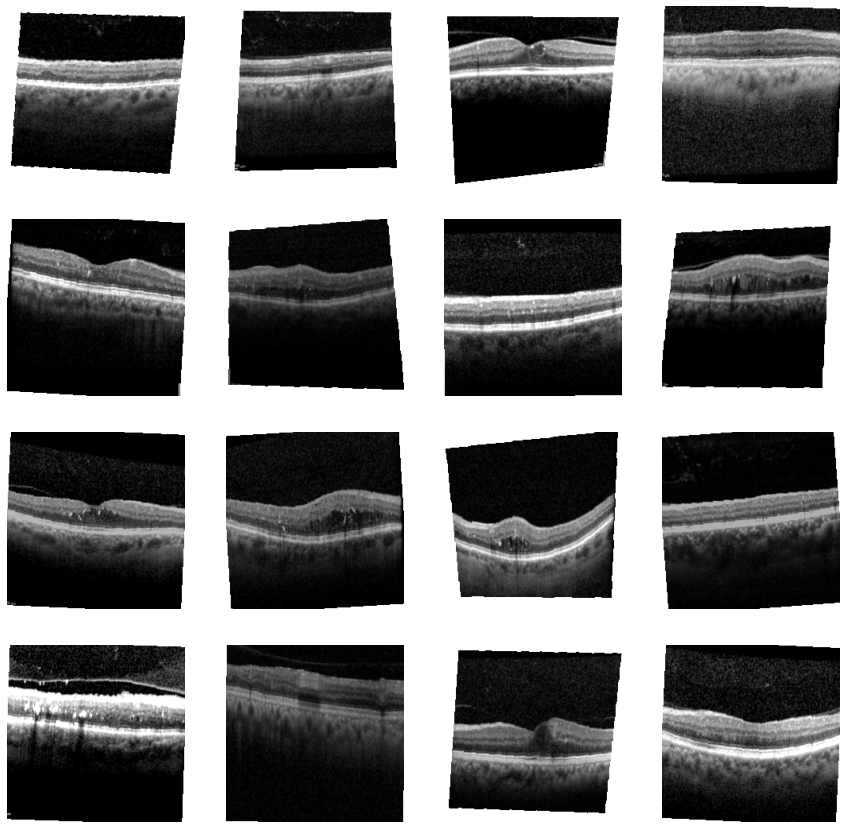

In [88]:
# Plot more images
torch.manual_seed(SEED)
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False);

# Validation Data

In [91]:
val_df["File_Path"] = "TRAIN/OLIVES" + val_df["File_Path"]
val_df

File_Path  B1  B2  B3  B4  B5  \
0     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
1     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
2     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
3     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
4     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
...                                                 ...  ..  ..  ..  ..  ..   
9305      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/44.tif   1   0   0   0   0   
9306      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/45.tif   1   0   0   1   0   
9307      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/46.tif   1   0   0   0   0   
9308      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/47.tif   1   0   0   0   0   
9309      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/48.tif   1   0   0   1   0   

      B6  
0      1  
1      1  
2      1  
3      1  
4      0  
...   ..  
9305   0  
9306   0  
9307   0  
9308   0  
9309   0  

[1176 rows x 7 columns]

In [92]:
validation_dataset = OLIVES(val_df, transforms = val_transform)
validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True)

# Traing pseudo labels with random weight

# Model 

In [94]:
model = torchvision.models.resnet50(weights=None,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

# Criterion, Optimizer

In [95]:
import torch
pos_weight_one = 3067/6371
pos_weight_two = 6424/2984
pos_weight_three = 4186/5222
pos_weight_four = 6572/2836
pos_weight_five = 6405/3003
pos_weight_six = 5320/4088
pos_weight = torch.tensor([pos_weight_one, pos_weight_two, pos_weight_three, pos_weight_four, pos_weight_five, pos_weight_six])

In [96]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# Balanced accuracy score

In [97]:
from sklearn.metrics import balanced_accuracy_score

def compute_balanced_accuracy(truths, outputs):
    
    return [
        round(balanced_accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [98]:
def compute_accuracy_score(truths, outputs):
    
    return [
        round(accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [99]:
def compute_sensitivity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [100]:
def compute_specificity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred, pos_label=0), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [101]:
def custom_metric(x, y):
    x = np.transpose(x)
    y = np.transpose(y)
    
    return [
        round((2*(a*b)/(a+b)).item(), 4)
        for a, b in zip(x, y)
    ]

# Training

In [102]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True)

In [103]:
# training routine
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

epochs = 100
t_loss = []
v_loss = []
accur = []
bal_accur = []
custom = []
s1 = []
s2 = []
for epoch in range(1, epochs + 1):
    # train
    model.train()
    #classifier.train()
    Train_losses = AverageMeter()
    
    for idx, (image, bio_tensor) in enumerate(train_loader):
        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss


        #features = model(images)
        output = model(images)
        
        loss = criterion(output, labels)
        
        # update metric
        Train_losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Val_losses = AverageMeter()
    y_true = []
    y_pred = []
    model.eval()
    #classifier.eval()    
    for idx, (image, bio_tensor) in enumerate(validation_loader):
        # Validation

        with torch.inference_mode():
            images = image.to(device)

            labels = bio_tensor.float()

            labels = labels.to(device)
            bsz = labels.shape[0]

            # compute loss


            #features = model(images)
            output = model(images)
            loss = criterion(output, labels)
            
            
            output = torch.round(torch.sigmoid(output))
            output = output.squeeze().detach().cpu().numpy()
            labels = labels.squeeze().detach().cpu().numpy()
            y_true.append(labels)
            y_pred.append(output)
            Val_losses.update(loss.item(), bsz)
    
    test_true = np.transpose(y_true)
    test_pred = np.transpose(y_pred)
    acc = compute_accuracy_score(test_true, test_pred)
    balanced_acc = compute_balanced_accuracy(test_true, test_pred)
    sen = compute_sensitivity(test_true, test_pred)
    spe = compute_specificity(test_true, test_pred)
    cus_met = custom_metric(sen, spe)
    
    t_loss.append(Train_losses.avg)
    v_loss.append(Val_losses.avg)
    accur.append(np.mean(acc))
    bal_accur.append(np.mean(balanced_acc))
    custom.append(np.mean(cus_met))
    s1.append(np.mean(sen))
    s2.append(np.mean(spe))
    print('-' * 10)
    print(f"{epoch}/{epochs}")
    print(f"Train loss: {Train_losses.avg:.5f} | Validation loss: {Val_losses.avg:.5f}")
    print(f"Accuracy: {acc} | Mean Accuracy: {np.mean(acc):.5f}")       
    print("Balanced acc (val): {} | Mean Balanced acc (val): {:.4f}".format(balanced_acc, np.mean(balanced_acc)))
    print(f"Sensitivity: {sen} | Mean Sensitivity: {np.mean(sen):.5f}")
    print(f"Specificity: {spe} | Mean Specificity: {np.mean(spe):.5f}")
    print(f"Custom Metric: {cus_met} | Mean Custom Metric: {np.mean(cus_met):.5f}")
    print('-' * 10)
    if epoch % 1 == 0:
        MODEL_NAME = f"18_vip_cup_student_one_pretrain_random_weight_epoch_{epoch}.pth"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        state = {'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'epoch': epoch,
                }
        # Save the model state dict
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(state,
                   f=MODEL_SAVE_PATH)
        del state      

----------
1/100
Train loss: 0.73515 | Validation loss: 1.00246
Accuracy: [0.4702, 0.3129, 0.5051, 0.2815, 0.8316, 0.7364] | Mean Accuracy: 0.52295
Balanced acc (val): [0.6144, 0.5, 0.5, 0.5, 0.7601, 0.7126] | Mean Balanced acc (val): 0.5978
Sensitivity: [[0.2426, 1.0, 1.0, 1.0, 0.5766, 0.444]] | Mean Sensitivity: 0.71053
Specificity: [[0.9861, 0.0, 0.0, 0.0, 0.9437, 0.9812]] | Mean Specificity: 0.48517
Custom Metric: [0.3894, 0.0, 0.0, 0.0, 0.7158, 0.6114] | Mean Custom Metric: 0.28610
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_1.pth
----------
2/100
Train loss: 0.53555 | Validation loss: 0.75554
Accuracy: [0.6879, 0.3444, 0.5017, 0.2849, 0.7976, 0.8325] | Mean Accuracy: 0.57483
Balanced acc (val): [0.7534, 0.5192, 0.501, 0.5014, 0.82, 0.8291] | Mean Balanced acc (val): 0.6540
Sensitivity: [[0.5846, 0.9864, 0.5657, 0.997, 0.8774, 0.791]] | Mean Sensitivity: 0.80035
Specificity: [[0.9222, 0.052, 0.4364, 0.0059, 0.7625, 0.8672]] | Mean Specifi

----------
15/100
Train loss: 0.14748 | Validation loss: 0.77196
Accuracy: [0.7406, 0.7815, 0.8036, 0.5476, 0.801, 0.8622] | Mean Accuracy: 0.75608
Balanced acc (val): [0.7658, 0.818, 0.8032, 0.6439, 0.8365, 0.8602] | Mean Balanced acc (val): 0.7879
Sensitivity: [[0.701, 0.9158, 0.8367, 0.864, 0.9276, 0.8377]] | Mean Sensitivity: 0.84713
Specificity: [[0.8306, 0.7203, 0.7698, 0.4237, 0.7454, 0.8828]] | Mean Specificity: 0.72877
Custom Metric: [0.7603, 0.8064, 0.8019, 0.5686, 0.8266, 0.8597] | Mean Custom Metric: 0.77058
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_15.pth
----------
16/100
Train loss: 0.14117 | Validation loss: 0.76725
Accuracy: [0.6471, 0.8061, 0.8112, 0.5553, 0.8546, 0.8427] | Mean Accuracy: 0.75283
Balanced acc (val): [0.7364, 0.8315, 0.8105, 0.6428, 0.8391, 0.8311] | Mean Balanced acc (val): 0.7819
Sensitivity: [[0.5061, 0.8995, 0.8788, 0.8429, 0.7994, 0.6996]] | Mean Sensitivity: 0.77105
Specificity: [[0.9667, 0.7636, 0.742

----------
29/100
Train loss: 0.10621 | Validation loss: 0.88599
Accuracy: [0.6718, 0.8172, 0.8138, 0.6012, 0.8614, 0.8767] | Mean Accuracy: 0.77368
Balanced acc (val): [0.7534, 0.844, 0.8131, 0.6508, 0.8534, 0.8688] | Mean Balanced acc (val): 0.7973
Sensitivity: [[0.5429, 0.9158, 0.8822, 0.7644, 0.8329, 0.7799]] | Mean Sensitivity: 0.78635
Specificity: [[0.9639, 0.7723, 0.744, 0.5373, 0.8739, 0.9578]] | Mean Specificity: 0.80820
Custom Metric: [0.6946, 0.838, 0.8072, 0.631, 0.8529, 0.8597] | Mean Custom Metric: 0.78057
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_29.pth
----------
30/100
Train loss: 0.09983 | Validation loss: 0.91218
Accuracy: [0.6888, 0.7696, 0.8061, 0.5765, 0.8605, 0.8895] | Mean Accuracy: 0.76517
Balanced acc (val): [0.7594, 0.8138, 0.8061, 0.6722, 0.8497, 0.8836] | Mean Balanced acc (val): 0.7975
Sensitivity: [[0.5772, 0.9321, 0.8098, 0.8912, 0.8217, 0.8172]] | Mean Sensitivity: 0.80820
Specificity: [[0.9417, 0.6955, 0.802

----------
43/100
Train loss: 0.08396 | Validation loss: 0.83968
Accuracy: [0.6658, 0.7968, 0.8172, 0.6122, 0.8384, 0.8852] | Mean Accuracy: 0.76927
Balanced acc (val): [0.7475, 0.8321, 0.8167, 0.6953, 0.8501, 0.8801] | Mean Balanced acc (val): 0.8036
Sensitivity: [[0.5368, 0.9266, 0.862, 0.8852, 0.8802, 0.8228]] | Mean Sensitivity: 0.81893
Specificity: [[0.9583, 0.7376, 0.7715, 0.5053, 0.8201, 0.9375]] | Mean Specificity: 0.78838
Custom Metric: [0.6881, 0.8214, 0.8142, 0.6434, 0.8491, 0.8764] | Mean Custom Metric: 0.78210
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_43.pth
----------
44/100
Train loss: 0.08226 | Validation loss: 1.10520
Accuracy: [0.7066, 0.7313, 0.7713, 0.5255, 0.8248, 0.8929] | Mean Accuracy: 0.74207
Balanced acc (val): [0.7669, 0.7889, 0.7716, 0.6469, 0.8513, 0.8899] | Mean Balanced acc (val): 0.7859
Sensitivity: [[0.6115, 0.9429, 0.7424, 0.9245, 0.9192, 0.8563]] | Mean Sensitivity: 0.83280
Specificity: [[0.9222, 0.6349, 0.

----------
57/100
Train loss: 0.07553 | Validation loss: 1.09516
Accuracy: [0.7194, 0.7883, 0.801, 0.5893, 0.8401, 0.892] | Mean Accuracy: 0.77168
Balanced acc (val): [0.7768, 0.8341, 0.8008, 0.6738, 0.8592, 0.8884] | Mean Balanced acc (val): 0.8055
Sensitivity: [[0.6287, 0.9565, 0.8215, 0.8671, 0.9081, 0.847]] | Mean Sensitivity: 0.83815
Specificity: [[0.925, 0.7116, 0.7801, 0.4805, 0.8103, 0.9297]] | Mean Specificity: 0.77287
Custom Metric: [0.7486, 0.8161, 0.8003, 0.6183, 0.8564, 0.8864] | Mean Custom Metric: 0.78768
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_57.pth
----------
58/100
Train loss: 0.07390 | Validation loss: 1.07612
Accuracy: [0.6573, 0.7755, 0.767, 0.619, 0.8486, 0.8878] | Mean Accuracy: 0.75920
Balanced acc (val): [0.7422, 0.807, 0.7665, 0.677, 0.845, 0.8805] | Mean Balanced acc (val): 0.7864
Sensitivity: [[0.5233, 0.8913, 0.8199, 0.8097, 0.8357, 0.7985]] | Mean Sensitivity: 0.77973
Specificity: [[0.9611, 0.7228, 0.7131, 0.

----------
71/100
Train loss: 0.06112 | Validation loss: 0.96051
Accuracy: [0.7151, 0.7934, 0.7968, 0.5995, 0.852, 0.8912] | Mean Accuracy: 0.77467
Balanced acc (val): [0.7683, 0.8319, 0.7964, 0.6744, 0.8568, 0.8864] | Mean Balanced acc (val): 0.8024
Sensitivity: [[0.6311, 0.9348, 0.835, 0.8459, 0.8691, 0.8321]] | Mean Sensitivity: 0.82467
Specificity: [[0.9056, 0.729, 0.7577, 0.503, 0.8446, 0.9406]] | Mean Specificity: 0.78008
Custom Metric: [0.7438, 0.8192, 0.7945, 0.6309, 0.8567, 0.883] | Mean Custom Metric: 0.78802
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_71.pth
----------
72/100
Train loss: 0.06979 | Validation loss: 1.07653
Accuracy: [0.756, 0.7798, 0.801, 0.5425, 0.824, 0.8563] | Mean Accuracy: 0.75993
Balanced acc (val): [0.7776, 0.8279, 0.8009, 0.6477, 0.8452, 0.8598] | Mean Balanced acc (val): 0.7932
Sensitivity: [[0.7218, 0.9565, 0.8114, 0.8882, 0.8997, 0.8993]] | Mean Sensitivity: 0.86282
Specificity: [[0.8333, 0.6993, 0.7904, 0

----------
85/100
Train loss: 0.05175 | Validation loss: 1.03086
Accuracy: [0.7338, 0.8138, 0.807, 0.6607, 0.8325, 0.8852] | Mean Accuracy: 0.78883
Balanced acc (val): [0.7663, 0.8445, 0.8066, 0.6913, 0.849, 0.8826] | Mean Balanced acc (val): 0.8067
Sensitivity: [[0.6826, 0.9266, 0.8401, 0.7613, 0.8914, 0.8526]] | Mean Sensitivity: 0.82577
Specificity: [[0.85, 0.7624, 0.7732, 0.6213, 0.8066, 0.9125]] | Mean Specificity: 0.78767
Custom Metric: [0.7572, 0.8365, 0.8053, 0.6842, 0.8469, 0.8815] | Mean Custom Metric: 0.80193
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_85.pth
----------
86/100
Train loss: 0.05598 | Validation loss: 1.07467
Accuracy: [0.7211, 0.7951, 0.8036, 0.5408, 0.8444, 0.8793] | Mean Accuracy: 0.76405
Balanced acc (val): [0.7819, 0.8361, 0.8033, 0.6364, 0.849, 0.8753] | Mean Balanced acc (val): 0.7970
Sensitivity: [[0.625, 0.9457, 0.8283, 0.855, 0.8607, 0.8302]] | Mean Sensitivity: 0.82415
Specificity: [[0.9389, 0.7265, 0.7784, 

----------
99/100
Train loss: 0.04960 | Validation loss: 0.97421
Accuracy: [0.7398, 0.824, 0.8087, 0.602, 0.8401, 0.8784] | Mean Accuracy: 0.78217
Balanced acc (val): [0.7776, 0.8519, 0.8081, 0.6973, 0.8506, 0.8737] | Mean Balanced acc (val): 0.8099
Sensitivity: [[0.6801, 0.9266, 0.8636, 0.9154, 0.8774, 0.8209]] | Mean Sensitivity: 0.84733
Specificity: [[0.875, 0.7772, 0.7526, 0.4793, 0.8237, 0.9266]] | Mean Specificity: 0.77240
Custom Metric: [0.7653, 0.8453, 0.8043, 0.6292, 0.8497, 0.8706] | Mean Custom Metric: 0.79407
----------
Saving model to: models\18_vip_cup_student_one_pretrain_random_weight_epoch_99.pth
----------
100/100
Train loss: 0.05995 | Validation loss: 1.09942
Accuracy: [0.7228, 0.7798, 0.7917, 0.574, 0.8376, 0.8776] | Mean Accuracy: 0.76392
Balanced acc (val): [0.7731, 0.8301, 0.7918, 0.6622, 0.8511, 0.8743] | Mean Balanced acc (val): 0.7971
Sensitivity: [[0.6434, 0.9647, 0.7778, 0.864, 0.8858, 0.8377]] | Mean Sensitivity: 0.82890
Specificity: [[0.9028, 0.6955, 0.805

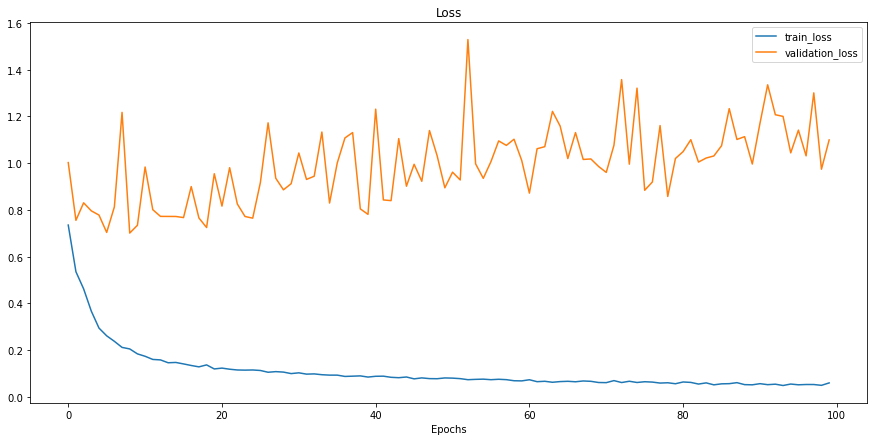

In [104]:
plt.figure(figsize=(15, 7))

    # Plot loss
plt.plot(range(len(t_loss)), t_loss, label='train_loss')
plt.plot(range(len(v_loss)), v_loss, label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

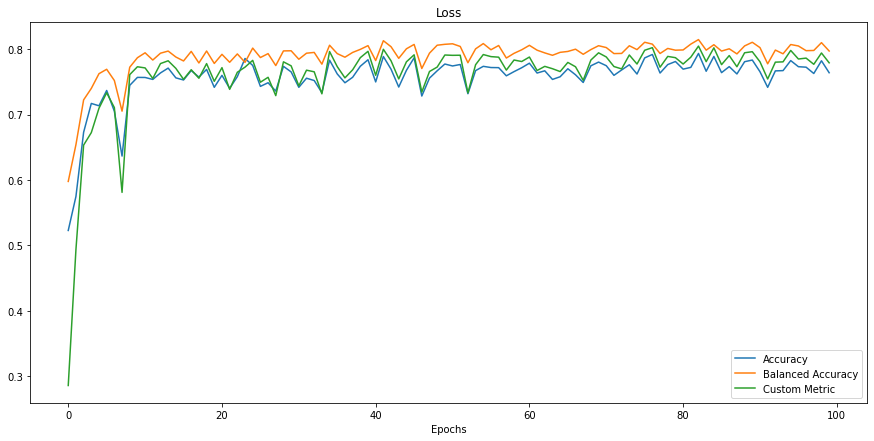

In [105]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(accur)), accur, label='Accuracy')
plt.plot(range(len(bal_accur)), bal_accur, label='Balanced Accuracy')
plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

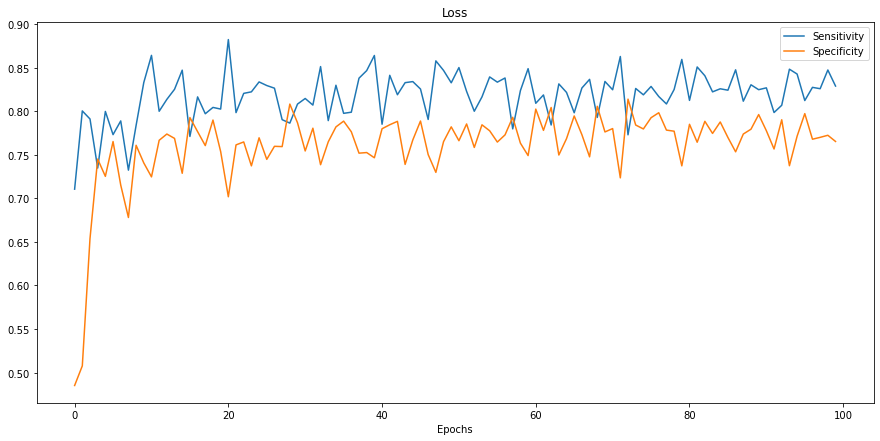

In [106]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(s1)), s1, label='Sensitivity')
plt.plot(range(len(s2)), s2, label='Specificity')
#plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [93]:
ckpt = torch.load("models/16_vip_cup_student_two_pretrain_random_weight_epoch_28.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0251, -0.0307,  0.1500,  ...,  0.0558,  0.1169,  0.1356],
                        [-0.0240,  0.1708, -0.0463,  ...,  0.0208,  0.1744, -0.0399],
                        [-0.0963,  0.1135,  0.0010,  ..., -0.0022, -0.1536, -0.0425],
                        ...,
                        [-0.0896, -0.1234, -0.0372,  ...,  0.0605, -0.1735, -0.1436],
                        [ 0.0208, -0.0741, -0.0580,  ..., -0.0273, -0.0323, -0.0227],
                        [ 0.0818,  0.1680,  0.0741,  ...,  0.1484,  0.0834,  0.1097]]],
              
              
                      [[[-0.0704,  0.0048, -0.0690,  ...,  0.0216, -0.0976,  0.0065],
                        [-0.0534, -0.0252,  0.0057,  ..., -0.1005, -0.1660, -0.0070],
                        [-0.0691,  0.0808, -0.1317,  ...,  0.0219,  0.0556,  0.0887],
                        ...,
                        [-0.0126,  0.0008,  0.1103,  ...,  0.1047,  0.1525,  0.0072],
                    

In [94]:
test_csv_path = 'TEST/test_set_submission_template.csv'
test_image_path = 'TEST/'

In [95]:
class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image, idx

In [96]:
test_dataset = RECOVERY(test_csv_path, test_image_path, val_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True,drop_last=False)

In [97]:
submission = pd.read_csv(test_csv_path)

In [98]:
model.eval()
with torch.no_grad():
    for idx, (image, index) in (enumerate(test_dataloader)):
        images = image.float().to(device)
        output = model(images)
        output = torch.round(torch.sigmoid(output))
        output = output.squeeze().cpu().numpy()
        index = int(index.numpy()[0])
        submission.iloc[index, 1:] = output

In [99]:
submission.to_csv('sub_sixt_two_pre.csv', index=None)